Data Science Project on Time series

By  
Saar Golan

# Introduction

Sweet Lift Taxi company has collected historical data on taxi orders at airports.  
To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour.  

# Preliminary research

## Literature review

In the current study, we investigate a time series based on its values only.  
However, many taxi drivers decisions regarding whether to reach the airport, stay there or wait to pick up passengers are based on psychological decisions involving:
* Their feel of the current conditions at the airport
* The time of day
* The day of the week
* The corresponding conditions at the common destination city at that instance.
* The amount of drivers present from otther (competitive) taxi companies 
and so forth.  

We have no information relating to this data so our model is bound to be quite limited.  
The advantage of ML models over classic econometric models (e.g., ARIMA/SARIMA) is that we can augment them with additional features not originated from the time series itself.  
Unfortunately, such information is not available here.  

References:  
* Advanced Forecasting with Python: With State-of-the-Art-Models Including LSTMs,
Facebook’s Prophet, and Amazon’s DeepAR
Joos Korstanje
Maisons Alfort, France
ISBN-13 (electronic): 978-1-4842-7150-6
https://doi.org/10.1007/978-1-4842-7150-6
* Establishment of taxi priority scheme model based on priority queuing system
Youkang Su 2020 J. Phys.: Conf. Ser. 1629 012016
https://iopscience.iop.org/article/10.1088/1742-6596/1629/1/012016/pdf
* Jun Kang et al 2020 J. Phys.: Conf. Ser. 1693 012203
Analysis of driver’s choice behavior based on the combined model of utility-regret
https://iopscience.iop.org/article/10.1088/1742-6596/1693/1/012203
* Jifan Li 2020 IOP Conf. Ser.: Earth Environ. Sci. 440 042086
The Taxi Driver’s Decision Model about Picking up Passengers at the Airport 
https://iopscience.iop.org/article/10.1088/1755-1315/440/4/042086/pdf
* Research on Airport Taxi Problem Based on Cell Transmission Simulation Model
Haizhen Li et al 2021 J. Phys.: Conf. Ser. 1881 042044
https://iopscience.iop.org/article/10.1088/1742-6596/1881/4/042044/pdf
* "Research on Airport Taxi Resource Allocation Based on Information Asymmetry"
written by Yansong Zheng,
published by Open Journal of Business and Management, Vol.8 No.2, 2020
https://www.scirp.org/journal/paperinformation.aspx?paperid=98959
* Yazici, M. Anil & Kamga, Camille & Singhal, Abhishek. (2013). A Big Data Driven Model for Taxi Drivers’ Airport Pick-up Decisions in New York City. Proceedings - 2013 IEEE International Conference on Big Data, Big Data 2013. 10.1109/BigData.2013.6691775.  
https://www.researchgate.net/publication  /257872776_A_Big_Data_Driven_Model_for_Taxi_Drivers%27_Airport_Pick-up_Decisions_in_New_York_City
* https://builtin.com/data-science/time-series-python  
* https://www.machinelearningplus.com/time-series/time-series-analysis-python/  
* Modern Time Series Analysis | SciPy 2019 Tutorial | Aileen Nielsen  
https://www.youtube.com/watch?v=v5ijNXvlC5A  

## Performance evaluation

This is a regression task.  
We are predicting a numerical parameter (number of taxi orders).  
However, it is also a forecasting task for a time series.  
The client instructions are to use RMSE as the error metric.

# Project objectives

Build a model and predict the of number taxi orders for the next hour.  
The RMSE on the test set should not exceed 48.

**Personal remark:**  
Can we really attract more drivers within an hour notice?  
This concept seems to me somewhat limited.  
Many taxi drivers do not own their own car and take shifts using taxi companies cars.  
This means that we need adjustment at the shift level (usually 8 hours) because these drivers can't be available within one hour notice, for less than a shift, or that they just finished a shift and are not allowed to drive anymore. Perhaps they even work for other companies on their spare time (there are usually more drivers than cars).  
In any event, an hour notice would probably necessitate our client to rely on independent (car owning) drivers to fill in the gaps.  
I have no idea as to the nature of our client agreement with such independent drivers but I am quite certain they cost more than the usual (company) drivers.  
Therefore, I suggest going back to our client to recommend an additional longer window forecast project. This forecast will undoubtedly be less accurate but in my opinion could prove as useful for them.

# Description of the data

The data is stored in file 'taxi.csv'. 

**Features:**  
datetime - instance at which the number of orders is documented (used as index).  
We will have to generate additional features.

**Target:**  
num_orders - the number of orders at that instance.

## General set-up

### Install/update packages

!pip install --user -U pandas
!pip install --user -U matplotlib 
#!pip install -Uq plotly --user --no-warn-script-location #for platform only
#!pip install -U scikit-learn
!pip install --user -U scipy 
!pip install --user -U numpy 
!pip install --user -U seaborn
!pip install --user -U plotly
!pip install --user -U sklearn
#!pip install --upgrade scikit-learn 
!pip install --user fast_ml
!pip install --user imbalanced-learn
!pip install --user pingouin

In [1]:
!pip install --upgrade scikit-learn 

In [2]:
!pip install --user category_encoders

### Import basic packages

In [3]:
import pandas as pd
import numpy as np
from numpy import percentile
from numpy.random import RandomState
from datetime import datetime
from datetime import date

import matplotlib.pyplot as plt
#from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset #Inset packages
#from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar            #Inset packages
import warnings
import seaborn as sns
import math
#import plotly.express as px

import time
from scipy import stats
from scipy.stats import chi2_contingency
#from pprint import pprint
#from scipy.stats import anderson  #Anderson-Darling Test
from statsmodels.tsa.seasonal import seasonal_decompose

### Import ML packages

In [4]:
# from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit #time series cross validation
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn import metrics
import lightgbm as lgbm
import catboost as ctbst
from catboost import CatBoostRegressor, Pool 
# Pool to define categorical data
# Pool_train=Pool(X_train,y_train,cat_features=[...])
# Pool_test=Pool(X_test,cat_features=[...])
# Does not work with gridsearch CV and pipeline

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error #as mse
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
#from sklearn.neighbors import NearestNeighbors               # added NearestNeighbors 
#from sklearn.neighbors import KNeighborsClassifier           # added kNN
from sklearn.dummy import DummyRegressor

from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV             # optimize hyper-parameters
from sklearn.model_selection import RandomizedSearchCV       # Reduce number of iterations/cost of computation with random combination of parameters. 
from sklearn.metrics import make_scorer                      # required to impose a custom made score function
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

#Imputation
from sklearn.impute import KNNImputer                        #KNN imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder
from category_encoders import TargetEncoder
from functools import partial as prt

### Output and display

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)  #was -1
plt.rcParams.update({'figure.max_open_warning': 0})

#Output all cell commands
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display as displaytab

#Base64 to encode fast image display
from IPython import display 
from base64 import b64decode 

#https://www.base64-image.de/

## Download the data

In [6]:
try:
    df = pd.read_csv('taxi.csv', parse_dates=['datetime'])
except:
    df = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'])

# Preprocess and prepare the data

Define a function to examine data:

In [7]:
def examine(fname):
    print('\n***************\n head:')
    displaytab(fname.head())
    print('\n***************\n tail:')
    displaytab(fname.tail())
    print('\n\n***************\n General info:\n')
    fname.info(memory_usage='deep')
    print('\n***************\n describe:\n', fname.describe(), '\n')
    print('\n***************\n nulls:\n', fname.isna().sum(), '\n')   
    print('\n***************\n duplicated:\n', fname.duplicated().sum(), '\n')
    
    # Exploring categorical variables
    for column in fname.select_dtypes(exclude=['number', 'datetime64[ns]', 'object']).columns:
        print('===============', column, '===============')
        print(fname[column].value_counts().head(25))
        print('Total No. of values:', fname[column].value_counts().count())
        print('\n')

In [8]:
examine(df)


***************
 head:


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32



***************
 tail:


,datetime,num_orders
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39
26495,2018-08-31 23:50:00,53




***************
 General info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB

***************
 describe:
          num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000 


***************
 nulls:
 datetime      0
num_orders    0
dtype: int64 


***************
 duplicated:
 0 



Examine the time columns:

In [9]:
df['datetime'].describe(datetime_is_numeric=True)

count                  26496
mean     2018-05-31 23:55:00
min      2018-03-01 00:00:00
25%      2018-04-15 23:57:30
50%      2018-05-31 23:55:00
75%      2018-07-16 23:52:30
max      2018-08-31 23:50:00
Name: datetime, dtype: object

Set time as index:

In [10]:
df.set_index('datetime', inplace=True)

Check if the dates and times are in chronological order:

In [11]:
print(df.index.is_monotonic)

True


Resample data by one hour

In [12]:
dfr = df.resample('1H').sum()

Examine resampled data:

In [13]:
examine(dfr)


***************
 head:


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43



***************
 tail:


,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205




***************
 General info:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB

***************
 describe:
         num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000 


***************
 nulls:
 num_orders    0
dtype: int64 


***************
 duplicated:
 4165 



Check the resampling:

In [14]:
len(df)/len(dfr)

6.0

The ratio is fine

In [15]:
df.iloc[0:6].sum()-dfr.iloc[0]

num_orders    0
dtype: int64

Summation is as expected

Plot histograms:

In [16]:
def hists(data):
    for num in df.select_dtypes(include='number').columns:
        fig_init = plt.figure(figsize=(8,7))
        plot = sns.histplot(data=data, x=data[num], bins=50)
        plot.autoscale(axis="x", tight=True, enable=True) 
        plot.autoscale(axis="y", tight=True, enable=True) 
        plt.show()

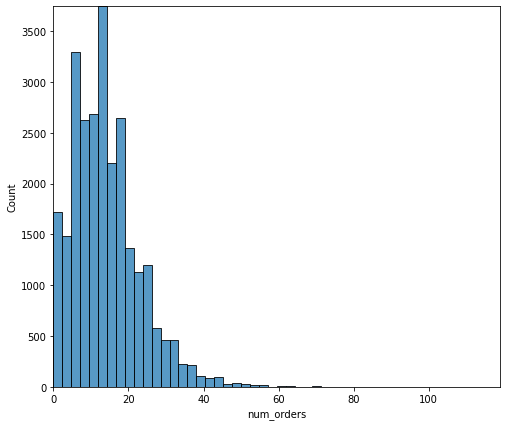

In [17]:
hists(df)

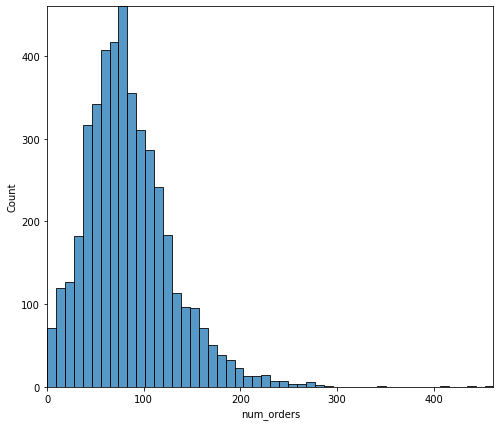

In [18]:
hists(dfr)

In [19]:
dfr[dfr.num_orders < 10].sample(20)

,num_orders
datetime,
2018-05-03 06:00:00,5
2018-05-20 06:00:00,7
2018-03-01 05:00:00,6
2018-03-30 06:00:00,2
2018-05-01 06:00:00,5
2018-04-24 06:00:00,2
2018-03-26 07:00:00,5
2018-04-17 06:00:00,6
2018-04-08 07:00:00,8


In [20]:
dfr[dfr.num_orders > 250].sample(10)

,num_orders
datetime,
2018-08-26 00:00:00,281
2018-08-30 17:00:00,342
2018-08-26 03:00:00,267
2018-08-20 04:00:00,273
2018-08-20 02:00:00,462
2018-08-18 00:00:00,281
2018-04-24 00:00:00,253
2018-08-18 02:00:00,254
2018-08-27 00:00:00,263


Histograms appear fine.  
Indeed, the one hour sampling appears to smooth the data and remove many zero orders windows.  
We do have more busy and relatively slow time slots - outlier.  
We will smooth them below.

## Allocate test set

Let's allocate 10% of the data for a final independent test

In [21]:
train, test = train_test_split(dfr, shuffle=False, test_size=0.1)

<div class="alert alert-info">
Remark:
    
It is not necessary to perform the split now as most features are extracted from the index and there is no data leakage. However, one feature - the polynomial fit trend is based on the data so just to maintain good practice I split the datasets ahead.
</div>

In [22]:
dfr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [23]:
train.info()
train.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3974 entries, 2018-03-01 00:00:00 to 2018-08-13 13:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  3974 non-null   int64
dtypes: int64(1)
memory usage: 62.1 KB


,num_orders
datetime,
2018-08-13 09:00:00,137
2018-08-13 10:00:00,156
2018-08-13 11:00:00,144
2018-08-13 12:00:00,92
2018-08-13 13:00:00,119


In [24]:
test.info()
test.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 442 entries, 2018-08-13 14:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  442 non-null    int64
dtypes: int64(1)
memory usage: 6.9 KB


,num_orders
datetime,
2018-08-13 14:00:00,102
2018-08-13 15:00:00,175
2018-08-13 16:00:00,144
2018-08-13 17:00:00,152
2018-08-13 18:00:00,104


## EDA

Extract months values:

In [25]:
mcoords = pd.Series(train.index.values.astype('datetime64[M]')).drop_duplicates()
mcoords

0      2018-03-01
744    2018-04-01
1464   2018-05-01
2208   2018-06-01
2928   2018-07-01
3672   2018-08-01
dtype: datetime64[ns]

Plot original and resampled data:

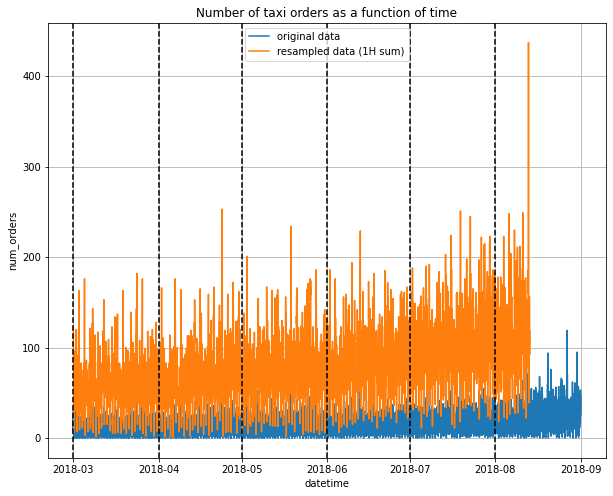

In [26]:
plt_1 = plt.figure(figsize=(10, 8))
ax1=sns.lineplot(data=df, x=df.index, y="num_orders", label='original data')
ax2=sns.lineplot(data=train, x=train.index, y="num_orders", label='resampled data (1H sum)')
for mc in mcoords:
    mplt = plt.axvline(x=mc, color='black', linestyle='--')
plt.grid()
tit = plt.title('Number of taxi orders as a function of time')
plt.show()

Remark:  
Note that the resampled data is higher because we summed every 6 10-minute entries and shorter because 10% were allocated for the test set.

It appears we have a non-stationary series.  
The mean is increasing (trend) but the standard deviation is also increasing.

Let's examine the data on a monthly basis:

In [27]:
df.resample('1M').sum()
train.resample('1M').sum()

,num_orders
datetime,
2018-03-31,42768
2018-04-30,45939
2018-05-31,54820
2018-06-30,59906
2018-07-31,74405
2018-08-31,94973


,num_orders
datetime,
2018-03-31,42768
2018-04-30,45939
2018-05-31,54820
2018-06-30,59906
2018-07-31,74405
2018-08-31,33289


Indeed - a clear trend

## Moving average

Let's smooth the data with a moving average and examine it:

In [29]:
train['rolling5_mean']=train.num_orders.rolling(5).mean()
train['rolling5_std']=train.num_orders.rolling(5).std()
train['rolling10_mean']=train.num_orders.rolling(10).mean()
train['rolling10_std']=train.num_orders.rolling(10).std()
train['rolling24_mean']=train.num_orders.rolling(24).mean()
train['rolling24_std']=train.num_orders.rolling(24).std()

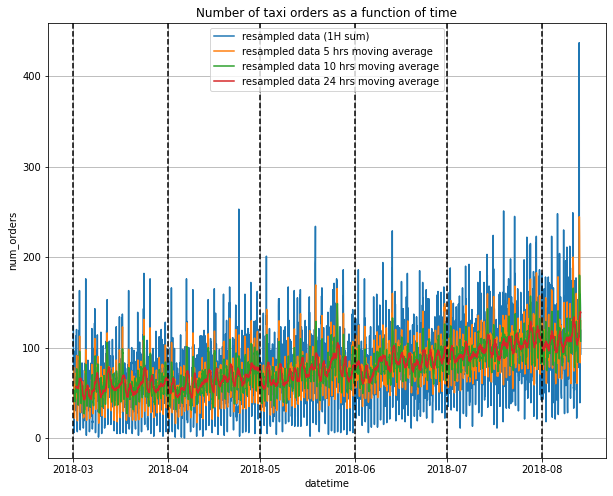

In [30]:
plt_1 = plt.figure(figsize=(10, 8))
ax0=sns.lineplot(data=train, x=train.index, y="num_orders", label='resampled data (1H sum)')
ax1=sns.lineplot(data=train, x=train.index, y="rolling5_mean", label='resampled data 5 hrs moving average')
ax2=sns.lineplot(data=train, x=train.index, y="rolling10_mean", label='resampled data 10 hrs moving average')
ax3=sns.lineplot(data=train, x=train.index, y="rolling24_mean", label='resampled data 24 hrs moving average')
plt.grid()
tit = plt.title('Number of taxi orders as a function of time')
for mc in mcoords:
    mplt = plt.axvline(x=mc, color='black', linestyle='--')
plt.show()

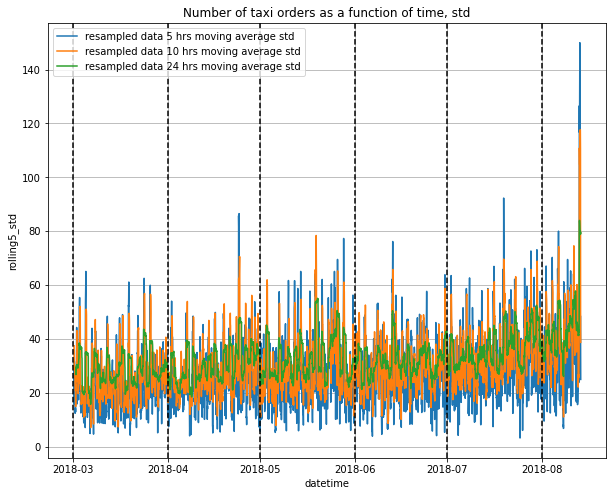

In [31]:
plt_1 = plt.figure(figsize=(10, 8))
ax1=sns.lineplot(data=train, x=train.index, y="rolling5_std", label='resampled data 5 hrs moving average std')
ax2=sns.lineplot(data=train, x=train.index, y="rolling10_std", label='resampled data 10 hrs moving average std')
ax3=sns.lineplot(data=train, x=train.index, y="rolling24_std", label='resampled data 24 hrs moving average std')
plt.grid()
tit = plt.title('Number of taxi orders as a function of time, std')
for mc in mcoords:
    mplt = plt.axvline(x=mc, color='black', linestyle='--')
plt.show()

We can clearly see the summer trend.  
The series is not stationary.  
Neither the mean nor the standard deviation are constant over time.

## Decomposition

Let's decompose:

In [32]:
def decomp(series):
    decomposed = seasonal_decompose(series)
    plt_1 = plt.figure(figsize=(10, 10))
    win1 = plt.subplot(311)
    trend = decomposed.trend.plot(ax=plt.gca())
    for mc in mcoords:
        mplt = plt.axvline(x=mc, color='black', linestyle='--')
    tit1 = plt.title('Trend')
    win2 = plt.subplot(312)
    seas = decomposed.seasonal.plot(ax=plt.gca())
    tit2 = plt.title('Seasonality')
    win2x = plt.xlim(['2018-05-01', '2018-05-05'])
    win3 = plt.subplot(313)
    resid = decomposed.resid.plot(ax=plt.gca())
    tit3 = plt.title('Residuals')
    plt.show()

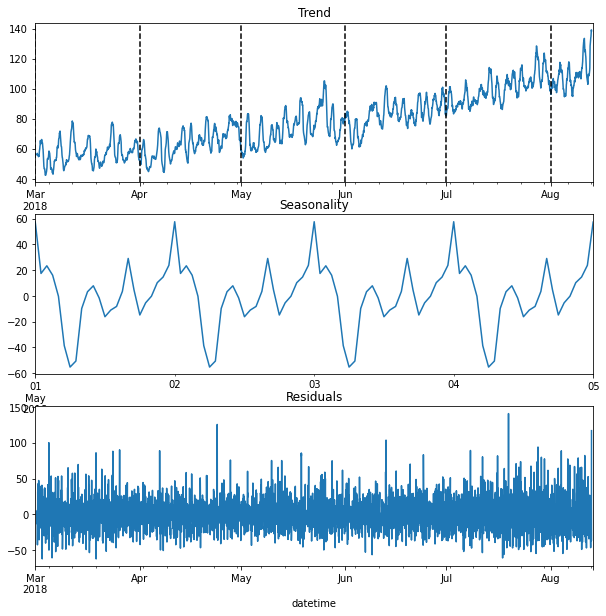

In [33]:
decomp(train['num_orders'])

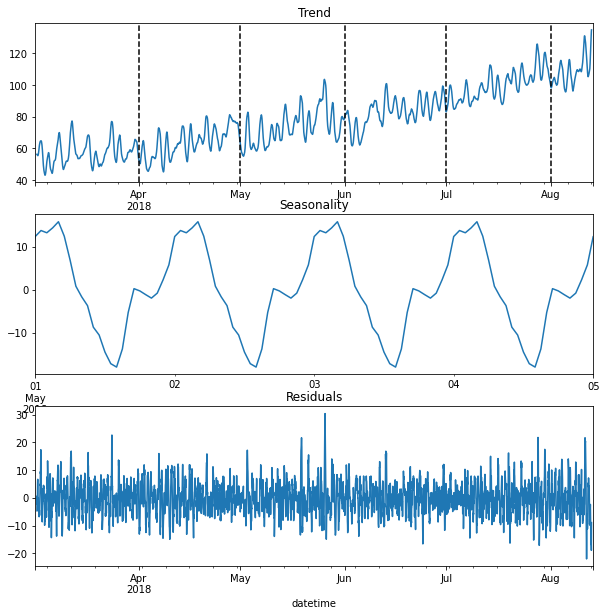

In [34]:
decomp(train['rolling10_mean'].dropna())

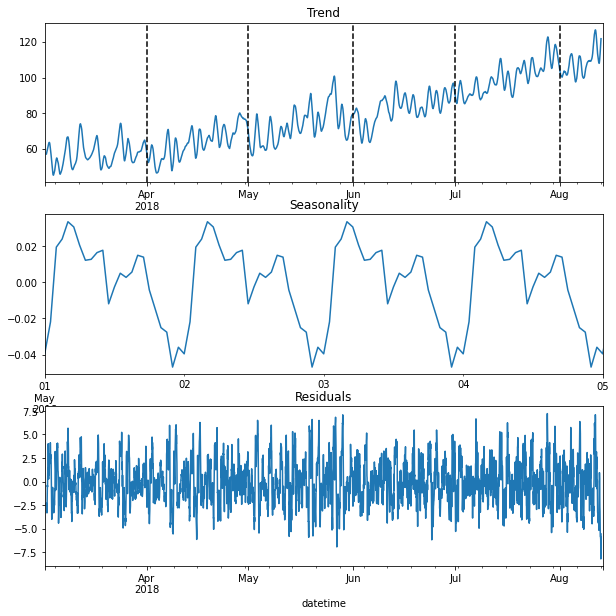

In [35]:
decomp(train['rolling24_mean'].dropna())

We can see that smoothing the series using a moving average reduces the seasonality and residual components.

However, there are two types of series - a multiplicative and an additive.  
Since our fluctuations increase in amplitude, it appears our series is of the multiplicative type:  
https://towardsdatascience.com/finding-seasonal-trends-in-time-series-data-with-python-ce10c37aa861

Additive:  

Y[t] = T[t] + S[t] + e[t]

Y[t]: Our time-series function  
T[t]: Trend (general tendency to move up or down)  
S[t]: Seasonality (cyclic pattern occurring at regular intervals)  
e[t]: Residual (random noise in the data that isn’t accounted for in the trend or seasonality  

Multiplicative:  

Y[t] = T[t] *S[t] *e[t]

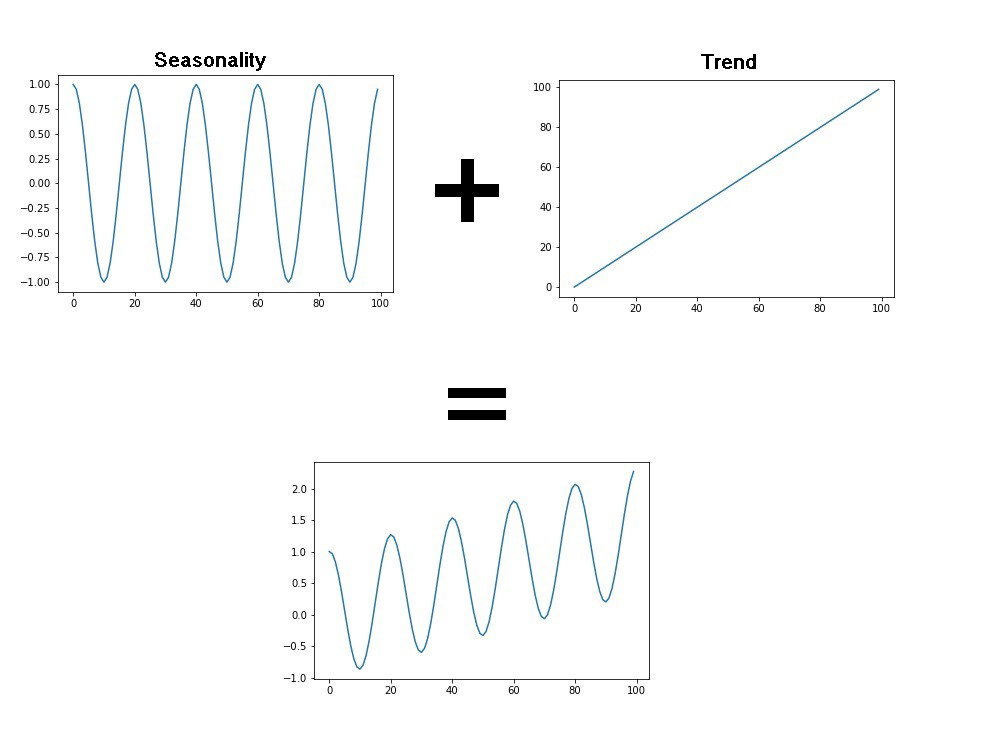

In [36]:
#remove source name with , - e.g., "data:image/png;base64,"
base64_data="/9j/2wCEAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRQBAwQEBQQFCQUFCRQNCw0UFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFP/AABEIAvED1gMBIgACEQEDEQH/xAGiAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgsQAAIBAwMCBAMFBQQEAAABfQECAwAEEQUSITFBBhNRYQcicRQygZGhCCNCscEVUtHwJDNicoIJChYXGBkaJSYnKCkqNDU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6g4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2drh4uPk5ebn6Onq8fLz9PX29/j5+gEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoLEQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2dri4+Tl5ufo6ery8/T19vf4+fr/2gAMAwEAAhEDEQA/AP1TooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr5+/aS/a0g+Bninwn4G8P+ENQ+JHxN8WbjpHhnS7uGDCK6BpbmRiWgiKmZlkMbIfs8u5kVGZfoGvj/8Aar8C/D34p/tHfDXQ9O+JeofDH9orT7OS/wDDF/pekm58+1LSPItyTGEliCW14qxNOi/vZdyuJCrAHVfBX9sW88bfGW6+EXxI+HWofCf4kLZNqllp95qlvfWeo2oEZBt7lNnnSnMxKRoyqtvKS+5HVfpavgrSviT41+AP7UXw18L/ALQfh/wR461PxRNPpPhL4v6bpyW+rxDzJlW3niWEsjO13bR7YvLiRbliZJv3jD5r8XaR41/bB/ai+Ptvqvwu1j4yab4T1O50DStMsfHCaFaeGxvktkuoYrjzFaeRbFXO390XEhkjYMgQA/Ymivz1svHfjX4A/sDX9h+1FrPjfwprh8QDStN1fwhrSXXiS8ieRLuNheedKitlbqMl3QeRDsA3Fd/hf7HNh4n+BH7e3w68JWHg7xB8JPD/AI38M/atS8K61rkWqvqEcVjdtDdS4hjMEpmtyxjZFkjczqNkcnlAA/X6ivy1/ap+BfiHwd8efHHxK+LXhrxv8SPBd3PbXvh74g/DzUxbav4Ft7b7RcCCOyyUCoUQNO+I1XM28Tyso6v9sf4lw+N/Bv7KPwz8EfEHWNW+HXxJ1OLSNT8VWepSDVdUs0NrZSJPLwrNIt5MZo5ojmWNQyqVZSAfo/RX51+B/DVp+yJ/wUr8H/Cb4cTahp/w38b+GZ9RvPDV7qNxc2dndCO5Jnt0eTiVv7MhBeTzG2ySqCFKhPlX9lP9kP4efFv9hP43/E3xDbahN4u0D+0P7Ku4Lwxx2f2Kwiu1xGBtfzWkKSeYG+QDZ5bZYgH7fUV+Wuu/tBWXjD/gnR8HNO+JXiP4j69428aTajp+nWXga6WDUvEBt5rmzW1u5mjdZIHWW2jkBWSWRmRtkpD1b/4JxN4n+F/7anxa+E0uh6h8PvCy6M2vN4Du9ai1hNNumex8tkukUBv3NyRkfMU8pZDI0QYAHv3wW/bf8d/tEfAO6+IPw++CX/CQaza+Jm0Gbw3/AMJZBbbYFtY52u/tM0KKcNLHH5YUn5twOAQPX/DP7T/hbxT+0t4s+CFpp+sR+LPDWmJqt3eTQxCxeJltmCxuJS5b/S4uCgHytzwM/jH/AM4sv+6zf+4Ovr/4d/ATwL4o/wCCs3x38N6poX2nRj4Zu9QNt9rnT9/qNtZR3r7lcN+8XUbwYzhfNyoUqm0A/T+ivxr0v44eJ/gV+xx8WP2YdTOoS/Fey8TDwlomnWNhE/2qw1B2eX7PG4WeaKUJeYk8ot/xMLTaRvXy/wBR/wBmz4QxfAX4DeB/AUcdvFcaLpkcV61pNJLDJeNmS6kRpMMVed5XAIGAwAVQAoAPTaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArz341fHvwL+zx4WtfEnxB13/AIR/Rbq9TT4bn7HPc7p2R5FTbCjsMrFIckAfLjOSM+hUUAfKv/D0f9mL/opn/lB1P/5Gr374XfFLwx8aPAmmeM/Bmp/2z4b1Lzfsl79nlg8zy5Xif5JVVxh43HKjOMjIINfFnwc/5TJfHX/sTLb/ANFaNVr9q34u/G+b9un4cfBf4XfEK38Dad4k0CO+uJrnSbW9WJllvnnlAlhZ2bybUBY9yqWVQSu5mAB960V+av7R/wC214v+H3x10/4KS/GHT/hra+GdGsn8S/Ea88IHULzU9SNqJGW3s4vNiEUongcqVjKMkoEhAVJMrw7/AMFDfiH42/Yn+NeuW+uaenxI+Hl7pNrb+KtH0sLZ6haXF3DbrciK5U5kk8u7Zg0ESqske1FbIUA/T+ivy18YftC/tPfs2fBj4PfHTxf8TNH+IfhnxTPbtqPg1tFtrErFc273ECrdRQK5YwoxZgFEcoQbZ03Z90+KPxx+K3xe/bH1P9n/AOFHi7T/AIa2nhnRota13xNe6LHqN5I5RD5NvHI7RSRML2zzuWNwySkOQAsgB9KfDj49eBfi34q8aeG/Ceu/2rrPg29Gn67bfZJ4fsc/mSxhN0iKsnzQSjKFh8uc4Iz6FX5v/wDBKKz8Rad8Z/2qbTxdf2+qeLLfxBaRaxfWihYbm8W51MTyIAiAK0gcgbV4I+UdB+kFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFeTW2tfEPxZ408cWeia74Z0bStB1WLTYItQ8P3N7PIG0+zuWd5EvoV+9csAAgwFGSTk0Aes0V53/YfxZ/6HbwZ/wCEfd//AC0o/sP4sf8AQ6+Df/CPu/8A5aUAeiUV53/YfxZ/6HbwZ/4R93/8tKP7D+LP/Q7eDP8Awj7v/wCWlAHolFed/wBh/Fn/AKHbwZ/4R93/APLSj+w/iz/0O3gz/wAI+7/+WlAHolFed/2H8Wf+h28Gf+Efd/8Ay0o/sP4s/wDQ7eDP/CPu/wD5aUAeiUV53/YfxY/6HXwb/wCEfd//AC0o/sP4s/8AQ7eDP/CPu/8A5aUAeiV47+0N+y14L/aUt9Bk8SyaxpeueHpjc6H4h0DUXtL7S5Wkhd5ISMpuJt4xudGK4JUq2GG9/YfxZ/6HbwZ/4R93/wDLSj+w/iz/ANDt4M/8I+7/APlpQB5v8Kf2HPBXwz+J9p8RdR8TeOPiN420+D7Npms+N9fe+m06IpMjxxbVjBVluJMrIHAJyoUkknxW/Yc8FfEz4n3fxF07xN44+HPjbUIPs2p6z4I197GbUYgkKJHLuWQBVW3jwsYQEjLBiAR6R/YfxZ/6HbwZ/wCEfd//AC0o/sP4s/8AQ7eDP/CPu/8A5aUAeb2X7AvwbsP2e7/4OR6BcP4XvZhfy3c120t8uoiFIft8cjZWKfbGvCKsZyymPY7IeK8A/wDBMT4a/Dnx14S8Z6V4v+ID+KfDd5FcQanc61G0tzBFFDDFZTYhANssMJi2IEJjlkQsVCKnvv8AYfxZ/wCh28Gf+Efd/wDy0o/sP4s/9Dt4M/8ACPu//lpQB4x4+/4Jz/D3xh4p8W63pHiv4geAP+Ew81vEmneE/EJgs9YkleZ5HuI5Ul3bvtEi7MiMKSAgyxPf/EH9jr4U/Eb4IaX8Jr7w3/Z/gzR/3mlW2l3Elu9hOI5Y1uEYE+ZKPPlcmUSB3YtIHJJPUf2H8WP+h18G/wDhH3f/AMtKP7D+LH/Q6+Df/CPu/wD5aUAcZ8Cf2PPBXwF8Zaz40tNV8UeMfHerwm0u/FPi/WHvr6W2IhxASAiFVNvGQxQuAMbtuFFX4RfsVeCPgv8AAPxr8ItE1TxBdeG/Fn237ddahcwPeR/arVLWTymSFUGEjBXcjYYknI4rvf7D+LP/AEO3gz/wj7v/AOWlH9h/Fn/odvBn/hH3f/y0oA8i13/gnZ8JvE37Ovhn4PaoNYu9I8NTT3Gka+08I1e0aa4aeYLKIQhVy5VkMZUqqEjeiup8G/8Agnz4C+B3xb0/4keH/FPji58TxQ3UWpzanrCTrrjXDyvJJffug0rbpEIClV3W8TlS4Zm9d/sP4s/9Dt4M/wDCPu//AJaUf2H8Wf8AodvBn/hH3f8A8tKAPA/+HYHws/4UF/wqL+3vGH/CN/8ACTf8JX9q+2Wv2z7V9l+y7N32bZ5WznGzdu53Y4r1M/sm+ELf9p//AIXtp+peINK8Xz2f2HULKyvwunamnk+SDcRFCzYVYSFV1TdbxNtLAlup/sP4s/8AQ7eDP/CPu/8A5aUf2H8Wf+h28Gf+Efd//LSgD448A/CrWv2of2+dJ+OmofCTWPhx4F8M6YIV/wCEy0mC3vta1SKMiKWS2Zg6NGLlDHPiVR9gjAdWwsf6F153/YfxY/6HXwb/AOEfd/8Ay0o/sP4s/wDQ7eDP/CPu/wD5aUAeiUV53/YfxZ/6HbwZ/wCEfd//AC0o/sP4s/8AQ7eDP/CPu/8A5aUAeiUV53/YfxZ/6HbwZ/4R93/8tKP7D+LP/Q7eDP8Awj7v/wCWlAHolFed/wBh/Fn/AKHbwZ/4R93/APLSj+w/iz/0O3gz/wAI+7/+WlAHolFed/2H8WP+h18G/wDhH3f/AMtKP7D+LP8A0O3gz/wj7v8A+WlAHolFed/2H8Wf+h28Gf8AhH3f/wAtKP7D+LP/AEO3gz/wj7v/AOWlAHolFed/2H8Wf+h28Gf+Efd//LSj+w/iz/0O3gz/AMI+7/8AlpQB6JRXnf8AYfxZ/wCh28Gf+Efd/wDy0o/sP4s/9Dt4M/8ACPu//lpQB6JRXnf9h/Fn/odvBn/hH3f/AMtKufCLxNrHizwW95r72M2rW+q6pps0unW728EgtdQuLZXWJ5JGXcsKkgu3JODjAoA7iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD5e8AfsweKfCn7fPxJ+N91f6PJ4T8S+H4tKtLOGaU3ySrHp6lpEMQQLm0k5Dk/MnHJweP8A9mDxT4r/AG+fht8b7W/0ePwn4a8Py6Vd2c00ovnlaPUFDRoIihXN3HyXB+V+OBn6hooA+Sfi9+yx8RdJ/aWk+O/wP8QeF9M8V6ppkeja7oXi+2uHsdRiCkGczRMzowENkBHEsY/cbi53Or5XxG/Zn+P/AMZ/2ZPib4O8f/EbwvrnizxZPZS6Zplpp5s9I0JYdQE7xpcrEZ51eJYwDLGWVkALNkufsuigD4q/ab/Yr8cfGj9i/wCE/wAItE1TQLXxJ4T/ALJ+3XWoXE6Wcn2XTpbWTymWFnOXkBXci5UEnBwDv/F79lj4i6T+0tJ8d/gf4g8L6Z4r1TTI9G13QvF9tcPY6jEFIM5miZnRgIbICOJYx+43FzudX+tqKAPj/wDYM/ZT+Jf7O/ir4u+I/ibr2geINa8dXlrqD3OhSSNvnWS7kneRWgiVNzXIICDH3hhQBn7AoooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK4/4rw+Fp/h5rieNW0tfC/kZvDrTxrZ4DAr5hkIXG8LgHgnA5zXYUUAfKmg+MdK8RfsLeGLfQtctNTaDwnpCalFpV2s00dnGLdL8ERksCsQnVgOQQRweK5oHwN9u/e/2H/woD/hOX8vd5X9gY/sNcf8ATH7N9t8zH8H2nGPmxX2hRQB5h+z4+pD4FeF2lWWW4FiTZpqDsjtb7m+yiRiCwJh8rJILDkkE5FVPgbcaxdeIPivJrthZadqh8UxebbadePdwJjRtM27ZXiiZsrgnKDBJAzjJ9arzv4X/API7/F7/ALGmD/0y6XQB6CwAri/h949fxZd67peoWY0vXdGvGt7qz8zeDG2WgmRiBuR0wQcDkMMDFdqDXlXjJE8PfG/wHrkaiKPVobzQ7uXoHOwTwA+4aKUD/fOOprWlFTvHrZ6+mtvn+djmrSlTtJPS6TXq7X+T/C56vRRRWR0hRRRQAUUUUAed/Fn4qf8ACt7KxjstJn8Ra5fOxt9KtWCyvFGN80mSDgKgOPVmUDrx1vhnxBY+LNBsNY0y4W5sL6FZ4JV/iVuRkdiOhB5BBB5Fee+B4k8Q/Gnx/rrKJo9MW00G0l/ubY/PnA9MvMgP+4Kd8GIV8O+JPiF4VUCOLTtY+220SjCx291EswCjsBJ5wwOMg11zpwULJe8km35O33Wul63PPp1ZuopSfuttJdmr6363s/lY9XooorkPQCiiigAo6UgNZPirXIvDHhrVdXn/ANRYWs11J/uohY/oKEruwpNRV2cBc/HWxtfienhg2EjaQJk06XXg48iPUXUulqRjklRyQeGZVIya9THFeGaN8OG1L9lg6NJEH1jUdJfUZJGHzm+lBnEhPdhIV5zn5Rg8CvT/AIdeJf8AhMfAfh7XM86hYQXLY7MyAsPqDkGuutCCV6fR29bbP566eRw4epUcrVd2rryvuvlp9509FFFch3hRRRQAxuao6vq1roGl3mo38yW1jaRNNNPIcKiKCSSfQCrzH3ryv48Kdbj8H+FABKmu67bx3MB6SW0Ia4mBHcERAEf7VXThzyS6fp1/AxrTdODkt+nq9EvvLnwl+MEfxLa/t7nSbjw/qVvsuYrK7bLz2co3Q3A4HDAEEDO1gQT0r0joa8p+JqR+HfiV8OPEqoIt9/Lod0yjBeK4iYxqx7gTRxkD1bjrXqwOfxq60Y3UobPpvbpb8L/Myw8pWlCbu07X2vone3zt8h9FFFYnWFFFFADOprhvip8SD8PNHtjZ6bJr2vahMLfTtIgfZJcuAWfnBwqqCxOCBgDjIruO/XpXlWixR+JP2gvE1/KN8XhzS7XTYQeQk05aaUr6EoIQSOcYrWlFNuUldJXf3pL8WtjlrzkoqMHZt2T7aNt/cmd14M8W6f478LadrmmyF7O9iEihh8yHoyMOzKwKkdiCK3M4IFeVfDOJfDfxR+I3h1B5VtJcW2t2sfQEXEZWYgenmwuT7v6k16sG4pVYqE7Laya9Gk/wuVQm6kE5bptP1Tt+g6iiiszoCiiigCNjjtmlU8Zqvf3sOnWVxdzuEggjaSRj/CqjJP5Zrgv2fhe3Hwo0bUtQlkkvNW87VHMjFsefK0qgegCuoAHHFWoXg59ml99/8vxMnO1RQtum/ut/mekV518B/wDkSNS/7GnxH/6e72vRa86+A/8AyJGpf9jT4j/9Pd7UGp6LRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAYPjBtaXw1fv4euLG01hY91vPqdu9xboQQWLxpJGzfKDgB15xzjNeB3H7R3i+48AW3iiytNEii0XwBpvjzxHBPbTMbqO5Sd2t7QiYeSQtndENIJeTGCOrV9B+JdGn8QaDeadb6re6HNcJsGoaekLTwjIJKiaOSMkjI+ZGGCcAHBHktl+ynotr4c0nQ5PFnie8sLTSofD92sr2SnVdMhYmGzudlsoKIDIoaMRuVlkDO240APtvjD4kl+IEBMGl/8Ibc+KZvCccCwSfb0mjtpHN0ZfM2FDNE8flCMEKQ+8nKVf/ar8V6B4c/Z++INvresadpb6n4e1O0tIr+6jhN1K1pIBFGHI3scgbRknI45rXh+CWkwePv+En/tLVDEupPrEehGSL7AmoNbm2a6A8vzdxjZvkMhTcxcIHO6n/tHf8m8/FD/ALFbVP8A0kloAP8AhnH4T/8ARL/Bn/hP2n/xuj/hnH4T/wDRL/Bn/hP2n/xuvRaKAPOv+GcfhP8A9Ev8Gf8AhP2n/wAbo/4Zx+E//RL/AAZ/4T9p/wDG69FooA86/wCGcfhP/wBEv8Gf+E/af/G6P+GcfhP/ANEv8Gf+E/af/G69FooA86/4Zx+E/wD0S/wZ/wCE/af/ABuj/hnH4T/9Ev8ABn/hP2n/AMbr0WigDzr/AIZx+E//AES/wZ/4T9p/8bo/4Zx+E/8A0S/wZ/4T9p/8br0WigDzr/hnH4T/APRL/Bn/AIT9p/8AG6P+GcfhP/0S/wAGf+E/af8AxuvRaKAPOv8AhnH4T/8ARL/Bn/hP2n/xuj/hnH4T/wDRL/Bn/hP2n/xuvRaKAPOv+GcfhP8A9Ev8Gf8AhP2n/wAbo/4Zx+E//RL/AAZ/4T9p/wDG69FooA86/wCGcfhP/wBEv8Gf+E/af/G6P+GcfhP/ANEv8Gf+E/af/G69FooA86/4Zx+E/wD0S/wZ/wCE/af/ABuj/hnH4T/9Ev8ABn/hP2n/AMbr0WigDzr/AIZx+E//AES/wZ/4T9p/8bo/4Zx+E/8A0S/wZ/4T9p/8br0WigDzr/hnH4T/APRL/Bn/AIT9p/8AG6P+GcfhP/0S/wAGf+E/af8AxuvRaKAPOv8AhnH4T/8ARL/Bn/hP2n/xuj/hnH4T/wDRL/Bn/hP2n/xuvRaKAPOv+GcfhP8A9Ev8Gf8AhP2n/wAbo/4Zx+E//RL/AAZ/4T9p/wDG69FooA86/wCGcfhP/wBEv8Gf+E/af/G6P+GcfhP/ANEv8Gf+E/af/G69FooA86/4Zx+E/wD0S/wZ/wCE/af/ABuj/hnH4T/9Ev8ABn/hP2n/AMbr0WigDzr/AIZx+E//AES/wZ/4T9p/8bo/4Zx+E/8A0S/wZ/4T9p/8br0WigDzr/hnH4T/APRL/Bn/AIT9p/8AG6P+GcfhP/0S/wAGf+E/af8AxuvRaKAPOv8AhnH4T/8ARL/Bn/hP2n/xuj/hnH4T/wDRL/Bn/hP2n/xuvRaKAPOP+GcvhP8A9Ev8Gf8AhP2n/wAbpP8AhnL4TnGPhh4M/wDCftP/AI3Wx47+JWh/D22iOpTyS31y2y00yzQzXd2/92KIcsffgDuRXKaZ4a8Y/EXUrbVfFV1N4V0SCVZ7Xw3plx++kKkFWu51wTggHy0IXpkkitY021zSdl/WiXX8u7RzyrJS5Iq78unq/wCma3/DOPwn/wCiX+DP/CftP/jdcR8Wfgp8O/C3h7RdU0XwF4Z0fVLfxT4dMN9Y6PbwTRk6zZqSrqgYZBIOCMgkd6976V538eP+RI03/safDn/p7sqyOg9FooooAKKKKACiiigAooooAKKKKACiiigAooooAKKK8y+Pup3dj4K06C2vrnS4NS17StMvb6zmaCaG2nvYopAkikNGXDeWHUhl8zKkEAgA9NoryP4R27+I/BnizQNQ1PVL/StO1/UNLs9QOqXC3jW0cgIU3auJi0bmSHfv3ERYZick+W+FfBHizxr8JdD1rw5rGr32n6r4rufEMen6t411SzebRDbXFvaQpeqZZ1VgLS6KZ2lmbJA5oA+rq87+F/8AyO/xe/7GmD/0y6XV74XeLrTxd8LPD3iDS7O/+y3GnRyQWl1c/aLk7VxsM0jnzWJUjzGc7+GLHOa5z4G6rda1r/xYvLzR77QLiTxTFu0/UXgeePGjaYBuMEkkZyACMOeCM4OQAD1jdzXln7RcZtPAEWvoC0vh3UrPV1AH8McyiT8PKaTPtmvUguea5X4paMfEXw48U6Woy13pdzCvHdo2A/UitaMlGpFva6+7qc9eLnSklvZ29eh1EbCRQQcgjIIp+Olcl8KdZPiH4aeFtSY5a60y2mY/7RjUnP0ORXWg1nJcsnFmkJKcVJdULRRRSNBuKjmkWGNnYhVUElj0AqXdXHfF3WD4f+Fvi3UVIV7bS7mRCTj5hE20fngU4rmkordmdSShByfRHPfs5wm5+HC67IhS48Q393rDg+k07GP/AMhiMfhTJx/wj/7RtnJny7fxFoDw4H8c9pKGGffZcN+C113w20b/AIR34e+GtLYbWstNtrcj3WJVOfyrk/i4w0vxx8L9Z7Q629g3+7cWsqDPtuVPxxXWpKdWfRNP9Wl96RwuDhQh3Ti/xSb+5s9UopOtLXGekFFFFACY4ry79oudpvhrLokT7LjxDe2mjRkHHE8yK/8A5D8w/hXqGea8u+KoGp/EX4WaOwyj6tcai30t7WTB/wC+pE/HFb4e/Omul392v6HLiv4TXey+9pfqemQwpBAkUahERdqqOAAOgrzD9npv7O8Lax4bwV/4R3W73Tkz18rzTLF+HlyoB7CvVa8t8At/Zvxq+Jth9xLn+ztTjXsd8DQsR+NuM+5p0/epzXaz+d7fk2Kr7tSnJea+TV/zSPU6KKK5zrCiiigBOgryvUs+IP2i9Ht9u+Dw7oU94T2Wa5lWJPx2Qy/n716mGBry74dN9v8Ai/8AFHUgd8cdxYaZG3p5VsJGA/4FcGt6WinPsvzaT/Bs5K+rhF7N/km1+KRP+0RYS3Hwk1y8tVBvdJ8rV7c+j20izcfUIR+Jr0DTL6HVdOtby3bfb3ESyxt6qwyD+RFV/EelJr3h/U9Nf7l5bS25+jKVP865D9n/AFQ6v8F/Bs7Z8xdNht5N3XfGPLbPvlDRrKj6P8/+GD4cR6r8n/wT0OiiisDrCiiigBjcDNeXfABTqeg+IvErHd/b+u3l3Ex6mFJPs8X/AI5CCPrnvXdeMdZXw94U1nVD0srSW5P/AABC39K5z4FaSdD+DngyzIIkXSreSQHrvdA7/wDjzGt42VKXdtfdrf8AQ5ZXdeK6JN/N2S/Ux/Eo/sH9oHwfqIB8vXNLvNIkPbfEVuIvxwJwPqa9SHevLfjpusX8BauuR9g8UWYdh2SYPbn8P3wr1MdPrRUs4xa/p3/yaCleNSpHzuvRpfqmOooorA6gooooA83/AGhNSl074QeIYbb/AI/NQiXS7cDqZLl1gGPceZn8K7nRNKh0PSLLT7ddtvaQpBGPRVUKB+QFedfG5W1HU/h1pCHLXnia3mZPVLeOW4J/AxLXqKsCK3lpTivV/p+jOWGtaUuyS/X9UPrzr4D/APIkal/2NPiP/wBPd7XotedfAf8A5EjUv+xp8R/+nu9rA6j0WiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvOv2jv+Tefih/2K2qf+kktei151+0d/ybz8UP8AsVtU/wDSSWgD0WiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAQcUcCiuJ8efFPR/Aj29nN52pa3d5+x6Npy+bd3B9Qg+6owcuxCjBye1OMXN2itSJzjTXNJ6HXXE8drFJLNIsUSKWd3OAoHUknoPevKrn4oa18RbqXTfhtbxS2aOY7jxZfITYwkHBFunBuXHPIIQEDLHOKbB8N9f+J08d98Rpkt9KDB4fCGnzZtx3H2qUYM7A4+UYjBHRs16ra2kGn20VtawpbwRKEjiiXaqKOgAHQD0ro9yl/ef4L/P8vVHL+8r94x/F/wCS/H0OP8C/CnSvBVxNqbyT634juhi61zUmElzL/sqekaDsiAKABwTzXcHNL0GaO9c8pSm7t6nTCnGmuWKsh1edfHj/AJEjTf8AsafDn/p7sq9Frzr48f8AIkab/wBjT4c/9PdlSND0WiiigAooooAKKKKACiiigAooooAKKKKACiiigArP1jRdP8Q6ZdaZqljbanp11GYrizvIVlhmQ9VdGBDA9wQRWhRQBgaV4I8O6JZRWen6BpdhaRWpsY7a1so440tySxhCqAAhJJKgYJJOOar678OPCPirQ7HRNa8L6Lq+j2O37Lp1/p8U9vb7V2L5cbKVXCkqMAYBIHFdPRQBVtLSHT7aG2toUt7aFBHHFEoVI1AACqBwAAAAAMcVwvwv/wCR3+L3/Y0wf+mXS69Erzv4X/8AI7/F7/saYP8A0y6XQB6JTJFDIRjIOeDT6Q9KBPU8v/ZwJh+E2naa5Pm6Tc3mmOCenk3UsYH/AHyq16gOleWfBVf7N134laSTg23iSW5VfRbiCGYfmzua9TPSt67bqyk+uv36nNhtKMY9lb7tBaKKKwOobivLv2jj9p+Ft1pS/wCs1i+sdMQevnXUSsP++S1eonoK8s+Mqf2l4n+Gejr1uPES3bD1S3t5pT/48EP4Vvh7qqmumv3anLiv4Ml30+/Q9RUYQV5h+0Wq2vw6TWMZfRtV07UR7CO7i3H/AL5LV6gORiuJ+NukDXPhF4ysgu55dJudg/2hGzL+oFKi0qsXLa6v+o8RFyoyUd7O3rbQ7ccjNOrA8D61/wAJF4M0LVM7vttjBck+u+NWz+tb2ayas7G8XzJMWiiikUIeleWak51X9pLRrdhlNI8N3NyP9l7ieNB+awv+VepjvXl3gn/iY/HX4j3j8/YbbTNNjPoPLknb9Zl/Kt6S0lJdF+bS/U5K+rhHu/yTf6Hp+Aa8tnB0v9pS0cnEWreGJIvq9vcqw/8AHbhvyr1PPWvLviYf7P8Aip8K9U6Kb6901z7TWrMB/wB9QLRQV5OL7P8ABNr8R4jSKl2a/Fpfkz1OiiisDqCiiigBh+6a8u+AK/atE8T6z1XV/Emo3KN/eRJjCp/75hA/CvRtXv00nSry9k/1dvC8rfRVyf5Vwn7O9ibD4JeDg5zJPYJdufVpsysfxMhP41tFJUZPzS/O/wChyz1xEV5N/PRfqz0c9CK8t/Z6YW3hPWtH6Lo3iDUrNVPUIbhpU/8AHZAfoRXqQPBry74Xj+zfih8VNJTiIajaako/672qBj+LQt+VOneVOaXSz/G36hU0qwl3uvvV/wBD1OiiisDqCiiigDzP9ou8e0+CnitIT++urUWCe7TusIH4mTFehafZR6fYW1rEMRQxrGg9ABgfpXmvx6JubPwZpI5TUvE+nxOvqsbm4I/8g16kOFFbyaVKK83+lvyZyw1rzfZJfm3+aPM/2j7eST4L+JZ4Rmawji1FMdQYJkmyP+/Zr0a1nju7aKeM7o5FDofUEZFY/j7Rx4h8D+INLIyL3T57bH+/Gy/1rJ+C+rnXPhJ4OvmbdJNpNszn/b8pQ36g0auil2b/ABS/yDbEPzS/Bv8AzO2ooorA6gooooA8s8XY1T4++ALJTn+zdP1LU3X03CKBD/5EcV6ie1eW6Kg1X9o/xJcggjSfD9lZ49GmmnkP5iNPyFepCt6ra5Yvovz1/U5aGrnLu/ySX6Dq86+A/wDyJGpf9jT4j/8AT3e16LXnXwH/AORI1L/safEf/p7vawOo9FooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiivLfjv8R9X+HWmeHH0cRJJquqiwmun0m51d7aP7PPLuSxtnWe4YtCqkRnKKzSEFUagD1KvOv2jv+Tefih/2K2qf+kkteT+Bf2k/F3i7SLDxRJZ6FB4dtdW0Tw9qtlCkklzNd6ilmRNDMJdkaI2o2oMTI7cSguCoz3/AO1R4u0Pwx8AfH8Ota1p+kzaj4e1O1so766SFrqU2sgEcYYguxyAFXJORxzQB69RRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAwkDHHFVdQ1C10mylu725itbSFS8s07hERR1JYkAD3Ncd47+LOmeENQj0azt5/EPim4Xdb6Hp2GmI7PIT8sMfIy7kDGcZxisGw+Feq+PbyDVviVcxagiOJbbwxZk/2dakdDJ0NxIPVhtBJwvQ1tGlZc03Zfi/Rfq9PM5ZVm5OFNXf4L1f6LUhk8f+JPiu7WngCL+y9CyVm8XahBlXH/TpC2DKf+mjYQYOA3Fdh4F+F+ieAEnlskmvNVu/mvNXvpDNd3bccvIe3HCjCjsBXWRQrDGqIoVAMADoBT8ccUpVbrlgrL+t3+m3kOFGzU6jvL8F6Lp+Y+iiisjpCiiigArzr48f8iRpv/Y0+HP/AE92Vei1518eP+RI03/safDn/p7sqAPRaKKKACiiigAooooAKKKKACiiigAooooAKKKKACvPPjV4k1Tw74UsI9FvDpmoatrOnaQuoLGkjWqXF1HHJIquChcIXC7gV3lSQwBU+h1ieK/Cml+NtBudG1q2N3p9wUZkWV4nV0dXjdJEKujq6IyupDKyggggGgDyi28RePdX+DPxFsdEv7jV/HOhXuoaTpeprFaxz3kkeGgcq6rbiQLIqMSqoWQnaoOBj2vj3XNdbw34OsPFHifR9bufENzpms3+uWemf2rYeVp7XiwIIYWtGLq1u4cLINjOM7hlPVtM+FHh3SPD0miWKalZ2EiSRyC31i9SZmeUzSSmYSiQzM7FjMW8wknLEGqDfAjwafD/APZH2C+EX9oHVjfLq94uoG8MflGf7aJhceYYv3e7zM7Pk+7xQA/4O+NL/wAW/CfRte1kifUPIkS7ltYCRPJDI8TyJGoJ+cxlgq5PzADPFYvwN1+28T+IfixqVnFfQ28vimLamo2E9lMMaNpindDOiSLyDjKjIwRkEGvRfD2g6f4W0PT9H0m0Sw0ywgS2tbWIfLFGgCqoz2AAHP41yHwv/wCR3+L3/Y0wf+mXS6APRKKKKAPLfBn/ABL/AI8fEa1b5fttppd+g9fklhY/+QlFepV5VMGsP2mLduiah4WdM+rQXSkD8pzXqY7VvWd2peS/BW/Q5cPopR7N/i7/AKjqKKKwOoSvLvF//Ex+Pnw+tV5+wafql+49MiCFT/5EYfjXqLV5ZaKb/wDaW1CQcpp3hiGIn+601zIxH4iBTW9F2cpeT/HT9TlxGqjHu1+d/wBD1SqupWSajp9zay/6ueNom+jDB/nVqkboawOlq6sebfs6Xj3nwP8AB/mf6yCxW0cehiJiI/ApivSAMivLP2fZRaeENZ0rjbpXiDVLRR6L9qkkH6SA/jXqQbHFbV7e1k1td/noc+Gb9jC+9l94+iiisTpG9K8t+CLfbtW+I+pkZNx4nnhDf7MMMMIH4FGr1Et8przD9nEC5+GiamR+81TU9Rv2PrvvJSD+KhTW8U1SlLzS++7/AEOWprWhHyb/ACX6nqA4NeWfHxPI0zwdqQ4XT/FGnSsfRXl8lj+Uxr1M4HavMP2k4ifgr4jnjBL2aQ3y465hnjl/9kooJOrGL6tL7wxP8Gb7Jv7tUeoDpS1FFIs0SOhDIwBUjoRjINS1gdKCiiigZwvxz1L+yPg740uw2100i6CH/aMTKv6kVveDNK/sLwjoum42mzsoYMem1FXH6VxX7SI+0fCe/wBPH39SvLGwUevm3cSkf98lq9OXlR9K3aSop92/wSt+Zyx1xEvJL8W/8kLjAry3SH/s79pHxBbjhdT8OWdyf9poZ5kP5CRfzr1PPNeW+Jdum/tDeDLoYzqWi6lYk+6Pbygfo360Urvmiuqf4a/oFf3eWXZr8dP1PU6KKKwOoKKKKAPLfiT/AKb8W/hXp55QXd/fsP8ArlaMgP4NMv516j0OK8s1J/7Q/aS0SE8ppnhu7uB7NNcQoPzEbflXqXVq3qtOMEui/Vv9UctH46j7v8kl+aYMOCa8v/Zs/cfCTTLBuH025vLBh/d8q6lQD/vkCvUDyK8s+BebWb4gae3/AC6+Kr0qD2WURzjH/f00Rf7qUfNP7r/5hPStCXk199v8j1WiiisDqCiikY8GgDy74XY1D4mfFTUxyh1S1sF9vJs4iR/31IT+Neofw15b8AFM+j+LNS6rqPifUpkb+8qzGFT+UQH4V6nnrW9dt1Nell9yscuG/hJ97v722LXnXwH/AORI1L/safEf/p7va9Frzr4D/wDIkal/2NPiP/093tYHUei0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXH+PPh1B47k0a5XV9T8P6to9y11Y6ppRhM0TNE8TqVmjkjZWSRgQyHBwRggEdhRQB434f/AGYPDPhm9sDYanrcemQXNrqN1pDzxNbajf2+DFeXBMZkMoZImOx1QtFGSp2gVv8A7R3/ACbz8UP+xW1T/wBJJa9Frzr9o7/k3n4of9itqn/pJLQB6LRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAMPAozhaO2c1554z+Llrouqnw9oFnN4q8WsoI0qxYAW4PR7iQ/LCvTluTkYBzVQhKpK0V/Xr0M51I01eT/wCD6HZa1rVh4c0241LVLyDT7CBS8txcSBEQepJOBXl//CU+LfjA3leElm8K+E34bxHeQ/6Vdp/06QuPlUjpK475VSRmrui/CG78Qanb678RL6LxFqcLeZbaTChXTLBuxjjPMjj/AJ6SZPoBgV6mBjgdK2vCl8PvP8F6Lr89PJ7nNapX+L3Y9k9X6vovJa+hzHgj4c6H8PbOSDSbUiedt91e3DmW5upO7yytlmY5J5OBk4AHFdR0zS57UlYSk5O8ndnXGMYLlirIfRRRSKCiiigAooooAK86+PH/ACJGm/8AY0+HP/T3ZV6LXnXx4/5EjTf+xp8Of+nuyoA9FooooAKKKKACiiigAooooAKKKKACiiigAooooAKKK4f4teMdR8GeGLWTR47V9Y1LU7LSbJr1GeCKS4nSIyyKrKzKis77QylioXcudwAO4orzbwL4s8UeMvCHiC2aXSbXxho+qXOkSXn2SVrB5I2UpMIPN3hWidGMfm5DErvIG4+c33xt8dr4Wgnsk069eHxhPoF14j0vwzf6naS2cVlLK11HZW85mG25QWrHzWUMjnOCAAD6Przv4X/8jv8AF7/saYP/AEy6XXSeF/EdrrHgvTdc/tiw1Kynso7ptWtEMNrMpQM0qKzsY0PJAZmKjgsSCa4b4G+JdJ8XeIfixquharZa3pc3imIRX2nXCTwybdG0xW2uhKnDAg4PBBHUUAes0UUUAeW+PT9j+Nvwwu+izjU7Bj67rdZQD+MBx9a9QHWvLPjgxtNR+HN+vBt/FFtGW/2ZYpocfiZFr1Ra3qPmhD0a/Fv9TlpaVKi80/wX+QtFFFYHUNx1ry74en7Z8ZPiledVjfTbBW7fu7YyED6Gc5r1EnrXlvwNLXN18Qr48/afFV4oPtEscI/WI1vTdoT81b8U/wBDlrLmqU/Jt/g1+p6pRRRWB1HlnwiUad41+KWl/wDPLXo7wD2ns4H4/EH8c16kDmvLvCn+gftAePrY8fb9M0u+Ueu37REx/wDHFH4V6grZxW9e3Ordl+Sv+Jy4fSDT6N/m7fgOooorA6jK8T6oNE8N6pqJ4Fpayz/98qW/pXKfALTRpXwV8E2+CG/sm3kYHrudA5z+LGk+Puof2b8FPG0+cH+ybiMH3dCg/VhXW+GdNGi+HtM08DH2W2igx/uqF/pW+qo+Tf5L/gnLviPRfm/+AabVyXxX0s618MPFtgoy1zpN1EB7mJgP5iutz1qG7hS5t5YXGVkUqw9QRg1jF2kmbTipRa7o5z4Xan/bfw28LagTk3Wl2s5Pu0Sn+tdTXmX7N1w03wR8KJIf3ltbtZt9YZGiP/oFemdhWlaHJVlHs3+BFCXPShJ9UvyHUUUVkbnlXxyU3d38PNPXk3Xim0cj/ZhSScn6AxCvUsV5f8QQbr4zfC206iN9TvmH+5bCMH8DOK9R6VvUjaEPNX/Fr9DkpPmqVPJpfgn+oeleW/FfGnePvhXqp6R61NYn6T2cwH6qP0r1InpXl37QKeT4e8NaiemneJdMuGb0U3KRt+khH40UL86S63X3q36jxP8ACb7Wf3O/6HqXWlpq9BTqwOoKKKTpQB5b4YVdT/aE8cXR66dpGm2Kn03tcTEfqp/EV6gq15f8JmF/48+KeqdpNbhsgfaGzgUj82P4k16itb17KaS7L8lf8Tkw2sG31b/N2/AOleXfDwfY/jL8UrLokkmm36j/AK6WxjJH4wHNeokV5bZObL9pXUoxwmo+GLeUj1aG5lUn8BKv50UnaM491+qf6DrL3qcuz/NNfm0eqUUUVgdQnXNRXEywQySOdqIpZmPYDk1JurlvijqX9j/DXxXfhsG20q6mB91iY/0ppXkkRN8sW+yOb/ZsheP4KeGZpBiS7ikvWz1zNK8p/wDQ69N21yfwo006P8MfCVkww1vpVrER7iJQa6wGtK0uepKXdtmVCPJRhHskvwHV518B/wDkSNS/7GnxH/6e72vRa86+A/8AyJGpf9jT4j/9Pd7WR0HotFFFABRRRQAUUUUAFFFc342+IPhf4a6VFqfi7xNo/hXTZZhbR3mtX8VnC8pVmEYeRlUsVRyADnCk4wDQB0lFeU/8NY/BD/osnw//APCosf8A47XeeF/Fmi+ONBttb8N6zp/iDRrrf5Go6XdJc20u1ijbJEJVsMrKcE4KkHkEUAbVFFFABRRRQAUUUUAFFFFABXnX7R3/ACbz8UP+xW1T/wBJJa9Frzr9o7/k3n4of9itqn/pJLQB6LRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRSdKAE7e3rWN4l8V6V4O0WfVdb1CDTtPh5e4uH2gHsB3JPQAZJPABrj/FXxfVNYl8N+DrA+KvFCHbNFE+y0sD/euZsEJjk7BlzjAHOaj8M/CFptYh8SeNtQHirxLGd0G6PbY6eT2tockAjgeY2XOAcjpW6pKKUqjtfp1f/A838rnJKu5Pkoq76vovn1fkvm0ZX9o+MvjKdumfa/Ang5+DqEqbdVvl9YUP/Huh5w7AueCAM16B4N8C6H4A0r+ztDsI7GEtvkYZaSZz1eRySzse5Yk10JGe9AJYZqZ1HJcqVl2X9b/0ioUVF88neXd/oug+iiisjpCiiigAooooAKKKKACiiigArzr48f8AIkab/wBjT4c/9PdlXotedfHj/kSNN/7Gnw5/6e7KgD0WiiigAooooAKKKKACiiigAooooAKKKKACiiigArm/Hvgqy8f+Hn0i9uLqyxPBd297Ysqz2s8MqywyxllZdyuinDKykAhgVJB6SigDzOP4KQ2/gXWvDFr4u8S2Y1iO5N7q1tLbJfvPPIXluhIIMJKQSg2qEVQAqqVBEmkfCO88PeCbDwzpXj7xHp0Fg6/Zru1tNKSSKBYxGtsEFl5IjGNwIj35/ixgV6RRQBg+DPCGn+AvCul+HtKWVdP0+BYIjNIXkbHJZ2PJZiSSe5JNcz8L/wDkd/i9/wBjTB/6ZdLr0SvO/hf/AMjv8Xv+xpg/9Mul0AeiUUUUAeXftGgW/wANhqX8Wmarpt8PbZeQ5P4Ak/hXpyABfWvPP2hrE6h8EfG0YJymlzTjHXMa7xj/AL5rt9E1Aato9lfL924gSYfRlB/rXRLWjH1f5L/gnLHTES9F+bv+hfooornOoa44NeYfs4n7R8LrfUP49S1HUL5j677yYg/984rvfEepDRtA1K/PS1tpJiT/ALKk/wBK5D9n6wGmfBTwTD3Ok28pB65dA5z+LGt4u1GXm1+Cd/0OWWuIj5J/i1/kz0OiiisDqPKpx9i/aYs3PyrqHhaWPPq0N0hA/KZq9UHU15b49/0T43/DC6BwJ01SxY+u6BJQP/IBr1Kt6qtGD7r9Wv0OWi/enHs/zSf6i0UUVgdR5d+0h/pHwsu7Aff1G/sLFV9fMvIVI/75Jr09R0ryv46brmb4fWCjP2nxVZEj2iEk5/8ARQr1TPFbydqUY+bf32/yOWGtab8kvuu/1HU1/umnUVgdR5Z+z24g8K67po4XTPEWqWqj2N1JIPzEgP416ljivLPhAo0/xj8UdM6NF4gW7A9BNaQP+pyfxNepg5revf2jb66/ernLhf4SXa6+52FooorA6jyu/b7d+0ppEJ5TT/DNzOPZprmJR+Yib8q9SIxXl3hsf2j+0N41uTj/AIl2jabZA/773Ep/p+Yr1LrW9ZNOMX0S/HX9TloaqUu7f4afoIRXmX7SkbP8FPE8qDc9rFFegD1hmSX/ANkr01uK5H4uacdY+Fni+yAy1xpN1Go9zEwH64qaMuSrGXZ3KxEeejOK6p/kdTBKs0KOp3K4BB9ql7fWua+Gep/2z8O/C+oZz9q0y2nz/vRK39a6TOKzlo2jWD5op+Q+kPQ0tRyOI42cnCqCST6d6RbPL/2f087RPFOo9V1DxNqc6N6qs5iX9IwPwr1IjFeY/s1ow+Cnhqdxh7tJr059Zp5Jf/Z69OByRW+IXLVlFdG19xy4X+DB90n9+oE9a8u8Tgad+0J4HuQP+Qho+p2TH/ca3lA/Qn8DXqBOa8v+KrCw+Inwr1I8BNYuLI+/nWcwA/NAfwp4ezk79n+Tt+IsTpBPzj+av+B6nRRRXOdYx+x9K81/aQuWg+CHi1Y+HuLUWi+5ldYgPxL4r0tsE15b+0IwuPCWi6Wemp+IdLtSPUfa43P6ITW9DStFvZNP7mcuK/gzS6pr5tHplnAlpawwRjEcaBFHsBgfyqfGaF6ClrA6VorBXnXwH/5EjUv+xp8R/wDp7va9Frzr4D/8iRqX/Y0+I/8A093tAz0WiiigAooooAKKKKACvz//AOC1f/JrPhb/ALHO1/8ASG+r9AK/P/8A4LV/8ms+Fv8Asc7X/wBIb6gD8V6/f3/glz/yYp8Mv+4n/wCnO7r8Aq/f3/glz/yYp8Mv+4n/AOnO7oA+q6KKKACiiigAooooAK8t+OfxVuPhnZeGrWwMUWqeIdUOm208+n3GorAFt5rh3FrbETTttgKiOMg5cEkKrV6lXKePPAdv45g0snUb7RtT0m8+3afqmm+UZ7WYxSQsVE0ckbBoppUIZGGHJABAIAPHdG/aC8Q6xO2s2V94f1nwfpeu6P4Y1Ce1sJ4Z726v1s8XEBadhAkbajagwusjfLKC6kAV1/7VHi7Q/DHwB8fw61rWn6TNqPh7U7WyjvrpIWupTayARxhiC7HIAVck5HHNQ6B+zB4Z8MX9nJZaprY09L2DVb3SZJ4mttT1GE7o724Ji8wyhxG5COiFooyUO0Vv/tHf8m8/FD/sVtU/9JJaAPRaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBgHSlPBppP5V5drvxduNZ1WfQPh9YR+JdaiYx3N+7ldN08/9NpR99h/zzTLHByVxVwpyney23fT5voY1KsaavJ77Lq/RHa+L/G+i+A9IfU9d1CKwtQQq7yS8jdkRRlnY9lUEmvPPs3jT4yjddfbPAXg1+lspC6tfL/tkf8AHsh7gZkIyCVzW54R+EFvpWsJ4i8SX0nivxYQQNRu0Cx2oPVLaEZWJfcZY85Y5r0PGBWvPCl8Gr7/AOS/V/cjDkqVv4mi7J6/Nr8l97Mfwr4O0fwTo8Wl6Jp8Om2EfKxQLjJ7sT1Zj3JJJ7mtoHn2o9KRhjpXO23dt6nWoqKSirJD6KKKCgooooAKKKKACiiigAooooAKKKKACvOvjx/yJGm/9jT4c/8AT3ZV6LXnXx4/5EjTf+xp8Of+nuyoA9FooooAKKKKACiiigAooooAKKKKACiiigAooooAK4f4teMdR8GeGLWTR47V9Y1LU7LSbJr1GeCKS4nSIyyKrKzKis77QylioXcudw7iub8e+CrLx/4efSL24urLE8F3b3tiyrPazwyrLDLGWVl3K6KcMrKQCGBUkEA87Pxk1zTPhR4p1W/tdPuvFehau/h/FukkNncXTTxxW0uwuzojC4hZl3MVywDHAJyR8W/HEuvf8IGkugDxkviJtJbWjp0/9n/Zhpi6h54tPtG/cQ6w7PPxnL7sAIeztvgdpSeCtV8MXeravqFlqvnTXtxcPCtxNdyymU3m9Il2zK23aFARQiAIAoqmf2f7AWAceJ/EA8S/2wdcPioNaf2gbo2v2Qkr9n+z7PswEWzyduADjeA1AHRfDDx6fG3w10nxLqccGmzvA5vlWT9zDNEzRzFWbHyB43IJwduCcVzfwN8S6T4u8Q/FjVdC1Wy1vS5vFMQivtOuEnhk26NpittdCVOGBBweCCOoru/BnhLT/AfhTS/D2lrKLDToFgiMz75HAHLOx5ZmJLMTySSe9cz8L/8Akd/i9/2NMH/pl0ugD0SiiigDB8caZ/bfgzXdPxn7VYTwY/3o2X+tYnwR1H+1fg/4Luidzvo9ruP+0IlDfqDXauMKfpXmX7NZ8r4NaHaN9+xku7Eg9R5V1LGB+SCt0r0W+zX4p/5HK9MRHzT/AAat+bPUaKKKwOo4P466h/Zfwa8bXOdrLo9yqn/aaJlH6kV0XhDTP7F8KaNp+MfZbOKHHptQD+lcR+0mPP8AhDqliOW1C5srED1826iQj8ia9OXlB9K6GrUU+7f4Jf5nLHXES8kvxb/yQ+iiiuc6jyv41t9h1z4baiOsHiaKAn0WaCeI/mWUV6j1NeYftFBbfwDa6pxnS9b0y9B9Nt5ECfyY/hmvTweF+lbTTdKMvNr7rP8AU5YaVpx8k/vuv0H0UUVidR5b8Rv9M+L/AMKrI8otzqN8y/8AXO1KA/gZhXqAry3VXGoftIeH7duV03w5e3I9mlngQfmEb8q9SHat6slywS6L9W/1Ry0fiqPu/wBEvzTHUUUVgdR5b4NH2H48/EW3PH2yx0q+QeuFniY/+Q1H4V6gB0rytwbP9plD0F94VI9iYbsfric16oOtb1nzNPyX4JL9Dlw+ilHs3+Lb/UdRRSMeDWB1Hl3wtxf/ABJ+KupLyratbWK+3k2cOR+chP416iOleWfANTNp3jHUDyL7xTqUit6qkvkqfyiFepZreu26mvSy+5WOXDfw0+9397bHVW1C1S9sp7eT/Vyo0bfQjB/nVmkYcGsUdLV0eafs43b3XwQ8IeZ9+CyFq3sYiYj+RTH4V6Spz+NeX/s8stv4L1TTF6aZr+qWg+gvJWH6OK9QBAIrXEW9tK213+ZzYZt0YX7L8hcZNc38SNT/ALF+H3iXUM4+y6bcT59NsTN/SujB5Neb/tGXbWfwQ8ZGP781g9qo9TKREB+O/H41NKPPUjHu0vvLry5KU5dk/wAjY+D2nHSvhR4OsiNrQaTao31ES5/XNdjiq2m2iWFjb2sf+rhjWNfoowP5VYqJu8nIunHlgororDsda8s+Py+TpXhHUOgsPFGmyufRWmETH8pTXqfbNeX/ALSin/hTHiG5UHdZfZ70EdQYbiKXI/BDW2HXNVjHu0vvMcTpRm+yv92p6gOlLTEYMgI5BGQR6U+sDqGkDmvLfjEgv/Ffwv0wctL4i+1FfUQ2s7n8jg16nkGvLvGf+nfHj4cWw+b7HaarfMPT5IYlP/kVq6KCTm79m/uTt+JyYn4Eu7S+9q/4HqI4paKK5zrCvOvgP/yJGpf9jT4j/wDT3e16LXnXwH/5EjUv+xp8R/8Ap7vaAPRaKKKACiiigAor8Vv+C1f/ACdN4W/7Ey1/9Lr6vgCgD+qivz//AOC1f/JrPhb/ALHO1/8ASG+r8V6KACv39/4Jc/8AJinwy/7if/pzu6/AKigD+qiiv5V6KAP6qKK/P/8A4Iqf8ms+Kf8Asc7r/wBIbGv0AoAKKKKACiiigArzr9o7/k3n4of9itqn/pJLXotedftHf8m8/FD/ALFbVP8A0kloA9FooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooqN3EalmO0AZJJ6CgBw54rmPG/xC0P4fact3rN55Jmby7a1iUyXF1J2jijXLOxyOAOO+BzXG6l8V9R8Z3s2j/Dazh1eaNzHc+IrrI0yzI6hWH+vcf3EOASMsOa2/A3wk07wvqL63qN1P4k8VzLtm1zUADKAeqRIPlhTk4RAOvJPWt1TjBXq6dl1+fb+tOpxutKo+Wirrq+i9O79NPM5seHfFvxkPmeJWuPB3hF+U0G0lxf3in/n6mQ/u1I6xIc8kM3GK9P0DQNN8MaTb6bpNjDp9hAu2K3t0CIo9gPzz35JrS7dcGgAnPNROq5WVrJdOn/BfmzSnRjB8z1b6vf8A4C8h9FFFZnQFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXnXx4/5EjTf+xp8Of8Ap7sq9Frzr48f8iRpv/Y0+HP/AE92VAHotFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRXnnxI+IuseF9a0bQPDXh6DxL4j1O1vNQS0utQNjEtta+SJW8wRSEuXubdFXaATJksoBNAHodFcZYeNrzxf8ADbR/FfgzTrfWDrNla6hY22p3hso2hmVZA0kixSlcI+cBGJIx3yPLtX/aln03S/C8j6R4d0y+1bVNU0ed9f8AE32HT4LixlaJxHci2czB3QhcohPIIBBAAPoSvO/hf/yO/wAXv+xpg/8ATLpdd5BJI1vGZAiyFQWEbblBPUAkDI9DgfQVwfwv/wCR3+L3/Y0wf+mXS6APRKKKKAGkfKa8s+AbmCx8aaeePsXinUUUeivIJgPylFepjvXl3wv/ANB+JvxU04cINUtb1R6+bZxZP5xkfhW9Nc0J+Vn+Nv1OWr7tWm+7a/C/6HqdFFFYHUeV/HkmePwJYj/l78V2AI9RGXmIPtiKvUccCvMPiWftvxX+FWnnmP7fe3zL/wBcrN1B/BpR+deojtW81aEPNX/Fr9Dlp+9Um+zS/BP9RaKKKwOo82/aMs2vfgf4yCffh0+S5UjsYsSA/hszXfaXepqOm2t2n3J4lkX6MAR/Osf4iaZ/bXgHxHp+N32rTriDHrujZf61nfBrUTq3wl8HXbHc82kWjsf9rylz+ua3bbopdn+aX+RyrTEPzS/Bv/M7SiiisDqPK9BQaj+0X4ruP+gboOn2n4yS3Eh/QD8q9SWvL/hkftvxS+KuojlP7QsrJT/1ytIyR+DSH869PDcV0YhJSSXZfkr/AInLhtYN92/zaX4IfRRRXOdR5Z40/wBC+O3w1uBwLu21WyY+uY4pVH/kJjXqPpXl3xmk/s/xP8MdTHDQ+IxbE+izWtxGfzJUfjXqK85reo04Qfk1+Lf5M5aWlSovNP8ABfqmOpjEBcngY5zTs1gePNT/ALG8E6/qGcfZdPuJ8/7sbN/SsUrux0SfLFs479msF/gzoVy2d161zfEnv51zLKCfwcV6h0xXE/BTT/7K+EHgy0K7Xj0i1DD/AGvKUt+pNdseMVrWfNVlLu2Y4ePLRhF9l+QtIelLRWJ0HlnwZT7B4k+J2mN96HxG1yB6LNbQSD8yWP416h2xXl/gr/Qvjp8SrY8C6t9Kvl98xSxE/wDkFRXqKkGuiurT06pfikzlwz/d27Nr7m7A/SvLv2iGFx4G0/Szj/iaa5pdnj2a8iY/op/CvUSc15d8aF+3eIfhlpw5M3iWOcr6rDbzyn8iqn8KVC6qJrpr92oYn+E13svvdj1FRgU6k6UtYHUIBXF/GfTjqvwk8Z2ajc82kXSoP9rymx+uK7MmqmqWa6lpl3aSfcniaI/Rhg/zqoPlkmZ1I80HHujK+H2p/wBt+BPD2oZ3fatOt58+u6NW/rXQYwa84/Z1vWvvgf4MZ/vxadHbMD2MeYyP/HMfhXo2cEVVWHJUlF9H+RNCXPShLul+Q7POK8rGbz9pr1Fh4U/AGa6/wt69UHU15d4Lb7b8d/iPcHn7JZ6VYofT5JpWH/kVTV0ldTfZfql+pnW1lCPd/km/0PUqKKKwOoK86+A//Ikal/2NPiP/ANPd7XotedfAf/kSNS/7GnxH/wCnu9oA9FooooAKKKKAPz0/4KEf8E9/iJ+1f8ZtF8W+EdZ8Madptl4fh0qSPWrq4imMqXFzKWAjt5FK7ZlAJYHIPAABPzD/AMOVPjf/ANDT8P8A/wAGN9/8h1+1NFAH4rf8OVPjf/0NPw//APBjff8AyHXkP7T3/BPj4i/sneAdP8XeLdZ8Majpt7qcelRxaLdXEswleKWUMRJbxqF2wuCQxOSOCCSP6B6/P/8A4LV/8ms+Fv8Asc7X/wBIb6gD8V6+wPgN/wAEw/il+0N8KND+IPhzX/CFlousef5EGqXl1HcL5U8kDb1S2dRlomIwx4IJwcgfH9fv7/wS5/5MU+GX/cT/APTnd0AfAP8Aw5U+N/8A0NPw/wD/AAY33/yHR/w5U+N//Q0/D/8A8GN9/wDIdftTRQB8u/8ABPn9mHxT+yf8GdZ8JeL9Q0jUdSvfEE2qxy6JNLLCsT29tEFJkijYNuhckBSMEckkgfUVFFABRRRQAUUVwfxd8eXfgXwwTo8EN74n1BmttJtLgkxNMEZ2kkAIPlRIjyPggkJtB3MoIB3ledftHf8AJvPxQ/7FbVP/AEklrzDwp+0P4t8RadpfiSS00WPw5b3/AId0TVrNbeX7VLeapb2MnmwSGXbHFG2p2o2MjswWT5wQM9t+1R4u0Pwx8AfH8Ota1p+kzaj4e1O1so766SFrqU2sgEcYYguxyAFXJORxzQB69RRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUARk8UuScc8GoLi5israS4nkSGKNSzySMAqgdSSeg968puviZrnxKuJdO+G8Ef2BWMdx4uvo82cfOCLaPg3DjnnhAQMk5xWkKcqm2iW7ey/r730uYVKsaej1b2S3f8AX3HYeOvifonw+ggXUJZLjUbo7bPSrJDNd3bf3Y4xyfcnCjuRXGp4G8T/ABaIuPHUjaL4cJzH4T0+fLTDt9snXBf3jQhemS2K6nwJ8K9J8DTT6gGn1jxBdjF3reot5lzN7BuiJ0wigKMDg4zXcCtOeNLSnv36/Lt+foZezlW1q7dl+r6+m3qUtM0yz0awgs7G1hs7OBQkUFvGESNR0AUAAD2Aq6OBR0+lLXPudaVkFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvOvjx/yJGm/9jT4c/8AT3ZV6LXnXx4/5EjTf+xp8Of+nuyoA9FooooAKKKKACiiigAooooAKKKKACiiigAooooAwfFfgrw/4901NP8AEuhaZ4h09JROtpq1lHcxLIAQHCSAgMAzAHGQCR3Nee61+z7p+kahpmrfDJdC+G2s2kF5aNLZaDHJbzQXIhMoaGN4cyBra3dXLEAx4KsCRXsFFAHl2sfCrXLL4SJ4D8F+Ko/CdnZ6VZaRp2oNp73NzawwgRyksJ48s8SoisuxozuYFiVCxD4ZeK7H4c6d4T0nXfCmlQW9rLYTCPwtK9sbZlCosULXx2Mqg5LtIGJyVHIPq1FAGB4X8IWPhbwVpHhePffadp2nxaYv20iRpoo4xGPMyMMSo5yMHJ45rhfgb4b0nwj4h+LGlaFpVloulweKYjFY6dbpBDHu0bTGbaiAKMsSTgckknk16zXnfwv/AOR3+L3/AGNMH/pl0ugD0SiiigBpHWvLfDpGnftEeMLbPOo6Hp14B7xyXER/mP0r1IHAry3V0Gm/tIeHJzwNT8OXtsPdoZ4HH5CRvzrek370e6/LX9Dlr6ckuzX46fqeqUUUVgdR5ZrpGpftF+Frbr/ZugX939DLNbxj8wp/KvUgOleWaEBqX7Rnim5HI03QLCz+hlmuJD+YVfyFepbq3q3XLF9Evx1/U5aGvPLu3+Gn6DqKKKwOoikQSIysMgjkV5p+zWxHwW8OW7ffsxPYkHqDDPJFj/xyvTW5ry74BMYNO8Y6b0Gn+KNRiVf7qvJ56j8ph+dbxf7qS80/zX6nLNfv4Pya/J/oeqUh6UtMY4Uk9hnNYHUeW/AUNPB45vzyt54q1BlPqI2WEY/CGvU8ce9eX/s2KX+DmiXjffv5Lm/JPU+dcyyAn8HFeoZ5reuuWrKPZ2+45cLrRg+6v946iiisDqPK/wBoZPs/g3StT7aXr+l3bH0Au41P6OfwzXqQ5Arzf9oyze9+B/jER/fhsGulPoYiJQfwKZrvtLv01LTrW7j+5PEsi/RhkfzreX8GL82vwX/BOWOmImu6T/F/8AtN615z+0RefYPgj4zcZzJpstuAO5lHlgfiXxXo+RwK8t/aJdbnwFZ6V/0Ftb0yxx67ryJiPyU59s0YdJ1Y32uh4ltUZ23s/vsei6PYrpmlWdmn3beFIh9FUAfyq5jmheAKdWD1OhKysFFFFAzypCbP9pmRegvvCqnHqYbogn8pxXqZHNeX+Mz9g+O/w3uV4+2WmqWDn+9+7imUf+QnNeoY59q3qrSL7r9Wv0OWho5x7P8ANJ/qA5Bry/x1/pvxy+GVsuCLaHVL5v8AZxDHED+PnEV6lXlTE3v7TCA8pp3hUn2DT3QH54tz+dFF8sm/J/irfqGI1jGPmvwd/wBD1WiiisDqCmt9006igDyz9nVltvAFzpeRnS9Z1OyI9Nt5KQPyYfpXqOK8t+DC/YPEXxN0w/eg8SSXKr6LNbwyj8yzH8a9SHJrevd1G311+/U5cNpSS7afdp+gh4ry74Ot9v8AFvxP1TqZfEP2UH1WG1gjH5EEfga9RY8GvL/2eVFx4J1PVV6atrup3oPsbuRR+iDHtiiF1Tk11sv1/QKmtaC9X+Fv1PU6KKKwOoK86+A//Ikal/2NPiP/ANPd7XotedfAf/kSNS/7GnxH/wCnu9oA9FooooAKKKKACiiigAr8/wD/AILV/wDJrPhb/sc7X/0hvq/QCvj7/gp78BvHX7Q/wE0Hw58PtC/4SDWbXxNb6hNa/bILbZAtrdxs+6Z0U4aWMYBJ+bIGASAD8GK/f3/glz/yYp8Mv+4n/wCnO7r8rP8Ah1x+07/0TP8A8r2mf/JNfr7+wZ8LvE/wW/ZP8DeDfGWmf2P4k0z7d9rsvtEU/l+ZfXEqfPEzIcpIh4Y4zg4IIAB9A0UUUAFFFFABRRRQAVynj74YeE/ihpyWPivw5pXiC3iD+R/adjFcm3Zl2lo/MVgrYxyB2HpXV0UAeMeFv2WPCPgw6Lb6Nd6nYaDpzWNxJoEBt0sr67s0Vbe7mVYQ/nAxxMfLZFZokLKSK6L9o7/k3n4of9itqn/pJLXotedftHf8m8/FD/sVtU/9JJaAPRaKKKACiiigAooooAKKKKACiiigAooooAKKKpalqVrpFjNeX1zDZ2kKl5bieQIkajqSxwAPc0bibsXD37VxPjr4qaR4ElgsXWbVvEF2M2miacnm3U/vt6Ig5y7EKMHniuUfx14m+LLtbeAozo3h5vll8W6hB/rR/wBOcDYMh9JHwvBwGrsfAvww0T4fwzvYRSXOpXRDXuq3zma7u29ZJDyfYDCjsBXRyRpfxN+3X59vz9Dk9pOtpS0Xd7fJdfXb1OQtvhrrvxMni1D4kTxppwYPB4RsJM2iHqDcyDBuGHHHEYI4BzmvVre1hsraOC3iSGCJQiRxrhVUdAAOgHTAqejHBrOdWVTfRdF0X9eer6m1OlGnqtX1b3/r8B9FFFZmwUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFedfHj/kSNN/7Gnw5/6e7KvRa86+PH/Ikab/2NPhz/ANPdlQB6LRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVw/wAQ/ihbeAJtOtF0XV/EerX8c9xDpmiRwtOYIApmmPmyxrtTzIwQGLFpFCqxOK2vFPhKy8ZaYljqE+qW8KSiXdpOq3WnS7gCADJbSRuV5OVLFScEgkAjzPX/AIOaz4T8R6J4l+Hs39o6tZWWoabJbeMvEOoXUZiujbOZEmlNw6lJLKE+WAFYM4JUkGgDsfE3xa0jw/8ADey8bWtveeINK1A6eLGLSxH512b2eGG32ea8aAM1xGSWZQASSeMVn+I/jH/wjOn6L9r8G+I59e1SO5uE8N2os5b6KC3I86ZyLnySo3xcLKzEzRqFLEqKUXwwuNB+DWlfD2Lw9oHjTStG0jTNNt7XxHdNHb3xtwqsZkFvME2iKN1IEm5sghdoY8boHwW8ceBYPD+s+Hh4cOvaeNatI9DuL24j0zT7PUJ4J1it5RCzsIXtIMKYkVg0gAjAUAA918O67Y+KdA0zWtMuFutN1G2jvLW4TOJYZFDowz2KkH8a474X/wDI7/F7/saYP/TLpdbHw+8DQeA/hj4b8Gx3Et1baLpFtpC3KsYpJEhhWIMCpBUkLnIIIPQ5rkfgboFr4Y8Q/FjTbOW+mtovFMRV9Rv572c50bTGO6ad3kbknGWOBgDAAFAHrVFFFACHtXlvxM/0H4q/CvUjxH9uvbBj/wBdbR2A/FoV/KvU68q+PitBY+DNRHAsPFGnSMx7K8hhY/lMa3oO1TTrdfemv1OXE/wm+1n9zv8Aoeq0Ug6ChuhrA6jy34XY1D4mfFTUxyh1S1sFPp5NnESP++pCfxr1H+GvLPgApn0jxbqXVdR8T6lMjf3lSYwqfyiA/CvVM9a3rtupr0svuSRy4b+En3u/vbYtFFFYHUMIB4ry/wCGK/YPij8VdNHCDULO/Uf9drSME/i0TV6l0ryzSG/s79o/xHbLwup+HrG6Pu0U08Z/IOv510UmuWafVfqn+VzlrK0qcuz/ADTX52PUSOa574har/YPgPxHqWdv2TTrifPptjZs/pXRLXmv7R149r8EfF4j4kuLM2ae5mZYgPxL4/GopR56kY93b7y68uSlKfZN/gbHwa0w6P8ACbwdZEbXh0m1Vh/teUuf1zXYgc1X0+1Sxsre2j4jhjWNR7AYH8qsA5qJvmk5PqXTjywUeySH0UUVJoc/490r+3vBGv6bt3/bNPng2+u6Nl/rWT8FNS/tj4ReDbxm3PLpFqXP+15S7v1zXZOPkOa8y/Zt/c/CDSLI/f0+e8sGB/h8q6ljA/JRW6V6LfZr8b/5HK9MRHzT/Br/ADZ6ewry74yJ/aHij4Y6Up+efxGt0V9Vgtp5T+RCn8K9RJBFeX+MB/aHx7+HlqvP2Gx1S/cemVhhU/8AkVxRQSc3fs/wTt+IYn4Eu7S+9q/4HqVFFFYHUFFFFAHlfxnf7B4i+GeqLw0HiSO3LeizW80R/Mso/GvUupry79osC2+H0GqH72k6xpt8P+AXkOT+AJP4V6hngVtNN04t+a/X9Tlp6Vpr0f4W/QcK8t8FD7d8dfiVct8wtLfS7BD6YikmYf8AkZTXqLHbXlvwUf8AtDXPiVqbctceJpYA3qsMEMQH4FGFOk7Qn6Jfiv8AIKutSmvO/wByf6tHqlFFFYHUFFFFAHlngv8A0D48fEe2bj7ZaaXfoPX5JYWP/kJRXqP+FeWSg2P7S9u/RNQ8LOn1aC6UgflcGvUx1rorPmafkvwVv0OXD6KUezf4u/6lTV75NL0u8vJP9XbwvK30VST/ACrhP2dbFrH4IeDVb782nR3TH1MuZSfxL5/Gr/xu1M6R8H/Gd2G2vHpF1sP+0YmC/qRW54H0r+wvBuhadjb9ksYLfHptQL/Sldqi13f5J/5hviF5J/i1/kbtFFFYHUFedfAf/kSNS/7GnxH/AOnu9r0WvOvgP/yJGpf9jT4j/wDT3e0Aei0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV51+0d/wAm8/FD/sVtU/8ASSWvRa86/aO/5N5+KH/Yrap/6SS0Aei0UUUAFFFFABRRRQAUUUUAFFFFADO9GeKzdd17TvDOk3Go6tew6fYQLuluLhwiqM9yfXoB3zgV5j/wkvi34yN5XhdZ/CPhJ+H8QXcWL28U/wDPrC4/dqR0lkGcEFV4zWkKTnd7JdXt/wAH5XZhUrRg1Hdvot/+G8zo/HPxa07wpqK6Lp9rP4j8VTruh0PT8GXB6PKx+WGPkZdyB6A9KxNP+FGp+Nr2HWPiTdRaq8biS28N2hI020I6Fwebhx/ecbQScKOK7HwP8PND+H1hJbaPaeW8z+Zc3czGW4upO8ksjZZ2JJOScDPAArp6t1IwXLSWvd7/APA/PzsZKjKo+as/RLZevd+unkIiLEgVQAoGABxgDpipKKKwOwKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK86+PH/Ikab/2NPhz/ANPdlXotedfHj/kSNN/7Gnw5/wCnuyoA9FooooAKKKKACiiigAooooAKKKKACiiigAooooAKKK4f4h/FC28ATadaLour+I9Wv457iHTNEjhacwQBTNMfNljXanmRggMWLSKFVicUAdxRXMt40jvvBdn4m8P6ZeeK7S+t4buzt9LeBJbmGUKyOhnkiQDawY7mBwDgE4B8/wBN/aSttZ07QptP8DeKb2+1i/1LT7fTI205Zg9jI0dxIXa8EJTcjBSsjbsZAwQSAezV538L/wDkd/i9/wBjTB/6ZdLrvYZGliR2jaIsoJjcjcpI5BwSMjocEj0Jrgvhf/yO/wAXv+xpg/8ATLpdAHolFFFADQK8z/aQgkl+C/iSeIbpbGOLUEx2MEqTZ/8AIZr0wmsHx5ov/CSeCdf0rG77dYT22PXfGy/1rWjLkqRn2af3GNaPPSlHun+RsWlwl1bRTxHfHIoZT6g8g0l/dR2VlPcSnbFEjO59ABkn9K5D4Kaz/b3wj8H3zNvkl0q28xv9sRqG/wDHgaZ8ctZ/sL4PeMr0NskTSrhY2/22Qqn/AI8RRyP2vs+t7E+0XsfadLX/AAM/9nG0ktvgt4WklGJby3a/f6zyPMf/AEZXpO2sXwZow8O+EdE0oDaLGyhtsDtsQL/StoGlVlz1JT7tv7x0Y8lOMOyQ6iiiszcYBk15d4lK6X+0J4KvO2qaTqOnE9so0My/jhX/ACNepdK8t+Mzf2Z4g+GusqPmtfEcdqzeiXEEsJ/NnQfjW9C3M0+qf5O34nLifgTXRp/ir/gep9MV5Z+0E32rw74c0fG4av4j021ZfVFnWZv/AB2En8K9Sz8pry74k/8AEy+LHwt0tvmiW7vtTdf+uNsUU/g1wtGHT9pddLv7k3+gYn+E13svvaR6kOgpaKKwOoKKKKAGYya8u+BytY3PxA0l+tl4nunVD2SdY7gEe2ZWx9K9Szg15f4NP9m/Hn4h2bHH9oWemanGvrhJYHP/AJBQVvTV4TXlf8UvybOWrpUpvza+TT/VI9QNeW2KHU/2ktUmXmPSPDcFu3+y9xcSOR+KwKa9SBry34WuNT+JPxT1cfdbU7bTV+kFrGT/AOPTPSpL3Zt9F+q/QK3xU493+Sb/ADseqUUnWlrE6gooooA8++PmlHWfgx4ztlBMn9mTyxgdd6KXXHvlRXV+F9XXX/DmlaomNl7axXAI9HQMP51a1Wwj1XTbuzlGYriJonHqGBB/Q1wX7Ot8998E/CIl4ltrIWLj0aBjCR+BjP5V0ayo+j/Nf8A5PhxHqvyf/BPRpOUNeYfs4gXPwwi1Uj59Z1G/1Nj6+bdSsp/75211/wARNa/4RvwF4i1UHabHT7i5B90jZv6VnfBzSD4f+FPhDT2GyS30q2Rx/teUpb9SaSaVF+bX4J/5ob1xC8k/xat+TO0ooorA6gooooA8s+IIOn/GP4Yal92OaTUNMkPY+ZbiVQfxt/1r1LpXlnx+U2ml+EtXzhdL8TafPI391JJPs7H8pjXqKtwK3qNuEH2Vvxv+py0vdq1I92n96S/Q8x/aOP2r4W3OlD/W6xfWOmKPXzbqJWH/AHyWr05egry34xqNT8V/DLRgfmuPEIvGX1S2t5pT+TBD+FepA9KJ3VOC9X99l+gU/erTl6L7rv8AUfRRRWB1BXnXwH/5EjUv+xp8R/8Ap7va9Frzr4D/APIkal/2NPiP/wBPd7QB6LRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFcl8Q7vW9M8PyXuja7ofhxLMPc32o+ILKS6t4oERmYlUngxjAJYvgAHg9utrhPiz8K4Pi3oun6Zd69q+h21nfRagy6ULZlunjyUjmS4hlSSMNtfaVwWRSc4xQB5J4T/aJ8Z+JLGy8R3ej6ZpOh2uqaDoGr6TPbzfb/tmpRWTCWKUyKI0jbUrUeW8RYgSZZSAK7j9qjxdofhj4A+P4da1rT9Jm1Hw9qdrZR310kLXUptZAI4wxBdjkAKuScjjmrY+AenT+JbfWL3xHr2of6Taahf2Mz2yW2p31qqrb3c6xwKRIojhOIjGhMMRKHaKvftHf8m8/FD/ALFbVP8A0kloA9FooooAKKKKACiiigBq9KXpSEY9hWL4p8XaT4L0ibVNb1CHTLCL7007YHsAOpY9gASegBoSbsktSW1FNydkbOcda888YfF+20jV28O+HbGXxX4rIydMsnAS2B6PczH5YV9jljxhTWCbvxp8ZflsvtngPwa/W7kQLq18v/TNTn7Mh5wzAueCAua9D8H+CNE8A6Sum6Fp8dhagl225Lyt3eRySzse7MST610csKWs9X2/zf6L70cvPUraU9F3e/yX6v7mcXofwiutd1aDX/iHfReJNYhbzLbTYlK6bp57eVEfvuOf3j5bpgDFeo7QBgdKcM/Wg8/Wspzc7c3Tby9DenSjS+Fa9X1fqOoooqDUKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvOvjx/yJGm/wDY0+HP/T3ZV6LXnXx4/wCRI03/ALGnw5/6e7KgD0WiiigAooooAKKKKACiiigAooooAKKKKACiiigDB8U+ErLxlpiWOoT6pbwpKJd2k6rdadLuAIAMltJG5Xk5UsVJwSCQCPM9f+Dms+E/EeieJfh7N/aOrWVlqGmyW3jLxDqF1GYro2zmRJpTcOpSSyhPlgBWDOCVJBr2qigDzvw54N174e/CK08G+GnsZrvQfDVvpei39/M4Wa6htzEhnQRnZGCkRJUuSGYbRtG7k/FXwLWP4WeFPBmmeD/CvjSLRdPNjHd+LLl4XtpBEqfaYitvMxlYhmYho2zyHySR7hRQBz/hbw/caL4I0jQ9T1O41e8tdOhsrnU2do5rl1iCPKWB3KzEFsg5BPBzzXC/A3QLXwx4h+LGm2ct9NbReKYir6jfz3s5zo2mMd007vI3JOMscDAGAAK9arzv4X/8jv8AF7/saYP/AEy6XQB6JRRRQAUjdDS0UAeV/s5MLT4cvo+759F1XUNNYegjupdo/wC+Sv4Ypf2i2F34BtdG/i1rWdO04D1DXUbOP++VbPtmm/DjGhfFf4kaCB5cVxPaa5bqe4ni8uUj/tpbsf8AgVJ8Qz/b/wAX/hzoQHmQ2b3mu3CegiiEMRP/AAO4z/wGu+7+se0/7e/C/wDwDy7r6r7P/t38bflqeqKMCnUUVwHqBRRRQAg615d+0gDD8J9Q1NB+90m6s9TUjqPJuYpGP/fKtXqArC8beHo/F3hDWtEkwF1GzltST0G9CufwzWtKSp1IyeyaZhXi505RW7Tt6m3GwZAQQQehBry1ydS/aViX70Wk+GGPsr3FyPyO23P4Gtv4I+IJPE/wm8K6hMWN01jHFPu6+dGPLkz/AMDRqxfhKw1zx78SvEXJWXVY9JiyP4LWFVbB9PNkl/EGtYx9m533St872/K5zykqqp22bT+SV/zseq0UUVyneFFFFADehryzVV/sr9o/w/cE4TV/D13aD/aeCaKQfksr/nXqQ5FeW/G3Okan4B8SooB0zXoreaQ9Fgula2Yn23SRn8K3oW5uV9U/vtp+NjkxN1BSXRp/K6v+Fz1HGAa8v/Z4Au/BuqayDkazrupX4J7qbqRE/DbGuPbFdT8TvEx8HfDrxHrittksbCaeM/7YQ7QPctgfjTPhR4a/4Q/4beGdGZAk1np8MUoH/PTYC5/FiT+NC0pN92rfK9/zQP3q8Uuibfztb8mddRRRWB1hRRRQA1uhry34Bk2ul+LtHIwuleJdQhjX+6kkn2hR+Uwr1I9a8s8JsNB+PfjbS84j1mwstZhA6bk3W834/JCT9a3hrCUfR/j/AMFnLV0qQl5tfev80iX9pGVl+Dev2kZxNqP2fTUA6sZ544iB+Dk/ga9IhiSCGONVCxoAqqOwAwK8z+Lg/tzxp8NfDgzi41htUmH/AEztImkGR/10aH8cV6j6CnNtUox9X99l+gQ1rTkuiS+au/1Q+iiiuc6gooooA82/aLsXv/gn4tEX+ttrI3qH0aEiYH8DGDXe6Vfx6rplpewnMNxEsqH1DDI/Q03WNNg1nSrywuRut7qF4JB6qykEfkTXCfs9alLffCHw/BckfbNNjfSrgHqJLaRoDn3Plg/jXRrKj6P81/wDk+HEeq/J/wDBKniNhq37RHhC07aVot/ft9ZXhhX9A+Pxr1MivK/AX/E++M3xE1s/PFYCz0K3f08uMzyj/vu4AP8Au16rSracseyX46/qPD680+7f4afoFFFFYHUFedfAf/kSNS/7GnxH/wCnu9r0WvOvgP8A8iRqX/Y0+I//AE93tAHotFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFedftHf8m8/FD/sVtU/9JJa9Frzr9o7/AJN5+KH/AGK2qf8ApJLQB6LRRRQAUUUUAMPIoB4rn/GPjrRPAOknUNd1CKwt87EDZZ5XPRI1ALOx7BQT7V599h8Z/GXnUBd+BPB0nIso3C6rfL6SsP8Aj3Q8ZVSXPIJGa0hTbXNJ2Xd/p3f9M5p1lF8sVeXZfq+hreJ/i8z6xN4b8F6f/wAJV4mjO2ZUfZZaeT3uZ8EKRyfLXLnBGB1o8K/CEDWIfEnjLUP+Eq8TxndBJJHts7A9dttDkhew3tlzgHIziuz8L+FdJ8GaNDpWh6fBpunwj5IYFwPck9Sx7k5JPJzWwp9qt1FFONNWT3fV/wCS8l87kxouTU6zu+y2X+b838kh3SloorA6wooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArzr48f8iRpv/Y0+HP8A092Vei1518eP+RI03/safDn/AKe7KgD0WiiigAooooAKKKKACiiigAooooAKKKKACiiigArlfHHxI0H4cx6ZJr1zc2sWo3kVjbyQWNxcr50jrGgcxIwjUs6rvfaoLDJFXfFWgX3iLTUtrDxHqfhecSiQ3ukpavKygEFCLmGVNpJBJChsqMEDIPlHxi8H+L7H4ZnSNN/4Sf4p6jc6zpt3md9ItpLWG3vILiTkC0QgrCwAwzFmAJC5IAPWfFfivS/BWg3Gs6zdG00+3KIzrE8rszuqRokaAu7s7oqooLMzAAEkCuUv/j54I07w3Ya7Nql0bC9mngijg0u7lug8BYXAktliM0flFGEhdFCEYbGRml8V9P13xh4V06TTvDl6dQ0rUNJ15dOuJ7VWufKuVlmtVYTFRMiIcFiIi5jAkI3MvnWleCfHHhTxNbfEKHwbc6rfXk/iBZfC0d7aLcWaX0lk1u7yNMISQNOXzAjsQbltvmbTkA+jbC9g1Kzt7y1mS4tZ41limiYMkiMAVZSOCCCCD3Brhvhf/wAjv8Xv+xpg/wDTLpdX/hZ4KuvAXwi8H+ELi9LXujaFZ6VJe2+CTJDbpEZF3gg8rkbgR0yD0rmvgbpV1oviD4sWd5rN9r9xH4pi3ahqKQLPLnRtMIDCCOOMYBAGEHAGcnJIB61RRRQAUUUUAeSeN54/B3xr8J+JLjdHpurWk3h+6uP4I5i6y2u7/eYSoD0BYDvR4Dnj8ZfGXxf4mt8y6bp1rDoFncfwSSI7yXO31Cu0aE9CVIB4rv8Axh4U07xx4b1DRNWiM1heRmORVOGHIIZT2ZSAQexAPal8I+FdO8E+HbDRNKh8iwsohHEpOSe5Zj3Ykkk9SST3rq9pD2dre9t8r3v69PQ4fYz9re65b3872tb06+pt0UUVyncFFFFABSHoRS0UAeG+CPGGnfCeH4h6Jr0v2GLRL641i2ib/lpY3LmRDH/e/etJHgdG2g8kV1/wK0C98PfC/RotUhMGrXfm6heo4+ZZp5WmcN7gvg+mMVf8ZfCrw54617QtY1ezNxeaRKZbcq2FfkMFkH8ShlRwD0ZQe5B68EcAdPSuqrVjKFo7tpv1S6fe2/8Aga8FGjKE7yeiTS72bT19LJIlooorlO8KKKKAGNya4n4z+F7jxj8LfEek2Sl7+W1aSzUEAm4QiSLBPQ70XntXcYpCuc1UJunJTW6f5ETgqkXB7NNHg/jjxxZfFvwP4M0PS8z3Hiu9t2ubYDDwW9vKsl3vB+7sMZjIPVmAGc17sOgrjvDPws8OeEvGOueJtNszFqmsEGdy2VXuwQfwhm+ZvVsE9K7HjPvW1WcGlGneyu9e73/JLztc5qFOcW5VWm3Zadlt+bfzsSUUUVznYFFFFADK8o+KNyvhD4j+BfGMo8rS0a40XUbnHEUdwEMLOeyiaNAT0G/Jr1Y5NZniPQLLxVoV9o+p263Wn3sLQTwt0ZWGDg9iOoI5BAI6VpSmoSu/R+jVv1+8wrU3UhZOz0a9U7r5d/I870GceM/j5rGq22ZtL8NaZ/Y4mx8n2yWQSTqp7lUSENjoWINesHkVzngfwXpfw98M2eiaTG8dnbg/NIxaSRmJZndv4mYkkn34wMCujxRUkpP3dlt/XmKjBwi3Ldu7+f8AkrIfRRRWZ0BRRRQAznkV4x4Q8Qaf8MfGPxI0bWrgWFmLh/E1rNL917WWNPPZf9yZXyOvzj1Fez9ziuO8ffC3w78S5tHk12zN0+lXIuYNp27umY3/ALyMQpKng7R6VrRlCLcamz7b99Py9DlrwnJKVO3MnpfZ30f+fyMf4A6Zc2/gH+1L+2e11DXr661iaKThk86VmjBHYiLywR2xjtXpQGaYrZX2pwqZy9pJyta/Tsa0oezgo3vZfePoooqDUK86+A//ACJGpf8AY0+I/wD093tei1518B/+RI1L/safEf8A6e72gD0WiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvOv2jv8Ak3n4of8AYrap/wCkktcr8TPjD4k8K+KvEJ0mLSz4e8J2um3esRXkEj3V2t1PIrrbusirCYoo94LJIHZguEALHR/ao8XaH4Y+APj+HWta0/SZtR8Pana2Ud9dJC11KbWQCOMMQXY5ACrknI45oA9bHT2p3QUg61z/AIy8Zaf4F0OTU9S89ogyxxxWsDTSyyMcJGiKCSzHAH15IHNCTk7LcmUlFOT2RvHgZPSvLdb+L11r2qXGgfDywi8RarExjudTlfbpunt38yQcyOMj93Hk9ckYNUv+EY8XfGH954qM/hPwnJynh20mxeXaf9PUyH5FI6xIc8kMxxivTtE0LT/DWlW+naXZw6fYW67Ybe2QIiD2A/U/jXTywpb+8+y2Xr3+Wnm9jk5qlf4fdj3a1founz18jjfB3wjttH1YeIvEF7L4q8WkEf2peqAtsD1S2iHywr9MscnJOa9E6jFHQUCuec5Td5P/AC+7ojphTjTVoq36+o+iiikaBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV518eP+RI03/safDn/AKe7KvRa86+PH/Ikab/2NPhz/wBPdlQB6LRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXk1tovxD8J+NPHF5omheGdZ0rXtVi1KCXUPEFzZTxhdPs7ZkeNLGZfvWzEEOchhkA5Fes0UAed/wBufFn/AKEnwZ/4WF3/APKusHwj8R/if4z0qfULTwJ4Siih1C+05hP4uug3mWt1LbSEY0w/KXhYjnOCMgHIHq2q6hFpGmXd/Pu8m2haZ9oydqgscD1wDXkXwU+JPiPxBqun6f4jtNGt/wC3PD8PimwTRreSEWyzSEzW8xaRhK6mSI+coQOWcmNcAkA6X+3Piz/0JPgz/wALC7/+VdH9ufFn/oSfBn/hYXf/AMq69EooA87/ALc+LP8A0JPgz/wsLv8A+VdH9ufFn/oSfBn/AIWF3/8AKuvRKKAPO/7c+LP/AEJPgz/wsLv/AOVdH9ufFn/oSfBn/hYXf/yrr0SigDx3xt8R/id4E8G6/wCJL3wN4SnstG0+41KeK38X3RkeOGNpGCA6YAWIUgZIGSMkVvf258Wf+hJ8Gf8AhYXf/wAq64j47fF3xB8Hbia/1FdC8ReGLi11G4bw7DYyrqC2drp81xNO85maNkDxJGwMKgfaIxuLEK3X/DTxf4pufF/iHwl4xbSLnWtL0/T9VF1oltLb27Q3bXKCMpJLI25JLOYF9wDKyHapyKALH9ufFn/oSfBn/hYXf/yro/tz4s/9CT4M/wDCwu//AJV16JRQB53/AG58Wf8AoSfBn/hYXf8A8q6P7c+LP/Qk+DP/AAsLv/5V16JRQB53/bnxZ/6EnwZ/4WF3/wDKuj+3Piz/ANCT4M/8LC7/APlXXolZPiTxDYeE9B1DWdUn+zadYQPcTykFsIoycAAknjAABJJAAJIFAHmd38RvifZeNNL8NN4G8Jtfajp95qMUi+Lrry1jt5LaNwx/szO4m7jIwCMK2SOAd7+3Piz/ANCT4M/8LC7/APlXXlHhn4z/ABH8d+JpPDlvpHhrQPGKXWrSRNqNrNcpa2FvFpsgtpNkykztJqNujyKwT90zBGwor3T4a+MY/iN8OfC3iyCBraHXtKtdUjgc5MazRLKFJ4yQGAz7UAYX9ufFn/oSfBn/AIWF3/8AKuj+3Piz/wBCT4M/8LC7/wDlXXolFAHnf9ufFn/oSfBn/hYXf/yro/tz4s/9CT4M/wDCwu//AJV16JRQB53/AG58Wf8AoSfBn/hYXf8A8q6P7c+LP/Qk+DP/AAsLv/5V16JXlvxz+Ktx8M7Lw1a2Bii1TxDqh022nn0+41FYAtvNcO4tbYiadtsBURxkHLgkhVagDP0H4j/E/wARar4k0+DwL4Sjl0LUE064aTxddBXka1t7kFMaYcrsuUHIByG4wATvf258Wf8AoSfBn/hYXf8A8q68y0D4865f3c+uadceG9X8JWXiDRvDmq3Njp08FzqN5fJZKLqItMwhWM39opikWR8RyAupUCvpGgDzv+3Pix/0JXg3/wALC7/+VdH9ufFn/oSfBn/hYXf/AMq69EooA87/ALc+LH/QleDf/Cwu/wD5V0f258Wf+hJ8Gf8AhYXf/wAq69EooA87/tz4s/8AQk+DP/Cwu/8A5V1g+NviP8TvAng3X/El74G8JT2WjafcalPFb+L7oyPHDG0jBAdMALEKQMkDJGSK9ir5X+L/AO1FrHw68X+L7S/0uwvvDWjSTwT6fLplx/pdumkNfPIdR3m1WUsDGLNkMrKAw+VgQAeyf258Wf8AoSfBn/hYXf8A8q6P7c+LP/Qk+DP/AAsLv/5V1X+Gni/xTc+L/EPhLxi2kXOtaXp+n6qLrRLaW3t2hu2uUEZSSWRtySWcwL7gGVkO1TkV6ZQB53/bnxZ/6EnwZ/4WF3/8q6P7c+LP/Qk+DP8AwsLv/wCVdeiUUAed/wBufFn/AKEnwZ/4WF3/APKuj+3PiwP+ZK8G/wDhYXf/AMq69EooA87/ALc+LP8A0JPgz/wsLv8A+VdYOvfEf4n+HdV8N6fP4F8JSS67qD6dbtH4uuiqSLa3FyS+dMGF2WzjgE5K8YJI2vjH4u8SeCYvC2oaHJpQ0651/TdL1ODULWWWaSK7vILYGF1lQRsolZssrgkAbeSa4G5+O+r6fqsPiDVrLSp/BU2ua7othbQW0n9o21xpkN8ZJ2maQowkGnXqhVjUqHjyzZYUAehf258Wf+hJ8Gf+Fhd//Kurnwi8M6x4T8FvZ6+ljDq1xquqalNFp1w9xBGLrULi5VFleONm2rMoJKLyDgYwa5v4RfETxXr3iCTRPF66Q19PoVj4htpNGglhSKO4aVHtnEkkhdo2jXEoKhw5/dpt59coAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA838Z/BLSfG/ik6xc6nqtklzHaRanplk8QtdVjtZ2mt0uA0TOAru+fLaMurFXLKAA/8AaO/5N5+KH/Yrap/6SS16LWT4m8N6f4x8O6roOr25udK1S0msbuBZGjMkMqFJFDIQy5ViMqQR1BBwaANakIzXnn/CiPDf/QS8Z/8Ahca1/wDJdc941+AVvcaPbr4e1jxjBfjUtPeRn8cazg2i3kJu1+a6Iy1uJgO+SMEHBAB7LRXnf/CiPDf/AEEvGf8A4XGtf/JdH/CiPDf/AEEvGf8A4XGtf/JdAHolFed/8KI8N/8AQS8Z/wDhca1/8l0f8KI8N/8AQS8Z/wDhca1/8l0AeiUV53/wojw3/wBBLxn/AOFxrX/yXR/wojw3/wBBLxn/AOFxrX/yXQB6JRXnf/CiPDf/AEEvGf8A4XGtf/Jdc9e/AG3bx5pE1vrPjAeGU02+S9hPjjWdzXZltTbMM3W7ARbsHBA+YZBOCAD2WivO/wDhRHhv/oJeM/8AwuNa/wDkuj/hRHhv/oJeM/8AwuNa/wDkugD0SivO/wDhRHhv/oJeM/8AwuNa/wDkuj/hRHhv/oJeM/8AwuNa/wDkugD0SivO/wDhRHhv/oJeM/8AwuNa/wDkuj/hRHhv/oJeM/8AwuNa/wDkugD0SivO/wDhRHhv/oJeM/8AwuNa/wDkuue8FfAK3t9HuF8Q6x4xnvzqWoPGyeONZwLRryY2i/LdAZW3MIPfIOSTkkA9lorzv/hRHhv/AKCXjP8A8LjWv/kuj/hRHhv/AKCXjP8A8LjWv/kugD0SivO/+FEeG/8AoJeM/wDwuNa/+S6P+FEeG/8AoJeM/wDwuNa/+S6APRKK87/4UR4b/wCgl4z/APC41r/5Lo/4UR4b/wCgl4z/APC41r/5LoA9Eorxrx/8AYLjwJ4kh8Maz4wt/E0mm3KaXNJ441nal2YmELHddFcBypOQRxyCOK6H/hRHhv8A6CXjP/wuNa/+S6APRKK87/4UR4b/AOgl4z/8LjWv/kuj/hRHhv8A6CXjP/wuNa/+S6APRKK87/4UR4b/AOgl4z/8LjWv/kuj/hRHhv8A6CXjP/wuNa/+S6APRKK87/4UR4b/AOgl4z/8LjWv/kuj/hRHhv8A6CXjP/wuNa/+S6APRKK8avfgDbt480ia31nxgPDKabfJewnxxrO5rsy2ptmGbrdgIt2DggfMMgnBHQ/8KI8N/wDQS8Z/+FxrX/yXQB6JRXnf/CiPDf8A0EvGf/hca1/8l0f8KI8N/wDQS8Z/+FxrX/yXQB6JRXnf/CiPDf8A0EvGf/hca1/8l0f8KI8N/wDQS8Z/+FxrX/yXQB6JRXnf/CiPDf8A0EvGf/hca1/8l0f8KI8N/wDQS8Z/+FxrX/yXQB6JXnXx4/5EjTf+xp8Of+nuyrn/AA38AreLWfFTatrHjCXT5NSRtHUeONYzHaCztgynF0Dn7QLk/MScMOcYA3D8A/CbXNlNPP4nvvsd3b30UN/4u1a5h86GVZoWaKS6ZH2yRowDKQSoyDQB6TRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBDNElxC8ciB43BVlYZDA8EEdxiuA+GfwV0v4YXT3Frqur6w0enwaRY/wBrSxP9gsYSxjtoTHGhKgvy8heRtq7nbaMei0UAFFFFABRRRQAUUUUAeU6p+z/Ya1458S+Ir/xPr17B4isxpuoaJcLZPZtZeUyG1RjbGeOIl3chJQS7EkngDe+Hfwvt/h/PqN42t6v4k1a/jgt5tU1uSFp/IgDCGEeTHGu1PMkIJUsWkcszE5ruKKACiiigAooooAKzNe8P6Z4o0i50rWdOtNX0u6XZcWN/As8My5Bw6MCrDIBwQa06KAPD7X9kbwR4eu9QvPCBu/AOo3l3PO994YgtLWRYZoYopbVQbdkEJ8mNwCpZXBZWUmvXfDuhWPhbQNM0XTLdbTTdOtY7O1t0ziKGNQiKM9goA/CtOigAooooAKKKKACuU8eeA7fxzBpZOo32janpN59u0/VNN8oz2sxikhYqJo5I2DRTSoQyMMOSACAR1dFAHjegfsweGfDF/ZyWWqa2NPS9g1W90mSeJrbU9RhO6O9uCYvMMocRuQjohaKMlDtFeyUUUAFFFFABRRRQAV5H4k/Zs8NeLtX1aTVtR1e70DVb06lfeFzLENPuLo24tzKT5fnDKgHYJQm4Btuck+uUUAcP8O/hfb/D+fUbxtb1fxJq1/HBbzaprckLT+RAGEMI8mONdqeZIQSpYtI5ZmJzXcUUUAFFFFABRRRQBwXxX+FrfFTTNNsm8U654Yisb+31EHRUsy0s0E0c0Jc3NvMMJJGrAKFzyG3A4rK0/wDZ/wBCs/ER1G51PVtVshPd3kOh3rwGxhu7qNkurhVSJX3yiSfILlAbiUqq7uPUqKAPPfhp8H7D4aXFxcw6xq+u3cllbaZFPrMsTvb2Vv5hht0McceVUyyEs4aRiQXdsDHoVFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV4p+0edA+2/D3/AITX7B/wr/8Atqb+2f7Y2f2fu+w3P2b7Vv8Ak8vzcY3/AC+b5X8W2va6KAPNf2dPtv8AwpPwj9t+05+yf6P9r3ed9l3t9m37vm3eT5Wd3zZznnNelUUUAFFFFABRRRQBzfxCvvD2l+BtfvPFr20fhe3sZpdTa8GYRbKhMm8YOV2g5GDnpg5r4x8O3Hwx1S/sdb8Qy+GLL4P6udYvYvDltc28un6PffZ9Ojso5EjJjiu5II9QmEa4KySkLucbm+8qKAOJ+Cv9t/8ACm/Af/CTed/wkn9g2H9qfaM+Z9q+zp52/P8AFv3Z98121FFABRRRQAUUUUAfL37c58R33w51Kyh8Marq/hK30u41C9utNubRF+1oR9nSZJriNzEh3THy1Yl0i7Bgcf4bXNlefGLw9Olstj8UZfF2vv4ptZGjOow6GY702SXJRm/cgHSBGQxTcDsJ+Yn65ooAKKKKACiiigAooooA+GfjjrGv6X4++KdxY2Xh/WPiBJcPp/hPTprRpPEENtJo6eXd6fKX/dQxztOXCxkMwnBkBCrXtH7OB8Jf8Jp4z/4Vt9i/4V3/AGXo/k/2Xj7L/af+l/a/u8ed5P2DzP4t2N3zZr36igAooooAKKKKACvOv2hHkj+BXxAMYvi50K8UHTGK3C5hYbkIDEEZzkKSADgE8H0WigD8+/C8HgOx8c3lt4zvvCOq/CQLfSf2j4fs1s/DMmrG008W8dvB5kqJcrEl+crK5Z3BG18KPs74K/23/wAKb8B/8JN53/CSf2DYf2p9oz5n2r7Onnb8/wAW/dn3zXbUUAFFFFABRRRQAV8WfEHWvA2nfE340aPoGp6HFNfQ+F7jxFY6ZdRG4mt01a6/tlpUQ72ZbR3EuRlUZQcAgV9p0UAfFsH/AAgv2+D+1/7E/wCFAf8ACX6h/Zn2jyv7D/5BNtsxn915P2v+09n8Hm7dvzbK+jv2ff7U/wCFHeBP7Y+1f2h/Y9r5n23d9ox5Y2+bu+bft27t3O7Oec16JRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB+Vf/AA/O/wCqJ/8Al1//AHFR/wAPzv8Aqif/AJdf/wBxV8q/8OuP2nf+iZ/+V7TP/kmj/h1x+07/ANEz/wDK9pn/AMk0AfVX/D87/qif/l1//cVH/D87/qif/l1//cVfKv8Aw64/ad/6Jn/5XtM/+SaP+HXH7Tv/AETP/wAr2mf/ACTQB9Vf8Pzv+qJ/+XX/APcVH/D87/qif/l1/wD3FXyr/wAOuP2nf+iZ/wDle0z/AOSaP+HXH7Tv/RM//K9pn/yTQB9Vf8Pzv+qJ/wDl1/8A3FX37+y58c/+Gk/gV4Y+I/8AYn/CO/219p/4ln2v7V5Pk3UsH+s2Juz5W77oxuxzjJ/Fj/h1x+07/wBEz/8AK9pn/wAk1+vv7Bnwu8T/AAW/ZP8AA3g3xlpn9j+JNM+3fa7L7RFP5fmX1xKnzxMyHKSIeGOM4OCCAAfQNFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRX4A/8PR/2nP8Aopn/AJQNM/8Akaj/AIej/tOf9FM/8oGmf/I1AH7/AFFfgD/w9H/ac/6KZ/5QNM/+RqP+Ho/7Tn/RTP8AygaZ/wDI1AH7/UV+AP8Aw9H/AGnP+imf+UDTP/kaj/h6P+05/wBFM/8AKBpn/wAjUAfv9RX4A/8AD0f9pz/opn/lA0z/AORq/X39gz4oeJ/jR+yf4G8ZeMdT/tjxJqX277Xe/Z4oPM8u+uIk+SJFQYSNBwozjJySSQD6BooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/Kv/hxj/1Wz/y1P/u2j/hxj/1Wz/y1P/u2v1UooA/Kv/hxj/1Wz/y1P/u2j/hxj/1Wz/y1P/u2v1UooA/Kv/hxj/1Wz/y1P/u2j/hxj/1Wz/y1P/u2v1UooA/Kv/hxj/1Wz/y1P/u2vv39lz4Gf8M2fArwx8OP7b/4SL+xftP/ABM/sn2XzvOupZ/9Xvfbjzdv3jnbnjOB6vRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUV5/qvxs8MaT4g1TRmj8Q3t/pUyW94NL8L6nfRRSNDHMqGWC3dC3lzRMQGJG4A4ORQB6BRXnf/AAvfw3/0DfGf/hD61/8AIlH/AAvfw3/0DfGf/hD61/8AIlAHolFed/8AC9/Df/QN8Z/+EPrX/wAiUf8AC9/Df/QN8Z/+EPrX/wAiUAeiUV53/wAL38N/9A3xn/4Q+tf/ACJR/wAL38N/9A3xn/4Q+tf/ACJQB6JRXnf/AAvfw3/0DfGf/hD61/8AIlH/AAvfw3/0DfGf/hD61/8AIlAHolFed/8AC9/Df/QN8Z/+EPrX/wAiUf8AC9/Df/QN8Z/+EPrX/wAiUAeiUV53/wAL38N/9A3xn/4Q+tf/ACJR/wAL38N/9A3xn/4Q+tf/ACJQB6JRXnf/AAvfw3/0DfGf/hD61/8AIlH/AAvfw3/0DfGf/hD61/8AIlAHolFed/8AC9/Df/QN8Z/+EPrX/wAiUf8AC9/Df/QN8Z/+EPrX/wAiUAeiUV53/wAL38N/9A3xn/4Q+tf/ACJR/wAL38N/9A3xn/4Q+tf/ACJQB6JRXnf/AAvfw3/0DfGf/hD61/8AIlH/AAvfw3/0DfGf/hD61/8AIlAHolFed/8AC9/Df/QN8Z/+EPrX/wAiUf8AC9/Df/QN8Z/+EPrX/wAiUAeiUV53/wAL38N/9A3xn/4Q+tf/ACJR/wAL38N/9A3xn/4Q+tf/ACJQB6JRXnf/AAvfw3/0DfGf/hD61/8AIlH/AAvfw3/0DfGf/hD61/8AIlAHolFed/8AC9/Df/QN8Z/+EPrX/wAiUf8AC9/Df/QN8Z/+EPrX/wAiUAeiUV53/wAL38N/9A3xn/4Q+tf/ACJR/wAL38N/9A3xn/4Q+tf/ACJQB6JRXnf/AAvfw3/0DfGf/hD61/8AIlH/AAvfw3/0DfGf/hD61/8AIlAHolFed/8AC9/Df/QN8Z/+EPrX/wAiUf8AC9/Df/QN8Z/+EPrX/wAiUAeiUV53/wAL38N/9A3xn/4Q+tf/ACJR/wAL38N/9A3xn/4Q+tf/ACJQB6JRXnf/AAvfw3/0DfGf/hD61/8AIlH/AAvfw3/0DfGf/hD61/8AIlAHolFed/8AC9/Df/QN8Z/+EPrX/wAiUf8AC9/Df/QN8Z/+EPrX/wAiUAeiUV53/wAL38N/9A3xn/4Q+tf/ACJXS+DvGOlePtAi1nRpLiWwkmnt83VpNayrJDM8MqPFMiujLJE6kMoOVyMggkA36KKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvO/hf/AMjv8Xv+xpg/9Mul16JXnfwv/wCR3+L3/Y0wf+mXS6APRKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAI+imqWkazYa5bST6ddxXsMU0lu8kTBgsiMVdTjuGBBHtWR8SfFqeBPAeu6+wDNYWjyxof45MYRf+BMVH41V+EnhGTwP8ONA0ack3cFsrXTE5LTuS8zZ93Zj+NWofu3N73svPq/0+8x9p+9VNLpd+Wun36/cdlXnXwH/wCRI1L/ALGnxH/6e72vRa86+A//ACJGpf8AY0+I/wD093tQbHotFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAc74w8TXvhiygmsfDOr+KZ5ZfLNro5tlkQbSS7G4miQKMAfeJJIAB5xgXPxn0QfDrQfGFhbahq9tr5to9L060iVbu7lnxsiCyOiqwG4sXZVUIxJABNR/G3RfHPiTwlFpXgeTTrea7uVi1Oe91GWxmWyIJkW3mjgmKSsdqByuVVmZSGCkY+u/D7xDe+DvCdtpGj+H9D1DwneWV9pWlRalK9iwiieGS2MgtlaNBFK6o4jY5CkoMEEA7rwL40s/H/AIbh1mwgubaNpp7Wa0vFVZ7aeGV4ZoZApZdySRupKsVJXIJBBPPfC/8A5Hf4vf8AY0wf+mXS6s/CzwPe+E/BV1p+syxPqmpX+oanfHT5pBHFJd3Ms7RxSYVyEEgQPhWO0NhScDA+BugWvhjxD8WNNs5b6a2i8UxFX1G/nvZznRtMY7pp3eRuScZY4GAMAAUAetUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAwkdq4T4lfEWTwZ/Z2naTp/9ueKdVkMdhpayCMMq4MksjEHZGi8liOSQB147onn3ryn4eBPFfxZ8deKWXfBYvF4dsWI6CEeZcEexlkxn/pn7cbU4rWUtkr+uqVv19EzmrSlpCO7dr9la7f6LzaOp+HvxAg8eafdP9hudK1TT5/suo6ZeAebazbQ20kZDKQwKuDhgQR3A66vKdQB8E/HvTr5Ds03xjZtY3AA4F7bKXhYn1aIyr/2zWvV+hpVYKNnFaNXX5P7ndDozck4y3Ts/wBH800OooorI6AooooA8q+OWdXn8DeGVw39r+ILd5oj/HBbhrl8juMwqD9a9SUYxXlmot/b/wC0bo1uy74NA0Ge8yOizXMqxr+OyGT8D716oOtb1NIwj836t/5WOSl705zfey9Ev82x1edfAf8A5EjUv+xp8R/+nu9r0WvOvgP/AMiRqX/Y0+I//T3e1gdZ6LRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV538L/wDkd/i9/wBjTB/6ZdLr0SvO/hf/AMjv8Xv+xpg/9Mul0AeiUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADH7Y61U1XU7TQ9Nub++nS1srWNppp5WwsaKMliewABq6xx3ryb40xjxVrvgrwQB5kOrah9u1CNhlXs7UCVlcejSeSvPByR9Lpw5529W/RK7/AxrVPZQclvol6t2Rf+H3xs0zx3qiac+najoF7cxG6sItThMf2626iaI8g8EEqSGXPIxzXpA5+leXfHuxm07w1p3i6xjLX/AITvE1QLGPmktgNlzGPQGFnP1UV6VZXsGoWcN3bus0EyLJHIvRlYAgj65Bq6kYuKnBWTv16r/gW+dzKjKalKnUd2tU7W0f8Ak0/lYtUUUVidYUUUUAZniHWYfDugajqlxxBY20lzJ/uopY/oK4z4AaRJo/wg8NC4yb27tv7QumYfM005Mzk++ZCPwxVf9ou5k/4VTqemW77LvW5rfR4QP4jcTJEwH/AWY/hXolnbRWdtFBEoSKJAiKOgAGAP0rf4aNu7/Jf8F/ccvxYj0X5v/gL7zzX9omI2fge08RoCZPDWqWer4XrsSULL/wCQpJM+1enxuJFDKQQeQR0rI8ZaBH4r8J6xospHlahaS2rE+joVP86574Ga9J4l+EXhO/nLNcmwjinLdfNj/dyZ/wCBI1G9FPs/zWn5MS93ENd1f5p2f5o72iiisDrCiikboaAPLPhkf7W+KfxQ1kcxLfWmlRk9vItlZx/33O1epYya8u/ZzVbzwDc65/Hrur6hqZ/3XuZAn4bETHtivUA3JrfEX9o0+ll9yt+hy4b+Epd7v73f9R9edfAf/kSNS/7GnxH/AOnu9r0WvOvgP/yJGpf9jT4j/wDT3e1gdR6LRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHA/FP4g6r8PD4buLPQrfV9M1HWLLSr64l1A20loLm6ht45I4xE4mIabJUtGMKfmyQKy/jf8ZW+Eb+Folg0LOu38liLvxHrn9k2duVt5JgWm8mXJby9oXaMlhz2Nv4z/D7xH8SNI0iw0HxDpnh/wCxapZ6rLJqWjyah5r2tzFcQqoS5g2gvEA2SxIOBtIzWj4k0HxpqulLb6f4h8P2d0zSLNLe+H5bqJoWUAKI/tiYYHJJLMpBAK8ZIB1VhNLPZW8syxLNJGrSLBKZIwxAJCOQu5euCQMjBwM4rh/hf/yO/wAXv+xpg/8ATLpdbvgfwJYeB/h3oPg6J5NQ03SdLg0pWvQHaaKKJYgZBjB3KvIAA5IAArjfgb4b0nwj4h+LGlaFpVloulweKYjFY6dbpBDHu0bTGbaiAKMsSTgckknk0Aes0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUANxzSYpw7Vz/AI58UQeCvCGs67cgGHT7SW5Zc437VJCj3JAA+tCV2ordkykoRcn0Oe1r41+FPD3jUeGdQ1E295iMSXLRH7NDI+THFJL91HcAlVYjIHuM98vJ5OfU15T4D+FFtN8GDoOuRb9Q1+0e41md1zJJdTrukYk/xKSAD22LjGK1/gf4muvEXw+sotSbdrekySaTqXOT9ogbYzE/7QCv9HFdNSnBRbp9NHfr5r7tumhyUalRySqrdXVvldP0utfU9DooormO0KKKKAGEcjvXlnhZf+Eg+PnjTU2yU0SwtNGt27BpAbibHv8ANCD/ALoHavU2+UZryz9ntP7R8Laz4jLE/wDCQ63e6ghb/nn5phi/8hxJj2Nb09ITl8vm9fyTOSr71SEF3b+SVvzaPSNW0+HV9Nu7C5Xfb3UTQyL6qwwR+RNcH+zzqE138J9Fs7ts3+j+bo9yO4ktpGh59yEB/GvRz9a8t+GONB+JvxM0BRthN9bazAD1xcw4kx7eZC5/4F70oLmpyj2s/u0/VBU92tCXe6/C/wCj+89VopOtLWJ1hRRRQB5V8WQurfED4X6Gc4k1afVHx/dtrZyM+2+SP8cV6mRXlsm7V/2k7dD88OieG3ceiyXM4A/Hbbn8CK9RzzW9WyjFdlr82/0sclHWVSXn+SS/O4H5q8t+AxbTbTxjoDYRdH8R3scMf92KZhcp+GJj+teqYryzwww0b9oDxvYHhdX0zT9VQdtyebbyfjhIqKesJR8k/ne35NhV92pTku7T9Gm/zSPVKKKKwOsZiud+JGuf8I14A8SasrbHsdOuLhSOoKxswx75Aro89K8w/aQcy/CTVNPjbE2rT2ulxgdSZ7iOMj/vlmP4VrRjz1Ix7tHPXlyUpyXRP8je+D+iHw58LPCWmlQr22l26OAP4/LG4/i2T+NdjtpkSLDGqKAoUYAHYU/PSs5Pnk5Pc0pxUIKK6IdXnXwH/wCRI1L/ALGnxH/6e72vRa86+A//ACJGpf8AY0+I/wD093tI0PRaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvO/hf8A8jv8Xv8AsaYP/TLpdeiV538L/wDkd/i9/wBjTB/6ZdLoA9EooooAKKKKACiiigAooooA5zxl450P4faP/aniHUYtLsTIsQllydzMcAAAEk9zgcAEnABI1rDULfVbKK8s7iK6tZ0DxTwsGSRT0IIOCD615ZoNlD8R/jH4i1m9H2vS/CpTSdMhY5iW5eMPdS7f74Dxx5PQBgOuad8M4Ifh58SfFfgiKNbfS7lU17SIUGFSN/kuIlA4AWVQwUdBMK6XSiotJ+8kn8nbReaTu/n2OCOIm5pte420n1uur6WbTS+Xc9eooormO8KKKKAG9ya8s+PAOtw+EfCa4dNf1yCO5iP8dtAGuZR9CIVB9mr1QmvK9VP9vftGaHbEZh8P6FcXuewluZFiX8dkUv5+9b0NJ83a7+fT8bHLidafJ3aXyb1/C56iOMCvLPBrf8I78c/HOjE4h1e1s9ct0A4DBTbzH6kxxE/73uK9VNeWfEMjQPi98OdeU+XHeSXehXLf3xLF50QP0e34/wB40UdXKHdP8Nf0JxHu8s+zX3PR/nc9VooorA7AooooA5b4m68fC3w88S6wrbXsdOuLhCDg7ljYrj3yBUHwk0E+GPhj4V0pgFe00y3icAY+cRruP4tk1zn7R7favhnJo6nEuuahY6UnuJbmMOP++A9enRkbRjjjtW792kvNv8ErfmzlWtd+SX4t3/JEma8q1FTov7RuiXDHbFrvh+4s/rJbTJKv/js0n5e1eq9cV5X8aM6T4g+G+vqvzWfiFLN27CO6ikgP/jzx0qNnJp9U/vtp+NgxF1BTXRp/K+v4HqtFIORS1idQUnSlprfdNAHlvwwxqnxQ+KWsA7oxfWelRn0EFsrMP++53r1MV5Z+zwgu/Beqa0P+Y1rmo34z/dNy6J/47GuPbFepj7tb17+0afSy+5W/Q5cN/CT73f3u4mK8t8WAaP8AH7wHfAYGq6dqOlSH3URXCf8AouSvUuxryz46lrFPA+uJ8v8AZfiWzMj+kcxa2bPt++H5UUPjt3TXzadvxDE6U+bs0/knr+B6rRSA8ClrA6hvU15Z8Zk/tTxH8NNEU/PdeIku2X1S2glmP5MqGvUz6V5Zr7DWP2ivClp20fRL6/OP70skMK/jgSY/Gt6NuZt9E/vtp+NjlxOsFHu0vlfX8Lnqg4FLRRWB1BXnXwH/AORI1L/safEf/p7va9Frzr4D/wDIkal/2NPiP/093tAHotFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAcD8U/iDqvw8Phu4s9Ct9X0zUdYstKvriXUDbSWgubqG3jkjjETiYhpslS0Ywp+bJAp3xE8f6p4X1XQdD8PaHb+IPEWsG4kgtb2/NjBHBAgaWR5RFKQcvEgAQ5aQZKgEip8Z/h94j+JGkaRYaD4h0zw/9i1Sz1WWTUtHk1DzXtbmK4hVQlzBtBeIBsliQcDaRmm+Mfh14l8RXuh61p/iXTdK8U6PJcpbXraO89s1tPGqyRPAblWJ3JG4YSAAooKkZBAOm8A+MbX4h+CNB8T2EckNnrFjDfRRTgCSNZEDBXAJAYZwQCRkHmue+F//ACO/xe/7GmD/ANMul1u+CvA2n+CPh9ovg+ANe6ZpmnRaYDdgO08aRhCZBjBLAEnjBJPFcb8DfDek+EfEPxY0rQtKstF0uDxTEYrHTrdIIY92jaYzbUQBRliScDkkk8mgD1bgN9azdD8Qab4ktmutKv7fULUSNEZbWUSKHUkMuQTyCMEVpDkivHfGemWvwx+Jvh3xbp0AstP1y8/srXYoMiOWSYf6PcOudu5ZVCl8ZIlOTWlKCqXi3Z20/P8AHp5nPVqSppStdXSfldpX+XXyPZaKTrS1mdAUUUUAMA6ms/xBrEPh7QtQ1O54gs7eS4k/3UUsf0BrR7DFeZftF3cq/CfVNNt32XetSwaPD7tczJER/wB8ux/Crpx55qPdoxrT9nTlPsmT/s/6RLpnwq0a4uudR1ZW1e8cjBaa5YzNn3G8L9FFUvi7/wASHxr8OPEyg4ttWbSpyB/yyu4zGMn0Eqwn64r0yztIrK0gt4VCQwoI40HQKBgD8hXC/HzRZdb+EPiaO2yLy2tvt9sR1E0DCZMfVowPxrenPmr8z0TbT8k9H+DOepTcMPyrVxSa82tfxaPQh0payvDOtw+JPDumatb/AOovraK6j/3XUMP0IrUzya5Xo7HandJi0UUUDGkV5b8MD/a/xO+KGtA5jGoWukRE9hb2yswHt5k7/wCRXqLdDXl37OSi8+HcmuY+fXdUv9UbPcSXMmz8NgTHtiuineNOcl1svv1/Q5KnvVoR7Xf3K36nqWR07V5b+0Ygs/h7HroBMmgapY6quPSO4Tf+Gxnz7Zr1Loa5r4k+Hj4r+H/iPRVGXv8ATp7deP4mjYAj8SDUUZKNSLe1193UuvFypSit7aevQ6NDuA96d1xXH/CHxAfFPwv8KaszbpLrTYJJD/t7BvH4NkV2ANRJOMnF9DSnJTgpLqh1FFFSaHlfxXX+1viF8LtF/hk1WfUnx6W1tIRn23yJ+OK9THSvKrxzqn7SmnREbo9H8NTTj0V7m4RR+JW3avVCcLW1R2jFeX5t/pY5aOspy8/ySX53FBwK8y/aOtHk+DniC6gGbjTVi1SIgchreVJsj8IyPoTXpfSsnxboqeJPC2r6S+Nl9aS2pz0w6FT/ADqaUuSpGXZpl1oc9KUO6ZoWVyl5aw3ER3xSoHVh3BGQf1qcDiuC+A+strvwc8H3bktL/ZsMMpPXzEXY+f8AgSmu9zgVNROE3F9G19zKpSU4KS6pBjrWN4z1seG/CGtaqxwLGymujn/YRm/pW0TivMv2j7qSL4M+I4ITie/jj05AOpNxKkOB+EhqqUOepGHdr8RVp8lKUuyZpfAzRzoPwe8HWTDbImlwPID/AH2QM/8A48xruiKgs7aOytIbeJdkUSBFHoBwBVgHipnJym5PqOlFQgorokIRivOf2iNOk1P4L+LVh4mtrI30ZHXfARMuPfMYr0Zqo61pses6Te2E/MN1C8Lj/ZZcH+ZqqUuSamujT+4KsPaU5Q7phompRazpFlqEP+puoUnT/dZQR+hq8BmvOf2eNRfU/gt4TMvE9tZixkz13wMYWz75jNej9xRUjyTcOzCjP2lOMu6Q2vL/AAiv9qfH3x/fEZ/szT9N0uNvQsJZ3H/kRD+Neok4avLfgXu1CTx3rbjd/aPiW7Eb/wB6OAJbrj2zCxH1q6dlCb8rfO6f5JmVXWpTj5t/JJr82j1SiiisDqCvOvgP/wAiRqX/AGNPiP8A9Pd7XotedfAf/kSNS/7GnxH/AOnu9oA9FooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK87+F//I7/ABe/7GmD/wBMul16JXnfwv8A+R3+L3/Y0wf+mXS6APQiBgVxnxe8Lt4z+GfiTSI1LXFxZSG3x1E6jdEw9w6qR9K7MdaQjgiqjJwkpLdGc4qcXF9VY5v4b+Jx408AeHtcyN2oWMNw2OzMgLD8DkfhXS9q8r/Z/wA6XofiLwyV2Dw9rl3ZxKeogd/tEP4bJlA+lepgg1VVKFRpbX09N1+Bnh5OdKLe9tfVbj6KKKzOgaBhjXlvxWQav8RPhfoZGY31O41V8eltbsVz7b5Y/wAcV6kT7c15Z82r/tJj+OHRPDR+iyXNx/Pbb/ka2o6Scuyf5WX4nLidYqHdr87v8Ez1Wq93bpeW00Eqh4pEKOp6EEYI/I1YorLY6Wrnl/7Ok7n4R6Rp9w2bnSGn0mUHqDbzPEAf+Aop/GvTc54ry34RKNH8Z/E3QOcQa0upR/7l1Akhx7b1k/HNep4wc1tX1qN99fv1ObDfwku2n3aMdRSdaWsDqOV+KGuN4Z+HPifVlOHstNuJ192WNiAPxAqP4T6H/wAI18MvC2lkYe00y3iYDjLCNdx/PJ/Gub/aQY3HwrvNLQnzdZvLLS0APXzrmJGH/fJavTo8bAAOB2rd6UV5t/glb82cq1xD8kvxbv8AkiSkboaWisDqPLP2dWWz8CXuh99D1nUNN5/urcuyf+OOmPbFeogda8t+Gg/sn4qfFHRgu2Jryz1aMevn2yox/wC+7dq9S781vXvztvrr9+py4X+Eorpdfdp+g6iimtwD9KwOo8t+H5/tT4yfE3U/vxwNp+lRN6eXAZXA/wCBXHP0r1MdK8r/AGf1+16F4n1oHcmseI9Quo3/ALyLKYEP/fMIH4V6oOlb13epbskvuSX6HLhV+65u9397bFpGHBpaKwOo8r/Z/c2Xh/xJoW3aui+ItQtI19I3lM6f+OzCvUiMV5b4EP8AZPxr+JWmH5I7xdP1eJPXfC0MhH/ArcZ9zXqI5Ga3rr95fvZ/ernLhX+6Ueza+SbS/AXPNeW/HANqF38P9FQ5a/8AE1rI6DvHbq9w2fbMS/nXqJPJry7xWRq37QHgWxU/8grTdR1SQe7eVbp/6Mk/Wihbnu+if32dvxsGJ1p27tL5Nq/4XPUx0paKKwOoKQjg0tFAHlXwM3aa/jrw+/ynS/Ed00cf92K4C3KY9v3zAfSvUzwMV5Z4fcaL+0P4tsudutaNZamvpvheSB8e+DDn8K9TArevZyv3Sfzsr/jc5MNpDl7Nr5XdvwsU9X1GHSNKvL6c4gtoXmkPoqrk/wAjXC/s76fJp3wX8KGbme7tPt8pxyXndpzn3zIaX9oTUpNM+DHisw83F1ZmwiA4JknIhUD3zIK7bRNLj0PR7HT4P9TaQRwJ/uqoUfoBRrGj6v8AJf8ABH8WI9F+b/4Bo0UUVgdQV518B/8AkSNS/wCxp8R/+nu9r0WvOvgP/wAiRqX/AGNPiP8A9Pd7QB6LRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHnvxP8Xa9o+p+EvD/AIafT7XWfEV9Lbre6rbSXNvaxRW0s8jmFJYmkYmNUADqB5hYk7dp5DWPjH4ovfgRoHi7RNMjTX7y9tbO+hi0q61eO1/0oQXciW9uyzSqm2RlAIOACR1Feh+Pvh9B48h0p/7U1HQdU0q7N7p+raUYvtFtIYpImwJo5I2Vo5ZFKujDkEAMFIoad8LD4e8GWvhrw/4p1vQLOzjhjtp7UWks8YQEMSZ7eQOZCSzlwxLEkFc0AaXgTxZb+IvAtlrsuuWGqwmORp9TtLV7GDMbMsmYZXd4ShVlZHYsrKwOCCByPwN8S6T4u8Q/FjVdC1Wy1vS5vFMQivtOuEnhk26NpittdCVOGBBweCCOortfAfgmy+HvhqPRrCe5uo1nuLqa7vXDz3FxPM880shAC7nlldiFUKN2AAAAOf8Ahf8A8jv8Xv8AsaYP/TLpdAHolFFFAHlXhVhov7QPjawPA1jTLDVYx23R+ZbyfjhIs/hXqteVeNV/sX46fD3U1XaupW2oaPM/YnYlxGD+MD4+teqHiuitdqM31S/DT9Dkw+nPDs3+Ov6i0UUVznWNbrXlvwuI1b4l/FHWgcxnUrXSo/YW9shYf99zPXqR715b+zqouvAV3rX8Wt6xqOon6PdSKn/jqrj2xW8Lxpza62X6/octT3qsI9rv7tP1PVKKKKwOo8qtG/sj9pG/iA2xa14bimJ/vSW07Kf/AB24X9a9UJryz4kEaV8Wfhhq5OyKS6vdJlb1863MiA/8Dtxj6mvUvWt6uqhLuvybX5I5aGjnHs/zSf5tjqKKKwOo8r+MK/2r4u+GOiA83GvfbWHqttbyy8/8C2fjivUV+WvLdZb+1/2jvDlq33NH0C8vuOzzyxRLn/gMcmPxr1T+tb1LcsEu343f6WOWjrOcvO3ySX63FpOlLRWB1HlM+dJ/aStXPyQ634bkj9mktrhWH47bg/lXqdeXfFgjSfiB8L9c5xHq0+mPj+7c2zgZ9t8cf44r1E9K2q2cYtdVr8m1+VjkoaSqRfR6ejSf53FA61neIdVTQdC1LUpf9XaW8lw30VSx/lWiT1rzf9onUH0/4LeLfKGZrqzNjGPV52EKj85BU04881Du0bVp+zpyl2RL+z7pb6T8FfB0Mn+tk0+O5fPXfL+9bPvlzmvRAKo6Rp0ekaVZ2MX+qtoUhT6KoUfyq9nmlUlzzcu7b+8KUfZwjHskhaKKKg1PKtaH9i/tF+G7sn5Nc0K7084/56W8kcyZ/wCAyS4/GvU8c15Z8bi2l6h8P9fQc6d4ighkkH8MVyj2zZ9syp+Vepg5repZxg12s/W7/SxyUdKlSL7pr0aX6pgK8t8LqNX/AGgfHF6RxpOmafpaH0L+bcP+jx/p6V6lnH5V5Z8DC2pN4511vm/tTxJd+VJ/eigC2y4Pp+5JH1op2UZvyt87p/kmOtrOEfNv5JNfm0eq0UUVgdQUUUUAeV/EP/in/i/8Oddzshu3u9CuH9fOjEsQ/wC+7fH/AAKvUV5FeZ/tE2kh+F9/qtsm+90Ge31qH2NvKsrfmiuPxr0Syu4r+0guoJBJBMiyRuOjKQCCPrkVvP3qcZdrr8b/AK/gclP3a0497P71b9PxPNPjUDrGu/Dvw4pydQ1+O7lT1htY3uGz7bkjH416mOPwrysN/wAJP+0WNv7y18L6IQx/uXN3IpA+vlQZPs4r1YHrRV0jGPlf5v8A4Fgo6ynPu9PRJfrcWiiisDrCvOvgP/yJGpf9jT4j/wDT3e16LXnXwH/5EjUv+xp8R/8Ap7vaAPRaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvO/hf8A8jv8Xv8AsaYP/TLpdeiV538L/wDkd/i9/wBjTB/6ZdLoA9EooooA8r+PqGx0bwvrudqaN4j0+5kb0jeX7O//AI7Ma9RB+UH1rgfj1pDa58G/GFtHu84adLPFt6+ZEPMTHvuQV1XhbV08ReGdK1WPHl31rFcrj0dQw/nW7s6UX1u/u0t+NzljdV5Lo0n87u/4WNeiiisDqOf8e63/AMIz4I1/V84+wWE9zn/cjZv6VkfBXRj4f+Eng/T2XZJDpVuJF/2zGGb/AMeJrG/aPnYfB3XrOI4m1MwaZGB1Y3E8cRx+Dk/hXpNvEkEEcUahURQqqOgA4Aro1jRXm3+CX+bORe9iH5Jfi3f8kT0UUVznWeV/tDxiz8FabrvP/Ei1vT9ROP7guER/w2SNn2zXqK/MBXGfGjQz4k+FHi3TkXfJPpdwIx/tiMlf/HgK0/h9r3/CT+BvD+sZ3Nf2EF0T7ugb+tbOzpLyb/S36nLH3a7XdJ/NXT/Q6OiikY8GsTqPLPBf/E2+O3xEvmGV0+103Som9PkkncfnMlepAc8V5Z8Cd17F421pvnGp+Jr1o3/vRwlbdce37k/ma9SRs5rev8duyS+5JP8AE5MN/Dv3bf3u/wCQ+iiisDrPLv2jo/s/wxn1hV3S6HfWerJ7eTcRs5/74D16XEyugYHKsAQR0rE8f6APFXgnX9G4P9oWE1qM+roVz+tZPwW15vE3wm8J6m53zTabB5pP/PRUCv8A+PBq3etFeTf4pW/JnKtMQ/NL8G7/AJo7UnivLPjsTqH/AAg2hp839p+JbTzE/vRQ7rhs+37kA/WvUh715d4pI1j9oDwNZDkaTpmoapIPd/Kt0P1+eX9fSigrTv2TfzSbX42DEv8Ad8vdpfJtX/C56mBwKWiisDqCiiigDzv4/aRNrfwf8TxWv/H3Ba/bYMDJ8yBhMgHuTGB+Ndf4c1qDxL4f0zVrbm3vraO5jP8AsuoYfoRV6eFLmJ4pFDxupVlbkMDwQfrXmn7O1y0Hw6TQpnMlz4dvbrRpCfSGVhH+cRjP41v8VG3Z3+9a/kjkfu4hPurfc7r839x3Hi/XY/C/hbWNYlx5Wn2kt02e4RCx/lXMfAjRJPD3wh8KWc4YXTWKXE+7r50uZZM++52rM/aKuGufh23h+Fil54kvrbRodvUiWVfN/ARLISfQV6bDEkMSRxqERAAqjoB6UbUUr7v8tvzYL3sQ32X4t3f4JfeT0UUVgdYUUUUAU7+yg1Kyns7qJZoLiNopI26MpBBB9iCRXlfwY8UQeGPBWr+HtcvUgm8FTSWNxPcOFP2RBvt5iOymEpz3KmvXGUEe1cP42+DnhTx/qtnqesaYst9blQ0sbFDcRqwYRTAECSPcAdrZGRxjJzvSlCzhUvZ66a7eve7X4nLWhO6nStdX0el7/wCT1Mj4DWU99oOreLL2OSO88UalNqarMpWRLbiO2Uj2hjQj/eNeo560xAFAA4A7U8dOKzqT9pLmtby7Lovka0oezgo9evm+rHUUUVBqFedfAf8A5EjUv+xp8R/+nu9r0WvOvgP/AMiRqX/Y0+I//T3e0Aei0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB578T/F2vaPqfhLw/4afT7XWfEV9Lbre6rbSXNvaxRW0s8jmFJYmkYmNUADqB5hYk7dp5gfGTXNY+FngjU9OtNPsvFPibUo9GH2pJJ7O0uVMv2lyisjyIotpyq7lLHYCRkkd34++H0HjyHSn/ALU1HQdU0q7N7p+raUYvtFtIYpImwJo5I2Vo5ZFKujDkEAMFIw2+B+lL4J07wxaavq1haaS9rPpV1A8JubCeHpOjvEwd5CXMnmiQN5jAgBiKAL/wt8dXPivwTc6jrv2Sz1DTL/UNM1CWDMdsXtLmWB5kDMSiMIhIAzEqGwWOCTg/A3xLpPi7xD8WNV0LVbLW9Lm8UxCK+064SeGTbo2mK210JU4YEHB4II6iu28C+CrP4f8AhuLRrCa5ukWae6mu7xlae5nmleaaaQqFXc8kjsQqhQWwAAABz3wv/wCR3+L3/Y0wf+mXS6APRKKKKAKuoWkd/Zz20w3xTI0br6qRgj8jXnf7OdzJcfBrw3BOc3GnxyaZKD1DW8jw4P4Rj9K9M615b8FQ2k6x8RNBc/NY+I5p0X0juY47hce2ZH/Kt4a0pL0fy1X5tHLPStCXdNfPRr8meqUUUVgdR5X8bVOpav8ADnRUPz3niWCdl9Ut45bg/kY0r1IDH5V5b4nYat+0J4Lswc/2TpGoak495GhgQ/kZMfjXqSnLH2reppGC8vxu/wBLHLS1qVJedvkkv1bHUUUVgdRFNGJUZWAZGGCD0I7ivM/2cZWi+FVhpMh3XGiXN1pMoPYwXEkaj/vkKfxr1A9DXlnwpUaP8Q/ifoQzsj1WHVY8/wB25t0Jx7eZFL+Oa6IXdKce1n92n6nJU92tCXe6+/X9D1HpmqWt6nHoukX+oT/6m1gedz/sqpY/yNXs4Jrzf9ojUZNO+DHivyBme6tPsEYz/HOwhXH4yCs6ceeah3f5m1afs6cpdkSfs86bJpnwX8JiX/X3NkL2XPXfOTM2ffMhr0TGRVLRtOi0fSbKwgGILaFIUHoqrgfyFXR3pVJc83Pu2/vClD2dOMOySHUUUVBqMIyDXlvwAY6bofiLw267DoOvXtrGh6iGSQ3ER+hSZfyx2r1LOa8s0U/8I/8AtD+JLLBEPiHR7bU0J6edbsYJAPfY8BP0Fb09YTj8/mv+A2clX3akJ+bXya/zSPUzzXlvglRrnxw+IOsEb49NhsdEt5B0yqNcTAfjOgPuteoSusKM7MFVQSSegHfmvMf2dozd+BbrxAwIbxFqt5q4DdfLeUrF/wCQkjx7YohpTlL0X3u/6fiFX3qsI9rv7lb9b/I9TooorA6wooooAjwN3pXlOln/AIQb48appzDy9M8X2g1K2yflF7bqsc6gerRmJj/uNXrA61yvjz4faX8QtKjtdQE0E1vIJ7O+tJTFcWkwGBJE45DDPuD0IIrWnNR0ls1Z/mvxSOatCUkpQ3Tuvya+aucfqM6eNPj/AKTYR4lsfCNjJfXO05UXlwPLhVuwZYhKwHX5we/HrI4rlvh74DsPh7oZsLSWa7uJ5nuby/uiGnu53OWlkYDkngewAA6V1Wc0VZqTSjslZfm/xbChBxTlLdu7+5K33JDqKKKyOkKKKKACiiigAooooAKKKKACvOvgP/yJGpf9jT4j/wDT3e16LXnXwH/5EjUv+xp8R/8Ap7vaAPRaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvO/hf8A8jv8Xv8AsaYP/TLpdeiV538L/wDkd/i9/wBjTB/6ZdLoA9EooooAb1PWvLfD7rov7RHiuy/h1nRbLUV9N0Lywv8AjgxZ/CvU+9eWePR/Y/xq+HGrD5I75b/Rp37HfEs8YP8AwK3IHua3o680V1T/AA1/Q5cRooz7Nfjp+p6pRRSN0NYHUeWeEx/bHx+8d37DI0rTtO0qNh6sJbiT/wBGR16kBzXlvwJzfR+Ndcb5v7V8S3jRyf3ooStsmPbEJ/M16ktb1/jt2SXzSs/xucuG1p83dt/Jt2/AdRRRWB1DK8tmzoX7SNs7Nsg8QeHniUf35rWYN+ey4P4LXqXcivLfjeTo154F8UoAv9ka9DFPITwlvcg2zk+2ZYz+Fb0FeTj3T/4H42OXEaQU10afy2f4NnqZryr41KdX1j4feHEb5tR1+K5lQjhobVHuGz/wJIx+NeqDmvLLhjr/AO0daJtElv4b0CSUkc7J7uYKAfQ7Ldj9GooaScn0TfztZfjYWJ1gorq0vle7/BM9VHSloorA6wooooAj24NeVfG5m8MX3hXx5HwugX3k35J4+w3OIpiR32t5T+2w+9erY+XFZ2uaLZ+I9HvtJ1G3F1YXsLW88TEgOjAgjIwRweoOfTmtKc/ZzUumz9Ho180zCtT9pTcVvuvJrVP7ziPj3rkum/DS/srCQR6trbx6NYjv5ty4iyP91Wd/oprt/D+i2/hvQ9O0m0XZaWMCW0K+iIoVR+QFee+Dvgo+geKLXU9Y8R3nia20mIwaHbX6LmwVvvszjmWQjChyAQoxySTXqeciqqOKShB33bdrXva33fm2ZUYzlJ1Kis9Elfb9NX+CQ+iiisTsCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK86+A/wDyJGpf9jT4j/8AT3e16LXnXwH/AORI1L/safEf/p7vaAPRaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArmvF/jzTfBC2rajba1ci5LCP+x9CvdTI24zvFtDIU+8MbsZwcZwcdLRQB80fE/wCNOvXb+N9Z8Latqeg6b4H8JReKf7O1DRTayaxK016Gt5o7yATJGF08qDGI2JuAQxAAPpHxzk8appnho+C/7a/5C4/tj/hHl04332EWtyf3f28GH/Xi2z/FjIHU1ueMvhL4W8faxZajrmnSXd3aKI1Md5PAk0YkWQRTpG6rPGHUMI5Qyg5OOTm14j+H2leK7eW3vrnWolkuRdk6frt9ZOH8sR4V4JkZU2jJjBCFiWK7iSQBvgTxZYeJPh7o+u2d7fatZTWKTC7urcLdzbVw5kijRQJcghkRAN2QFHArkPgbr9t4n8Q/FjUrOK+ht5fFMW1NRsJ7KYY0bTFO6GdEkXkHGVGRgjIINei+HvD2neE9EsdG0i0i0/S7GJbe2tYRhY41AAA79upJJ6kkmuQ+F/8AyO/xe/7GmD/0y6XQB6JRRRQAh45ryr9ohfsHg/SvEGcDw/rdhqTkdRGJhHJ/5DkfPtmvVM5rnfiD4aXxl4I17Q2wP7RsZrYE9iyEA/gSDWtKSjUi5bX19DCvFzpyS3tp6nQqeKyvFmuxeF/DGraxN/qrC0lun+iIWP6CsH4NeJG8XfC3wxqsxJuZ7GIXGeomUbJAfo6sPwrE/aNuGl+GFzo8T7LjXru10eLB/wCe86I//jhc/hTjT/eqnLvYidX9w6se1/wNH4DaJJoHwe8K2s4P2l7FLqfd182bMsmffc7V3wqKCBIIUiRQqIAqqOgA6AVL7VnOTnJye7bf3s2pwVOEYrokh1FFFSaDMd65X4n+EP8AhPPh/rug7vLkvbZkhkzjy5R80bfg4U/hXWHpSEDmnGThJSW61InFTi4vqrHH/Crxi3jvwBo2typ5F1LDsvIiMGO4QlJlx2xIriua+AynXbbxN40fDHxLqssts+MH7HB/o9uMehWMv/wPPeszxF8GPEJ1HVbPw34kXSvCviK6a51izkj/ANIty5Bma0kA+Uy4wwbIUszA5OK9Y0TSLPw9pVnpmn2621jaRLBBCgwqIoAAH0ArpqOEYv2b+Lp2W9n87fccVKNSco+0Xwp66ava6t0tf7zSooorlPQCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvOvgP/yJGpf9jT4j/wDT3e16LXnXwH/5EjUv+xp8R/8Ap7vaAPRaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvO/hf8A8jv8Xv8AsaYP/TLpdeiV538L/wDkd/i9/wBjTB/6ZdLoA9EooooAKQjIpaKAPJvhAzeGPEnjTwTKdo0/UG1SwHQNaXbNKAv+7L5yH6D15XxWf+Et+OfhTRMb7Tw/aza9dAjKmZ8wWwPoRmdh/uj8b3xE8Ha4fEmneNPCBtZNfsLaSznsLz5I9QtmZXMRk/5ZurKSrEEAsQRgmrHws8EajoEOp674jmS58Wa7Ik+oNEcxQKgIit4v9iNSRnqxLEk5rtco61U9WrW82rN/dd37s8xQnpQtone/Syd0vvsrdkehUUUVxHphRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV518B/+RI1L/safEf8A6e72vRa86+A//Ikal/2NPiP/ANPd7QB6LRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFc14v8eab4IW1bUbbWrkXJYR/2PoV7qZG3Gd4toZCn3hjdjODjODjpaKAPF/F/jjVNQ8TfC7WNA1vWdL0LVdffSL7RtR0U2RukNpdy7nS6t1uEIaFNpUqCM53A1ufFrWdaGu+BvDGjazceG28QalPDcataQwSzxQw2k05SITxyRhmaNASyNhRJgAkMNXx78I/DfxL1DRr3Xf7XNxo8xuLI6drt9p6xSlWXzNttNGrNtd1DMCQGYAgEg2/FPwz0DxnaNb6tHfzf6aNRimg1S6t57WcReUGt5Y5FeD5CykRMoIeTIO9sgGX8HfGl/4t+E+ja9rJE+oeRIl3LawEieSGR4nkSNQT85jLBVyfmAGeK86+G3x5+HmneMviqdX8XaZ4YnuPEsM0dl4lm/sm82f2Ppqhjb3QjlVSUYAlQCBkEjmvcPD2g6f4W0PT9H0m0Sw0ywgS2tbWIfLFGgCqoz2AAHP41q0Aedf8NHfCb/oqHgz/AMKC0/8AjlMX9o/4SsMj4o+DDyeR4gtOo4P/AC0r0ivLvgj4t8Iavpmp6X4W1mfVdl7d60z3NlNbeZHf3txcpLCZEUTQFnkVJo9yMIzhic0AXP8Aho74Tf8ARUPBn/hQWn/xyj/ho74Tf9FQ8Gf+FBaf/HK9FooA86/4aO+E3/RUPBn/AIUFp/8AHKP+GjvhN/0VDwZ/4UFp/wDHK9FooA86/wCGjvhN/wBFQ8Gf+FBaf/HKP+GjvhN/0VDwZ/4UFp/8cr0WigDzhv2j/hKikn4o+DAoGST4gtB/7Up3/DR3wm/6Kh4M/wDCgtP/AI5Wd8T/ABt4P8S6Z4l+Hes6veaHLrOn3elPf3Gm3MVopktJGkEd1JGLd3WLfJtEhOEbI+U46nwH8TfD3xJtbqfQLue4+ysgmiu7GezmUOoeN/LnRHKMpyrgFWAOCcHABj/8NHfCb/oqHgz/AMKC0/8AjlH/AA0d8Jv+ioeDP/CgtP8A45XotFAHnX/DR3wm/wCioeDP/CgtP/jlH/DR3wm/6Kh4M/8ACgtP/jlei0UAedf8NHfCb/oqHgz/AMKC0/8AjlH/AA0d8Jv+ioeDP/CgtP8A45XotFAHnB/aQ+EoYL/wtHwZuwSB/wAJBadBj/pp7j86d/w0d8Jv+ioeDP8AwoLT/wCOVy2o/Gb4b3Hiew8ar4luLoaN/avhkwafpl1dF5S1pcXDhI4mdkiW1jJmUGLbJktgjPsdhewalZ295azJcWs8ayxTRMGSRGAKspHBBBBB7g0AcL/w0d8Jv+ioeDP/AAoLT/45R/w0d8Jv+ioeDP8AwoLT/wCOV6LRQB51/wANHfCb/oqHgz/woLT/AOOUf8NHfCb/AKKh4M/8KC0/+OV6LRQB51/w0d8Jv+ioeDP/AAoLT/45R/w0d8Jv+ioeDP8AwoLT/wCOV6LXP+MPGekeBNLTUNYuJYYpJlt4Y7a2luZ55WztjihiVpJGIBO1FJwpOMAkAHLj9o/4TMSB8UPBZwcEDxBacHrz+89x+dP/AOGjvhN/0VDwZ/4UFp/8crH8KfEPwTofjnV7OPWL7+1vF2oW2pGC70m6gS1leygt4reWRogsErpZ7limKyEsQFORn12gDzr/AIaO+E3/AEVDwZ/4UFp/8co/4aO+E3/RUPBn/hQWn/xyvRaKAPOv+GjvhN/0VDwZ/wCFBaf/AByj/ho74Tf9FQ8Gf+FBaf8AxyvRaKAPOv8Aho74Tf8ARUPBn/hQWn/xymt+0f8ACVFJPxR8GBQMknxBaD/2pXo9eSfFD4g+BvEmneKfhxquvy6XPqVlc6LdXxsZ/strJNZtIY2uinkLMIX8wRs4Ygg4wRkA1v8Aho74Tf8ARUPBn/hQWn/xyj/ho74Tf9FQ8Gf+FBaf/HK2PAfxN8PfEm1up9Au57j7KyCaK7sZ7OZQ6h438udEcoynKuAVYA4JwcdbQB51/wANHfCb/oqHgz/woLT/AOOUf8NHfCb/AKKh4M/8KC0/+OV6LRQB51/w0d8Jv+ioeDP/AAoLT/45R/w0d8Jv+ioeDP8AwoLT/wCOV6LRQB51/wANHfCb/oqHgz/woLT/AOOUw/tH/CZSAfih4LGTgA+ILTk9eP3nsfyre8Y/EnQfAV7odtrVzc20mtXkdhZNFY3E8ZmeRI0WR40ZYgzyRqGkKqSwGa5bVfGPg7xn8SvD+jJrc0eteGNTuL9UNnMttPKtlPbzQrcsghd40vCzIjll28gAHABe/wCGjvhN/wBFQ8Gf+FBaf/HKp/s6arZ638NrrUNNvINQsLrxL4hmt7q1lWSKaNtavSrI6khlIIIIJBB4rf8AAHxW8L/E1Lo+HNQlu/s0cM7rcWc9qzQyhjDOgmRTJDIEfZKmUbY21jg47KgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAKGtaf/AGtpF9ZeY0P2qCSDzFHKblK5H0zn8K8Y+BfgrxVpuu6Jd+IvDzeG08PeErTwwA11DMt/OjgyzReU7EQgRpsMgRz5jZRcc+7UUAFFFFABRRRQAUUUUAfNXxw8EeM/jd4g8R+FL7wrqth4Vh0q9stC1eK6sWtZb+5sZYDfXI+0CcJEJ3jjjWIkszSEHEe3vvhZpXiPUvH3inxnr3hybwgdQ0vStHh0q5uYJ5M2r3ksk2YJHQIzXuxQWDEQ5KrkCvV6KACiiigAooooAK5v4heH9T8V+Cdb0bRtZ/4R7U7+2e3h1MQGY25YYLBQ8ZJwSAQ6kEggggV0lFAHyR4H+E3xK+Enjq+8TP4d03xbZwS6np1jo3h23h0xfIubbSxHcKtxeOqxK2miExlg6hmYBwQB9D/CLwfcfDz4UeC/Ct3cLd3ehaLZaZLOmdsjwwJEzDPOCVJGfWuwooAKKKKACiiigAryH9oDwHqfjA+CdR0+21bU4/D+tNfXmm6FqK2F7cwvZXNsRDOZYQrK06McSxkoJAGyQD69RQB8m+DfhX8TLa0m0LxDpM9++u+K9E8VT+Ipb+3l/s+GxNkfslx84lln2abGheNGRmuGYsMHP1lRRQAUUUUAFFFFABXx78aP2dvFvxJ8S+ObOw0e7srrXr6Z7fxEdTj/ALGjs5NINmTJZebuN2CWUTCAuBsImCrsH2FRQB5R8LNK8R6l4+8U+M9e8OTeEDqGl6Vo8OlXNzBPJm1e8lkmzBI6BGa92KCwYiHJVcgV6vRRQAUUUUAFFFFAHkn7RNv4h1Dw54ftfD3hLVPFdxH4g0rU51024sofJhtL63uJNxubiIEskbhQuckYJUEGvPD8IvF3iWS28KXWiT6Lpdjr/iPxCPEctzbsk66nBqKxW6xxyNIJI21QhiyhP9FBVm3DH09RQB4n8FvDHidfFL654i8OSeFvsfhnTfDyWkl1BObmaB5nmlQxOwEIMiCMvtc5csiYGfbKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//2Q=="
display.Image(b64decode(base64_data))
#https://www.base64-image.de/

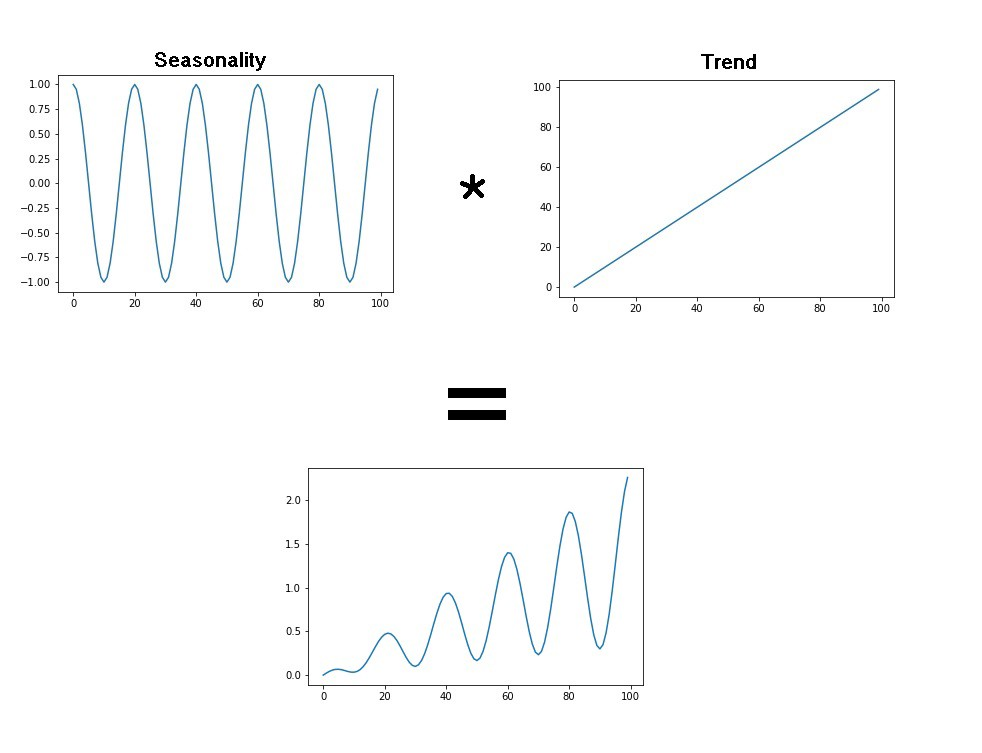

In [37]:
#remove source name with , - e.g., "data:image/png;base64,"
base64_data="/9j/2wCEAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRQBAwQEBQQFCQUFCRQNCw0UFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFP/AABEIAvED1gMBIgACEQEDEQH/xAGiAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgsQAAIBAwMCBAMFBQQEAAABfQECAwAEEQUSITFBBhNRYQcicRQygZGhCCNCscEVUtHwJDNicoIJChYXGBkaJSYnKCkqNDU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6g4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2drh4uPk5ebn6Onq8fLz9PX29/j5+gEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoLEQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2dri4+Tl5ufo6ery8/T19vf4+fr/2gAMAwEAAhEDEQA/AP1TooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr5+/aS/a0g+Bninwn4G8P+ENQ+JHxN8WbjpHhnS7uGDCK6BpbmRiWgiKmZlkMbIfs8u5kVGZfoGvj/8Aar8C/D34p/tHfDXQ9O+JeofDH9orT7OS/wDDF/pekm58+1LSPItyTGEliCW14qxNOi/vZdyuJCrAHVfBX9sW88bfGW6+EXxI+HWofCf4kLZNqllp95qlvfWeo2oEZBt7lNnnSnMxKRoyqtvKS+5HVfpavgrSviT41+AP7UXw18L/ALQfh/wR461PxRNPpPhL4v6bpyW+rxDzJlW3niWEsjO13bR7YvLiRbliZJv3jD5r8XaR41/bB/ai+Ptvqvwu1j4yab4T1O50DStMsfHCaFaeGxvktkuoYrjzFaeRbFXO390XEhkjYMgQA/Ymivz1svHfjX4A/sDX9h+1FrPjfwprh8QDStN1fwhrSXXiS8ieRLuNheedKitlbqMl3QeRDsA3Fd/hf7HNh4n+BH7e3w68JWHg7xB8JPD/AI38M/atS8K61rkWqvqEcVjdtDdS4hjMEpmtyxjZFkjczqNkcnlAA/X6ivy1/ap+BfiHwd8efHHxK+LXhrxv8SPBd3PbXvh74g/DzUxbav4Ft7b7RcCCOyyUCoUQNO+I1XM28Tyso6v9sf4lw+N/Bv7KPwz8EfEHWNW+HXxJ1OLSNT8VWepSDVdUs0NrZSJPLwrNIt5MZo5ojmWNQyqVZSAfo/RX51+B/DVp+yJ/wUr8H/Cb4cTahp/w38b+GZ9RvPDV7qNxc2dndCO5Jnt0eTiVv7MhBeTzG2ySqCFKhPlX9lP9kP4efFv9hP43/E3xDbahN4u0D+0P7Ku4Lwxx2f2Kwiu1xGBtfzWkKSeYG+QDZ5bZYgH7fUV+Wuu/tBWXjD/gnR8HNO+JXiP4j69428aTajp+nWXga6WDUvEBt5rmzW1u5mjdZIHWW2jkBWSWRmRtkpD1b/4JxN4n+F/7anxa+E0uh6h8PvCy6M2vN4Du9ai1hNNumex8tkukUBv3NyRkfMU8pZDI0QYAHv3wW/bf8d/tEfAO6+IPw++CX/CQaza+Jm0Gbw3/AMJZBbbYFtY52u/tM0KKcNLHH5YUn5twOAQPX/DP7T/hbxT+0t4s+CFpp+sR+LPDWmJqt3eTQxCxeJltmCxuJS5b/S4uCgHytzwM/jH/AM4sv+6zf+4Ovr/4d/ATwL4o/wCCs3x38N6poX2nRj4Zu9QNt9rnT9/qNtZR3r7lcN+8XUbwYzhfNyoUqm0A/T+ivxr0v44eJ/gV+xx8WP2YdTOoS/Fey8TDwlomnWNhE/2qw1B2eX7PG4WeaKUJeYk8ot/xMLTaRvXy/wBR/wBmz4QxfAX4DeB/AUcdvFcaLpkcV61pNJLDJeNmS6kRpMMVed5XAIGAwAVQAoAPTaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArz341fHvwL+zx4WtfEnxB13/AIR/Rbq9TT4bn7HPc7p2R5FTbCjsMrFIckAfLjOSM+hUUAfKv/D0f9mL/opn/lB1P/5Gr374XfFLwx8aPAmmeM/Bmp/2z4b1Lzfsl79nlg8zy5Xif5JVVxh43HKjOMjIINfFnwc/5TJfHX/sTLb/ANFaNVr9q34u/G+b9un4cfBf4XfEK38Dad4k0CO+uJrnSbW9WJllvnnlAlhZ2bybUBY9yqWVQSu5mAB960V+av7R/wC214v+H3x10/4KS/GHT/hra+GdGsn8S/Ea88IHULzU9SNqJGW3s4vNiEUongcqVjKMkoEhAVJMrw7/AMFDfiH42/Yn+NeuW+uaenxI+Hl7pNrb+KtH0sLZ6haXF3DbrciK5U5kk8u7Zg0ESqske1FbIUA/T+ivy18YftC/tPfs2fBj4PfHTxf8TNH+IfhnxTPbtqPg1tFtrErFc273ECrdRQK5YwoxZgFEcoQbZ03Z90+KPxx+K3xe/bH1P9n/AOFHi7T/AIa2nhnRota13xNe6LHqN5I5RD5NvHI7RSRML2zzuWNwySkOQAsgB9KfDj49eBfi34q8aeG/Ceu/2rrPg29Gn67bfZJ4fsc/mSxhN0iKsnzQSjKFh8uc4Iz6FX5v/wDBKKz8Rad8Z/2qbTxdf2+qeLLfxBaRaxfWihYbm8W51MTyIAiAK0gcgbV4I+UdB+kFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFeTW2tfEPxZ408cWeia74Z0bStB1WLTYItQ8P3N7PIG0+zuWd5EvoV+9csAAgwFGSTk0Aes0V53/YfxZ/6HbwZ/wCEfd//AC0o/sP4sf8AQ6+Df/CPu/8A5aUAeiUV53/YfxZ/6HbwZ/4R93/8tKP7D+LP/Q7eDP8Awj7v/wCWlAHolFed/wBh/Fn/AKHbwZ/4R93/APLSj+w/iz/0O3gz/wAI+7/+WlAHolFed/2H8Wf+h28Gf+Efd/8Ay0o/sP4s/wDQ7eDP/CPu/wD5aUAeiUV53/YfxY/6HXwb/wCEfd//AC0o/sP4s/8AQ7eDP/CPu/8A5aUAeiV47+0N+y14L/aUt9Bk8SyaxpeueHpjc6H4h0DUXtL7S5Wkhd5ISMpuJt4xudGK4JUq2GG9/YfxZ/6HbwZ/4R93/wDLSj+w/iz/ANDt4M/8I+7/APlpQB5v8Kf2HPBXwz+J9p8RdR8TeOPiN420+D7Npms+N9fe+m06IpMjxxbVjBVluJMrIHAJyoUkknxW/Yc8FfEz4n3fxF07xN44+HPjbUIPs2p6z4I197GbUYgkKJHLuWQBVW3jwsYQEjLBiAR6R/YfxZ/6HbwZ/wCEfd//AC0o/sP4s/8AQ7eDP/CPu/8A5aUAeb2X7AvwbsP2e7/4OR6BcP4XvZhfy3c120t8uoiFIft8cjZWKfbGvCKsZyymPY7IeK8A/wDBMT4a/Dnx14S8Z6V4v+ID+KfDd5FcQanc61G0tzBFFDDFZTYhANssMJi2IEJjlkQsVCKnvv8AYfxZ/wCh28Gf+Efd/wDy0o/sP4s/9Dt4M/8ACPu//lpQB4x4+/4Jz/D3xh4p8W63pHiv4geAP+Ew81vEmneE/EJgs9YkleZ5HuI5Ul3bvtEi7MiMKSAgyxPf/EH9jr4U/Eb4IaX8Jr7w3/Z/gzR/3mlW2l3Elu9hOI5Y1uEYE+ZKPPlcmUSB3YtIHJJPUf2H8WP+h18G/wDhH3f/AMtKP7D+LH/Q6+Df/CPu/wD5aUAcZ8Cf2PPBXwF8Zaz40tNV8UeMfHerwm0u/FPi/WHvr6W2IhxASAiFVNvGQxQuAMbtuFFX4RfsVeCPgv8AAPxr8ItE1TxBdeG/Fn237ddahcwPeR/arVLWTymSFUGEjBXcjYYknI4rvf7D+LP/AEO3gz/wj7v/AOWlH9h/Fn/odvBn/hH3f/y0oA8i13/gnZ8JvE37Ovhn4PaoNYu9I8NTT3Gka+08I1e0aa4aeYLKIQhVy5VkMZUqqEjeiup8G/8Agnz4C+B3xb0/4keH/FPji58TxQ3UWpzanrCTrrjXDyvJJffug0rbpEIClV3W8TlS4Zm9d/sP4s/9Dt4M/wDCPu//AJaUf2H8Wf8AodvBn/hH3f8A8tKAPA/+HYHws/4UF/wqL+3vGH/CN/8ACTf8JX9q+2Wv2z7V9l+y7N32bZ5WznGzdu53Y4r1M/sm+ELf9p//AIXtp+peINK8Xz2f2HULKyvwunamnk+SDcRFCzYVYSFV1TdbxNtLAlup/sP4s/8AQ7eDP/CPu/8A5aUf2H8Wf+h28Gf+Efd//LSgD448A/CrWv2of2+dJ+OmofCTWPhx4F8M6YIV/wCEy0mC3vta1SKMiKWS2Zg6NGLlDHPiVR9gjAdWwsf6F153/YfxY/6HXwb/AOEfd/8Ay0o/sP4s/wDQ7eDP/CPu/wD5aUAeiUV53/YfxZ/6HbwZ/wCEfd//AC0o/sP4s/8AQ7eDP/CPu/8A5aUAeiUV53/YfxZ/6HbwZ/4R93/8tKP7D+LP/Q7eDP8Awj7v/wCWlAHolFed/wBh/Fn/AKHbwZ/4R93/APLSj+w/iz/0O3gz/wAI+7/+WlAHolFed/2H8WP+h18G/wDhH3f/AMtKP7D+LP8A0O3gz/wj7v8A+WlAHolFed/2H8Wf+h28Gf8AhH3f/wAtKP7D+LP/AEO3gz/wj7v/AOWlAHolFed/2H8Wf+h28Gf+Efd//LSj+w/iz/0O3gz/AMI+7/8AlpQB6JRXnf8AYfxZ/wCh28Gf+Efd/wDy0o/sP4s/9Dt4M/8ACPu//lpQB6JRXnf9h/Fn/odvBn/hH3f/AMtKufCLxNrHizwW95r72M2rW+q6pps0unW728EgtdQuLZXWJ5JGXcsKkgu3JODjAoA7iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD5e8AfsweKfCn7fPxJ+N91f6PJ4T8S+H4tKtLOGaU3ySrHp6lpEMQQLm0k5Dk/MnHJweP8A9mDxT4r/AG+fht8b7W/0ePwn4a8Py6Vd2c00ovnlaPUFDRoIihXN3HyXB+V+OBn6hooA+Sfi9+yx8RdJ/aWk+O/wP8QeF9M8V6ppkeja7oXi+2uHsdRiCkGczRMzowENkBHEsY/cbi53Or5XxG/Zn+P/AMZ/2ZPib4O8f/EbwvrnizxZPZS6Zplpp5s9I0JYdQE7xpcrEZ51eJYwDLGWVkALNkufsuigD4q/ab/Yr8cfGj9i/wCE/wAItE1TQLXxJ4T/ALJ+3XWoXE6Wcn2XTpbWTymWFnOXkBXci5UEnBwDv/F79lj4i6T+0tJ8d/gf4g8L6Z4r1TTI9G13QvF9tcPY6jEFIM5miZnRgIbICOJYx+43FzudX+tqKAPj/wDYM/ZT+Jf7O/ir4u+I/ibr2geINa8dXlrqD3OhSSNvnWS7kneRWgiVNzXIICDH3hhQBn7AoooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK4/4rw+Fp/h5rieNW0tfC/kZvDrTxrZ4DAr5hkIXG8LgHgnA5zXYUUAfKmg+MdK8RfsLeGLfQtctNTaDwnpCalFpV2s00dnGLdL8ERksCsQnVgOQQRweK5oHwN9u/e/2H/woD/hOX8vd5X9gY/sNcf8ATH7N9t8zH8H2nGPmxX2hRQB5h+z4+pD4FeF2lWWW4FiTZpqDsjtb7m+yiRiCwJh8rJILDkkE5FVPgbcaxdeIPivJrthZadqh8UxebbadePdwJjRtM27ZXiiZsrgnKDBJAzjJ9arzv4X/API7/F7/ALGmD/0y6XQB6CwAri/h949fxZd67peoWY0vXdGvGt7qz8zeDG2WgmRiBuR0wQcDkMMDFdqDXlXjJE8PfG/wHrkaiKPVobzQ7uXoHOwTwA+4aKUD/fOOprWlFTvHrZ6+mtvn+djmrSlTtJPS6TXq7X+T/C56vRRRWR0hRRRQAUUUUAed/Fn4qf8ACt7KxjstJn8Ra5fOxt9KtWCyvFGN80mSDgKgOPVmUDrx1vhnxBY+LNBsNY0y4W5sL6FZ4JV/iVuRkdiOhB5BBB5Fee+B4k8Q/Gnx/rrKJo9MW00G0l/ubY/PnA9MvMgP+4Kd8GIV8O+JPiF4VUCOLTtY+220SjCx291EswCjsBJ5wwOMg11zpwULJe8km35O33Wul63PPp1ZuopSfuttJdmr6363s/lY9XooorkPQCiiigAo6UgNZPirXIvDHhrVdXn/ANRYWs11J/uohY/oKEruwpNRV2cBc/HWxtfienhg2EjaQJk06XXg48iPUXUulqRjklRyQeGZVIya9THFeGaN8OG1L9lg6NJEH1jUdJfUZJGHzm+lBnEhPdhIV5zn5Rg8CvT/AIdeJf8AhMfAfh7XM86hYQXLY7MyAsPqDkGuutCCV6fR29bbP566eRw4epUcrVd2rryvuvlp9509FFFch3hRRRQAxuao6vq1roGl3mo38yW1jaRNNNPIcKiKCSSfQCrzH3ryv48Kdbj8H+FABKmu67bx3MB6SW0Ia4mBHcERAEf7VXThzyS6fp1/AxrTdODkt+nq9EvvLnwl+MEfxLa/t7nSbjw/qVvsuYrK7bLz2co3Q3A4HDAEEDO1gQT0r0joa8p+JqR+HfiV8OPEqoIt9/Lod0yjBeK4iYxqx7gTRxkD1bjrXqwOfxq60Y3UobPpvbpb8L/Myw8pWlCbu07X2vone3zt8h9FFFYnWFFFFADOprhvip8SD8PNHtjZ6bJr2vahMLfTtIgfZJcuAWfnBwqqCxOCBgDjIruO/XpXlWixR+JP2gvE1/KN8XhzS7XTYQeQk05aaUr6EoIQSOcYrWlFNuUldJXf3pL8WtjlrzkoqMHZt2T7aNt/cmd14M8W6f478LadrmmyF7O9iEihh8yHoyMOzKwKkdiCK3M4IFeVfDOJfDfxR+I3h1B5VtJcW2t2sfQEXEZWYgenmwuT7v6k16sG4pVYqE7Laya9Gk/wuVQm6kE5bptP1Tt+g6iiiszoCiiigCNjjtmlU8Zqvf3sOnWVxdzuEggjaSRj/CqjJP5Zrgv2fhe3Hwo0bUtQlkkvNW87VHMjFsefK0qgegCuoAHHFWoXg59ml99/8vxMnO1RQtum/ut/mekV518B/wDkSNS/7GnxH/6e72vRa86+A/8AyJGpf9jT4j/9Pd7UGp6LRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAYPjBtaXw1fv4euLG01hY91vPqdu9xboQQWLxpJGzfKDgB15xzjNeB3H7R3i+48AW3iiytNEii0XwBpvjzxHBPbTMbqO5Sd2t7QiYeSQtndENIJeTGCOrV9B+JdGn8QaDeadb6re6HNcJsGoaekLTwjIJKiaOSMkjI+ZGGCcAHBHktl+ynotr4c0nQ5PFnie8sLTSofD92sr2SnVdMhYmGzudlsoKIDIoaMRuVlkDO240APtvjD4kl+IEBMGl/8Ibc+KZvCccCwSfb0mjtpHN0ZfM2FDNE8flCMEKQ+8nKVf/ar8V6B4c/Z++INvresadpb6n4e1O0tIr+6jhN1K1pIBFGHI3scgbRknI45rXh+CWkwePv+En/tLVDEupPrEehGSL7AmoNbm2a6A8vzdxjZvkMhTcxcIHO6n/tHf8m8/FD/ALFbVP8A0kloAP8AhnH4T/8ARL/Bn/hP2n/xuj/hnH4T/wDRL/Bn/hP2n/xuvRaKAPOv+GcfhP8A9Ev8Gf8AhP2n/wAbo/4Zx+E//RL/AAZ/4T9p/wDG69FooA86/wCGcfhP/wBEv8Gf+E/af/G6P+GcfhP/ANEv8Gf+E/af/G69FooA86/4Zx+E/wD0S/wZ/wCE/af/ABuj/hnH4T/9Ev8ABn/hP2n/AMbr0WigDzr/AIZx+E//AES/wZ/4T9p/8bo/4Zx+E/8A0S/wZ/4T9p/8br0WigDzr/hnH4T/APRL/Bn/AIT9p/8AG6P+GcfhP/0S/wAGf+E/af8AxuvRaKAPOv8AhnH4T/8ARL/Bn/hP2n/xuj/hnH4T/wDRL/Bn/hP2n/xuvRaKAPOv+GcfhP8A9Ev8Gf8AhP2n/wAbo/4Zx+E//RL/AAZ/4T9p/wDG69FooA86/wCGcfhP/wBEv8Gf+E/af/G6P+GcfhP/ANEv8Gf+E/af/G69FooA86/4Zx+E/wD0S/wZ/wCE/af/ABuj/hnH4T/9Ev8ABn/hP2n/AMbr0WigDzr/AIZx+E//AES/wZ/4T9p/8bo/4Zx+E/8A0S/wZ/4T9p/8br0WigDzr/hnH4T/APRL/Bn/AIT9p/8AG6P+GcfhP/0S/wAGf+E/af8AxuvRaKAPOv8AhnH4T/8ARL/Bn/hP2n/xuj/hnH4T/wDRL/Bn/hP2n/xuvRaKAPOv+GcfhP8A9Ev8Gf8AhP2n/wAbo/4Zx+E//RL/AAZ/4T9p/wDG69FooA86/wCGcfhP/wBEv8Gf+E/af/G6P+GcfhP/ANEv8Gf+E/af/G69FooA86/4Zx+E/wD0S/wZ/wCE/af/ABuj/hnH4T/9Ev8ABn/hP2n/AMbr0WigDzr/AIZx+E//AES/wZ/4T9p/8bo/4Zx+E/8A0S/wZ/4T9p/8br0WigDzr/hnH4T/APRL/Bn/AIT9p/8AG6P+GcfhP/0S/wAGf+E/af8AxuvRaKAPOv8AhnH4T/8ARL/Bn/hP2n/xuj/hnH4T/wDRL/Bn/hP2n/xuvRaKAPOP+GcvhP8A9Ev8Gf8AhP2n/wAbpP8AhnL4TnGPhh4M/wDCftP/AI3Wx47+JWh/D22iOpTyS31y2y00yzQzXd2/92KIcsffgDuRXKaZ4a8Y/EXUrbVfFV1N4V0SCVZ7Xw3plx++kKkFWu51wTggHy0IXpkkitY021zSdl/WiXX8u7RzyrJS5Iq78unq/wCma3/DOPwn/wCiX+DP/CftP/jdcR8Wfgp8O/C3h7RdU0XwF4Z0fVLfxT4dMN9Y6PbwTRk6zZqSrqgYZBIOCMgkd6976V538eP+RI03/safDn/p7sqyOg9FooooAKKKKACiiigAooooAKKKKACiiigAooooAKKK8y+Pup3dj4K06C2vrnS4NS17StMvb6zmaCaG2nvYopAkikNGXDeWHUhl8zKkEAgA9NoryP4R27+I/BnizQNQ1PVL/StO1/UNLs9QOqXC3jW0cgIU3auJi0bmSHfv3ERYZick+W+FfBHizxr8JdD1rw5rGr32n6r4rufEMen6t411SzebRDbXFvaQpeqZZ1VgLS6KZ2lmbJA5oA+rq87+F/8AyO/xe/7GmD/0y6XV74XeLrTxd8LPD3iDS7O/+y3GnRyQWl1c/aLk7VxsM0jnzWJUjzGc7+GLHOa5z4G6rda1r/xYvLzR77QLiTxTFu0/UXgeePGjaYBuMEkkZyACMOeCM4OQAD1jdzXln7RcZtPAEWvoC0vh3UrPV1AH8McyiT8PKaTPtmvUguea5X4paMfEXw48U6Woy13pdzCvHdo2A/UitaMlGpFva6+7qc9eLnSklvZ29eh1EbCRQQcgjIIp+Olcl8KdZPiH4aeFtSY5a60y2mY/7RjUnP0ORXWg1nJcsnFmkJKcVJdULRRRSNBuKjmkWGNnYhVUElj0AqXdXHfF3WD4f+Fvi3UVIV7bS7mRCTj5hE20fngU4rmkordmdSShByfRHPfs5wm5+HC67IhS48Q393rDg+k07GP/AMhiMfhTJx/wj/7RtnJny7fxFoDw4H8c9pKGGffZcN+C113w20b/AIR34e+GtLYbWstNtrcj3WJVOfyrk/i4w0vxx8L9Z7Q629g3+7cWsqDPtuVPxxXWpKdWfRNP9Wl96RwuDhQh3Ti/xSb+5s9UopOtLXGekFFFFACY4ry79oudpvhrLokT7LjxDe2mjRkHHE8yK/8A5D8w/hXqGea8u+KoGp/EX4WaOwyj6tcai30t7WTB/wC+pE/HFb4e/Omul392v6HLiv4TXey+9pfqemQwpBAkUahERdqqOAAOgrzD9npv7O8Lax4bwV/4R3W73Tkz18rzTLF+HlyoB7CvVa8t8At/Zvxq+Jth9xLn+ztTjXsd8DQsR+NuM+5p0/epzXaz+d7fk2Kr7tSnJea+TV/zSPU6KKK5zrCiiigBOgryvUs+IP2i9Ht9u+Dw7oU94T2Wa5lWJPx2Qy/n716mGBry74dN9v8Ai/8AFHUgd8cdxYaZG3p5VsJGA/4FcGt6WinPsvzaT/Bs5K+rhF7N/km1+KRP+0RYS3Hwk1y8tVBvdJ8rV7c+j20izcfUIR+Jr0DTL6HVdOtby3bfb3ESyxt6qwyD+RFV/EelJr3h/U9Nf7l5bS25+jKVP865D9n/AFQ6v8F/Bs7Z8xdNht5N3XfGPLbPvlDRrKj6P8/+GD4cR6r8n/wT0OiiisDrCiiigBjcDNeXfABTqeg+IvErHd/b+u3l3Ex6mFJPs8X/AI5CCPrnvXdeMdZXw94U1nVD0srSW5P/AABC39K5z4FaSdD+DngyzIIkXSreSQHrvdA7/wDjzGt42VKXdtfdrf8AQ5ZXdeK6JN/N2S/Ux/Eo/sH9oHwfqIB8vXNLvNIkPbfEVuIvxwJwPqa9SHevLfjpusX8BauuR9g8UWYdh2SYPbn8P3wr1MdPrRUs4xa/p3/yaCleNSpHzuvRpfqmOooorA6gooooA83/AGhNSl074QeIYbb/AI/NQiXS7cDqZLl1gGPceZn8K7nRNKh0PSLLT7ddtvaQpBGPRVUKB+QFedfG5W1HU/h1pCHLXnia3mZPVLeOW4J/AxLXqKsCK3lpTivV/p+jOWGtaUuyS/X9UPrzr4D/APIkal/2NPiP/wBPd7XotedfAf8A5EjUv+xp8R/+nu9rA6j0WiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvOv2jv+Tefih/2K2qf+kktei151+0d/ybz8UP8AsVtU/wDSSWgD0WiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAQcUcCiuJ8efFPR/Aj29nN52pa3d5+x6Npy+bd3B9Qg+6owcuxCjBye1OMXN2itSJzjTXNJ6HXXE8drFJLNIsUSKWd3OAoHUknoPevKrn4oa18RbqXTfhtbxS2aOY7jxZfITYwkHBFunBuXHPIIQEDLHOKbB8N9f+J08d98Rpkt9KDB4fCGnzZtx3H2qUYM7A4+UYjBHRs16ra2kGn20VtawpbwRKEjiiXaqKOgAHQD0ro9yl/ef4L/P8vVHL+8r94x/F/wCS/H0OP8C/CnSvBVxNqbyT634juhi61zUmElzL/sqekaDsiAKABwTzXcHNL0GaO9c8pSm7t6nTCnGmuWKsh1edfHj/AJEjTf8AsafDn/p7sq9Frzr48f8AIkab/wBjT4c/9PdlSND0WiiigAooooAKKKKACiiigAooooAKKKKACiiigArP1jRdP8Q6ZdaZqljbanp11GYrizvIVlhmQ9VdGBDA9wQRWhRQBgaV4I8O6JZRWen6BpdhaRWpsY7a1so440tySxhCqAAhJJKgYJJOOar678OPCPirQ7HRNa8L6Lq+j2O37Lp1/p8U9vb7V2L5cbKVXCkqMAYBIHFdPRQBVtLSHT7aG2toUt7aFBHHFEoVI1AACqBwAAAAAMcVwvwv/wCR3+L3/Y0wf+mXS69Erzv4X/8AI7/F7/saYP8A0y6XQB6JTJFDIRjIOeDT6Q9KBPU8v/ZwJh+E2naa5Pm6Tc3mmOCenk3UsYH/AHyq16gOleWfBVf7N134laSTg23iSW5VfRbiCGYfmzua9TPSt67bqyk+uv36nNhtKMY9lb7tBaKKKwOobivLv2jj9p+Ft1pS/wCs1i+sdMQevnXUSsP++S1eonoK8s+Mqf2l4n+Gejr1uPES3bD1S3t5pT/48EP4Vvh7qqmumv3anLiv4Ml30+/Q9RUYQV5h+0Wq2vw6TWMZfRtV07UR7CO7i3H/AL5LV6gORiuJ+NukDXPhF4ysgu55dJudg/2hGzL+oFKi0qsXLa6v+o8RFyoyUd7O3rbQ7ccjNOrA8D61/wAJF4M0LVM7vttjBck+u+NWz+tb2ayas7G8XzJMWiiikUIeleWak51X9pLRrdhlNI8N3NyP9l7ieNB+awv+VepjvXl3gn/iY/HX4j3j8/YbbTNNjPoPLknb9Zl/Kt6S0lJdF+bS/U5K+rhHu/yTf6Hp+Aa8tnB0v9pS0cnEWreGJIvq9vcqw/8AHbhvyr1PPWvLviYf7P8Aip8K9U6Kb6901z7TWrMB/wB9QLRQV5OL7P8ABNr8R4jSKl2a/Fpfkz1OiiisDqCiiigBh+6a8u+AK/atE8T6z1XV/Emo3KN/eRJjCp/75hA/CvRtXv00nSry9k/1dvC8rfRVyf5Vwn7O9ibD4JeDg5zJPYJdufVpsysfxMhP41tFJUZPzS/O/wChyz1xEV5N/PRfqz0c9CK8t/Z6YW3hPWtH6Lo3iDUrNVPUIbhpU/8AHZAfoRXqQPBry74Xj+zfih8VNJTiIajaako/672qBj+LQt+VOneVOaXSz/G36hU0qwl3uvvV/wBD1OiiisDqCiiigDzP9ou8e0+CnitIT++urUWCe7TusIH4mTFehafZR6fYW1rEMRQxrGg9ABgfpXmvx6JubPwZpI5TUvE+nxOvqsbm4I/8g16kOFFbyaVKK83+lvyZyw1rzfZJfm3+aPM/2j7eST4L+JZ4Rmawji1FMdQYJkmyP+/Zr0a1nju7aKeM7o5FDofUEZFY/j7Rx4h8D+INLIyL3T57bH+/Gy/1rJ+C+rnXPhJ4OvmbdJNpNszn/b8pQ36g0auil2b/ABS/yDbEPzS/Bv8AzO2ooorA6gooooA8s8XY1T4++ALJTn+zdP1LU3X03CKBD/5EcV6ie1eW6Kg1X9o/xJcggjSfD9lZ49GmmnkP5iNPyFepCt6ra5Yvovz1/U5aGrnLu/ySX6Dq86+A/wDyJGpf9jT4j/8AT3e16LXnXwH/AORI1L/safEf/p7vawOo9FooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiivLfjv8R9X+HWmeHH0cRJJquqiwmun0m51d7aP7PPLuSxtnWe4YtCqkRnKKzSEFUagD1KvOv2jv+Tefih/2K2qf+kkteT+Bf2k/F3i7SLDxRJZ6FB4dtdW0Tw9qtlCkklzNd6ilmRNDMJdkaI2o2oMTI7cSguCoz3/AO1R4u0Pwx8AfH8Ota1p+kzaj4e1O1so766SFrqU2sgEcYYguxyAFXJORxzQB69RRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAwkDHHFVdQ1C10mylu725itbSFS8s07hERR1JYkAD3Ncd47+LOmeENQj0azt5/EPim4Xdb6Hp2GmI7PIT8sMfIy7kDGcZxisGw+Feq+PbyDVviVcxagiOJbbwxZk/2dakdDJ0NxIPVhtBJwvQ1tGlZc03Zfi/Rfq9PM5ZVm5OFNXf4L1f6LUhk8f+JPiu7WngCL+y9CyVm8XahBlXH/TpC2DKf+mjYQYOA3Fdh4F+F+ieAEnlskmvNVu/mvNXvpDNd3bccvIe3HCjCjsBXWRQrDGqIoVAMADoBT8ccUpVbrlgrL+t3+m3kOFGzU6jvL8F6Lp+Y+iiisjpCiiigArzr48f8iRpv/Y0+HP/AE92Vei1518eP+RI03/safDn/p7sqAPRaKKKACiiigAooooAKKKKACiiigAooooAKKKKACvPPjV4k1Tw74UsI9FvDpmoatrOnaQuoLGkjWqXF1HHJIquChcIXC7gV3lSQwBU+h1ieK/Cml+NtBudG1q2N3p9wUZkWV4nV0dXjdJEKujq6IyupDKyggggGgDyi28RePdX+DPxFsdEv7jV/HOhXuoaTpeprFaxz3kkeGgcq6rbiQLIqMSqoWQnaoOBj2vj3XNdbw34OsPFHifR9bufENzpms3+uWemf2rYeVp7XiwIIYWtGLq1u4cLINjOM7hlPVtM+FHh3SPD0miWKalZ2EiSRyC31i9SZmeUzSSmYSiQzM7FjMW8wknLEGqDfAjwafD/APZH2C+EX9oHVjfLq94uoG8MflGf7aJhceYYv3e7zM7Pk+7xQA/4O+NL/wAW/CfRte1kifUPIkS7ltYCRPJDI8TyJGoJ+cxlgq5PzADPFYvwN1+28T+IfixqVnFfQ28vimLamo2E9lMMaNpindDOiSLyDjKjIwRkEGvRfD2g6f4W0PT9H0m0Sw0ywgS2tbWIfLFGgCqoz2AAHP41yHwv/wCR3+L3/Y0wf+mXS6APRKKKKAPLfBn/ABL/AI8fEa1b5fttppd+g9fklhY/+QlFepV5VMGsP2mLduiah4WdM+rQXSkD8pzXqY7VvWd2peS/BW/Q5cPopR7N/i7/AKjqKKKwOoSvLvF//Ex+Pnw+tV5+wafql+49MiCFT/5EYfjXqLV5ZaKb/wDaW1CQcpp3hiGIn+601zIxH4iBTW9F2cpeT/HT9TlxGqjHu1+d/wBD1SqupWSajp9zay/6ueNom+jDB/nVqkboawOlq6sebfs6Xj3nwP8AB/mf6yCxW0cehiJiI/ApivSAMivLP2fZRaeENZ0rjbpXiDVLRR6L9qkkH6SA/jXqQbHFbV7e1k1td/noc+Gb9jC+9l94+iiisTpG9K8t+CLfbtW+I+pkZNx4nnhDf7MMMMIH4FGr1Et8przD9nEC5+GiamR+81TU9Rv2PrvvJSD+KhTW8U1SlLzS++7/AEOWprWhHyb/ACX6nqA4NeWfHxPI0zwdqQ4XT/FGnSsfRXl8lj+Uxr1M4HavMP2k4ifgr4jnjBL2aQ3y465hnjl/9kooJOrGL6tL7wxP8Gb7Jv7tUeoDpS1FFIs0SOhDIwBUjoRjINS1gdKCiiigZwvxz1L+yPg740uw2100i6CH/aMTKv6kVveDNK/sLwjoum42mzsoYMem1FXH6VxX7SI+0fCe/wBPH39SvLGwUevm3cSkf98lq9OXlR9K3aSop92/wSt+Zyx1xEvJL8W/8kLjAry3SH/s79pHxBbjhdT8OWdyf9poZ5kP5CRfzr1PPNeW+Jdum/tDeDLoYzqWi6lYk+6Pbygfo360Urvmiuqf4a/oFf3eWXZr8dP1PU6KKKwOoKKKKAPLfiT/AKb8W/hXp55QXd/fsP8ArlaMgP4NMv516j0OK8s1J/7Q/aS0SE8ppnhu7uB7NNcQoPzEbflXqXVq3qtOMEui/Vv9UctH46j7v8kl+aYMOCa8v/Zs/cfCTTLBuH025vLBh/d8q6lQD/vkCvUDyK8s+BebWb4gae3/AC6+Kr0qD2WURzjH/f00Rf7qUfNP7r/5hPStCXk199v8j1WiiisDqCiikY8GgDy74XY1D4mfFTUxyh1S1sF9vJs4iR/31IT+Neofw15b8AFM+j+LNS6rqPifUpkb+8qzGFT+UQH4V6nnrW9dt1Nell9yscuG/hJ97v722LXnXwH/AORI1L/safEf/p7va9Frzr4D/wDIkal/2NPiP/093tYHUei0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXH+PPh1B47k0a5XV9T8P6to9y11Y6ppRhM0TNE8TqVmjkjZWSRgQyHBwRggEdhRQB434f/AGYPDPhm9sDYanrcemQXNrqN1pDzxNbajf2+DFeXBMZkMoZImOx1QtFGSp2gVv8A7R3/ACbz8UP+xW1T/wBJJa9Frzr9o7/k3n4of9itqn/pJLQB6LRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAMPAozhaO2c1554z+Llrouqnw9oFnN4q8WsoI0qxYAW4PR7iQ/LCvTluTkYBzVQhKpK0V/Xr0M51I01eT/wCD6HZa1rVh4c0241LVLyDT7CBS8txcSBEQepJOBXl//CU+LfjA3leElm8K+E34bxHeQ/6Vdp/06QuPlUjpK475VSRmrui/CG78Qanb678RL6LxFqcLeZbaTChXTLBuxjjPMjj/AJ6SZPoBgV6mBjgdK2vCl8PvP8F6Lr89PJ7nNapX+L3Y9k9X6vovJa+hzHgj4c6H8PbOSDSbUiedt91e3DmW5upO7yytlmY5J5OBk4AHFdR0zS57UlYSk5O8ndnXGMYLlirIfRRRSKCiiigAooooAK86+PH/ACJGm/8AY0+HP/T3ZV6LXnXx4/5EjTf+xp8Of+nuyoA9FooooAKKKKACiiigAooooAKKKKACiiigAooooAKKK4f4teMdR8GeGLWTR47V9Y1LU7LSbJr1GeCKS4nSIyyKrKzKis77QylioXcudwAO4orzbwL4s8UeMvCHiC2aXSbXxho+qXOkSXn2SVrB5I2UpMIPN3hWidGMfm5DErvIG4+c33xt8dr4Wgnsk069eHxhPoF14j0vwzf6naS2cVlLK11HZW85mG25QWrHzWUMjnOCAAD6Przv4X/8jv8AF7/saYP/AEy6XXSeF/EdrrHgvTdc/tiw1Kynso7ptWtEMNrMpQM0qKzsY0PJAZmKjgsSCa4b4G+JdJ8XeIfixquharZa3pc3imIRX2nXCTwybdG0xW2uhKnDAg4PBBHUUAes0UUUAeW+PT9j+Nvwwu+izjU7Bj67rdZQD+MBx9a9QHWvLPjgxtNR+HN+vBt/FFtGW/2ZYpocfiZFr1Ra3qPmhD0a/Fv9TlpaVKi80/wX+QtFFFYHUNx1ry74en7Z8ZPiledVjfTbBW7fu7YyED6Gc5r1EnrXlvwNLXN18Qr48/afFV4oPtEscI/WI1vTdoT81b8U/wBDlrLmqU/Jt/g1+p6pRRRWB1HlnwiUad41+KWl/wDPLXo7wD2ns4H4/EH8c16kDmvLvCn+gftAePrY8fb9M0u+Ueu37REx/wDHFH4V6grZxW9e3Ordl+Sv+Jy4fSDT6N/m7fgOooorA6jK8T6oNE8N6pqJ4Fpayz/98qW/pXKfALTRpXwV8E2+CG/sm3kYHrudA5z+LGk+Puof2b8FPG0+cH+ybiMH3dCg/VhXW+GdNGi+HtM08DH2W2igx/uqF/pW+qo+Tf5L/gnLviPRfm/+AabVyXxX0s618MPFtgoy1zpN1EB7mJgP5iutz1qG7hS5t5YXGVkUqw9QRg1jF2kmbTipRa7o5z4Xan/bfw28LagTk3Wl2s5Pu0Sn+tdTXmX7N1w03wR8KJIf3ltbtZt9YZGiP/oFemdhWlaHJVlHs3+BFCXPShJ9UvyHUUUVkbnlXxyU3d38PNPXk3Xim0cj/ZhSScn6AxCvUsV5f8QQbr4zfC206iN9TvmH+5bCMH8DOK9R6VvUjaEPNX/Fr9DkpPmqVPJpfgn+oeleW/FfGnePvhXqp6R61NYn6T2cwH6qP0r1InpXl37QKeT4e8NaiemneJdMuGb0U3KRt+khH40UL86S63X3q36jxP8ACb7Wf3O/6HqXWlpq9BTqwOoKKKTpQB5b4YVdT/aE8cXR66dpGm2Kn03tcTEfqp/EV6gq15f8JmF/48+KeqdpNbhsgfaGzgUj82P4k16itb17KaS7L8lf8Tkw2sG31b/N2/AOleXfDwfY/jL8UrLokkmm36j/AK6WxjJH4wHNeokV5bZObL9pXUoxwmo+GLeUj1aG5lUn8BKv50UnaM491+qf6DrL3qcuz/NNfm0eqUUUVgdQnXNRXEywQySOdqIpZmPYDk1JurlvijqX9j/DXxXfhsG20q6mB91iY/0ppXkkRN8sW+yOb/ZsheP4KeGZpBiS7ikvWz1zNK8p/wDQ69N21yfwo006P8MfCVkww1vpVrER7iJQa6wGtK0uepKXdtmVCPJRhHskvwHV518B/wDkSNS/7GnxH/6e72vRa86+A/8AyJGpf9jT4j/9Pd7WR0HotFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFedftHf8m8/FD/sVtU/9JJa9Frzr9o7/AJN5+KH/AGK2qf8ApJLQB6LRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRSdKAE7e3rWN4l8V6V4O0WfVdb1CDTtPh5e4uH2gHsB3JPQAZJPABrj/ABV8X1TWJfDfg6wPirxQh2zRRPstLA/3rmbBCY5OwZc4wBzmo/DPwhabWIfEnjbUB4q8SxndBuj22Onk9raHJAI4HmNlzgHI6VuqSilKo7X6dX/wPN/K5ySruT5KKu+r6L59X5L5tGV/aPjL4ynbpn2vwJ4Ofg6hKm3Vb5fWFD/x7oecOwLnggDNegeDfAuh+ANK/s7Q7COxhLb5GGWkmc9Xkcks7HuWJNdCRnvQCWGamdRyXKlZdl/W/wDSKhRUXzyd5d3+i6D6KKKyOkKKKKACiiigAooooAKKKKACvOvjx/yJGm/9jT4c/wDT3ZV6LXnXx4/5EjTf+xp8Of8Ap7sqAPRaKKKACiiigAooooAKKKKACiiigAooooAKKKKACub8e+CrLx/4efSL24urLE8F3b3tiyrPazwyrLDLGWVl3K6KcMrKQCGBUkHpKKAPM4/gpDb+Bda8MWvi7xLZjWI7k3urW0tsl+888heW6EggwkpBKDaoRVACqpUESaR8I7zw94JsPDOlePvEenQWDr9mu7W00pJIoFjEa2wQWXkiMY3AiPfn+LGBXpFFAGD4M8Iaf4C8K6X4e0pZV0/T4FgiM0heRsclnY8lmJJJ7kk1zPwv/wCR3+L3/Y0wf+mXS69Erzv4X/8AI7/F7/saYP8A0y6XQB6JRRRQB5d+0aBb/DYal/Fpmq6bfD22XkOT+AJP4V6cgAX1rzz9oaxOofBHxtGCcppc04x1zGu8Y/75rt9E1Aato9lfL924gSYfRlB/rXRLWjH1f5L/AIJyx0xEvRfm7/oX6KKK5zqGuODXmH7OJ+0fC631D+PUtR1C+Y+u+8mIP/fOK73xHqQ0bQNSvz0tbaSYk/7Kk/0rkP2frAaZ8FPBMPc6TbykHrl0DnP4sa3i7UZebX4J3/Q5Za4iPkn+LX+TPQ6KKKwOo8qnH2L9pizc/KuoeFpY8+rQ3SED8pmr1QdTXlvj3/RPjf8ADC6BwJ01SxY+u6BJQP8AyAa9SreqrRg+6/Vr9Dlov3px7P8ANJ/qLRRRWB1Hl37SH+kfCy7sB9/Ub+wsVX18y8hUj/vkmvT1HSvK/jpuuZvh9YKM/afFVkSPaISTn/0UK9UzxW8nalGPm399v8jlhrWm/JL7rv8AUdTX+6adRWB1Hln7PbiDwrrumjhdM8RapaqPY3Ukg/MSA/jXqWOK8s+ECjT/ABj8UdM6NF4gW7A9BNaQP+pyfxNepg5revf2jb66/ernLhf4SXa6+52FooorA6jyu/b7d+0ppEJ5TT/DNzOPZprmJR+Yib8q9SIxXl3hsf2j+0N41uTj/iXaNptkD/vvcSn+n5ivUutb1k04xfRL8df1OWhqpS7t/hp+ghFeZftKRs/wU8TyoNz2sUV6APWGZJf/AGSvTW4rkfi5px1j4WeL7IDLXGk3Uaj3MTAfripoy5KsZdncrER56M4rqn+R1MEqzQo6ncrgEH2qXt9a5r4Z6n/bPw78L6hnP2rTLafP+9Erf1rpM4rOWjaNYPmin5D6Q9DS1HI4jjZycKoJJPp3pFs8v/Z/TztE8U6j1XUPE2pzo3qqzmJf0jA/CvUiMV5j+zWjD4KeGp3GHu0mvTn1mnkl/wDZ69OByRW+IXLVlFdG19xy4X+DB90n9+oE9a8u8Tgad+0J4HuQP+Qho+p2TH/ca3lA/Qn8DXqBOa8v+KrCw+Inwr1I8BNYuLI+/nWcwA/NAfwp4ezk79n+Tt+IsTpBPzj+av8Agep0UUVznWMfsfSvNf2kLloPgh4tWPh7i1FovuZXWID8S+K9LbBNeW/tCMLjwloulnpqfiHS7Uj1H2uNz+iE1vQ0rRb2TT+5nLiv4M0uqa+bR6ZZwJaWsMEYxHGgRR7AYH8qnxmhegpawOlaKwV518B/+RI1L/safEf/AKe72vRa86+A/wDyJGpf9jT4j/8AT3e0DPRaKKKACiiigAooooAKKKKACiud8f8Aj7w98LfBureK/FerW+ieHdKhNxd31ySFjXIAAABZmZiFVFBZmZVUFiAcn4R/GfwV8evBsfirwF4gt/EWhPPJbG4hR42jlQ/NHJHIqvG2CrbXUEqysAVZSQDuKKKKACiiigAooooAK8t+OfxVuPhnZeGrWwMUWqeIdUOm208+n3GorAFt5rh3FrbETTttgKiOMg5cEkKrV6lXKePPAdv45g0snUb7RtT0m8+3afqmm+UZ7WYxSQsVE0ckbBoppUIZGGHJABAIAPHdG/aC8Q6xO2s2V94f1nwfpeu6P4Y1Ce1sJ4Z726v1s8XEBadhAkbajagwusjfLKC6kAV1/wC1R4u0Pwx8AfH8Ota1p+kzaj4e1O1so766SFrqU2sgEcYYguxyAFXJORxzUOgfsweGfDF/ZyWWqa2NPS9g1W90mSeJrbU9RhO6O9uCYvMMocRuQjohaKMlDtFb/wC0d/ybz8UP+xW1T/0kloA9FooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAGAdKU8Gmk/lXl2u/F241nVZ9A+H1hH4l1qJjHc37uV03Tz/02lH32H/PNMscHJXFXCnKd7Lbd9Pm+hjUqxpq8nvsur9Edr4v8b6L4D0h9T13UIrC1BCrvJLyN2RFGWdj2VQSa88+zeNPjKN119s8BeDX6WykLq18v+2R/x7Ie4GZCMglc1ueEfhBb6VrCeIvEl9J4r8WEEDUbtAsdqD1S2hGViX3GWPOWOa9DxgVrzwpfBq+/+S/V/cjDkqVv4mi7J6/Nr8l97Mfwr4O0fwTo8Wl6Jp8Om2EfKxQLjJ7sT1Zj3JJJ7mtoHn2o9KRhjpXO23dt6nWoqKSirJD6KKKCgooooAKKKKACiiigAooooAKKKKACvOvjx/yJGm/9jT4c/wDT3ZV6LXnXx4/5EjTf+xp8Of8Ap7sqAPRaKKKACiiigAooooAKKKKACiiigAooooAKKKKACuH+LXjHUfBnhi1k0eO1fWNS1Oy0mya9RngikuJ0iMsiqysyorO+0MpYqF3LncO4rm/Hvgqy8f8Ah59Ivbi6ssTwXdve2LKs9rPDKssMsZZWXcropwyspAIYFSQQDzs/GTXNM+FHinVb+10+68V6Fq7+H8W6SQ2dxdNPHFbS7C7OiMLiFmXcxXLAMcAnJHxb8cS69/wgaS6APGS+Im0ltaOnT/2f9mGmLqHni0+0b9xDrDs8/GcvuwAh7O2+B2lJ4K1Xwxd6tq+oWWq+dNe3Fw8K3E13LKZTeb0iXbMrbdoUBFCIAgCiqZ/Z/sBYBx4n8QDxL/bB1w+Kg1p/aBuja/ZCSv2f7Ps+zARbPJ24AON4DUAdF8MPHp8bfDXSfEupxwabO8Dm+VZP3MM0TNHMVZsfIHjcgnB24JxXN/A3xLpPi7xD8WNV0LVbLW9Lm8UxCK+064SeGTbo2mK210JU4YEHB4II6iu78GeEtP8AAfhTS/D2lrKLDToFgiMz75HAHLOx5ZmJLMTySSe9cz8L/wDkd/i9/wBjTB/6ZdLoA9EooooAwfHGmf234M13T8Z+1WE8GP8AejZf61ifBHUf7V+D/gu6J3O+j2u4/wC0IlDfqDXauMKfpXmX7NZ8r4NaHaN9+xku7Eg9R5V1LGB+SCt0r0W+zX4p/wCRyvTER80/wat+bPUaKKKwOo4P466h/Zfwa8bXOdrLo9yqn/aaJlH6kV0XhDTP7F8KaNp+MfZbOKHHptQD+lcR+0mPP+EOqWI5bULmysQPXzbqJCPyJr05eUH0roatRT7t/gl/mcsdcRLyS/Fv/JD6KKK5zqPK/jW32HXPhtqI6weJooCfRZoJ4j+ZZRXqPU15h+0UFt/ANrqnGdL1vTL0H023kQJ/Jj+Ga9PB4X6VtNN0oy82vus/1OWGlacfJP77r9B9FFFYnUeW/Eb/AEz4v/CqyPKLc6jfMv8A1ztSgP4GYV6gK8t1VxqH7SHh+3bldN8OXtyPZpZ4EH5hG/KvUh2rerJcsEui/Vv9UctH4qj7v9EvzTHUUUVgdR5b4NH2H48/EW3PH2yx0q+QeuFniY/+Q1H4V6gB0rytwbP9plD0F94VI9iYbsfric16oOtb1nzNPyX4JL9Dlw+ilHs3+Lb/AFHUUUjHg1gdR5d8LcX/AMSfirqS8q2rW1ivt5NnDkfnIT+NeojpXlnwDUzad4x1A8i+8U6lIreqpL5Kn8ohXqWa3rtupr0svuVjlw38NPvd/e2x1VtQtUvbKe3k/wBXKjRt9CMH+dWaRhwaxR0tXR5p+zjdvdfBDwh5n34LIWrexiJiP5FMfhXpKnP415f+zyy2/gvVNMXppmv6paD6C8lYfo4r1AEAitcRb20rbXf5nNhm3RhfsvyFxk1zfxI1P+xfh94l1DOPsum3E+fTbEzf0roweTXm/wC0ZdtZ/BDxkY/vzWD2qj1MpEQH478fjU0o89SMe7S+8uvLkpTl2T/I2Pg9px0r4UeDrIja0Gk2qN9REuf1zXY4qtptolhY29rH/q4Y1jX6KMD+VWKibvJyLpx5YKK6Kw7HWvLPj8vk6V4R1DoLDxRpsrn0VphEx/KU16n2zXl/7Sin/hTHiG5UHdZfZ70EdQYbiKXI/BDW2HXNVjHu0vvMcTpRm+yv92p6gOlLTEYMgI5BGQR6U+sDqGkDmvLfjEgv/Ffwv0wctL4i+1FfUQ2s7n8jg16nkGvLvGf+nfHj4cWw+b7HaarfMPT5IYlP/kVq6KCTm79m/uTt+JyYn4Eu7S+9q/4HqI4paKK5zrCvOvgP/wAiRqX/AGNPiP8A9Pd7XotedfAf/kSNS/7GnxH/AOnu9oA9FooooAKKKKACiiigArwj9qj9sfwH+yHpfh+78aQ6xf3GuzyxWVjolqs0zLEqmWQmR40CqZIgQW3EyDCkBivu9eUftCfsx/D39p/wtDonj3RPt/2TzW0/UbaUw3mnySIUMkMg/wCAsUcNGzRoXRtowAfK37bX7U3wp/aI/YV+K6fD7xrp/iC6tf7PM1htktrxEXU7HdL9nmVJTEDKi+YFKbm27sggeK/8E6v2v/hr+yv+x54ovPGWsedqsnjKY23hzS2jm1S5R7SzUSpAzriMeXITI5VP3ZUMXKq3zt/wUK/Y58Lfsg+M/Ddj4Y8Y3GvW+uwTXI0fUliN9p0UYiVZJXjKiRZZGn2t5UYHksoLlWI8M+FfhzwhbfFfw5pnxfbxB4c8GXXlyajdaXAFvYIJ4PMt7hFkRsxHzIZCQjFoiSgYlQQD9e/2A/2/PG/7XnxT8baJrfgnT9I8N6dZ/wBoWOo6X57fY8zhI7W6kclJJHRiysoiz9mlIQgny/uuuH+D3gHwF8OvAOl6f8NtJ0jS/CdxDFdWr6IqNDeK0SKlwZVJM7PGkeZmZmcAEsetdxQAUUUUAFFFFABRRRQAV51+0d/ybz8UP+xW1T/0klr0WvOv2jv+Tefih/2K2qf+kktAHotFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFRu4jUsx2gDJJPQUAOHPFcx43+IWh/D7Tlu9ZvPJMzeXbWsSmS4upO0cUa5Z2ORwBx3wOa43UvivqPjO9m0f4bWcOrzRuY7nxFdZGmWZHUKw/wBe4/uIcAkZYc1t+BvhJp3hfUX1vUbqfxJ4rmXbNrmoAGUA9UiQfLCnJwiAdeSetbqnGCvV07Lr8+39adTjdaVR8tFXXV9F6d36aeZzY8O+LfjIfM8StceDvCL8poNpLi/vFP8Az9TIf3akdYkOeSGbjFen6BoGm+GNJt9N0mxh0+wgXbFb26BEUewH5578k1pduuDQATnmonVcrK1kunT/AIL82aU6MYPmerfV7/8AAXkPooorM6AooooAKKKKACiiigAooooAKKKKACiiigAooooAK86+PH/Ikab/ANjT4c/9PdlXotedfHj/AJEjTf8AsafDn/p7sqAPRaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiivPPiR8RdY8L61o2geGvD0HiXxHqdreaglpdagbGJba18kSt5gikJcvc26Ku0AmTJZQCaAPQ6K4yw8bXni/4baP4r8Gadb6wdZsrXULG21O8NlG0MyrIGkkWKUrhHzgIxJGO+R5dq/7Us+m6X4XkfSPDumX2rapqmjzvr/ib7Dp8FxYytE4juRbOZg7oQuUQnkEAggAH0JXnfwv/AOR3+L3/AGNMH/pl0uu8gkka3jMgRZCoLCNtygnqASBkehwPoK4P4X/8jv8AF7/saYP/AEy6XQB6JRRRQA0j5TXlnwDcwWPjTTzx9i8U6iij0V5BMB+Uor1Md68u+F/+g/E34qacOEGqWt6o9fNs4sn84yPwremuaE/Kz/G36nLV92rTfdtfhf8AQ9TooorA6jyv48kzx+BLEf8AL34rsAR6iMvMQfbEVeo44FeYfEs/bfiv8KtPPMf2+9vmX/rlZuoP4NKPzr1Edq3mrQh5q/4tfoctP3qk32aX4J/qLRRRWB1Hm37Rlm178D/GQT78OnyXKkdjFiQH8Nma77S71NR021u0+5PEsi/RgCP51j/ETTP7a8A+I9Pxu+1adcQY9d0bL/Ws74NaidW+Evg67Y7nm0i0dj/teUuf1zW7bdFLs/zS/wAjlWmIfml+Df8AmdpRRRWB1HlegoNR/aL8V3H/AEDdB0+0/GSW4kP6AflXqS15f8Mj9t+KXxV1Ecp/aFlZKf8ArlaRkj8GkP516eG4roxCSkkuy/JX/E5cNrBvu3+bS/BD6KKK5zqPLPGn+hfHb4a3A4F3barZMfXMcUqj/wAhMa9R9K8u+M0n9n+J/hjqY4aHxGLYn0Wa1uIz+ZKj8a9RXnNb1GnCD8mvxb/JnLS0qVF5p/gv1THUxiAuTwMc5p2awPHmp/2N4J1/UM4+y6fcT5/3Y2b+lYpXdjok+WLZx37NYL/BnQrls7r1rm+JPfzrmWUE/g4r1DpiuJ+Cmn/2V8IPBloV2vHpFqGH+15Slv1Jrtjxitaz5qspd2zHDx5aMIvsvyFpD0paKxOg8s+DKfYPEnxO0xvvQ+I2uQPRZraCQfmSx/GvUO2K8v8ABX+hfHT4lWx4F1b6VfL75iliJ/8AIKivUVINdFdWnp1S/FJnLhn+7t2bX3N2B+leXftEMLjwNp+lnH/E01zS7PHs15Ex/RT+Feok5ry740L9u8Q/DLThyZvEsc5X1WG3nlP5FVP4UqF1UTXTX7tQxP8ACa72X3ux6iowKdSdKWsDqEAri/jPpx1X4SeM7NRuebSLpUH+15TY/XFdmTVTVLNdS0y7tJPuTxNEfowwf51UHyyTM6keaDj3RlfD7U/7b8CeHtQzu+1adbz59d0at/Wugxg15x+zretffA/wYz/fi06O2YHsY8xkf+OY/CvRs4IqqsOSpKL6P8iaEuelCXdL8h2ecV5WM3n7TXqLDwp+AM11/hb16oOpry7wW32347/Ee4PP2Sz0qxQ+nyTSsP8AyKpq6Supvsv1S/UzrayhHu/yTf6HqVFFFYHUFedfAf8A5EjUv+xp8R/+nu9r0WvOvgP/AMiRqX/Y0+I//T3e0Aei0UUUAFFFFABRRRQAVznxCvPEWm+AfEt14RsLfVPFkGmXMuj2N2wWG5vViYwRuS6AK0gQE7l4J+YdR0dFAH42fst/sD/Ev9rD4yax8R/2hrTX9K0Zb0T6hDrsEljqOuTgKRBGhCNDbKuxS6hQFCxQ4ILQ/eX7cX7Dvh79rvwaJ4Wt9D+IulQldH150O2Rclvsl1tBZoGYkggFomYsoIMiSfUNFAHxV/wTA+B/xq+Avw58U+H/AIqr/ZujfbYm8PaFJfw3b2eQ7XUitEXVIpGeIhA5w6StsUuWk+1aKKACiiigAooooAKKK4P4u+PLvwL4YJ0eCG98T6gzW2k2lwSYmmCM7SSAEHyokR5HwQSE2g7mUEA7yvOv2jv+Tefih/2K2qf+kkteYeFP2h/FviLTtL8SSWmix+HLe/8ADuiatZrby/apbzVLexk82CQy7Y4o21O1GxkdmCyfOCBntv2qPF2h+GPgD4/h1rWtP0mbUfD2p2tlHfXSQtdSm1kAjjDEF2OQAq5JyOOaAPXqKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCMnilyTjng1BcXMVlbSXE8iQxRqWeSRgFUDqST0HvXlN18TNc+JVxLp3w3gj+wKxjuPF19Hmzj5wRbR8G4cc88ICBknOK0hTlU20S3b2X9fe+lzCpVjT0ereyW7/r7jsPHXxP0T4fQQLqEslxqN0dtnpVkhmu7tv7scY5PuThR3IrjU8DeJ/i0RceOpG0Xw4TmPwnp8+WmHb7ZOuC/vGhC9MlsV1PgT4V6T4Gmn1ANPrHiC7GLvW9RbzLmb2DdETphFAUYHBxmu4Fac8aWlPfv1+Xb8/Qy9nKtrV27L9X19NvUpaZplno1hBZ2NrDZ2cChIoLeMIkajoAoAAHsBV0cCjp9KWufc60rIKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFedfHj/kSNN/7Gnw5/6e7KvRa86+PH/Ikab/ANjT4c/9PdlQB6LRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBg+K/BXh/x7pqaf4l0LTPEOnpKJ1tNWso7mJZACA4SQEBgGYA4yASO5rz3Wv2fdP0jUNM1b4ZLoXw21m0gvLRpbLQY5LeaC5EJlDQxvDmQNbW7q5YgGPBVgSK9gooA8u1j4Va5ZfCRPAfgvxVH4Ts7PSrLSNO1BtPe5ubWGECOUlhPHlniVEVl2NGdzAsSoWIfDLxXY/DnTvCek674U0qC3tZbCYR+FpXtjbMoVFiha+OxlUHJdpAxOSo5B9WooAwPC/hCx8LeCtI8Lx777TtO0+LTF+2kSNNFHGIx5mRhiVHORg5PHNcL8DfDek+EfEPxY0rQtKstF0uDxTEYrHTrdIIY92jaYzbUQBRliScDkkk8mvWa87+F/8AyO/xe/7GmD/0y6XQB6JRRRQA0jrXlvh0jTv2iPGFtnnUdD068A945LiI/wAx+lepA4FeW6ug039pDw5OeBqfhy9th7tDPA4/ISN+db0m/ej3X5a/octfTkl2a/HT9T1SiiisDqPLNdI1L9ovwtbdf7N0C/u/oZZreMfmFP5V6kB0ryzQgNS/aM8U3I5Gm6BYWf0Ms1xIfzCr+Qr1LdW9W65Yvol+Ov6nLQ155d2/w0/QdRRRWB1EUiCRGVhkEcivNP2a2I+C3hy3b79mJ7Eg9QYZ5Isf+OV6a3NeXfAJjBp3jHTeg0/xRqMSr/dV5PPUflMPzreL/dSXmn+a/U5Zr9/B+TX5P9D1SkPSlpjHCknsM5rA6jy34Chp4PHN+eVvPFWoMp9RGywjH4Q16njj3ry/9mxS/wAHNEvG+/fyXN+Sep865lkBP4OK9QzzW9dctWUezt9xy4XWjB91f7x1FFFYHUeV/tDJ9n8G6VqfbS9f0u7Y+gF3Gp/Rz+Ga9SHIFeb/ALRlm978D/GIj+/DYNdKfQxESg/gUzXfaXfpqWnWt3H9yeJZF+jDI/nW8v4MX5tfgv8AgnLHTETXdJ/i/wDgFpvWvOf2iLz7B8EfGbjOZNNltwB3Mo8sD8S+K9HyOBXlv7RLrc+ArPSv+gtremWOPXdeRMR+SnPtmjDpOrG+10PEtqjO29n99j0XR7FdM0qzs0+7bwpEPoqgD+VXMc0LwBTqwep0JWVgooooGeVITZ/tMyL0F94VU49TDdEE/lOK9TI5ry/xmfsHx3+G9yvH2y01Swc/3v3cUyj/AMhOa9Qxz7VvVWkX3X6tfoctDRzj2f5pP9QHINeX+Ov9N+OXwytlwRbQ6pfN/s4hjiB/HziK9Srypib39phAeU07wqT7Bp7oD88W5/Oii+WTfk/xVv1DEaxjHzX4O/6HqtFFFYHUFNb7pp1FAHln7OrLbeALnS8jOl6zqdkR6bbyUgfkw/SvUcV5b8GF+weIvibph+9B4kkuVX0Wa3hlH5lmP416kOTW9e7qNvrr9+py4bSkl20+7T9BDxXl3wdb7f4t+J+qdTL4h+yg+qw2sEY/Igj8DXqLHg15f+zyouPBOp6qvTVtd1O9B9jdyKP0QY9sUQuqcmutl+v6BU1rQXq/wt+p6nRRRWB1BXnXwH/5EjUv+xp8R/8Ap7va9Frzr4D/APIkal/2NPiP/wBPd7QB6LRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFcp4++GHhP4oaclj4r8OaV4gt4g/kf2nYxXJt2ZdpaPzFYK2Mcgdh6V1dFAHjHhb9ljwj4MOi2+jXep2Gg6c1jcSaBAbdLK+u7NFW3u5lWEP5wMcTHy2RWaJCykiui/aO/5N5+KH/Yrap/6SS16LXnX7R3/JvPxQ/wCxW1T/ANJJaAPRaKKKACiiigAooooAKKKKACiiigAooooAKKKpalqVrpFjNeX1zDZ2kKl5bieQIkajqSxwAPc0bibsXD37VxPjr4qaR4ElgsXWbVvEF2M2miacnm3U/vt6Ig5y7EKMHniuUfx14m+LLtbeAozo3h5vll8W6hB/rR/05wNgyH0kfC8HAaux8C/DDRPh/DO9hFJc6ldENe6rfOZru7b1kkPJ9gMKOwFdHJGl/E37dfn2/P0OT2k62lLRd3t8l19dvU5C2+Guu/EyeLUPiRPGmnBg8HhGwkzaIeoNzIMG4YcccRgjgHOa9Wt7WGyto4LeJIYIlCJHGuFVR0AA6AdMCp6McGs51ZVN9F0XRf156vqbU6Uaeq1fVvf+vwH0UUVmbBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV518eP+RI03/safDn/p7sq9Frzr48f8iRpv8A2NPhz/092VAHotFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXD/EP4oW3gCbTrRdF1fxHq1/HPcQ6ZokcLTmCAKZpj5ssa7U8yMEBixaRQqsTitrxT4SsvGWmJY6hPqlvCkol3aTqt1p0u4AgAyW0kbleTlSxUnBIJAI8z1/4Oaz4T8R6J4l+Hs39o6tZWWoabJbeMvEOoXUZiujbOZEmlNw6lJLKE+WAFYM4JUkGgDsfE3xa0jw/8N7Lxta2954g0rUDp4sYtLEfnXZvZ4YbfZ5rxoAzXEZJZlABJJ4xWf4j+Mf/AAjOn6L9r8G+I59e1SO5uE8N2os5b6KC3I86ZyLnySo3xcLKzEzRqFLEqKUXwwuNB+DWlfD2Lw9oHjTStG0jTNNt7XxHdNHb3xtwqsZkFvME2iKN1IEm5sghdoY8boHwW8ceBYPD+s+Hh4cOvaeNatI9DuL24j0zT7PUJ4J1it5RCzsIXtIMKYkVg0gAjAUAA918O67Y+KdA0zWtMuFutN1G2jvLW4TOJYZFDowz2KkH8a474X/8jv8AF7/saYP/AEy6XWx8PvA0HgP4Y+G/BsdxLdW2i6RbaQtyrGKSRIYViDAqQVJC5yCCD0Oa5H4G6Ba+GPEPxY02zlvpraLxTEVfUb+e9nOdG0xjumnd5G5JxljgYAwABQB61RRRQAh7V5b8TP8AQfir8K9SPEf269sGP/XW0dgPxaFfyr1OvKvj4rQWPgzURwLDxRp0jMeyvIYWP5TGt6DtU063X3pr9TlxP8JvtZ/c7/oeq0Ug6ChuhrA6jy34XY1D4mfFTUxyh1S1sFPp5NnESP8AvqQn8a9R/hryz4AKZ9I8W6l1XUfE+pTI395UmMKn8ogPwr1TPWt67bqa9LL7kkcuG/hJ97v722LRRRWB1DCAeK8v+GK/YPij8VdNHCDULO/Uf9drSME/i0TV6l0ryzSG/s79o/xHbLwup+HrG6Pu0U08Z/IOv510UmuWafVfqn+VzlrK0qcuz/NNfnY9RI5rnviFqv8AYPgPxHqWdv2TTrifPptjZs/pXRLXmv7R149r8EfF4j4kuLM2ae5mZYgPxL4/GopR56kY93b7y68uSlKfZN/gbHwa0w6P8JvB1kRteHSbVWH+15S5/XNdiBzVfT7VLGyt7aPiOGNY1HsBgfyqwDmom+aTk+pdOPLBR7JIfRRRUmhz/j3Sv7e8Ea/pu3f9s0+eDb67o2X+tZPwU1L+2PhF4NvGbc8ukWpc/wC15S7v1zXZOPkOa8y/Zt/c/CDSLI/f0+e8sGB/h8q6ljA/JRW6V6LfZr8b/wCRyvTER80/wa/zZ6ewry74yJ/aHij4Y6Up+efxGt0V9Vgtp5T+RCn8K9RJBFeX+MB/aHx7+HlqvP2Gx1S/cemVhhU/+RXFFBJzd+z/AATt+IYn4Eu7S+9q/wCB6lRRRWB1BRRRQB5X8Z3+weIvhnqi8NB4kjty3os1vNEfzLKPxr1Lqa8u/aLAtvh9Bqh+9pOsabfD/gF5Dk/gCT+FeoZ4FbTTdOLfmv1/U5aelaa9H+Fv0HCvLfBQ+3fHX4lXLfMLS30uwQ+mIpJmH/kZTXqLHbXlvwUf+0Nc+JWpty1x4mlgDeqwwQxAfgUYU6TtCfol+K/yCrrUprzv9yf6tHqlFFFYHUFFFFAHlngv/QPjx8R7ZuPtlppd+g9fklhY/wDkJRXqP+FeWSg2P7S9u/RNQ8LOn1aC6UgflcGvUx1rorPmafkvwVv0OXD6KUezf4u/6lTV75NL0u8vJP8AV28Lyt9FUk/yrhP2dbFrH4IeDVb782nR3TH1MuZSfxL5/Gr/AMbtTOkfB/xndhtrx6RdbD/tGJgv6kVueB9K/sLwboWnY2/ZLGC3x6bUC/0pXaotd3+Sf+Yb4heSf4tf5G7RRRWB1BXnXwH/AORI1L/safEf/p7va9Frzr4D/wDIkal/2NPiP/093tAHotFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFedftHf8m8/FD/sVtU/9JJa9Frzr9o7/k3n4of9itqn/pJLQB6LRRRQAUUUUAFFFFABRRRQAUUUUAM70Z4rN13XtO8M6Tcajq17Dp9hAu6W4uHCKoz3J9egHfOBXmP/AAkvi34yN5XhdZ/CPhJ+H8QXcWL28U/8+sLj92pHSWQZwQVXjNaQpOd3sl1e3/B+V2YVK0YNR3b6Lf8A4bzOj8c/FrTvCmoroun2s/iPxVOu6HQ9PwZcHo8rH5YY+Rl3IHoD0rE0/wCFGp+Nr2HWPiTdRaq8biS28N2hI020I6Fwebhx/ecbQScKOK7HwP8ADzQ/h9YSW2j2nlvM/mXN3MxluLqTvJLI2WdiSTknAzwAK6erdSMFy0lr3e//AAPz87GSoyqPmrP0S2Xr3frp5CIixIFUAKBgAcYA6YqSiisDsCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvOvjx/yJGm/wDY0+HP/T3ZV6LXnXx4/wCRI03/ALGnw5/6e7KgD0WiiigAooooAKKKKACiiigAooooAKKKKACiiigAoorh/iH8ULbwBNp1oui6v4j1a/jnuIdM0SOFpzBAFM0x82WNdqeZGCAxYtIoVWJxQB3FFcy3jSO+8F2fibw/pl54rtL63hu7O30t4EluYZQrI6GeSJANrBjuYHAOATgHz/Tf2krbWdO0KbT/AAN4pvb7WL/UtPt9MjbTlmD2MjR3EhdrwQlNyMFKyNuxkDBBIB7NXnfwv/5Hf4vf9jTB/wCmXS672GRpYkdo2iLKCY3I3KSOQcEjI6HBI9Ca4L4X/wDI7/F7/saYP/TLpdAHolFFFADQK8z/AGkIJJfgv4kniG6Wxji1BMdjBKk2f/IZr0wmsHx5ov8AwkngnX9Kxu+3WE9tj13xsv8AWtaMuSpGfZp/cY1o89KUe6f5GxaXCXVtFPEd8cihlPqDyDSX91HZWU9xKdsUSM7n0AGSf0rkPgprP9vfCPwffM2+SXSrbzG/2xGob/x4GmfHLWf7C+D3jK9DbJE0q4WNv9tkKp/48RRyP2vs+t7E+0XsfadLX/Az/wBnG0ktvgt4WklGJby3a/f6zyPMf/Rlek7axfBmjDw74R0TSgNosbKG2wO2xAv9K2gaVWXPUlPu2/vHRjyU4w7JDqKKKzNxgGTXl3iUrpf7Qngq87appOo6cT2yjQzL+OFf8jXqXSvLfjM39meIPhrrKj5rXxHHas3olxBLCfzZ0H41vQtzNPqn+Tt+Jy4n4E10af4q/wCB6n0xXln7QTfavDvhzR8bhq/iPTbVl9UWdZm/8dhJ/CvUs/Ka8u+JP/Ey+LHwt0tvmiW7vtTdf+uNsUU/g1wtGHT9pddLv7k3+gYn+E13svvaR6kOgpaKKwOoKKKKAGYya8u+BytY3PxA0l+tl4nunVD2SdY7gEe2ZWx9K9Szg15f4NP9m/Hn4h2bHH9oWemanGvrhJYHP/kFBW9NXhNeV/xS/Js5aulSm/Nr5NP9Uj1A15bYodT/AGktUmXmPSPDcFu3+y9xcSOR+KwKa9SBry34WuNT+JPxT1cfdbU7bTV+kFrGT/49M9Kkvdm30X6r9ArfFTj3f5Jv87HqlFJ1paxOoKKKKAPPvj5pR1n4MeM7ZQTJ/Zk8sYHXeil1x75UV1fhfV11/wAOaVqiY2XtrFcAj0dAw/nVrVbCPVdNu7OUZiuImiceoYEH9DXBfs63z33wT8IiXiW2shYuPRoGMJH4GM/lXRrKj6P81/wDk+HEeq/J/wDBPRpOUNeYfs4gXPwwi1Uj59Z1G/1Nj6+bdSsp/wC+dtdf8RNa/wCEb8BeItVB2mx0+4uQfdI2b+lZ3wc0g+H/AIU+ENPYbJLfSrZHH+15Slv1JpJpUX5tfgn/AJob1xC8k/xat+TO0ooorA6gooooA8s+IIOn/GP4Yal92OaTUNMkPY+ZbiVQfxt/1r1LpXlnx+U2ml+EtXzhdL8TafPI391JJPs7H8pjXqKtwK3qNuEH2Vvxv+py0vdq1I92n96S/Q8x/aOP2r4W3OlD/W6xfWOmKPXzbqJWH/fJavTl6CvLfjGo1PxX8MtGB+a48Qi8ZfVLa3mlP5MEP4V6kD0ondU4L1f32X6BT96tOXovuu/1H0UUVgdQV518B/8AkSNS/wCxp8R/+nu9r0WvOvgP/wAiRqX/AGNPiP8A9Pd7QB6LRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFcl8Q7vW9M8PyXuja7ofhxLMPc32o+ILKS6t4oERmYlUngxjAJYvgAHg9utrhPiz8K4Pi3oun6Zd69q+h21nfRagy6ULZlunjyUjmS4hlSSMNtfaVwWRSc4xQB5J4T/aJ8Z+JLGy8R3ej6ZpOh2uqaDoGr6TPbzfb/ALZqUVkwlilMiiNI21K1HlvEWIEmWUgCu4/ao8XaH4Y+APj+HWta0/SZtR8Pana2Ud9dJC11KbWQCOMMQXY5ACrknI45q2PgHp0/iW31i98R69qH+k2moX9jM9sltqd9aqq293OscCkSKI4TiIxoTDESh2ir37R3/JvPxQ/7FbVP/SSWgD0WiiigAooooAKKKKAGr0pelIRj2FYvinxdpPgvSJtU1vUIdMsIvvTTtgewA6lj2ABJ6AGhJuyS1JbUU3J2Rs5x1rzzxh8X7bSNXbw74dsZfFfisjJ0yycBLYHo9zMflhX2OWPGFNYJu/Gnxl+Wy+2eA/Br9buRAurXy/8ATNTn7Mh5wzAueCAua9D8H+CNE8A6Sum6Fp8dhagl225Lyt3eRySzse7MST610csKWs9X2/zf6L70cvPUraU9F3e/yX6v7mcXofwiutd1aDX/AIh30XiTWIW8y202JSum6ee3lRH77jn94+W6YAxXqO0AYHSnDP1oPP1rKc3O3N028vQ3p0o0vhWvV9X6jqKKKg1CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArzr48f8iRpv/Y0+HP8A092Vei1518eP+RI03/safDn/AKe7KgD0WiiigAooooAKKKKACiiigAooooAKKKKACiiigDB8U+ErLxlpiWOoT6pbwpKJd2k6rdadLuAIAMltJG5Xk5UsVJwSCQCPM9f+Dms+E/EeieJfh7N/aOrWVlqGmyW3jLxDqF1GYro2zmRJpTcOpSSyhPlgBWDOCVJBr2qigDzvw54N174e/CK08G+GnsZrvQfDVvpei39/M4Wa6htzEhnQRnZGCkRJUuSGYbRtG7k/FXwLWP4WeFPBmmeD/CvjSLRdPNjHd+LLl4XtpBEqfaYitvMxlYhmYho2zyHySR7hRQBz/hbw/caL4I0jQ9T1O41e8tdOhsrnU2do5rl1iCPKWB3KzEFsg5BPBzzXC/A3QLXwx4h+LGm2ct9NbReKYir6jfz3s5zo2mMd007vI3JOMscDAGAAK9arzv4X/wDI7/F7/saYP/TLpdAHolFFFABSN0NLRQB5X+zkwtPhy+j7vn0XVdQ01h6CO6l2j/vkr+GKX9othd+AbXRv4ta1nTtOA9Q11Gzj/vlWz7Zpvw4xoXxX+JGggeXFcT2muW6nuJ4vLlI/7aW7H/gVJ8Qz/b/xf+HOhAeZDZvea7cJ6CKIQxE/8DuM/wDAa77v6x7T/t78L/8AAPLuvqvs/wDt38bflqeqKMCnUUVwHqBRRRQAg615d+0gDD8J9Q1NB+90m6s9TUjqPJuYpGP/AHyrV6gKwvG3h6Pxd4Q1rRJMBdRs5bUk9BvQrn8M1rSkqdSMnsmmYV4udOUVu07eptxsGQEEEHoQa8tcnUv2lYl+9FpPhhj7K9xcj8jttz+Brb+CPiCTxP8ACbwrqExY3TWMcU+7r50Y8uTP/A0asX4SsNc8e/ErxFyVl1WPSYsj+C1hVWwfTzZJfxBrWMfZud90rfO9vyuc8pKqqdtm0/klf87HqtFFFcp3hRRRQA3oa8s1Vf7K/aP8P3BOE1fw9d2g/wBp4JopB+Syv+depDkV5b8bc6RqfgHxKigHTNeit5pD0WC6VrZifbdJGfwrehbm5X1T++2n42OTE3UFJdGn8rq/4XPUcYBry/8AZ4Au/BuqayDkazrupX4J7qbqRE/DbGuPbFdT8TvEx8HfDrxHrittksbCaeM/7YQ7QPctgfjTPhR4a/4Q/wCG3hnRmQJNZ6fDFKB/z02AufxYk/jQtKTfdq3yvf8ANA/erxS6Jt/O1vyZ11FFFYHWFFFFADW6GvLfgGTa6X4u0cjC6V4l1CGNf7qSSfaFH5TCvUj1ryzwmw0H49+NtLziPWbCy1mEDpuTdbzfj8kJP1reGsJR9H+P/BZy1dKkJebX3r/NIl/aRlZfg3r9pGcTaj9n01AOrGeeOIgfg5P4GvSIYkghjjVQsaAKqjsAMCvM/i4P7c8afDXw4M4uNYbVJh/0ztImkGR/10aH8cV6j6CnNtUox9X99l+gQ1rTkuiS+au/1Q+iiiuc6gooooA82/aLsXv/AIJ+LRF/rbayN6h9GhImB/Axg13ulX8eq6ZaXsJzDcRLKh9QwyP0NN1jTYNZ0q8sLkbre6heCQeqspBH5E1wn7PWpS33wh8PwXJH2zTY30q4B6iS2kaA59z5YP410ayo+j/Nf8A5PhxHqvyf/BKniNhq37RHhC07aVot/ft9ZXhhX9A+Pxr1MivK/AX/ABPvjN8RNbPzxWAs9Ct39PLjM8o/77uAD/u16rSracseyX46/qPD680+7f4afoFFFFYHUFedfAf/AJEjUv8AsafEf/p7va9Frzr4D/8AIkal/wBjT4j/APT3e0Aei0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV51+0d/ybz8UP8AsVtU/wDSSWvRa86/aO/5N5+KH/Yrap/6SS0Aei0UUUAFFFFADDyKAeK5/wAY+OtE8A6SdQ13UIrC3zsQNlnlc9EjUAs7HsFBPtXn32Hxn8ZedQF34E8HSciyjcLqt8vpKw/490PGVUlzyCRmtIU21zSdl3f6d3/TOadZRfLFXl2X6voa3if4vM+sTeG/Ben/APCVeJoztmVH2WWnk97mfBCkcny1y5wRgdaPCvwhA1iHxJ4y1D/hKvE8Z3QSSR7bOwPXbbQ5IXsN7Zc4ByM4rs/C/hXSfBmjQ6Voenwabp8I+SGBcD3JPUse5OSTyc1sKfardRRTjTVk931f+S8l87kxouTU6zu+y2X+b838kh3SloorA6wooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArzr48f8iRpv8A2NPhz/092Vei1518eP8AkSNN/wCxp8Of+nuyoA9FooooAKKKKACiiigAooooAKKKKACiiigAooooAK5Xxx8SNB+HMemSa9c3NrFqN5FY28kFjcXK+dI6xoHMSMI1LOq732qCwyRV3xVoF94i01Law8R6n4XnEokN7pKWrysoBBQi5hlTaSQSQobKjBAyD5R8YvB/i+x+GZ0jTf8AhJ/inqNzrOm3eZ30i2ktYbe8guJOQLRCCsLADDMWYAkLkgA9Z8V+K9L8FaDcazrN0bTT7cojOsTyuzO6pGiRoC7uzuiqigszMAASQK5S/wDj54I07w3Ya7Nql0bC9mngijg0u7lug8BYXAktliM0flFGEhdFCEYbGRml8V9P13xh4V06TTvDl6dQ0rUNJ15dOuJ7VWufKuVlmtVYTFRMiIcFiIi5jAkI3MvnWleCfHHhTxNbfEKHwbc6rfXk/iBZfC0d7aLcWaX0lk1u7yNMISQNOXzAjsQbltvmbTkA+jbC9g1Kzt7y1mS4tZ41limiYMkiMAVZSOCCCCD3Brhvhf8A8jv8Xv8AsaYP/TLpdX/hZ4KuvAXwi8H+ELi9LXujaFZ6VJe2+CTJDbpEZF3gg8rkbgR0yD0rmvgbpV1oviD4sWd5rN9r9xH4pi3ahqKQLPLnRtMIDCCOOMYBAGEHAGcnJIB61RRRQAUUUUAeSeN54/B3xr8J+JLjdHpurWk3h+6uP4I5i6y2u7/eYSoD0BYDvR4Dnj8ZfGXxf4mt8y6bp1rDoFncfwSSI7yXO31Cu0aE9CVIB4rv/GHhTTvHHhvUNE1aIzWF5GY5FU4YcghlPZlIBB7EA9qXwj4V07wT4dsNE0qHyLCyiEcSk5J7lmPdiSST1JJPeur2kPZ2t723yve/r09Dh9jP2t7rlvfzva1vTr6m3RRRXKdwUUUUAFIehFLRQB4b4I8Yad8J4fiHomvS/YYtEvrjWLaJv+WljcuZEMf97960keB0baDyRXX/AAK0C98PfC/RotUhMGrXfm6heo4+ZZp5WmcN7gvg+mMVf8ZfCrw54617QtY1ezNxeaRKZbcq2FfkMFkH8ShlRwD0ZQe5B68EcAdPSuqrVjKFo7tpv1S6fe2/+BrwUaMoTvJ6JNLvZtPX0skiWiiiuU7wooooAY3JrifjP4XuPGPwt8R6TZKXv5bVpLNQQCbhCJIsE9DvRee1dxikK5zVQm6clNbp/kROCqRcHs00eD+OPHFl8W/A/gzQ9LzPceK723a5tgMPBb28qyXe8H7uwxmMg9WYAZzXuw6CuO8M/Czw54S8Y654m02zMWqawQZ3LZVe7BB/CGb5m9WwT0rseM+9bVZwaUad7K717vf8kvO1zmoU5xblVabdlp2W35t/OxJRRRXOdgUUUUAMryj4o3K+EPiP4F8YyjytLRrjRdRuccRR3AQws57KJo0BPQb8mvVjk1meI9AsvFWhX2j6nbrdafewtBPC3RlYYOD2I6gjkEAjpWlKahK79H6NW/X7zCtTdSFk7PRr1Tuvl38jzvQZx4z+PmsarbZm0vw1pn9jibHyfbJZBJOqnuVRIQ2OhYg16weRXOeB/Bel/D3wzZ6JpMbx2duD80jFpJGYlmd2/iZiSSffjAwK6PFFSSk/d2W39eYqMHCLct27v5/5KyH0UUVmdAUUUUAM55FeMeEPEGn/AAx8Y/EjRtauBYWYuH8TWs0v3XtZY089l/3JlfI6/OPUV7P3OK47x98LfDvxLm0eTXbM3T6Vci5g2nbu6Zjf+8jEKSp4O0ela0ZQi3Gps+2/fT8vQ5a8JySlTtzJ6X2d9H/n8jH+AOmXNv4B/tS/tntdQ16+utYmik4ZPOlZowR2Ii8sEdsY7V6UBmmK2V9qcKmcvaScrWv07GtKHs4KN72X3j6KKKg1CvOvgP8A8iRqX/Y0+I//AE93tei1518B/wDkSNS/7GnxH/6e72gD0WiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvOv2jv+Tefih/2K2qf+kktcr8TPjD4k8K+KvEJ0mLSz4e8J2um3esRXkEj3V2t1PIrrbusirCYoo94LJIHZguEALHR/ao8XaH4Y+APj+HWta0/SZtR8Pana2Ud9dJC11KbWQCOMMQXY5ACrknI45oA9bHT2p3QUg61z/jLxlp/gXQ5NT1Lz2iDLHHFawNNLLIxwkaIoJLMcAfXkgc0JOTstyZSUU5PZG8eBk9K8t1v4vXWvapcaB8PLCLxFqsTGO51OV9um6e3fzJBzI4yP3ceT1yRg1S/4Rjxd8Yf3nioz+E/CcnKeHbSbF5dp/09TIfkUjrEhzyQzHGK9O0TQtP8NaVb6dpdnDp9hbrtht7ZAiIPYD9T+NdPLClv7z7LZevf5aeb2OTmqV/h92PdrV+i6fPXyON8HfCO20fVh4i8QXsvirxaQR/al6oC2wPVLaIfLCv0yxyck5r0TqMUdBQK55zlN3k/8vu6I6YU401aKt+vqPooopGgUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFedfHj/AJEjTf8AsafDn/p7sq9Frzr48f8AIkab/wBjT4c/9PdlQB6LRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXk1tovxD8J+NPHF5omheGdZ0rXtVi1KCXUPEFzZTxhdPs7ZkeNLGZfvWzEEOchhkA5Fes0UAed/258Wf+hJ8Gf8AhYXf/wAq6wfCPxH+J/jPSp9QtPAnhKKKHUL7TmE/i66DeZa3UttIRjTD8peFiOc4IyAcgerarqEWkaZd38+7ybaFpn2jJ2qCxwPXANeRfBT4k+I/EGq6fp/iO00a3/tzw/D4psE0a3khFss0hM1vMWkYSupkiPnKEDlnJjXAJAOl/tz4s/8AQk+DP/Cwu/8A5V0f258Wf+hJ8Gf+Fhd//KuvRKKAPO/7c+LP/Qk+DP8AwsLv/wCVdH9ufFn/AKEnwZ/4WF3/APKuvRKKAPO/7c+LP/Qk+DP/AAsLv/5V0f258Wf+hJ8Gf+Fhd/8Ayrr0SigDx3xt8R/id4E8G6/4kvfA3hKey0bT7jUp4rfxfdGR44Y2kYIDpgBYhSBkgZIyRW9/bnxZ/wChJ8Gf+Fhd/wDyrriPjt8XfEHwduJr/UV0LxF4YuLXUbhvDsNjKuoLZ2unzXE07zmZo2QPEkbAwqB9ojG4sQrdf8NPF/im58X+IfCXjFtIuda0vT9P1UXWiW0tvbtDdtcoIykksjbkks5gX3AMrIdqnIoAsf258Wf+hJ8Gf+Fhd/8Ayro/tz4s/wDQk+DP/Cwu/wD5V16JRQB53/bnxZ/6EnwZ/wCFhd//ACro/tz4s/8AQk+DP/Cwu/8A5V16JRQB53/bnxZ/6EnwZ/4WF3/8q6P7c+LP/Qk+DP8AwsLv/wCVdeiVk+JPENh4T0HUNZ1Sf7Np1hA9xPKQWwijJwACSeMAAEkkAAkgUAeZ3fxG+J9l400vw03gbwm19qOn3moxSL4uuvLWO3kto3DH+zM7ibuMjAIwrZI4B3v7c+LP/Qk+DP8AwsLv/wCVdeUeGfjP8R/HfiaTw5b6R4a0Dxil1q0kTajazXKWthbxabILaTZMpM7Sajbo8isE/dMwRsKK90+GvjGP4jfDnwt4sgga2h17SrXVI4HOTGs0SyhSeMkBgM+1AGF/bnxZ/wChJ8Gf+Fhd/wDyro/tz4s/9CT4M/8ACwu//lXXolFAHnf9ufFn/oSfBn/hYXf/AMq6P7c+LP8A0JPgz/wsLv8A+VdeiUUAed/258Wf+hJ8Gf8AhYXf/wAq6P7c+LP/AEJPgz/wsLv/AOVdeiV5b8c/ircfDOy8NWtgYotU8Q6odNtp59PuNRWALbzXDuLW2ImnbbAVEcZBy4JIVWoAz9B+I/xP8Rar4k0+DwL4Sjl0LUE064aTxddBXka1t7kFMaYcrsuUHIByG4wATvf258Wf+hJ8Gf8AhYXf/wAq68y0D4865f3c+uadceG9X8JWXiDRvDmq3Njp08FzqN5fJZKLqItMwhWM39opikWR8RyAupUCvpGgDzv+3Pix/wBCV4N/8LC7/wDlXR/bnxZ/6EnwZ/4WF3/8q69EooA87/tz4sf9CV4N/wDCwu//AJV0f258Wf8AoSfBn/hYXf8A8q69EooA87/tz4s/9CT4M/8ACwu//lXWD42+I/xO8CeDdf8AEl74G8JT2WjafcalPFb+L7oyPHDG0jBAdMALEKQMkDJGSK9ir5X+L/7UWsfDrxf4vtL/AEuwvvDWjSTwT6fLplx/pdumkNfPIdR3m1WUsDGLNkMrKAw+VgQAeyf258Wf+hJ8Gf8AhYXf/wAq6P7c+LP/AEJPgz/wsLv/AOVdV/hp4v8AFNz4v8Q+EvGLaRc61pen6fqoutEtpbe3aG7a5QRlJJZG3JJZzAvuAZWQ7VORXplAHnf9ufFn/oSfBn/hYXf/AMq6P7c+LP8A0JPgz/wsLv8A+VdeiUUAed/258Wf+hJ8Gf8AhYXf/wAq6P7c+LA/5krwb/4WF3/8q69EooA87/tz4s/9CT4M/wDCwu//AJV1g698R/if4d1Xw3p8/gXwlJLruoPp1u0fi66KpItrcXJL50wYXZbOOATkrxgkja+Mfi7xJ4Ji8LahocmlDTrnX9N0vU4NQtZZZpIru8gtgYXWVBGyiVmyyuCQBt5Jrgbn476vp+qw+INWstKn8FTa5rui2FtBbSf2jbXGmQ3xknaZpCjCQadeqFWNSoePLNlhQB6F/bnxZ/6EnwZ/4WF3/wDKurnwi8M6x4T8FvZ6+ljDq1xquqalNFp1w9xBGLrULi5VFleONm2rMoJKLyDgYwa5v4RfETxXr3iCTRPF66Q19PoVj4htpNGglhSKO4aVHtnEkkhdo2jXEoKhw5/dpt59coAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA838Z/BLSfG/ik6xc6nqtklzHaRanplk8QtdVjtZ2mt0uA0TOAru+fLaMurFXLKAA/9o7/AJN5+KH/AGK2qf8ApJLXotZPibw3p/jHw7qug6vbm50rVLSaxu4FkaMyQyoUkUMhDLlWIypBHUEHBoA1qQjNeef8KI8N/wDQS8Z/+FxrX/yXXPeNfgFb3Gj26+HtY8YwX41LT3kZ/HGs4Not5CbtfmuiMtbiYDvkjBBwQAey0V53/wAKI8N/9BLxn/4XGtf/ACXR/wAKI8N/9BLxn/4XGtf/ACXQB6JRXnf/AAojw3/0EvGf/hca1/8AJdH/AAojw3/0EvGf/hca1/8AJdAHolFed/8ACiPDf/QS8Z/+FxrX/wAl0f8ACiPDf/QS8Z/+FxrX/wAl0AeiUV53/wAKI8N/9BLxn/4XGtf/ACXXPXvwBt28eaRNb6z4wHhlNNvkvYT441nc12ZbU2zDN1uwEW7BwQPmGQTggA9lorzv/hRHhv8A6CXjP/wuNa/+S6P+FEeG/wDoJeM//C41r/5LoA9Eorzv/hRHhv8A6CXjP/wuNa/+S6P+FEeG/wDoJeM//C41r/5LoA9Eorzv/hRHhv8A6CXjP/wuNa/+S6P+FEeG/wDoJeM//C41r/5LoA9Eorzv/hRHhv8A6CXjP/wuNa/+S657wV8Are30e4XxDrHjGe/Opag8bJ441nAtGvJjaL8t0Blbcwg98g5JOSQD2WivO/8AhRHhv/oJeM//AAuNa/8Akuj/AIUR4b/6CXjP/wALjWv/AJLoA9Eorzv/AIUR4b/6CXjP/wALjWv/AJLo/wCFEeG/+gl4z/8AC41r/wCS6APRKK87/wCFEeG/+gl4z/8AC41r/wCS6P8AhRHhv/oJeM//AAuNa/8AkugD0SivGvH/AMAYLjwJ4kh8Maz4wt/E0mm3KaXNJ441nal2YmELHddFcBypOQRxyCOK6H/hRHhv/oJeM/8AwuNa/wDkugD0SivO/wDhRHhv/oJeM/8AwuNa/wDkuj/hRHhv/oJeM/8AwuNa/wDkugD0SivO/wDhRHhv/oJeM/8AwuNa/wDkuj/hRHhv/oJeM/8AwuNa/wDkugD0SivO/wDhRHhv/oJeM/8AwuNa/wDkuj/hRHhv/oJeM/8AwuNa/wDkugD0SivGr34A27ePNImt9Z8YDwymm3yXsJ8cazua7MtqbZhm63YCLdg4IHzDIJwR0P8Awojw3/0EvGf/AIXGtf8AyXQB6JRXnf8Awojw3/0EvGf/AIXGtf8AyXR/wojw3/0EvGf/AIXGtf8AyXQB6JRXnf8Awojw3/0EvGf/AIXGtf8AyXR/wojw3/0EvGf/AIXGtf8AyXQB6JRXnf8Awojw3/0EvGf/AIXGtf8AyXR/wojw3/0EvGf/AIXGtf8AyXQB6JXnXx4/5EjTf+xp8Of+nuyrn/DfwCt4tZ8VNq2seMJdPk1JG0dR441jMdoLO2DKcXQOftAuT8xJww5xgDcPwD8Jtc2U08/ie++x3dvfRQ3/AIu1a5h86GVZoWaKS6ZH2yRowDKQSoyDQB6TRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBDNElxC8ciB43BVlYZDA8EEdxiuA+GfwV0v4YXT3Frqur6w0enwaRY/2tLE/2CxhLGO2hMcaEqC/LyF5G2rudtox6LRQAUUUUAFFFFABRRRQB5Tqn7P9hrXjnxL4iv8AxPr17B4isxpuoaJcLZPZtZeUyG1RjbGeOIl3chJQS7EkngDe+Hfwvt/h/PqN42t6v4k1a/jgt5tU1uSFp/IgDCGEeTHGu1PMkIJUsWkcszE5ruKKACiiigAooooAKzNe8P6Z4o0i50rWdOtNX0u6XZcWN/As8My5Bw6MCrDIBwQa06KAPD7X9kbwR4eu9QvPCBu/AOo3l3PO994YgtLWRYZoYopbVQbdkEJ8mNwCpZXBZWUmvXfDuhWPhbQNM0XTLdbTTdOtY7O1t0ziKGNQiKM9goA/CtOigAooooAKKKKACuU8eeA7fxzBpZOo32janpN59u0/VNN8oz2sxikhYqJo5I2DRTSoQyMMOSACAR1dFAHjegfsweGfDF/ZyWWqa2NPS9g1W90mSeJrbU9RhO6O9uCYvMMocRuQjohaKMlDtFeyUUUAFFFFABRRRQAV5H4k/Zs8NeLtX1aTVtR1e70DVb06lfeFzLENPuLo24tzKT5fnDKgHYJQm4Btuck+uUUAcP8ADv4X2/w/n1G8bW9X8SatfxwW82qa3JC0/kQBhDCPJjjXanmSEEqWLSOWZic13FFFABRRRQAUUUUAcF8V/ha3xU0zTbJvFOueGIrG/t9RB0VLMtLNBNHNCXNzbzDCSRqwChc8htwOKytP/Z/0Kz8RHUbnU9W1WyE93eQ6HevAbGG7uo2S6uFVIlffKJJ8guUBuJSqru49SooA89+GnwfsPhpcXFzDrGr67dyWVtpkU+syxO9vZW/mGG3Qxxx5VTLISzhpGJBd2wMehUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXin7R50D7b8Pf+E1+wf8ACv8A+2pv7Z/tjZ/Z+77Dc/ZvtW/5PL83GN/y+b5X8W2va6KAPNf2dPtv/Ck/CP237Tn7J/o/2vd532Xe32bfu+bd5PlZ3fNnOec16VRRQAUUUUAFFFFAHN/EK+8PaX4G1+88WvbR+F7exml1NrwZhFsqEybxg5XaDkYOemDmvjHw7cfDHVL+x1vxDL4Ysvg/q51i9i8OW1zby6fo999n06OyjkSMmOK7kgj1CYRrgrJKQu5xub7yooA4n4K/23/wpvwH/wAJN53/AAkn9g2H9qfaM+Z9q+zp52/P8W/dn3zXbUUUAFFFFABRRRQB8vftznxHffDnUrKHwxqur+ErfS7jUL26025tEX7WhH2dJkmuI3MSHdMfLViXSLsGBx/htc2V58YvD06Wy2PxRl8Xa+/im1kaM6jDoZjvTZJclGb9yAdIEZDFNwOwn5ifrmigAooooAKKKKACiiigD4Z+OOsa/pfj74p3FjZeH9Y+IElw+n+E9OmtGk8QQ20mjp5d3p8pf91DHO05cLGQzCcGQEKte0fs4Hwl/wAJp4z/AOFbfYv+Fd/2Xo/k/wBl4+y/2n/pf2v7vHneT9g8z+Ldjd82a9+ooAKKKKACiiigArzr9oR5I/gV8QDGL4udCvFB0xitwuYWG5CAxBGc5CkgA4BPB9FooA/PvwvB4DsfHN5beM77wjqvwkC30n9o+H7NbPwzJqxtNPFvHbweZKiXKxJfnKyuWdwRtfCj7O+Cv9t/8Kb8B/8ACTed/wAJJ/YNh/an2jPmfavs6edvz/Fv3Z98121FABRRRQAUUUUAFfFnxB1rwNp3xN+NGj6BqehxTX0Phe48RWOmXURuJrdNWuv7ZaVEO9mW0dxLkZVGUHAIFfadFAHxbB/wgv2+D+1/7E/4UB/wl+of2Z9o8r+w/wDkE22zGf3Xk/a/7T2fwebt2/Nsr6O/Z9/tT/hR3gT+2PtX9of2Pa+Z9t3faMeWNvm7vm37du7dzuznnNeiUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAflX/w/O/6on/5df8A9xUf8Pzv+qJ/+XX/APcVfKv/AA64/ad/6Jn/AOV7TP8A5Jo/4dcftO/9Ez/8r2mf/JNAH1V/w/O/6on/AOXX/wDcVH/D87/qif8A5df/ANxV8q/8OuP2nf8Aomf/AJXtM/8Akmj/AIdcftO/9Ez/APK9pn/yTQB9Vf8AD87/AKon/wCXX/8AcVH/AA/O/wCqJ/8Al1//AHFXyr/w64/ad/6Jn/5XtM/+SaP+HXH7Tv8A0TP/AMr2mf8AyTQB9Vf8Pzv+qJ/+XX/9xV9+/sufHP8A4aT+BXhj4j/2J/wjv9tfaf8AiWfa/tXk+TdSwf6zYm7PlbvujG7HOMn8WP8Ah1x+07/0TP8A8r2mf/JNfr7+wZ8LvE/wW/ZP8DeDfGWmf2P4k0z7d9rsvtEU/l+ZfXEqfPEzIcpIh4Y4zg4IIAB9A0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFfgD/AMPR/wBpz/opn/lA0z/5Go/4ej/tOf8ARTP/ACgaZ/8AI1AH7/UV+AP/AA9H/ac/6KZ/5QNM/wDkaj/h6P8AtOf9FM/8oGmf/I1AH7/UV+AP/D0f9pz/AKKZ/wCUDTP/AJGo/wCHo/7Tn/RTP/KBpn/yNQB+/wBRX4A/8PR/2nP+imf+UDTP/kav19/YM+KHif40fsn+BvGXjHU/7Y8Sal9u+13v2eKDzPLvriJPkiRUGEjQcKM4yckkkA+gaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPyr/wCHGP8A1Wz/AMtT/wC7aP8Ahxj/ANVs/wDLU/8Au2v1UooA/Kv/AIcY/wDVbP8Ay1P/ALto/wCHGP8A1Wz/AMtT/wC7a/VSigD8q/8Ahxj/ANVs/wDLU/8Au2j/AIcY/wDVbP8Ay1P/ALtr9VKKAPyr/wCHGP8A1Wz/AMtT/wC7a+/f2XPgZ/wzZ8CvDHw4/tv/AISL+xftP/Ez+yfZfO866ln/ANXvfbjzdv3jnbnjOB6vRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHAeOfHPiPRvGugeGfDWgaXrV5qen3+pSS6tq8lhHBHbSWke0GO2nLsxuweigBDycjEP9ufFn/oSvBn/AIWF3/8AKul1z/k4XwT/ANivr3/pXpFeiUAedf258Wf+hK8Gf+Fhd/8Ayro/tz4s/wDQleDP/Cwu/wD5V16LRQB51/bnxZ/6ErwZ/wCFhd//ACro/tz4s/8AQleDP/Cwu/8A5V16LRQB51/bnxZ/6ErwZ/4WF3/8q6P7c+LP/QleDP8AwsLv/wCVdei0UAedf258Wf8AoSvBn/hYXf8A8q6P7c+LP/QleDP/AAsLv/5V16LRQB51/bnxZ/6ErwZ/4WF3/wDKuj+3Piz/ANCV4M/8LC7/APlXXotFAHnX9ufFn/oSvBn/AIWF3/8AKuj+3Piz/wBCV4M/8LC7/wDlXXotFAHnX9ufFn/oSvBn/hYXf/yro/tz4s/9CV4M/wDCwu//AJV16LRQB51/bnxZ/wChK8Gf+Fhd/wDyro/tz4s/9CV4M/8ACwu//lXXotFAHnX9ufFn/oSvBn/hYXf/AMq6P7c+LP8A0JXgz/wsLv8A+Vdei0UAedf258Wf+hK8Gf8AhYXf/wAq6P7c+LP/AEJXgz/wsLv/AOVdei0UAedf258Wf+hK8Gf+Fhd//Kuj+3Piz/0JXgz/AMLC7/8AlXXotFAHnX9ufFn/AKErwZ/4WF3/APKuj+3Piz/0JXgz/wALC7/+Vdei0UAedf258Wf+hK8Gf+Fhd/8Ayro/tz4s/wDQleDP/Cwu/wD5V16LRQB51/bnxZ/6ErwZ/wCFhd//ACro/tz4s/8AQleDP/Cwu/8A5V16LRQB51/bnxZ/6ErwZ/4WF3/8q6P7c+LP/QleDP8AwsLv/wCVdei0UAedf258Wf8AoSvBn/hYXf8A8q6P7c+LP/QleDP/AAsLv/5V16LRQB51/bnxZ/6ErwZ/4WF3/wDKuj+3Piz/ANCV4M/8LC7/APlXXotFAHnX9ufFn/oSvBn/AIWF3/8AKuj+3Piz/wBCV4M/8LC7/wDlXXotFAHnX9ufFn/oSvBn/hYXf/yro/tz4s/9CV4M/wDCwu//AJV16LRQB5ydb+LJ/wCZK8Gf+Fhd/wDyrpRrnxZP/MleDf8AwsLv/wCVddDpvjO21PxvrXhuGCUz6VbW1xcXBx5eZjJtTrndiMk8dCK6L9RVSi4O0lbZ/J6r8NSIyjNXi+6+52/PQ4LwN458R6z411/wz4l0DS9FvNM0+w1KOXSdXkv4547mS7j2kyW0BRlNoT0YEOORg57+vO9D/wCThfG3/Yr6D/6V6vXolSWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHneuf8nC+Cf+xX17/wBK9Ir0SvO9c/5OF8E/9ivr3/pXpFeiUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFJjNFZfibWV8PeHNU1R8bLK1luWz6IhY/yppXdhN2V2cB8EmbWNT8f+JpBn+1Nflghfs0Fqq2yY9t0ch/GvUxXn3wC0ltG+DXhC3kz50mnx3U27qZZf3rk++52r0HpXRiWnVlbZaL0Wi/BHNhU1Qg3u1d+r1f4s880P/k4Xxt/2K+g/wDpXq9eiV53of8AycL42/7FfQf/AEr1evRK5jqCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK5z4g3/h3S/Auv3vi57aPwvb2M0uqNeDMItlQmTeO67QcjBz0wc10dFAHy/wDBvWdKu/hF8RNQ+HmoaDpt54hN5eeHPCug3lu/9mOtjGkUflxMUSdzGJ5I0ACNLg5IZ20f2Xj4W/4S3W/+FffZf+EQ/wCEb0X7X9hx5X9rbrvz/Mx/y9eV9n87d8+fK3819H0UAeRz3Ouy/tN+HI9S03T7XTI/DGuCwubXUJJ5rhftekbjLE0KLERxgK8mcnkY59crzvXP+ThfBP8A2K+vf+lekV6JQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUhOKq2OpWuqQmayuYbuEMUMkEgdQwOCMg9QeCKALdFFFABRRRQAmOc15t+0VeyWfwU8WLF/rbu0FhGPVp3WED85K9IPevLfjxuvYPBOjL8w1PxNYpIn96OItcNn2xDXRhrKtFtaJpv0WpyYu/1eaW7TS9XovxPStNsY9MsLazhGIreJYkH+yoAH6CrVFFc51JWPO9D/5OF8bf9ivoP/pXq9eiV53of/Jwvjb/ALFfQf8A0r1evRKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB53rn/Jwvgn/sV9e/8ASvSK9ErzvXP+ThfBP/Yr69/6V6RXolABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHnfxr8R6jpHhi00rRJPI17xFeR6RZXAP/AB7mQMXmx/sRo7D3Ari77wLo3wD8TeCtZ8PWv9n6NcSroOsrGx2zCVQtvcSDO3esqqC+MkSnJrotWY+Jf2h9CswC1t4Z0ifUXI6C4uW8mMH3EaT/APfVdF8YvDTeMPhf4n0iNC89xYSmDHVZlG+Ij3DqpH0r06c/ZKFNvSXxfPT52VmuzdzyKlP27qVUruLtH1jr8rvR90rHZgigYrm/h54lHjDwF4e1zOW1GwhuWx2ZkBYfgcj8K6MDmvNknGTi90epCSnFSjs9R1FFFIsQjNeX+PP9O+Nnwvsh8wt11PUXXsNsCwqT+M5x9K9PNeXAm/8A2mPVNM8LfgGuLr+eLeunDy5ZSl5S/FNfqceJXNGMe8o/g0/0PU6KKK5jsPO9D/5OF8bf9ivoP/pXq9eiV53of/Jwvjb/ALFfQf8A0r1evRKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKxPF2o6rpPhy+vND0221fVIU3QWV3eG0ikORndKI5CoC5OQjHjGOaANuivLNR+NpsP2bY/ix/ZEZ3+G4vEH9lS3uxF3wLL5Rn8s4A3YL7Ogzt7V1Hw28XzeOfC0GsSyaDMs0jiOXw1rB1WzdAcZWfyYsnIII28Y6nsAY2uf8nC+Cf8AsV9e/wDSvSK9ErzvXP8Ak4XwT/2K+vf+lekV6JQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRUNxcR2lvLPKwSKJS7segAGSf0oA8x+ELDWfG3xP1/BxPrSabGf9i1gROP8Ato0v45r1IYzXmf7Odu//AAqLR9QnUrdaxJcatNnqTcTvKCf+Auo/CvSxxiunFX9tKPbT7tP0OPCfwIy76/8AgTu/zPLv2em/s/wjq3hsgg+HNZvdNQHr5XmmWL/yHKgr1MV5f4HI0n43/EjTj8i30WnavEnY7omgkI/GBfzr1AHnFPFa1XLvZ/ek3+LDCaUVH+Vtfc2l+CFooorlOwaRwa8w8Aj7d8avihen5lg/szTkY9Bst2lYD8Z/0r1A8V5X8C913cfEDUn+Y3fim8VW/wBmERwAfnEa6aTtTqPukvxT/Q46y5qtJdm3/wCStfqj1WiiiuY7DzvQ/wDk4Xxt/wBivoP/AKV6vXoled6H/wAnC+Nv+xX0H/0r1evRKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKyPFFjqmpeH7610W9tNN1OaMpDdX9o11DGScEtEssTNxkAB15IOTjB16KAPMvh38PPGHgH4W6N4S/4SjQ7+50bSoNMs7/8A4R+VEJhVUjeWI3jFhsUBlV1y2SCo+WtX4Y/D678DJ4ju9T1SDVtZ8Q6odWvprKyNlbLL9nhtwsUJkkKjZbxklnYsxYk8gDuKKAPI5/COhaH+034d1TTdF0/T9T1Twxrj397a2scU12y3ekbTK6gM5GTgsTjJ9TXrled65/ycL4J/7FfXv/SvSK9EoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBp603ock8elVNZ1a20HSL3U72URWdnC9xNIR91FUsx/AA14Zovwil+LHhi88b63c3GneMdciW60ieC4kT+x4NubaMBSA3BDuCOWZhjgV0UqUZJynLlS+e/ldad+3zRyVq0oNQpx5pNN720XnZ6t7L17H0CKDXF/CfxvN468G297eQi11i3key1O1H/LG7iO2Vfpkbh/ssK7QcisZxdOTg90bwmqkFOOzFoooqTQbiuE+O2sHQvg34xu0JWUaZNHEV6+Y6lE/8eYV3nGa8t/aFf7X4T0XRMZGt6/p1iw7lPtCSv8A+OxN+Ga6MMoutDm2ur+nX8DkxTaoT5d7O3r0/E7vwjoi+GvC2j6SgASws4bUY9EQKP5VsUmcGgnisG7u7OmKUUkjy3Woxo/7Rfhq7Y/JrWg3lhx/fglimXP/AAGST9a9SHFeW/GV/wCy/E/wz1tR81r4hWzZvRLmCWE/mzIPyr1HdXRVs4U2u2vrd/pY5qN1UqRffT0aX63HUUUVzHWNI/SvMP2bf9I+EWl3zcyalc3l+x9fNupXB/75Irs/HWq/2F4J1/Us7fsdhPPn02xs39Kxfglpp0f4Q+DLMrtePSLUOP8AaMSlv1Jrqi0sPJd2vwT/AMzjkr4mL7Rf4uP+TO4ooorlOw870P8A5OF8bf8AYr6D/wCler16JXneh/8AJwvjb/sV9B/9K9Xr0SgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA871z/k4XwT/ANivr3/pXpFeiV53rn/Jwvgn/sV9e/8ASvSK9EoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDyv9oCaTVfD2keD4C3n+KtSi02TYfmW2GZblh/2yjcf8Cr06KJLeJI40CRoAqqvAAHAFeY3xPiL9ovTLfG628M6HLdkjotxdSCNc+/lwyf99e9ep9K6qvu04Q9W/V/8BI46Pv1KlTzSXov+C2jyvwmR4W+Oni/QwNtrr1pBr1so4USoBb3I+p2wN/wKvU+K8t+LbDQfHPw08SAHbDqz6TNj/nndxMgz/21SH8cV6lzwaK3vKE+61+Wn5JP5hh/dc6fZtr0ev5tr5DqKKK5TsEry/4kgal8WPhZpTfNGl3farIv/XG2KKf++rha9Rryxy2pftLqPvRaT4YJ9le4uf57bf8AWunDvllKXZS/FNL8WcmJ1jGPeUfwab/BHqdFFFcx1nl/7SI8j4UX+pqMy6PeWWpqfTybqJ2P/fIavTgQwyDke1cp8WNGPiH4Y+K9MUZe70u5iX/eMbBT+eKk+GGtHxF8OPC+qMdzXmmW87fVo1J/Wulu+HS7N/ilb8mciVsTJ94r8G7/AJo6miiiuY6zzb9oy8ay+CHjIx/6yewa0UeplIiA/EvXfabZJplha2kf+rt4liX6KAB/KvN/2hH+0+EdF0nqureIdMtGHqv2qORv0jJ/CvUuM11SsqEF1vJ/K0bfqccLvEzfS0V87yf6oWiiiuU7DzvQ/wDk4Xxt/wBivoP/AKV6vXoled6H/wAnC+Nv+xX0H/0r1evRKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKK5D4rReFp/h5rqeNW0seGPIze/wBtPGtpgMCvmGQhcbwvDcE4HegDr6K+VdC8ZaT4i/YV8M2+ha5aam0HhPSF1KLSrtZp47OMW6X4IjJYFYhOrAcggjg8V6F+zf8A2IX+IP8Awh32H/hAf7fX+wv7J2/YNn2C0+0fZdnyeV9o87Oz5fM83vmgDpNc/wCThfBP/Yr69/6V6RXoleRz3Ouy/tN+HI9S03T7XTI/DGuCwubXUJJ5rhftekbjLE0KLERxgK8mcnkY59coAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACikzVLWNVh0TSb3ULg7be0heeQ+iqpY/oDRuJuyuec/Bs/214o+JHiRwd15rf9nRN28q0jWEY9vM84/Un1r1LPOa85/Z602XT/AIOeGHuB/pd9btqU5PUyXDtOc+/7zH4V6OB1rpxLTrSV720XotF+COXCJqhBvdq79Xq/xZ5z+0Jpk2o/B/xHJaj/AE3T4V1O3IHIkt3WdcfXy8fjXcaLqsOuaPYalanNveQJcRn1V1DD9DUt/Yw6jY3FpcLvguI2idfVSMEfka8+/Z1vZJ/g54etbg5utLSXSph3VreVocH8Iwfxp6yw/wDhl/6Uv/tRfDif8Uf/AEl/rzfgel0UUVynYNxXmHw7P9o/GD4o6kDujjn0/S429PKtvMYf99XBr1DoSa8t/Z/T7XoXifWfvLq/iTUblG/vIkxgU/8AfMI/Kuqk3GnUfdJfjf8AQ5KvvVaUezb+5Nf+3I9TooorlOsidFkQqRuUjBB715r+zcxj+EGkae5Jl0ua601weoMNzLGAf+Aqp/GvThzXlvwSQ6brHxI0d+GtPE006p6JcRRTg/iZGNdMG3RnHzT+66/U46mmIpy8pL77P/21nqdFFFcx2HlvxZUal48+FelH+PW5r4/SC0mbn8WX8cV6h/FXl/iNv7T/AGh/Blrn/kG6LqV8R7yPbxD9N3616j1xXTVsoU0uz/8ASn+ljjoa1Kr/AL3/ALbH9bi0UUVzHYed6H/ycL42/wCxX0H/ANK9Xr0SvO9D/wCThfG3/Yr6D/6V6vXolABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB53rn/Jwvgn/sV9e/9K9Ir0SvO9c/5OF8E/8AYr69/wClekV6JQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAMzjpzXkGqfa/jR461DQ4b6607wX4dmEF/Lp9y8E2o3pQN5AkQhljiDAtggliB2rt/if4xHgDwDrevhBLLZ25aCIgnzJmwsSYHPzOyj8ah+FPgx/AXgTS9KnczagFNxfXDHLTXUhLzOT3y7Nj0GB2rrpfuoOr1ei8urfqlb77rVHDWXtqiovZav8AJL0bu33tbZs47RBd/Bnx1pnh2W+uL7wZ4gkkj02S+maWbT7wLv8As5kYkskihyu4khlI5yM+v/hXG/F7wdL448Aapp9oTHqsai702ZeGiu4iHhcHt86gH2JHer/w58Xx+PPAuh+II1CHULVJZIx/yzkxh0+qsGU+4pVX7WCrddn67pvzf4tNvVhRXsajo9N4+mzS8k7eiaS0R01FFFcp3CEZrzb9oq9ltvg54itoDi61KOPS4R3L3Eiwcf8Afwn8K9JJwa8t+Ma/2z4p+Gvh5Tzd679vkHYx2kLzc/8AA/K/HFdOG/jRdttX6LV/gjkxb/cTS3at83ovxZ6Tp9hDpdhbWduuyC3iWGNfRVAAH5AVaoormOrYQck15b8HU/sbxb8TPD5JP2bXBqMYPQR3cKS8f9tPN/HNeo9DXlsAbRP2krlANlvr3hxJPZ5rWcqfx2XA/AV00bOM4vtp6pp/lc5K91OnNdHZ+jTX52PVKKKK5jsKGt6mmiaNf6jL/qrSB52+iqSf5VxP7PenPpnwT8HRy/62bT0u5Ceu+bMrZ98uaP2hNSfS/gp4yljz5sunyWsYB53y4iXHvlxXa6FpaaHothp0X+rtII4F+iqAP5V1axw/k5f+kr/7Y4/ixP8Ahj/6U/8A7U0KKKK5TsE7mvL/AAow0v8AaB8eWTHB1PTNM1JB67RNA5/8cSvUD0NeXa+g0n9onwhe/wAOr6Jf6e3puieGZPxwZMfjXVQu+eC6p/h736HHiNOSfaS/H3f1PUqKKK5TsPLNBQar+0X4ru+2laDYWP0aWWeU/oqfpXqOec15d8JHGp+OPilq/wDz11yKwX6W9pCvH/Amf8c16ieea6sRbnSXRL8lf8bnHhbum2+spP5czt+Fh1FFFcp2Hneh/wDJwvjb/sV9B/8ASvV69ErzvQ/+ThfG3/Yr6D/6V6vXolABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB53rn/Jwvgn/ALFfXv8A0r0ivRK871z/AJOF8E/9ivr3/pXpFeiUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHlPxTUeK/iF4C8Hqd0BuX17UFH/PG1x5SsO4ad4/8Avg16p/KvK/h1t8U/Fjx/4nPz29lJB4dsmPYQqZJ8exllx/2z9q9UOM101/d5aa6L8Xr96vb5HHh/f56vdv7lp9zs2vUDwfrXlfwiX/hGPF3j3waxIgstQXVbBTwBbXYMhVR6LMsw9sivVM815X4yA8LfHDwTr2dlvrVvceH7tz0D4+0W347kmX/gdFD3lOn3Tt6rX77Jr5hiPdcKi6NL5S0/Np/I9WooormOwbjANeWTsdc/aQs48b7fw/4dklHok13MFH47LdvwNeqDpXlvwlcaz48+J/iAZ2zavFpUef7lpAqnHt5kkv6100bRjOb6LT5tL8mzjr6ypw7vX5Jv80j1OiiiuY7BO5ry34rMNF+Ifwv10/dTVLjSpCP7tzbsFz7eZFH+OK9SJrzH9o23cfCnUdVgQtdaHPbaxCR2NvOkrf8AjiuPxrqw1/axXfT71b9Tkxf8CUu1n/4C7/oen0VDbzx3cEc8TiSKRQ6MOhBGQR9c1NXKdZ5Z8fmN9o/hXQwNy6z4jsLeRR/FHHJ9of8A8dgNepYxXl/jcjVfjj8N9OB3rYwajq8qdhiNIIyfxnb8q9PBrpq+7Spxvum/vbX5JHJS96rVl2aXyST/ADbHUUUVzHWMxXl/xof+yvEPw01tRhrXxGlozeiXMMsJ/NmQV6jxXmn7RtvI3wh1m+hTdc6Q9vq0WOoNvOkxx/wFGH4104a7rRj30+/R/mceL/gSl2V/mtV+R6YAKO1Q211Hd20U8LB4pVDow6EEZBrG8ea9/wAIv4J8QawDtNhYT3WfTZGzf0rnSbaR1Skoxcnsjjf2dlF14CvNYA51nWtS1DPqrXciqf8AvlVx7Yr1HvXFfBbQ/wDhG/hL4Q01l2SQaXbiQf7ZQM//AI8TXa45rfESUq03Ha7t6HPhoyjQgpb2V/XqLRRRXOdR53of/Jwvjb/sV9B/9K9Xr0SvO9D/AOThfG3/AGK+g/8ApXq9eiUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVyXxU8av8Ovhv4k8TQ2q31xpljLcQWrsUWaUKfLRmAJUFtoJAOAScHFdbWL4t8Laf438K6t4d1aJp9M1S0lsrlEcoxjdSrbWHKtgkgjkHBGCKAOK8FeNvE8lz430DxD/ZmoeIvDqQzxXWkWktvb3UU0BeMeS8sjKwdJVI3ncFVhgttFP9nv4k6z8RfDbyeJdRsm8SxW1rPfaLD4evNFn01pYy2ySK7ld5FLK6rKAqt5bYzg43fCXwo/4RJtTuE8V69qeqapIZL7U777IZ7giFYYgQluqKIlUFQiqCxYvvLHNnwR8NI/CGt6trd3r+r+KNd1OC3tJ9S1j7Ori3gMrRQqlvDFGqq08zZCbiZDknAAAOYn8XaFrn7Tfh3S9N1rT9Q1PS/DGuJf2VrdRyzWjNd6RtEqKSyE4OAwGcH0NeuV53rn/Jwvgn/sV9e/8ASvSK9EoAKKKKACiiigAooooAZgc+nagkCjPI4rzv4leOtTs9VsPCPhOOGfxbqcbSiS4+aHTrYHDXMo7jPyqvG5uM8GrhCVR8sf68zGrUjSjzS/4fyXqeiEjNAPJPavJ/+GfLV7Np5PF/il/EhXnXBqsqsG7AQAiIJn+Dbj1zWn8OPHGqTazf+DvFvkJ4r06NZkuIF2RananhbmNf4SD8rqMhW6HBFaypR5XKnK9t9LfNd19z8jGNaSko1Y8t9ne/yfZ/h5npFFFFc52DcZrJ8VeILfwp4a1TWrof6Np1rLdSYOPlRSx/QVrtXlnx/dtX0DRPB8WWl8U6rBYSKp+YWynzrhh7eVEwP+9WtGCqVIxe3X06v5I569R06UpR3W3m+i+bNT4EaDPoHwq0BL3P9pXkTajekjDG4uGM0mfo0hH4Cu/HGaRVCAKBgDsKdSqTdSbm922/vLpU1SpxprZJL7hD9K81/aF02W5+F2o6laJv1DQZYdbtf9+2kEpH4orr/wACr0nvUF5aRX1rPbToJYJkaN0boykYIP1BopT9lOM+zQq1P2tOUNrpr8NxmlalBrGmWl/av5lrdRLNE/8AeVgCD+Rq1jB4rzH9ni7ki+Hw8P3LmS98M3k+hzM3cQuREfxhMR/GvThg0VYezqSgtk9+/mKjU9rSjN6Nrbs+q+WxBf30OmWNxeXDbLeCNpZHPZVGSfyFee/s7WUsHwk0a/uFxd6wZtYnPctcyvMP/HXUfhT/ANobUZrH4Q6/bWp/03VEj0m3HcyXMiwDH08wn8K7zSdNg0bS7PT7YbLa1hSCNfRVUKB+QFbfDh/8T/8ASV+vN+Bn8WJ/wx/9Kf8A9r+JcooorlOsQcVleJ9Dj8S+HNU0ibHlX1rLav8AR0Kn9DWtRTTs7oTSkrM8++Aesya58HPCVzPk3MditrNuPPmwkxSZ990bV6BjNeWfBlTofiL4h+FnOP7O1o38C9hBdoJ1x7CQzD8Mdq9UroxKSrSts9V6PVfgzlwjboRT3Ss/VaP8UeV6Co1v9ojxXfDPl6Ho1lpY/wCukzPcPj/gIhz9RXqfpXlnwDB1Sw8V+JXO8a5r95NC56mCJvs0X4Yhz+Neo55FGJtGpy9rL5pJP8biwutPn/mbfyb0/Cw+iiiuY7BBxWX4o0OPxL4b1TSZceVfWstq+fR0Kn9DWrRTTs7oTSkrM8/+AmsPrvwb8I3M2TcJYJbTbuvmw5ifPvuQ1n/tGyNJ8JtT0yFitxrNxa6TGAeSZ7iONsf8BZqj+CZOh6j468JSHD6RrUl1Ag6C2u/9Ijx7bnlX6qfej4mgeI/iZ8OPDX3oo7ufXroL1VLaPbFn2M0qH/gNeily4vmitE+Zei95fgeS5OeCUJbtKL9W+V/jc9QjjWGNUQBEUBVUdAO1SUUV5p64UUUUAed6H/ycL42/7FfQf/SvV69ErzvQ/wDk4Xxt/wBivoP/AKV6vXolABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB53rn/ACcL4J/7FfXv/SvSK9ErzvXP+ThfBP8A2K+vf+lekV6JQAUUUUAFFFFABRRRQBg+M/Ftj4F8L6lr2pMUs7CEyuF5Zz0VFHdmYhQO5IFcv8HfCN9pGmXviLxBGP8AhLPEUgvNQ7/Z16Q2yn+7EmFx/e3HvWRr/wDxdT4sWuggb/DfhKRL/UmB+W4v2GbeA+ojGZWHPJjBr1wfzrrn+6p8i3lq/TdL57v5djhh+/qup9mN0vN9X8tl8+jQnTtXnXxk8K3+paTY+I/D8QbxV4blN9YKODcLjE1sT/dlTK4/vBT2r0XnpRgfWuenN0pKa/rv8nszoq01Vg4P/huqa809UYvg/wAUWHjfwvpuvaa5ey1CBZ4yeoB6qR2YHII7EEVtYx0FeSeEB/wrL4qaj4TkBj0LxG0ur6KSfliuBzd2w+pPmqOAAz+let5zV1qahL3fheq9P+Bs/NMihUc4e98S0fqv81qvJoQnua8thLeL/wBoWaTh7HwhpQiGe15eEMfxEMS/TzfevR9Y1W10PSbzUb2YQWVnC9xPK3REUFmJ+gBrgPgFpVyvgiTX9QjaLVPE95LrVxG/WNZT+5j/AOAxCJcdiDWlL3ITqfL79/wun6oit79SFLpfmfy2/Fpr0Z6bRRRXKdgUUUUAeU6Ox8JftAa3YsCll4s06LUrcnhTdW2IZlA9TG0LH/dJ+vqYGe9eY/HeyuLHRNJ8YWELy33hS+XUmSIZkktSDHdIPrE7tjuUFeiaZqVtrGnWt/YzLc2d1Es0M0ZyrowBVh7EEGuqt78YVfK3zWn5W9Xc4qHuTnS87r0lq/xv8rHm3xKx4n+Kfw+8L/fhtp5vEN4o6hLdQsGfYyyqf+2deqA15T8K3/4TTx74w8dFc2MrpoelOf4re2Z/NkU91eZnwfSMV6spB6dqVf3XGn/KtfV6/er2foPDe/zVf5np6LRfJ2v8x1FFFcx2BRRRQB5RrZPhP4/6FqbnbYeKNNfSHYcKLqAtNDu7ZZGmUepUD0rp/ip4ufwJ8PNe1yL5rq1tm+zx4zvnbCRL75dlH41X+Lfgu68b+D3ttMkit9csriHUNMnmJ2x3MTh0yecBsFTweGPBrhE1LXvjf4g0PTr3wzfeF9H0C9jv9Y/tHGZ7uPJit4SOJIw22QyDggIOCTXowjGqoVJWtH4lfXTVfevdVuq1PJqSlSc6UU7y1i7aXej+5+879Hpsek/DHwj/AMIJ8PtA0Bm3y2FnHFK4/jkxl2/Fix/GupwDSdB60ucGuCc3OTlLdu56cIRpxUI7JWFoooqSwooooA8h8ZXcfw4+MekeK7xjBoGt2P8AY2oXX/LO3uFkDWryHsG8yVNx4BKgkZFP+Gtwvj/4leJvHcCM2ipbxaJo9yeBcJG7tcTKO6NIVUN3EefSvS9Z0ix8Q6VdadqVrFe2F1GY5reZdySKeoIp2laXaaLpttYWNvHa2dtGsUMES7UjQDAUDsAOK63Xi6dre9a1/K9/v6dreZwLDyVXmv7l+a3W9rfdu+9/IvUUUVyHeFFFFAHneh/8nC+Nv+xX0H/0r1evRK870P8A5OF8bf8AYr6D/wCler16JQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRUM88dvDJLK6xRRqXeR2AVQOSST0AHOTQBNRWL4W8YaD440sap4c1vTfEGml2jF7pd3Hcw7l6rvjJXIyMjNM8L+N/D3ji3uZ/DuvaZr8FrMbeeXS7yO5WGUcmNyhIVhkZBwRkUAcxrn/Jwvgn/sV9e/8ASvSK9ErzvXP+ThfBP/Yr69/6V6RXolADQcjrSk8VDPPFbwvLLIsUSKWZ2OAoHUk9q81n+Pmk6jdva+EtG1fxzIjGN59FgH2RGHY3EjLGf+Alq0hSnUvyq6X3L1eyMalaFK3O7N7Lq/Rbv5Hp/agc15dJ8Ydf0sCTV/hf4ntYP+etk1tekD1KRSlvwAJrQ0b48+A9blNuniW0sL5ThrHVM2Vwp9DHMFb8hWjw1VapXXdar71dGSxVFuzlZ9ndP7nZnoPfrgVxfxV8eHwH4b820hF9r99KtlpFh3ubl+FB/wBleWY8YVTzVTxN8cPBvhyNY01iHWNTl+W30rR2F3d3DHoEjQk/icAdyKo+APBusax4kPjrxpEkOuPCYNM0hGDx6Rbt1Xd0aZxje49Ao4HN06XIva1Votl/N5Ly7vZLrdoipW9o/ZUXeT3a15fN9L9lu+1kzf8Ahh4FX4e+FINOa4N7qMrvd6jfMPmurqQ7pZD9ScAdgFHauuAwOlKeRRXNOTnJyk9WdUIRpxUIrRC0UUVJocT8VPAsnjrwz5VjOLHXbCZb/Sr09Le6T7hPqrAlGGD8rGnfDH4hwfELQPPaE6frNm32fVNMkP7yzuBwyEf3SQSrdGUg12Ddc9a4Xxl8INJ8Waz/AG1Bf6p4d14xiF9U0S6MEssY6LIDlJAO25TjtXRCUZQ9nU0s9H2v+j/B7LV346lOcKntaSvfdbX7P1X4rfZHP/Fm7b4g69p/w107MiXLR3viCVfu29grBhET/fmZQoA527yeOa9ZVFiUIgAUDAA4AFcz4F+Hmj/D2xuYdLimee6cS3d5dzNNcXUgGN8kjElj+g5wBmunHX3pVakZJQh8K/Fvd219PRLrcqjCSbqVPifboleyvpfdv1b6ElFFFYHUFFFFAEToskbKyhkYYIPIIrxiL4X+PPDNo/hTwx4ksLPwZcySGO5ngY6hpULMWaCA5KyDkhWbBQdjgV7ST1oA5ralWlSuo2tpo9VddbPt/wADZtHPVoxrWcrpq6um07PdXXR2/XdJmT4T8MWHg3w5puiaZH5Vhp8CwQqeu1RjJPcnqT3OTWvjjNAHNAwPwrFtt3fU2jFRSiloh1FFFBQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHneh/8AJwvjb/sV9B/9K9Xr0SvO9D/5OF8bf9ivoP8A6V6vXolABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFef8Ax88Pal4r+CnjfR9Jt2vdRvdIuIYrRCA1zmM5hBJAy4ynJA+bkgc16BRQB89aTb6h4xX4v3Og6brGgp4ssls9FOpaVc2DPdRaf5b3DpJGrQjLQxhpApY2525AUm/8BreXUfGupa1aeHdU8M6NF4V0TRPsuqadLYsbu3a8aSNI5FUssSTRKJFBRtxCswU492ooA8jnttdi/ab8OSalqWn3WmSeGNcNhbWunyQTW6/a9I3CWVpnWUnjBVI8YPBzx65Xl/xBGvaN8VfCXiTS/CWqeKrC20XVtPuV0mezjkglmn06SIkXNxCCpFtLypOCBkDIq3/wtDxL/wBEh8Z/+Bmif/LGgCXxb8KYvH3iNLjxDqlzqHh2FV8rw4oEds8gyS8xU7pudpCMdowcg5rtrKyg020htrSCO2tolCRwwqFRFHQADgAegry+2+OGrXXiO+0GP4UeNDqllaW97PD9o0YbIZnmSJt39o4OWt5hgHI28gZGdM/E/wASdf8AhUPjP/wL0T/5Y1cqk5xUW9Ft0/Dv379TKNKEJOUVq931/Houi2XQ9HrK1zwxpHiWDytX0uy1OIf8s7y3SZfyYGuP/wCFoeJP+iQ+M/8AwM0T/wCWNH/C0PEg/wCaQ+M//AvRf/ljUptbGjSlozqdA8F6B4V3jRdD07Sd/wB77DapDu+u0DNbfP4151/ws/xJ2+EPjP8A8C9E/wDljS/8LP8AEv8A0SDxn/4GaJ/8saG29WKMVFWSsei0V51/wtDxL/0SHxn/AOBmif8Ayxo/4Wh4l/6JD4z/APAzRP8A5Y0ij0WivJvD/wAcdV8T2Mt5pvwo8aXFvFd3NkzfadGXE1vPJBMuDqIPyyROuehxkEgg1qf8LQ8S/wDRIfGf/gZon/yxoA9Forzr/haHiX/okPjP/wADNE/+WNH/AAtDxL/0SHxn/wCBmif/ACxoA9Forzr/AIWh4l/6JD4z/wDAzRP/AJY0f8LQ8S/9Eh8Z/wDgZon/AMsaAPRaK86/4Wh4l/6JD4z/APAzRP8A5Y1l+IPjjqvhixivNS+FHjS3t5bu2slb7TozZmuJ44IVwNRJ+aSVFz0GckgAmgD1mivOv+FoeJf+iQ+M/wDwM0T/AOWNH/C0PEv/AESHxn/4GaJ/8saAPRaK86/4Wh4l/wCiQ+M//AzRP/ljR/wtDxL/ANEh8Z/+Bmif/LGgD0WivOv+FoeJf+iQ+M//AAM0T/5Y0f8AC0PEv/RIfGf/AIGaJ/8ALGgD0WivOv8AhaHiX/okPjP/AMDNE/8AljWXcfHHVrXxJY6FJ8J/Gg1S9tLi9gh+0aMd8MLwpK27+0cDDXEIwTk7uAQDgA9Zorzr/haHiX/okPjP/wADNE/+WNH/AAtDxL/0SHxn/wCBmif/ACxoA9Forzr/AIWh4l/6JD4z/wDAzRP/AJY0f8LQ8S/9Eh8Z/wDgZon/AMsaAPRaK86/4Wh4l/6JD4z/APAzRP8A5Y0f8LQ8S/8ARIfGf/gZon/yxoA9Forzr/haHiX/AKJD4z/8DNE/+WNZfh/446r4nsZbzTfhR40uLeK7ubJm+06MuJreeSCZcHUQflkidc9DjIJBBoA9Zorzr/haHiX/AKJD4z/8DNE/+WNH/C0PEv8A0SHxn/4GaJ/8saAPRaK86/4Wh4l/6JD4z/8AAzRP/ljR/wALQ8S/9Eh8Z/8AgZon/wAsaAPRaK86/wCFoeJf+iQ+M/8AwM0T/wCWNH/C0PEv/RIfGf8A4GaJ/wDLGgD0WivJvEvxx1Xwh4c1XXdV+E/jS20vS7SW9u5hcaM/lwxoXdtq6iScKpOACT2BrU/4Wh4l/wCiQ+M//AzRP/ljQAuh/wDJwvjb/sV9B/8ASvV69Ery/wCHw17Wfir4t8Sap4S1TwrYXOi6Tp9surT2ckk8sM+oySkC2uJgFAuYuWIyScA4NeoUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB4w3xXisvixfGPwtB/ZMmq2vg+78Si+IuGuhA1zCn2fy8GBXumj8zzAwklYbCo3V7PXks/wAD7qbx/Jqg8QovhebXYvE0uh/YCZmv0t1hXFz5mBDujSYx+UW8xT+82krXrVABRRRQAUUUUAFeffGDx/r/AMNPDV94i0/QNO1jRtKsrjUdUlvdXNlLHFEu8rCvkSLI5UNgO0a5ABYZyPQa8w+MHww8R/EnUfDZ0zxLpemaPpdwby60fVdGkv4NQnUqbdpPLuoDtiYFwhJUvsYg7BQBheAfjBDN4ksNNsvCaaT4Q1zXdW0vTdTF4TcT6nC1zPeCW28sCJWkt74hhKxLRHKqGFe2V5F4b+Bt9o3jOw1C68Rw3nh3S9Xv/EOnaRHpxilh1C9WcXDvOZmDxZvLwrHsUr52C7bRXrtABRRRQAUUUUAFfP3xD/aF0yPxdq3hZ/Ch1+xsFtprK9e7Ecd5rEep2cENso2HCpdXNqDNkhXWRdhMZB+ga+etf/Y28N3fiKLV9D1nWdEktbVzZ282qX19BBei+t76K4EU1yUKLNbhjCFCsWzlWUEAHqfw28dXXjO21231XS4tG13QtSbS9Ssra6N1CkvkxXCNFMY4y6tDcQuCUUjcQRxz2VcZ8NvAt34MttcuNV1SLWde17Um1TUr22tDawvL5MVuixwmSQoqw28KAF2JKkk88dnQAUUUUAFFFFAGD448X2Pw/wDBeu+J9T8w6do9lNf3CwrukZI0LkKM8sQMAZ5JArxqz+Nep+JdW0S50bwn4U8TeMprXUvsaaP4u+1QW9jEbRrtJLlbXCzGZ7JPJCspJUmQAE16/wDETwPYfEvwF4i8J6oXGna5p8+nXDR43KksZQsuQRkZyMgjI5zXkqfs5+J4fGU/jq08c6ZY+PJrRtKe9tvDpWwFi0calFtftW4Tb4YXEplI/dquwqAKAPYvBXiyx8eeDdB8TaYXOnazYW+o2pkGG8qaNZEyOx2sOK3Kw/BXhSy8B+DdB8M6YHGm6LYQadaiU5byoY1jTJ7naoya3KACiiigAooooA8c+P8A+0GnwPl0uN7DTZ/ttneXizazq/8AZsMpt/KxawP5Mnm3Uvmkxw4XcI3O4Y5qfD34xR3HiDTtOtPCC6H4T13XNV0zTr9rwm5l1SFrme8Wa18vEYaWC/IcSsS0RyqhhW78WPhFqnj/AFaLUNI8QWmjzPo97oV1FqWl/wBoQvbXJiLtGnnR7JQYgAxLKQcMjYGMfwH+ztJ4G1vQYo/EhvfCPh3UbzWNI0mWzxdRXt1HMk0k115hEq/6VdsFESkGc5ZgoFAHtNFFFABRRRQAVieLtR1XSfDl9eaHpttq+qQpugsru8NpFIcjO6URyFQFychGPGMc1t1keKLHVNS8P31rot7aabqc0ZSG6v7RrqGMk4JaJZYmbjIADryQcnGCAeGeJP2h4vEfw4jvJvBcOqeHrjwVaeKvFltc6kU+w6XexyZjiAhP2lwkN2SpMQKw8HLADsLf44XM3j6PSz4fRfC02uy+Gotc+3nzmv0t2mbNt5WBDmN4RJ5pYyKB5YUhq4yw/ZY12HwXZ+G7nxvYSW1x4YtfBmuvbaC8R1HSrbzBEsYa6byJtlxco0hMinziRGpUV2dv8D7mHx/Hqh8QI3haHXZPEsWhiwImW/e3aFs3Pm4MO6R5hH5QYSMP3m0BaAPWqKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/9k="
display.Image(b64decode(base64_data))
#https://www.base64-image.de/

Check multiplicative model:  
https://stackoverflow.com/questions/60017052/decompose-for-time-series-valueerror-you-must-specify-a-period-or-x-must-be/63252466

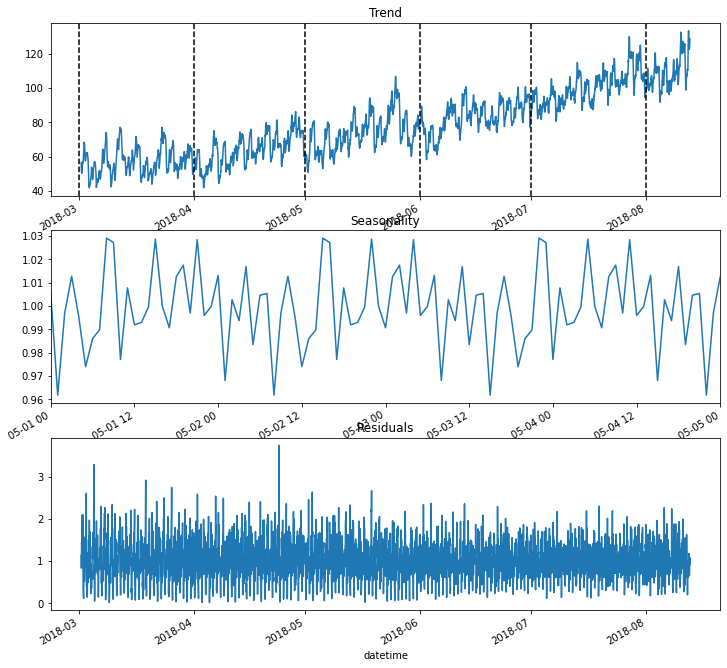

In [38]:
decomposed = seasonal_decompose(train.loc[train['num_orders']>0, 'num_orders'], model="multiplicative", period=31)
# remove one zero order entry. The decomposition does not work with zero as zero times everything is 0 so you cannot decompose
plt_1 = plt.figure(figsize=(12, 12))
win1 = plt.subplot(311)
curve0 = decomposed.trend.plot(ax=plt.gca())
for mc in mcoords:
    mplt = plt.axvline(x=mc, color='black', linestyle='--')
tit1 = plt.title('Trend')
win2 = plt.subplot(312)
curve1 = decomposed.seasonal.plot(ax=plt.gca())
seas = plt.title('Seasonality')
win2x = plt.xlim(['2018-05-01', '2018-05-05'])
win3 = plt.subplot(313)
curve2 = decomposed.resid.plot(ax=plt.gca())
tit1 = plt.title('Residuals')

We can see that even with no moving average our residuals are already considerably smaller.  
Even smaller than a 24 hours moving average for an additive model.  
Furthermore, they are decreasing with time.  
(Small residuals means less unexplained data / errors)  
This means that a multiplicative model is more appropriate for our data.  
The problem with the above decomposition is that it is not clear.  
We cannot use this procedure to extract meaningful features that will support our ML model.  
In order to achieve that, we will have to use the gained knowledge and manually try features that should support our prediction.  
This will be performed below.

## Manual decomposition and feature identification

### Trend

As a first step let's recap the trend as a plynomial fit:

https://www.youtube.com/watch?v=6iVJPG9RQXQ  
https://github.com/bhattbhavesh91/time-series-decomposition-from-scratch/blob/master/time-series-decomposition-from-scratch.ipynb

Fit a polynomial to the data:

In [39]:
from numpy.polynomial import Polynomial
from numpy.polynomial.polynomial import polyval
#remark - rare packages I hardly use I do not add upfornt, no need to overload the machine with them every time...

p1 = Polynomial.fit(np.arange(len(train['num_orders'])), train['num_orders'].values, 1).convert()
p1
p1.coef

p2 = Polynomial.fit(np.arange(len(train['num_orders'])), train['num_orders'].values, 2).convert()
p2
p2.coef

p3 = Polynomial.fit(np.arange(len(train['num_orders'])), train['num_orders'].values, 3).convert()
p3
p3.coef
#https://stackoverflow.com/questions/68319851/how-to-use-numpy-1-4-polynomial-class-to-fit-values

Polynomial([4.79664168e+01, 1.52651509e-02], domain=[-1.,  1.], window=[-1.,  1.])

array([4.79664168e+01, 1.52651509e-02])

Polynomial([5.46848434e+01, 5.11647028e-03, 2.55441245e-06], domain=[-1.,  1.], window=[-1.,  1.])

array([5.46848434e+01, 5.11647028e-03, 2.55441245e-06])

Polynomial([5.39591863e+01, 7.30961610e-03, 1.17420743e-06, 2.31597453e-10], domain=[-1.,  1.], window=[-1.,  1.])

array([5.39591863e+01, 7.30961610e-03, 1.17420743e-06, 2.31597453e-10])

In [40]:
train['trend1'] = pd.Series(data = p1(np.arange(len(train['num_orders']))), index = train.index)
train['trend2'] = pd.Series(data = p2(np.arange(len(train['num_orders']))), index = train.index)
train['trend3'] = pd.Series(data = p3(np.arange(len(train['num_orders']))), index = train.index)

In [41]:
train.head()

,num_orders,rolling5_mean,rolling5_std,rolling10_mean,rolling10_std,rolling24_mean,rolling24_std,trend1,trend2,trend3
datetime,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,NaN,NaN,NaN,NaN,47.966417,54.684843,53.959186
2018-03-01 01:00:00,85,NaN,NaN,NaN,NaN,NaN,NaN,47.981682,54.689962,53.966497
2018-03-01 02:00:00,71,NaN,NaN,NaN,NaN,NaN,NaN,47.996947,54.695087,53.973810
2018-03-01 03:00:00,66,NaN,NaN,NaN,NaN,NaN,NaN,48.012212,54.700216,53.981126
2018-03-01 04:00:00,43,77.8,29.928248,NaN,NaN,NaN,NaN,48.027477,54.705350,53.988444


In [42]:
p1(np.arange(0,5))
p2(np.arange(0,5))
p3(np.arange(0,5))

array([47.9664168 , 47.98168195, 47.99694711, 48.01221226, 48.02747741])

array([54.68484341, 54.68996243, 54.69508656, 54.70021581, 54.70535016])

array([53.95918626, 53.96649705, 53.97381019, 53.98112569, 53.98844353])

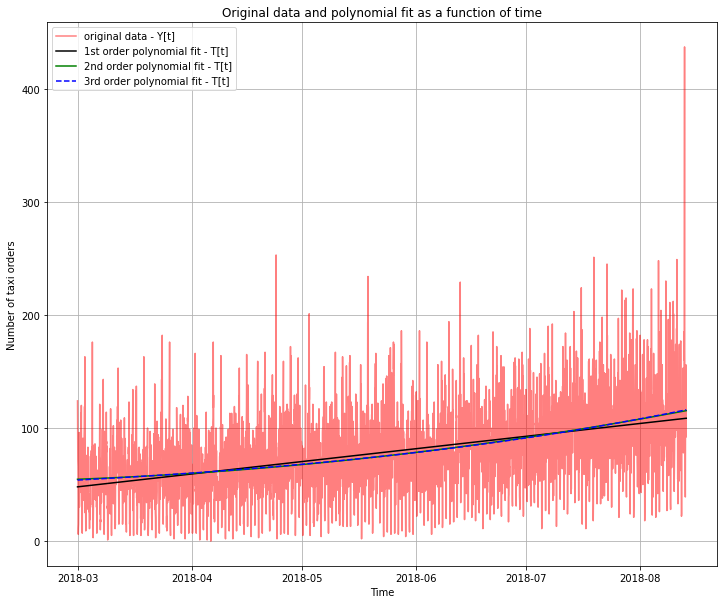

In [43]:
fig, ax1 = plt.subplots(figsize=(12, 10))
curve0 = ax1.plot(train['num_orders'], 'r', alpha=0.5, label='original data - Y[t]')
curve1 = ax1.plot(train['trend1'], 'k', label = '1st order polynomial fit - T[t]')
curve2 = ax1.plot(train['trend2'], 'g', label = '2nd order polynomial fit - T[t]')
curve3 = ax1.plot(train['trend3'], 'b--', label = '3rd order polynomial fit - T[t]')
x1 = ax1.set_xlabel('Time')
y1 = ax1.set_ylabel('Number of taxi orders')
grid = ax1.grid()
tit = plt.title('Original data and polynomial fit as a function of time')
leg1 = ax1.legend(loc='upper left')
plt.show()

We can see that the second order polynomial fit captures the mean trend quite well.  
No added value for a 3rd order fit.  
We can use this proxy as a feature.

In [44]:
train['detrended'] = train['num_orders'] / train['trend2']

In [45]:
train.head()

,num_orders,rolling5_mean,rolling5_std,rolling10_mean,rolling10_std,rolling24_mean,rolling24_std,trend1,trend2,trend3,detrended
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,NaN,NaN,NaN,NaN,47.966417,54.684843,53.959186,2.267539
2018-03-01 01:00:00,85,NaN,NaN,NaN,NaN,NaN,NaN,47.981682,54.689962,53.966497,1.554216
2018-03-01 02:00:00,71,NaN,NaN,NaN,NaN,NaN,NaN,47.996947,54.695087,53.973810,1.298106
2018-03-01 03:00:00,66,NaN,NaN,NaN,NaN,NaN,NaN,48.012212,54.700216,53.981126,1.206577
2018-03-01 04:00:00,43,77.8,29.928248,NaN,NaN,NaN,NaN,48.027477,54.705350,53.988444,0.786029


The following features are seasonality proxies:  
(no need to check month, we already saw above it is essential)

### Day of the month

Define seasonality by day of the month:

In [46]:
seasonal = train['detrended'].groupby(by = train.index.day).mean()

https://otexts.com/fpp2/classical-decomposition.html

In [47]:
seasonal

datetime
1     0.940514
2     1.003889
3     0.936395
4     0.918869
5     0.882852
6     0.986090
7     0.973010
8     0.983884
9     0.965013
10    0.976527
11    1.024893
12    1.028242
13    1.092700
14    1.042864
15    0.976544
16    1.049683
17    0.973716
18    1.035187
19    0.975410
20    0.996740
21    0.981768
22    0.997982
23    1.097464
24    1.051186
25    1.041315
26    1.023263
27    1.029827
28    1.056787
29    0.996336
30    1.027252
31    0.998925
Name: detrended, dtype: float64

Merge seasonal data into dataframe:

In [48]:
train['seasonal'] = 0
for i in seasonal.index:
    train.loc[train.index.day == i, 'seasonal'] = seasonal.loc[i]

In [49]:
train.head()

,num_orders,rolling5_mean,rolling5_std,rolling10_mean,rolling10_std,rolling24_mean,rolling24_std,trend1,trend2,trend3,detrended,seasonal
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,NaN,NaN,NaN,NaN,47.966417,54.684843,53.959186,2.267539,0.940514
2018-03-01 01:00:00,85,NaN,NaN,NaN,NaN,NaN,NaN,47.981682,54.689962,53.966497,1.554216,0.940514
2018-03-01 02:00:00,71,NaN,NaN,NaN,NaN,NaN,NaN,47.996947,54.695087,53.973810,1.298106,0.940514
2018-03-01 03:00:00,66,NaN,NaN,NaN,NaN,NaN,NaN,48.012212,54.700216,53.981126,1.206577,0.940514
2018-03-01 04:00:00,43,77.8,29.928248,NaN,NaN,NaN,NaN,48.027477,54.705350,53.988444,0.786029,0.940514


In [50]:
train['deseasonal'] = train['detrended'] / train['seasonal']

In [51]:
train.head()

,num_orders,rolling5_mean,rolling5_std,rolling10_mean,rolling10_std,rolling24_mean,rolling24_std,trend1,trend2,trend3,detrended,seasonal,deseasonal
datetime,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,NaN,NaN,NaN,NaN,47.966417,54.684843,53.959186,2.267539,0.940514,2.410958
2018-03-01 01:00:00,85,NaN,NaN,NaN,NaN,NaN,NaN,47.981682,54.689962,53.966497,1.554216,0.940514,1.652518
2018-03-01 02:00:00,71,NaN,NaN,NaN,NaN,NaN,NaN,47.996947,54.695087,53.973810,1.298106,0.940514,1.380209
2018-03-01 03:00:00,66,NaN,NaN,NaN,NaN,NaN,NaN,48.012212,54.700216,53.981126,1.206577,0.940514,1.282891
2018-03-01 04:00:00,43,77.8,29.928248,NaN,NaN,NaN,NaN,48.027477,54.705350,53.988444,0.786029,0.940514,0.835745


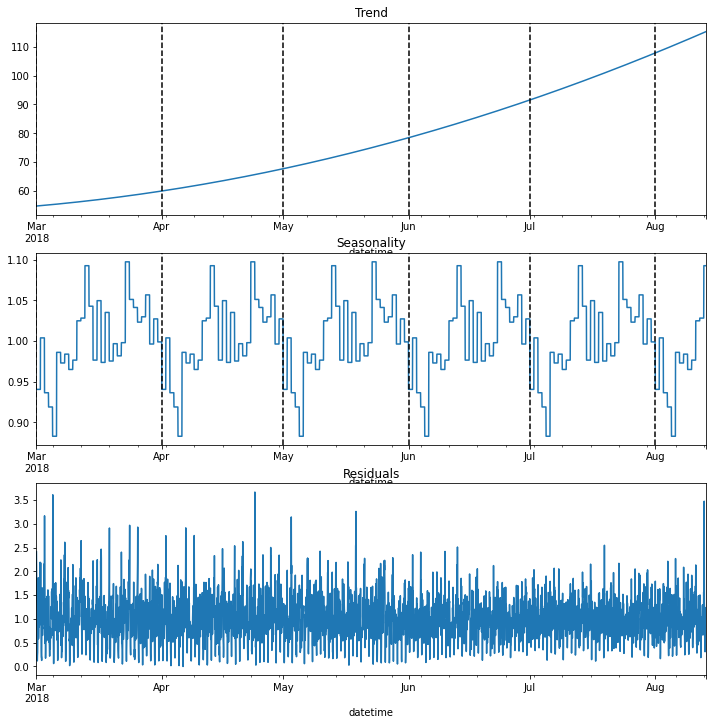

In [52]:
plt_1 = plt.figure(figsize=(12, 12))
win1 = plt.subplot(311)
curve0 = train['trend2'].plot(ax=plt.gca())
for mc in mcoords:
    mplt = plt.axvline(x=mc, color='black', linestyle='--')
tit1 = plt.title('Trend')

win2 = plt.subplot(312)
curve1 = train['seasonal'].plot(ax=plt.gca())
for mc in mcoords:
    mplt = plt.axvline(x=mc, color='black', linestyle='--')
seas = plt.title('Seasonality')

win3 = plt.subplot(313)
curve2 = train['deseasonal'].plot(ax=plt.gca())
tit1 = plt.title('Residuals')

We can clearly see a pattern for the day of the month.  
It appears people fly more or at least order more cabs during the second half of the month.  
**Remark:**  
1. The existence of a pattern is proven by the diminishing residuals.  
If the model was not appropriate we would have received increasing rather than decreasing residuals...
2. Here, we have used our decomposition understanding and constructed a multiplicative model to evaluate the residuals.

### Weekday

It is worth rechecking seasonality using a weekday as it appears we have 4 segments during each month:

In [53]:
seasonal_wkdy = train['detrended'].groupby(by = train.index.weekday).mean()

In [54]:
seasonal_wkdy

datetime
0    1.062343
1    0.896458
2    0.979404
3    1.014785
4    1.078560
5    1.013280
6    0.951164
Name: detrended, dtype: float64

In [55]:
train['seasonal_wkdy'] = 0
for i in seasonal_wkdy.index:
    train.loc[train.index.weekday == i, 'seasonal_wkdy'] = seasonal_wkdy.loc[i]

In [56]:
train.head()

,num_orders,rolling5_mean,rolling5_std,rolling10_mean,rolling10_std,rolling24_mean,rolling24_std,trend1,trend2,trend3,detrended,seasonal,deseasonal,seasonal_wkdy
datetime,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,NaN,NaN,NaN,NaN,47.966417,54.684843,53.959186,2.267539,0.940514,2.410958,1.014785
2018-03-01 01:00:00,85,NaN,NaN,NaN,NaN,NaN,NaN,47.981682,54.689962,53.966497,1.554216,0.940514,1.652518,1.014785
2018-03-01 02:00:00,71,NaN,NaN,NaN,NaN,NaN,NaN,47.996947,54.695087,53.973810,1.298106,0.940514,1.380209,1.014785
2018-03-01 03:00:00,66,NaN,NaN,NaN,NaN,NaN,NaN,48.012212,54.700216,53.981126,1.206577,0.940514,1.282891,1.014785
2018-03-01 04:00:00,43,77.8,29.928248,NaN,NaN,NaN,NaN,48.027477,54.705350,53.988444,0.786029,0.940514,0.835745,1.014785


In [57]:
train['deseasonal_wkdy'] = train['detrended'] / train['seasonal_wkdy']

In [58]:
train.head()

,num_orders,rolling5_mean,rolling5_std,rolling10_mean,rolling10_std,rolling24_mean,rolling24_std,trend1,trend2,trend3,detrended,seasonal,deseasonal,seasonal_wkdy,deseasonal_wkdy
datetime,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,NaN,NaN,NaN,NaN,47.966417,54.684843,53.959186,2.267539,0.940514,2.410958,1.014785,2.234501
2018-03-01 01:00:00,85,NaN,NaN,NaN,NaN,NaN,NaN,47.981682,54.689962,53.966497,1.554216,0.940514,1.652518,1.014785,1.531571
2018-03-01 02:00:00,71,NaN,NaN,NaN,NaN,NaN,NaN,47.996947,54.695087,53.973810,1.298106,0.940514,1.380209,1.014785,1.279193
2018-03-01 03:00:00,66,NaN,NaN,NaN,NaN,NaN,NaN,48.012212,54.700216,53.981126,1.206577,0.940514,1.282891,1.014785,1.188997
2018-03-01 04:00:00,43,77.8,29.928248,NaN,NaN,NaN,NaN,48.027477,54.705350,53.988444,0.786029,0.940514,0.835745,1.014785,0.774577


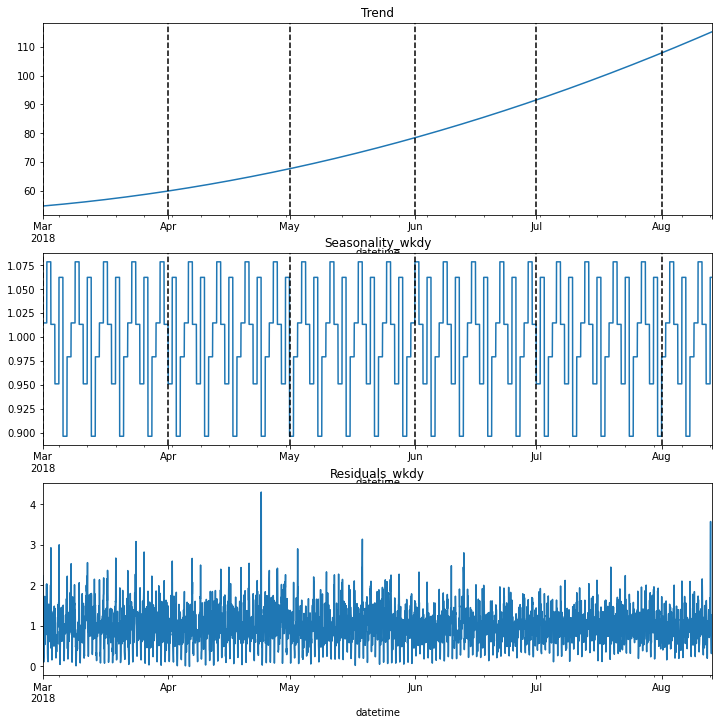

In [59]:
plt_1 = plt.figure(figsize=(12, 12))
win1 = plt.subplot(311)
curve0 = train['trend2'].plot(ax=plt.gca())
for mc in mcoords:
    mplt = plt.axvline(x=mc, color='black', linestyle='--')
tit1 = plt.title('Trend')

win2 = plt.subplot(312)
curve1 = train['seasonal_wkdy'].plot(ax=plt.gca())
for mc in mcoords:
    mplt = plt.axvline(x=mc, color='black', linestyle='--')
seas = plt.title('Seasonality_wkdy')

win3 = plt.subplot(313)
curve2 = train['deseasonal_wkdy'].plot(ax=plt.gca())
tit1 = plt.title('Residuals_wkdy')

We can see clear seasonality related to the weekday.

### Week of the month

Let's try the week of the month as well:

In [60]:
from math import ceil

def week_of_month(dt):
    first_day = dt.replace(day=1)             # take first day of the month
    dom = dt.day                              # take date day of month
    adjusted_dom = dom + first_day.weekday()  # add weekday to day of month so we start from the right point
    return int(ceil(adjusted_dom/7.0))        # divide by 7 to receive week, ceil because anythying above round
                                              # belongs to the following week...

#https://stackoverflow.com/questions/3806473/week-number-of-the-month
#https://www.geeksforgeeks.org/datetime-replace-function-in-python/

In [61]:
week_of_month(datetime.today())

2

In [62]:
dates = train.index.to_series()
dates.apply(week_of_month)

datetime
2018-03-01 00:00:00    1
2018-03-01 01:00:00    1
2018-03-01 02:00:00    1
2018-03-01 03:00:00    1
2018-03-01 04:00:00    1
2018-03-01 05:00:00    1
2018-03-01 06:00:00    1
2018-03-01 07:00:00    1
2018-03-01 08:00:00    1
2018-03-01 09:00:00    1
2018-03-01 10:00:00    1
2018-03-01 11:00:00    1
2018-03-01 12:00:00    1
2018-03-01 13:00:00    1
2018-03-01 14:00:00    1
2018-03-01 15:00:00    1
2018-03-01 16:00:00    1
2018-03-01 17:00:00    1
2018-03-01 18:00:00    1
2018-03-01 19:00:00    1
2018-03-01 20:00:00    1
2018-03-01 21:00:00    1
2018-03-01 22:00:00    1
2018-03-01 23:00:00    1
2018-03-02 00:00:00    1
2018-03-02 01:00:00    1
2018-03-02 02:00:00    1
2018-03-02 03:00:00    1
2018-03-02 04:00:00    1
2018-03-02 05:00:00    1
2018-03-02 06:00:00    1
2018-03-02 07:00:00    1
2018-03-02 08:00:00    1
2018-03-02 09:00:00    1
2018-03-02 10:00:00    1
2018-03-02 11:00:00    1
2018-03-02 12:00:00    1
2018-03-02 13:00:00    1
2018-03-02 14:00:00    1
2018-03-02 15:00

Works fine, check for example June 2018:  
First week includes days 1-3 (week starts on Monday).  
Then week 2 includes days 4-10 and so forth...  
https://oldcalendars.com/june-2018-calendar/

In [63]:
train['seasonal_wk'] = dates.apply(week_of_month)

In [64]:
train.head()

,num_orders,rolling5_mean,rolling5_std,rolling10_mean,rolling10_std,rolling24_mean,rolling24_std,trend1,trend2,trend3,detrended,seasonal,deseasonal,seasonal_wkdy,deseasonal_wkdy,seasonal_wk
datetime,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,NaN,NaN,NaN,NaN,47.966417,54.684843,53.959186,2.267539,0.940514,2.410958,1.014785,2.234501,1
2018-03-01 01:00:00,85,NaN,NaN,NaN,NaN,NaN,NaN,47.981682,54.689962,53.966497,1.554216,0.940514,1.652518,1.014785,1.531571,1
2018-03-01 02:00:00,71,NaN,NaN,NaN,NaN,NaN,NaN,47.996947,54.695087,53.973810,1.298106,0.940514,1.380209,1.014785,1.279193,1
2018-03-01 03:00:00,66,NaN,NaN,NaN,NaN,NaN,NaN,48.012212,54.700216,53.981126,1.206577,0.940514,1.282891,1.014785,1.188997,1
2018-03-01 04:00:00,43,77.8,29.928248,NaN,NaN,NaN,NaN,48.027477,54.705350,53.988444,0.786029,0.940514,0.835745,1.014785,0.774577,1


In [65]:
seasonal_wk_val = train['detrended'].groupby(by = train.seasonal_wk).mean()

In [66]:
seasonal_wk_val

seasonal_wk
1    0.948210
2    0.970504
3    1.021787
4    1.021338
5    1.021626
6    1.035271
Name: detrended, dtype: float64

In [67]:
train['seasonal_wk_val'] = 0
for i in seasonal_wk_val.index:
    train.loc[train.seasonal_wk == i, 'seasonal_wk_val'] = seasonal_wk_val.loc[i]

In [68]:
train.head()

,num_orders,rolling5_mean,rolling5_std,rolling10_mean,rolling10_std,rolling24_mean,rolling24_std,trend1,trend2,trend3,detrended,seasonal,deseasonal,seasonal_wkdy,deseasonal_wkdy,seasonal_wk,seasonal_wk_val
datetime,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,NaN,NaN,NaN,NaN,47.966417,54.684843,53.959186,2.267539,0.940514,2.410958,1.014785,2.234501,1,0.94821
2018-03-01 01:00:00,85,NaN,NaN,NaN,NaN,NaN,NaN,47.981682,54.689962,53.966497,1.554216,0.940514,1.652518,1.014785,1.531571,1,0.94821
2018-03-01 02:00:00,71,NaN,NaN,NaN,NaN,NaN,NaN,47.996947,54.695087,53.973810,1.298106,0.940514,1.380209,1.014785,1.279193,1,0.94821
2018-03-01 03:00:00,66,NaN,NaN,NaN,NaN,NaN,NaN,48.012212,54.700216,53.981126,1.206577,0.940514,1.282891,1.014785,1.188997,1,0.94821
2018-03-01 04:00:00,43,77.8,29.928248,NaN,NaN,NaN,NaN,48.027477,54.705350,53.988444,0.786029,0.940514,0.835745,1.014785,0.774577,1,0.94821


In [69]:
train['deseasonal_wk'] = train['detrended'] / train['seasonal_wk_val']

In [70]:
train.head()

,num_orders,rolling5_mean,rolling5_std,rolling10_mean,rolling10_std,rolling24_mean,rolling24_std,trend1,trend2,trend3,detrended,seasonal,deseasonal,seasonal_wkdy,deseasonal_wkdy,seasonal_wk,seasonal_wk_val,deseasonal_wk
datetime,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,NaN,NaN,NaN,NaN,47.966417,54.684843,53.959186,2.267539,0.940514,2.410958,1.014785,2.234501,1,0.94821,2.391389
2018-03-01 01:00:00,85,NaN,NaN,NaN,NaN,NaN,NaN,47.981682,54.689962,53.966497,1.554216,0.940514,1.652518,1.014785,1.531571,1,0.94821,1.639105
2018-03-01 02:00:00,71,NaN,NaN,NaN,NaN,NaN,NaN,47.996947,54.695087,53.973810,1.298106,0.940514,1.380209,1.014785,1.279193,1,0.94821,1.369006
2018-03-01 03:00:00,66,NaN,NaN,NaN,NaN,NaN,NaN,48.012212,54.700216,53.981126,1.206577,0.940514,1.282891,1.014785,1.188997,1,0.94821,1.272478
2018-03-01 04:00:00,43,77.8,29.928248,NaN,NaN,NaN,NaN,48.027477,54.705350,53.988444,0.786029,0.940514,0.835745,1.014785,0.774577,1,0.94821,0.828961


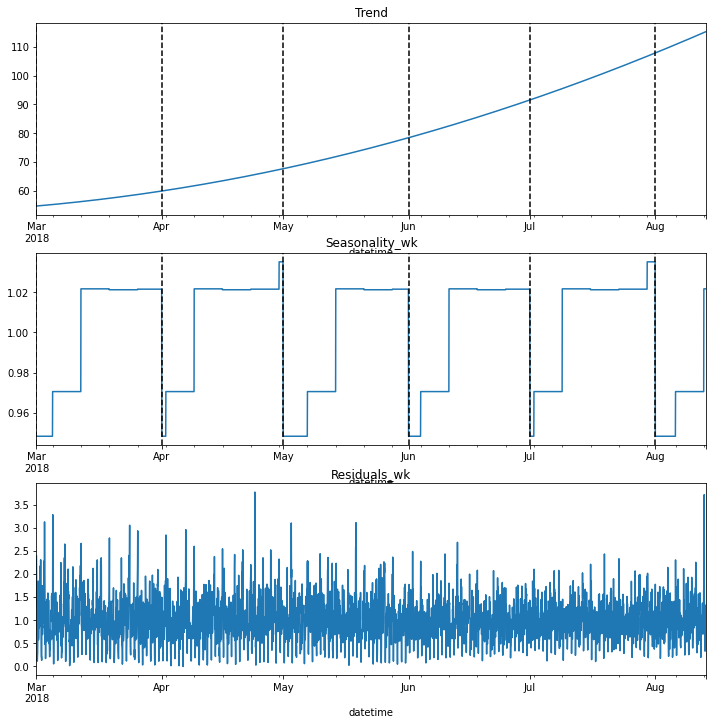

In [71]:
plt_1 = plt.figure(figsize=(12, 12))
win1 = plt.subplot(311)
curve0 = train['trend2'].plot(ax=plt.gca())
for mc in mcoords:
    mplt = plt.axvline(x=mc, color='black', linestyle='--')
tit1 = plt.title('Trend')

win2 = plt.subplot(312)
curve1 = train['seasonal_wk_val'].plot(ax=plt.gca())
for mc in mcoords:
    mplt = plt.axvline(x=mc, color='black', linestyle='--')
seas = plt.title('Seasonality_wk')

win3 = plt.subplot(313)
curve2 = train['deseasonal_wk'].plot(ax=plt.gca())
tit1 = plt.title('Residuals_wk')

Again, a clear recurring process with diminishing residuals.  
Here we have a caveat - not all months have a sixth week...

### Hour of day

In [72]:
seasonal_hour = train['detrended'].groupby(by = train.index.hour).mean()

In [73]:
seasonal_hour

datetime
0     1.755322
1     1.246505
2     1.270489
3     1.190505
4     0.941154
5     0.473168
6     0.269885
7     0.340239
8     0.880070
9     1.035774
10    1.105971
11    1.002874
12    0.771705
13    0.859574
14    0.897724
15    1.058505
16    1.372029
17    1.031029
18    0.844736
19    0.941007
20    1.023326
21    1.146862
22    1.227172
23    1.319867
Name: detrended, dtype: float64

In [74]:
train['seasonal_hour'] = 0
for i in seasonal_hour.index:
    train.loc[train.index.hour == i, 'seasonal_hour'] = seasonal_hour.loc[i]

In [75]:
train.head()

,num_orders,rolling5_mean,rolling5_std,rolling10_mean,rolling10_std,rolling24_mean,rolling24_std,trend1,trend2,trend3,detrended,seasonal,deseasonal,seasonal_wkdy,deseasonal_wkdy,seasonal_wk,seasonal_wk_val,deseasonal_wk,seasonal_hour
datetime,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,NaN,NaN,NaN,NaN,47.966417,54.684843,53.959186,2.267539,0.940514,2.410958,1.014785,2.234501,1,0.94821,2.391389,1.755322
2018-03-01 01:00:00,85,NaN,NaN,NaN,NaN,NaN,NaN,47.981682,54.689962,53.966497,1.554216,0.940514,1.652518,1.014785,1.531571,1,0.94821,1.639105,1.246505
2018-03-01 02:00:00,71,NaN,NaN,NaN,NaN,NaN,NaN,47.996947,54.695087,53.973810,1.298106,0.940514,1.380209,1.014785,1.279193,1,0.94821,1.369006,1.270489
2018-03-01 03:00:00,66,NaN,NaN,NaN,NaN,NaN,NaN,48.012212,54.700216,53.981126,1.206577,0.940514,1.282891,1.014785,1.188997,1,0.94821,1.272478,1.190505
2018-03-01 04:00:00,43,77.8,29.928248,NaN,NaN,NaN,NaN,48.027477,54.705350,53.988444,0.786029,0.940514,0.835745,1.014785,0.774577,1,0.94821,0.828961,0.941154


In [76]:
train['deseasonal_hour'] = train['detrended'] / train['seasonal_hour']

In [77]:
train.head()

,num_orders,rolling5_mean,rolling5_std,rolling10_mean,rolling10_std,rolling24_mean,rolling24_std,trend1,trend2,trend3,detrended,seasonal,deseasonal,seasonal_wkdy,deseasonal_wkdy,seasonal_wk,seasonal_wk_val,deseasonal_wk,seasonal_hour,deseasonal_hour
datetime,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,NaN,NaN,NaN,NaN,47.966417,54.684843,53.959186,2.267539,0.940514,2.410958,1.014785,2.234501,1,0.94821,2.391389,1.755322,1.291808
2018-03-01 01:00:00,85,NaN,NaN,NaN,NaN,NaN,NaN,47.981682,54.689962,53.966497,1.554216,0.940514,1.652518,1.014785,1.531571,1,0.94821,1.639105,1.246505,1.246859
2018-03-01 02:00:00,71,NaN,NaN,NaN,NaN,NaN,NaN,47.996947,54.695087,53.973810,1.298106,0.940514,1.380209,1.014785,1.279193,1,0.94821,1.369006,1.270489,1.021737
2018-03-01 03:00:00,66,NaN,NaN,NaN,NaN,NaN,NaN,48.012212,54.700216,53.981126,1.206577,0.940514,1.282891,1.014785,1.188997,1,0.94821,1.272478,1.190505,1.013500
2018-03-01 04:00:00,43,77.8,29.928248,NaN,NaN,NaN,NaN,48.027477,54.705350,53.988444,0.786029,0.940514,0.835745,1.014785,0.774577,1,0.94821,0.828961,0.941154,0.835176


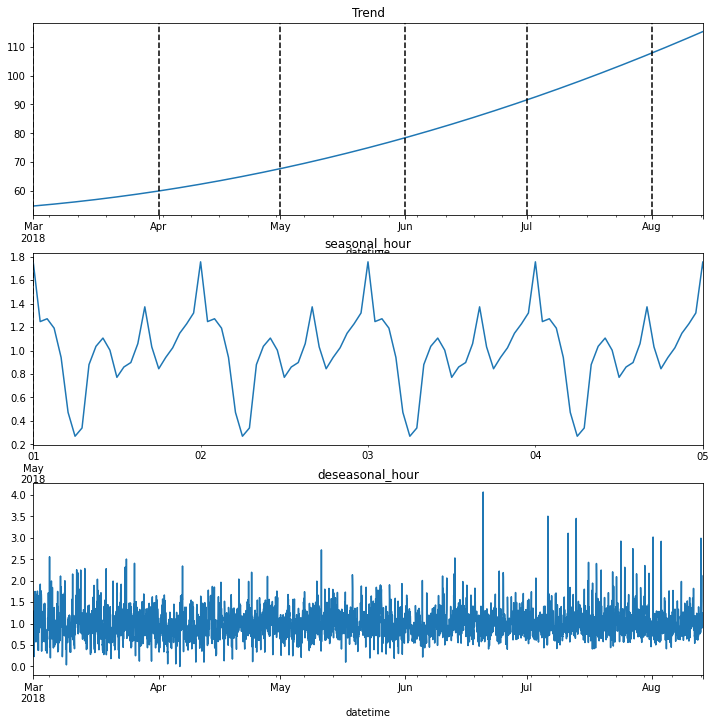

In [78]:
plt_1 = plt.figure(figsize=(12, 12))
win1 = plt.subplot(311)
curve0 = train['trend2'].plot(ax=plt.gca())
for mc in mcoords:
    mplt = plt.axvline(x=mc, color='black', linestyle='--')
tit1 = plt.title('Trend')

win2 = plt.subplot(312)
curve1 = train['seasonal_hour'].plot(ax=plt.gca())
for mc in mcoords:
    mplt = plt.axvline(x=mc, color='black', linestyle='--')
seas = plt.title('seasonal_hour')
win2x = plt.xlim(['2018-05-01', '2018-05-05'])

win3 = plt.subplot(313)
curve2 = train['deseasonal_hour'].plot(ax=plt.gca())
tit1 = plt.title('deseasonal_hour')

We have a high frequency seasonality.

### Differences

In [79]:
train['Diff'] = train['num_orders'] - train['num_orders'].shift()
train['Diff_roll10_mean']=train.Diff.rolling(10).mean()
train['Diff_roll10_std']=train.Diff.rolling(10).std()

In [80]:
train.head()

,num_orders,rolling5_mean,rolling5_std,rolling10_mean,rolling10_std,rolling24_mean,rolling24_std,trend1,trend2,trend3,detrended,seasonal,deseasonal,seasonal_wkdy,deseasonal_wkdy,seasonal_wk,seasonal_wk_val,deseasonal_wk,seasonal_hour,deseasonal_hour,Diff,Diff_roll10_mean,Diff_roll10_std
datetime,,,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,NaN,NaN,NaN,NaN,47.966417,54.684843,53.959186,2.267539,0.940514,2.410958,1.014785,2.234501,1,0.94821,2.391389,1.755322,1.291808,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN,NaN,NaN,NaN,NaN,47.981682,54.689962,53.966497,1.554216,0.940514,1.652518,1.014785,1.531571,1,0.94821,1.639105,1.246505,1.246859,-39.0,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN,NaN,NaN,NaN,NaN,47.996947,54.695087,53.973810,1.298106,0.940514,1.380209,1.014785,1.279193,1,0.94821,1.369006,1.270489,1.021737,-14.0,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN,NaN,NaN,NaN,NaN,48.012212,54.700216,53.981126,1.206577,0.940514,1.282891,1.014785,1.188997,1,0.94821,1.272478,1.190505,1.013500,-5.0,NaN,NaN
2018-03-01 04:00:00,43,77.8,29.928248,NaN,NaN,NaN,NaN,48.027477,54.705350,53.988444,0.786029,0.940514,0.835745,1.014785,0.774577,1,0.94821,0.828961,0.941154,0.835176,-23.0,NaN,NaN


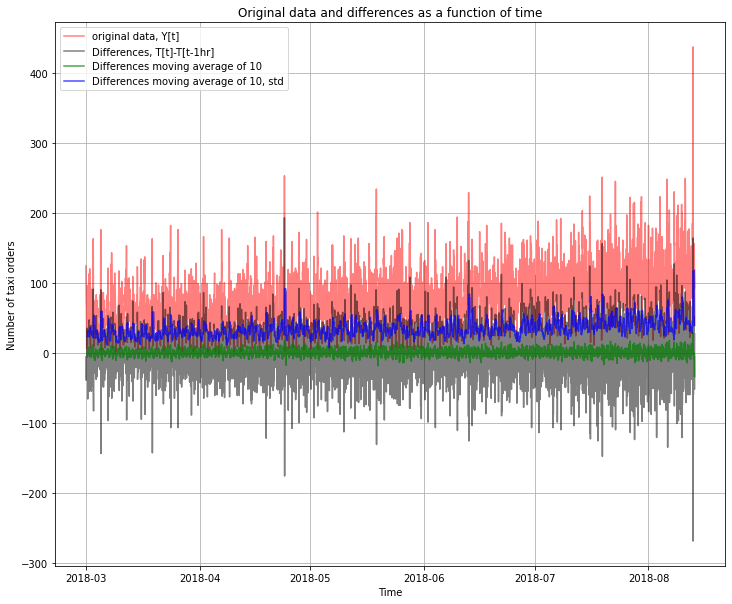

In [81]:
fig, ax1 = plt.subplots(figsize=(12, 10))
curve0 = ax1.plot(train['num_orders'], 'r', alpha=0.5, label='original data, Y[t]')
curve1 = ax1.plot(train['Diff'], 'k', alpha=0.5, label = 'Differences, T[t]-T[t-1hr]')
curve2 = ax1.plot(train['Diff_roll10_mean'], 'g', alpha=0.7, label = 'Differences moving average of 10')
curve3 = ax1.plot(train['Diff_roll10_std'], 'b', alpha=0.7, label = 'Differences moving average of 10, std')
x1 = ax1.set_xlabel('Time')
y1 = ax1.set_ylabel('Number of taxi orders')
grid = ax1.grid()
tit = plt.title('Original data and differences as a function of time')
leg1 = ax1.legend(loc='upper left')
plt.show()

The Diff series is much more stationary though its std still increases over time.

### Outliers

Let's examine its histogram:

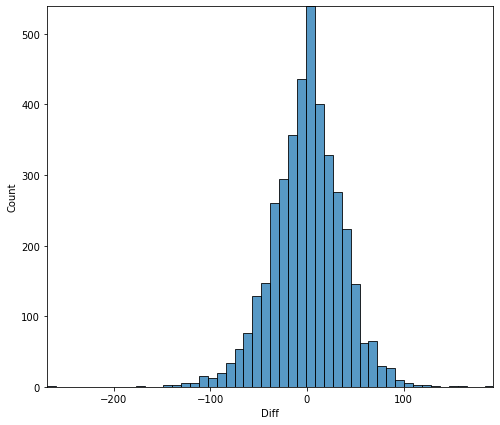

In [82]:
fig_init = plt.figure(figsize=(8,7))
plot = sns.histplot(data=train, x=train['Diff'], bins=50)
plot.autoscale(axis="x", tight=True, enable=True) 
plot.autoscale(axis="y", tight=True, enable=True) 
plt.show()

Looks like a classical normal distribution.  
Is it?  
Let's plot a qqplot and conduct a Shapiro-Wilk test.  
The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution.  
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html

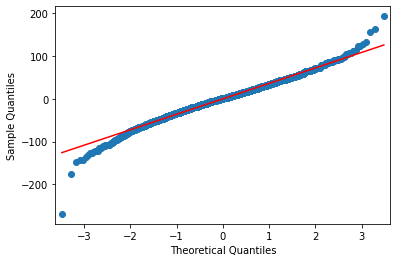

In [83]:
from statsmodels.graphics.gofplots import qqplot
qqp = qqplot(train['Diff'].dropna(), line='s')
plt.show()

Too many samples deviating the expected qqplot line for normal distribution...

In [84]:
from scipy.stats import shapiro

# normality test
stat, p = shapiro(train['Diff'].dropna())
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.987, p=0.000
Sample does not look Gaussian (reject H0)


We will have to use the minmax scaler after all.  
We still have to address the outliers though.

I will take a similar approach to the the hampel filter using the Median Absolute Deviation (MAD) to smooth the data.  
Every entry exceeding 3 times the MAD will be replaced with its moving average counterpart.  
https://pypi.org/project/hampel/  
https://en.wikipedia.org/wiki/Median_absolute_deviation  
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.median_absolute_deviation.html

In [85]:
MAD = stats.median_abs_deviation(train['Diff'].dropna())

In [86]:
MAD

22.0

In [87]:
train.loc[6*MAD <np.abs(train['Diff']), 'Diff']

datetime
2018-03-05 02:00:00   -144.0
2018-03-19 02:00:00   -143.0
2018-04-24 00:00:00    193.0
2018-04-24 01:00:00   -176.0
2018-07-19 10:00:00    156.0
2018-07-19 11:00:00   -148.0
2018-08-06 05:00:00   -135.0
2018-08-13 02:00:00    164.0
2018-08-13 03:00:00   -269.0
Name: Diff, dtype: float64

It is fine to use the condition on the test set as well as the MAD value is calculated using the train set so we have no data leakage here.

## Dickey-Fuller test

Dickey-Fuller test for Time Series Stationarity using Python:  

Let's assume a time series:

$$
y_t=\mu+\phi_1y_{t-1}+\epsilon_t\\
y_t-y_{t-1}=\mu+(\phi_1-1)y_{t-1}+\epsilon_t\\
\Delta y_t=\mu+\delta y_{t-1}+\epsilon_t\\
$$

The test assumptions are:  
$H_0$: TS ($y_t, y_{t-1}$) is non-stationary (unit root, $\phi_1=1$, $\delta=0$)  
But the differences series $\Delta y_t$ is stationary because $\mu$ is constant and $\epsilon_t$ is a randomly distributed noise.  
$H_1$: TS is stationary (no unit root, $\phi_1<1$, $\delta<0$)  

If ADF statistic < critical value -> reject H0  
If ADF statistic > critical value -> fail to reject H0  

Remark:
The DF statistic should be negative.  

https://www.youtube.com/watch?v=warCSvy1DMk  
https://github.com/bhattbhavesh91/adf-test-stationarity-python/blob/master/augmented-dickey-fuller-test-python.ipynb  
https://www.youtube.com/watch?v=2GxWgIumPTA  
https://www.youtube.com/watch?v=1opjnegd_hA  
https://www.youtube.com/watch?v=FsroWpkUuYI&list=PLjwX9KFWtvNnOc4HtsvaDf1XYG3O5bv5s  
https://www.youtube.com/watch?v=bsyUn-LJ3YQ  
https://www.youtube.com/watch?v=KCFLfQHZODM

In [88]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

def adf(series):
    X = series.values#[1:]
    result = adfuller(X)#regression='ct'
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    
    if result[0] < result[4]["5%"]:
        print ("Reject Ho - Time Series is Stationary")
    else:
        print ("Failed to Reject Ho - Time Series is Non-Stationary")

#https://www.statsmodels.org/stable/api.html
#https://www.statsmodels.org/0.6.1/generated/statsmodels.tsa.stattools.adfuller.html?highlight=dickey

In [89]:
adf(train["num_orders"])

ADF Statistic: -4.172826
p-value: 0.000732
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Reject Ho - Time Series is Stationary


Officially, the test indicates a stationary series but since the ADF statistic is not well below the critical value, our stationarity level of confidence is low.  
(The ADF critical statistic with a trend is -3.96 for a 1% confidence and -3.41 for a 5% confidence, this represents marginal safety https://www.youtube.com/watch?v=KCFLfQHZODM)

In [90]:
adf(train["Diff"].dropna())

ADF Statistic: -14.600709
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Reject Ho - Time Series is Stationary


Here, the test indicates the ADF statistic is well below the critical value, so our stationarity level of confidence is high.

The maximum lag assumed is:  
(see https://www.statsmodels.org/0.6.1/generated/statsmodels.tsa.stattools.adfuller.html?highlight=dickey)

In [91]:
maxlag = 12*((len(train)/100)**(1/4))
maxlag

30.129242418596096

30 hours is more than enough for stationarity test when a 1 hour prediction is required...

## Lagging features

It is customary in forecasting tasks to employ lagging values of the series.  
In fact, the econometric approach relies solely on such features (ARIMA/SARIMA models).  
In particular, we take as features only the lags where the PACF is greater than 0.2 (absolute value).  
This means that the correlation with our target is sufficient to contribute towards a quality prediction.  
https://towardsdatascience.com/ml-time-series-forecasting-the-right-way-cbf3678845ff

https://dzone.com/articles/autocorrelation-in-time-series-data
https://towardsdatascience.com/ml-time-series-forecasting-the-right-way-cbf3678845ff
https://dzone.com/articles/lessons-learnt-while-solving-time-series-forecasti-1

In [92]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from scipy.stats import linregress

partial = pd.Series(data=pacf(train["Diff"].dropna(), nlags=60))
lags = list(partial[np.abs(partial) >= 0.2].index)

In [93]:
lags

[0, 1, 21, 22, 23, 47]

In [94]:
partial[lags]

0     1.000000
1    -0.301910
21   -0.269626
22   -0.253592
23   -0.373010
47   -0.314316
dtype: float64

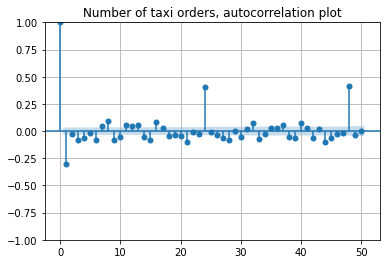

In [95]:
acf = plot_acf(train["Diff"].dropna(), lags=50)
grid = plt.grid()
tit = plt.title('Number of taxi orders, autocorrelation plot')
plt.show()

#https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-to-time-series-analysis/

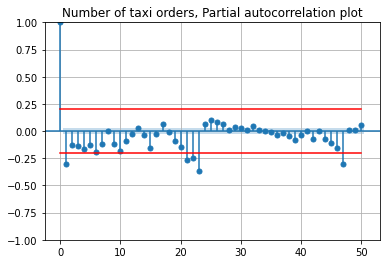

In [96]:
pacf = plot_pacf(train["Diff"].dropna(), lags=50, method='ywm')
x_coordinates = [0, 50]
y_coordinates = [0.2, 0.2]
high_thresh = plt.plot(x_coordinates, y_coordinates, 'r')
x_coordinates = [0, 50]
y_coordinates = [-0.2, -0.2]
low_thresh = plt.plot(x_coordinates, y_coordinates, 'r')
plt.grid()
tit = plt.title('Number of taxi orders, Partial autocorrelation plot')
plt.show()

We found the important lagging elements.

## Conclusions

* We have a small sized database containing around 26500 rows (prior to resampling).  
* We have no nulls.  
* The target contains reasonable values.  
* The data covers 6 months (3.2018-8.2018).
* Indeed, the 1 hour resampling process smooths the distribution.  
The most dominant effect is related to the dead windows (slots with no orders).  
A 10 minutes interval was too short but an hour interval is more reasonable.
* EDA demonstrate the clear trend for more airport flights and taxi orders during the busy summer months when the weather is fine and people tend to travel more.
* Decomposition suggests a multiplicative model - $Y[t]=T[t]S[t]\epsilon[t]$ with a $2^{nd}$ order polynomial trend and seasonality attributed to the day of the month, day of the week, week of the month and hour of the day.  
* We see a ~24 hour importance cycle in the series lagging pacf.
* We will have to detrend the data or take differences in order to receive better stationarity.  
https://www.youtube.com/watch?v=0ar9extHObg&list=PLjwX9KFWtvNnOc4HtsvaDf1XYG3O5bv5s&index=2  
https://www.youtube.com/watch?v=6iVJPG9RQXQ

## Generate datasets

Now that we are clear on our desired features, let's start with clean sets:

In [97]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month                   # month
    data['day'] = data.index.day                       # day of month
    data['weekday'] = data.index.weekday               # Weekday
    dates = data.index.to_series()
    data['week_of_month'] = dates.apply(week_of_month) # Week of the month
    data['hour'] = data.index.hour                     # hour of day
    data['trend'] = p2(np.arange(len(data)))           # since the polynom was fit based on the training set only,
                                                       # there is no leakage here...
    #generate differences
    data['diff'] =  data['num_orders'] - data['num_orders'].shift()
    
    #generate trend differences
    data['trend_diff'] = data['trend'] - data['trend'].shift()
    
    #generate lags
    for lag in lags[1:]:      #remove the series itself ofcourse #range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['diff'].shift(lag)
    
    #generate 1 step lag moving average
    data['rolling_mean'] = data['diff'].shift().rolling(rolling_mean_size).mean()
    
    #smooth outliers with moving average
    data.loc[6*MAD <np.abs(data['diff']), 'diff'] = data['rolling_mean']
    
    return data.dropna()       #remove nuls originating from moving averages and diffs

In [98]:
df_ML=make_features(dfr, 10, 10)

In [99]:
examine(df_ML)


***************
 head:


,num_orders,month,day,weekday,week_of_month,hour,trend,diff,trend_diff,lag_1,lag_21,lag_22,lag_23,lag_47,rolling_mean
datetime,,,,,,,,,,,,,,,
2018-03-03 00:00:00,163,3,3,5,1,0,54.936319,91.0,0.005359,-47.0,-11.0,-45.0,30.0,-39.0,2.7
2018-03-03 01:00:00,108,3,3,5,1,1,54.941684,-55.0,0.005364,91.0,-44.0,-11.0,-45.0,-14.0,11.9
2018-03-03 02:00:00,25,3,3,5,1,2,54.947053,-83.0,0.005369,-55.0,-9.0,-44.0,-11.0,-5.0,4.9
2018-03-03 03:00:00,64,3,3,5,1,3,54.952427,39.0,0.005374,-83.0,0.0,-9.0,-44.0,-23.0,-5.7
2018-03-03 04:00:00,44,3,3,5,1,4,54.957807,-20.0,0.005380,39.0,-4.0,0.0,-9.0,-37.0,-1.9



***************
 tail:


,num_orders,month,day,weekday,week_of_month,hour,trend,diff,trend_diff,lag_1,lag_21,lag_22,lag_23,lag_47,rolling_mean
datetime,,,,,,,,,,,,,,,
2018-08-31 19:00:00,136,8,31,4,5,19,126.954595,-71.0,0.027649,-10.0,-40.0,56.0,70.0,22.0,2.5
2018-08-31 20:00:00,154,8,31,4,5,20,126.982249,18.0,0.027654,-71.0,88.0,-40.0,56.0,-21.0,-6.7
2018-08-31 21:00:00,159,8,31,4,5,21,127.009908,5.0,0.027659,18.0,30.0,88.0,-40.0,7.0,-3.7
2018-08-31 22:00:00,223,8,31,4,5,22,127.037573,64.0,0.027664,5.0,-82.0,30.0,88.0,88.0,-0.8
2018-08-31 23:00:00,205,8,31,4,5,23,127.065242,-18.0,0.027669,64.0,36.0,-82.0,30.0,-49.0,8.7




***************
 General info:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4368 entries, 2018-03-03 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   num_orders     4368 non-null   int64  
 1   month          4368 non-null   int64  
 2   day            4368 non-null   int64  
 3   weekday        4368 non-null   int64  
 4   week_of_month  4368 non-null   int64  
 5   hour           4368 non-null   int64  
 6   trend          4368 non-null   float64
 7   diff           4368 non-null   float64
 8   trend_diff     4368 non-null   float64
 9   lag_1          4368 non-null   float64
 10  lag_21         4368 non-null   float64
 11  lag_22         4368 non-null   float64
 12  lag_23         4368 non-null   float64
 13  lag_47         4368 non-null   float64
 14  rolling_mean   4368 non-null   float64
dtypes: float64(9), int64(6)
memory usage: 546.0 KB

**************

Split the data:

In [100]:
train, test = train_test_split(df_ML, shuffle=False, test_size=0.1)

In [101]:
df_ML.shape
train.shape
test.shape

(4368, 15)

(3931, 15)

(437, 15)

In [102]:
train.tail()
test.head()

,num_orders,month,day,weekday,week_of_month,hour,trend,diff,trend_diff,lag_1,lag_21,lag_22,lag_23,lag_47,rolling_mean
datetime,,,,,,,,,,,,,,,
2018-08-13 14:00:00,102,8,13,0,3,14,115.358704,-17.0,0.025416,27.0,-38.0,4.0,45.0,70.0,-4.9
2018-08-13 15:00:00,175,8,13,0,3,15,115.384126,73.0,0.025421,-17.0,-37.0,-38.0,4.0,31.0,-4.1
2018-08-13 16:00:00,144,8,13,0,3,16,115.409553,-31.0,0.025427,73.0,4.0,-37.0,-38.0,-52.0,9.2
2018-08-13 17:00:00,152,8,13,0,3,17,115.434984,8.0,0.025432,-31.0,16.0,4.0,-37.0,-60.0,7.8
2018-08-13 18:00:00,104,8,13,0,3,18,115.460421,-48.0,0.025437,8.0,37.0,16.0,4.0,40.0,11.3


,num_orders,month,day,weekday,week_of_month,hour,trend,diff,trend_diff,lag_1,lag_21,lag_22,lag_23,lag_47,rolling_mean
datetime,,,,,,,,,,,,,,,
2018-08-13 19:00:00,91,8,13,0,3,19,115.485863,-13.0,0.025442,-48.0,-17.0,37.0,16.0,-18.0,1.3
2018-08-13 20:00:00,82,8,13,0,3,20,115.511310,-9.0,0.025447,-13.0,67.0,-17.0,37.0,21.0,-4.6
2018-08-13 21:00:00,160,8,13,0,3,21,115.536762,78.0,0.025452,-9.0,-25.0,67.0,-17.0,-16.0,-7.4
2018-08-13 22:00:00,104,8,13,0,3,22,115.562219,-56.0,0.025457,78.0,113.0,-25.0,67.0,66.0,1.6
2018-08-13 23:00:00,134,8,13,0,3,23,115.587682,30.0,0.025462,-56.0,164.0,113.0,-25.0,19.0,1.2


The data is indeed split to ~10% test set.  
The test set starts with ending of the train set, as expected.

<span class="mark">**Very important note:**</span>

Though all features we generated appear to be numerical, this is not the case.  
Some of the features are in fact categorical.  
This is a very important distinction to be made.  
For example, the first day of the month does not necessarily precede the the second day of the month as we have such days on the following months as well.  
The same goes for the weekday and the week of the month.  
These values rotate and their identification numbers does not infer size or order.  
However, this is not true for months for instance, as we have only several months that do not rotate and strongly affect the trend. The month number is numerical.  
It is very important to make this distinction when preparing the model.

Remove non-stationary data:

In [103]:
train_ = train.drop(labels=['num_orders', 'trend'], axis=1).copy(deep=True)
test_ = test.drop(labels=['num_orders', 'trend'], axis=1).copy(deep=True)

In [104]:
train_[['day', 'weekday', 'week_of_month', 'hour']] = train_[['day', 'weekday', 'week_of_month', 'hour']].astype('category')

In [105]:
test_[['day', 'weekday', 'week_of_month', 'hour']] = test_[['day', 'weekday', 'week_of_month', 'hour']].astype('category')

In [106]:
train_.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3931 entries, 2018-03-03 00:00:00 to 2018-08-13 18:00:00
Freq: H
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   month          3931 non-null   int64   
 1   day            3931 non-null   category
 2   weekday        3931 non-null   category
 3   week_of_month  3931 non-null   category
 4   hour           3931 non-null   category
 5   diff           3931 non-null   float64 
 6   trend_diff     3931 non-null   float64 
 7   lag_1          3931 non-null   float64 
 8   lag_21         3931 non-null   float64 
 9   lag_22         3931 non-null   float64 
 10  lag_23         3931 non-null   float64 
 11  lag_47         3931 non-null   float64 
 12  rolling_mean   3931 non-null   float64 
dtypes: category(4), float64(8), int64(1)
memory usage: 325.0 KB


In [107]:
test_.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 437 entries, 2018-08-13 19:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   month          437 non-null    int64   
 1   day            437 non-null    category
 2   weekday        437 non-null    category
 3   week_of_month  437 non-null    category
 4   hour           437 non-null    category
 5   diff           437 non-null    float64 
 6   trend_diff     437 non-null    float64 
 7   lag_1          437 non-null    float64 
 8   lag_21         437 non-null    float64 
 9   lag_22         437 non-null    float64 
 10  lag_23         437 non-null    float64 
 11  lag_47         437 non-null    float64 
 12  rolling_mean   437 non-null    float64 
dtypes: category(4), float64(8), int64(1)
memory usage: 37.7 KB


## Multivariate EDA

Let's study each numerical feature by its categorical counterparts:  

=============== month  by  day =============== 



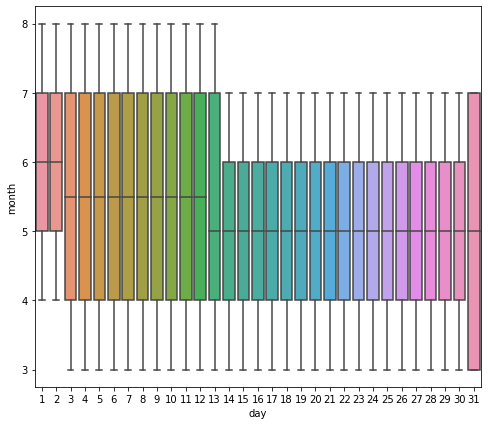

=============== diff  by  day =============== 



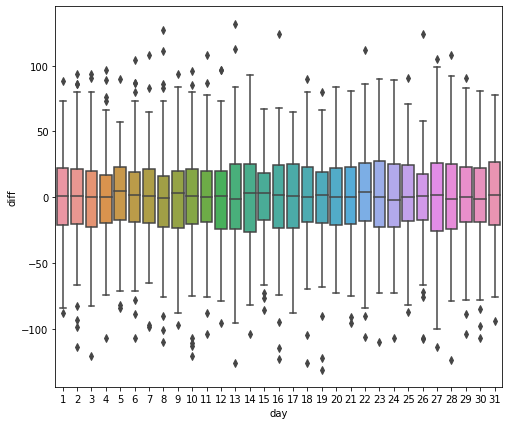

=============== trend_diff  by  day =============== 



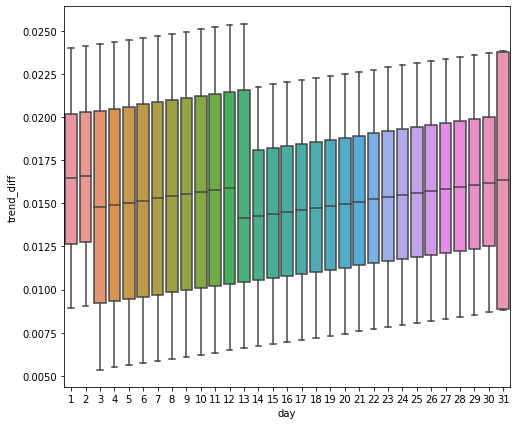

=============== lag_1  by  day =============== 



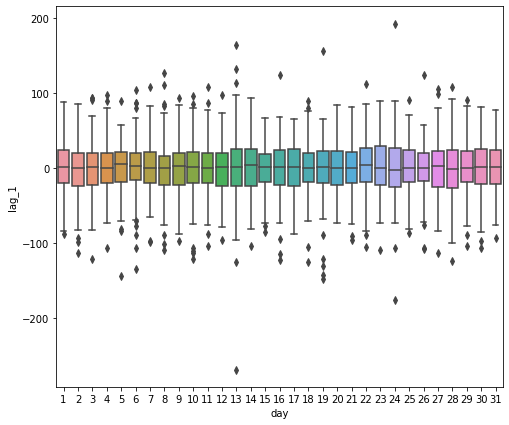

=============== lag_21  by  day =============== 



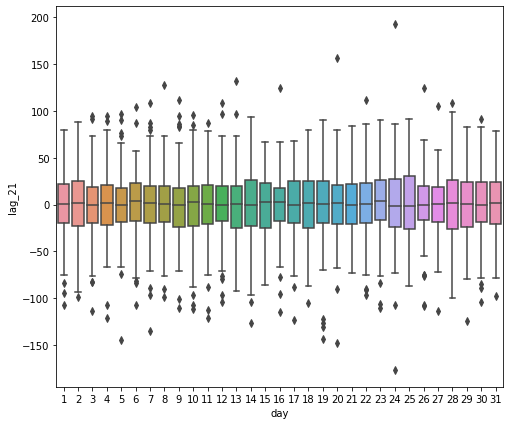

=============== lag_22  by  day =============== 



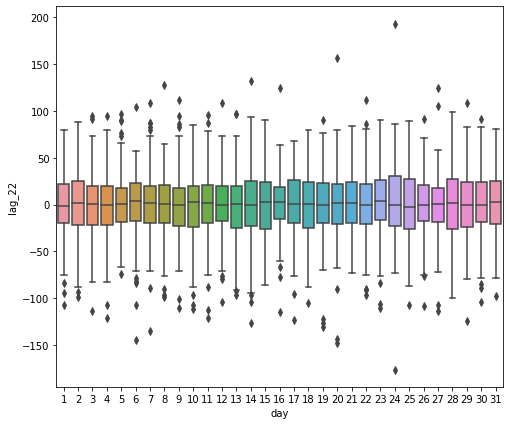

=============== lag_23  by  day =============== 



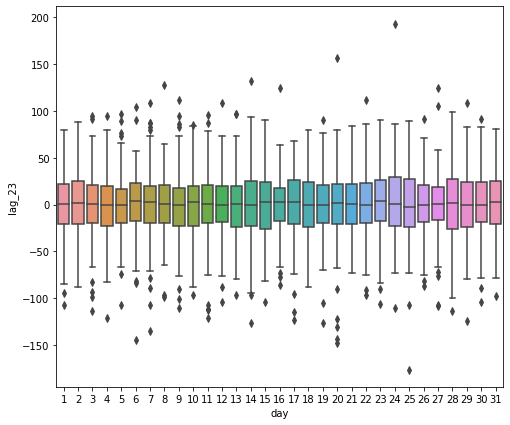

=============== lag_47  by  day =============== 



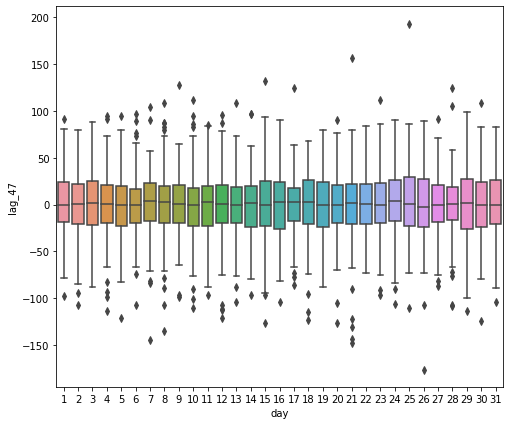

=============== rolling_mean  by  day =============== 



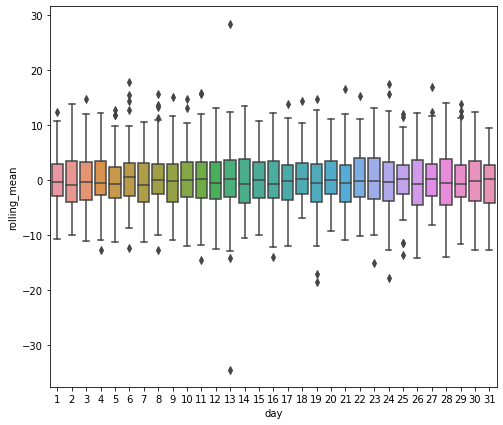

=============== month  by  weekday =============== 



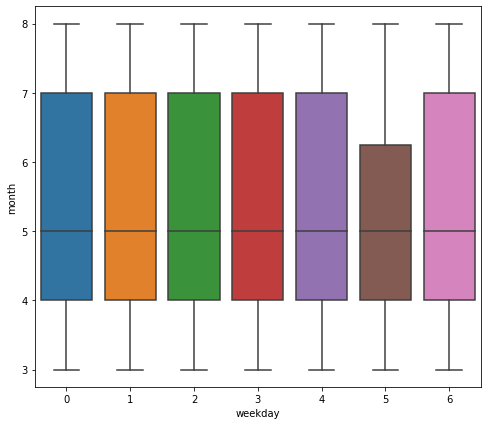

=============== diff  by  weekday =============== 



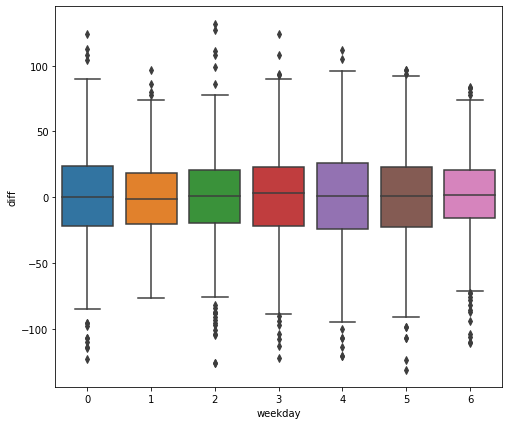

=============== trend_diff  by  weekday =============== 



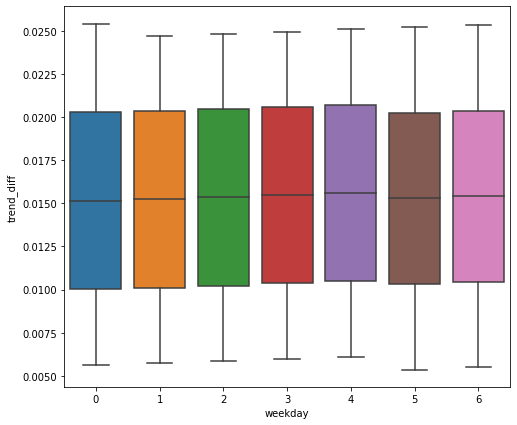

=============== lag_1  by  weekday =============== 



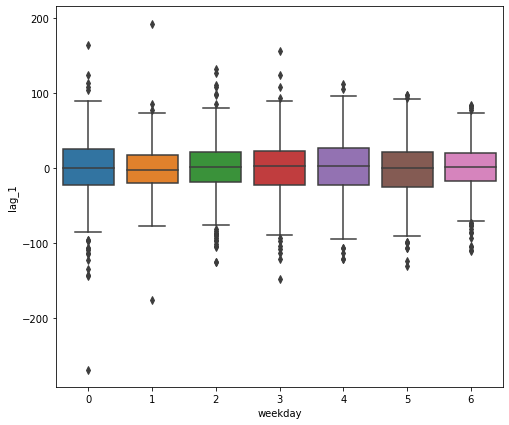

=============== lag_21  by  weekday =============== 



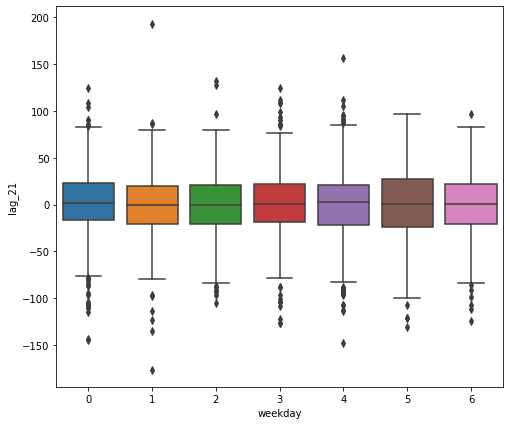

=============== lag_22  by  weekday =============== 



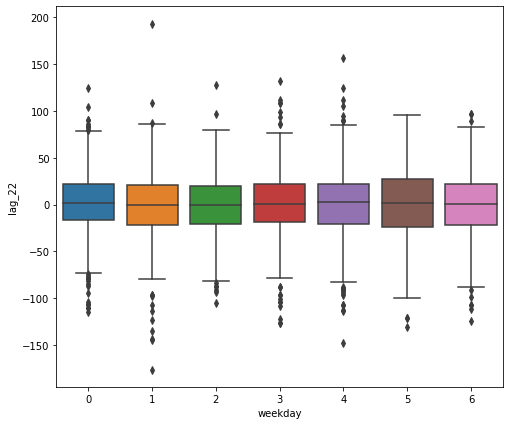

=============== lag_23  by  weekday =============== 



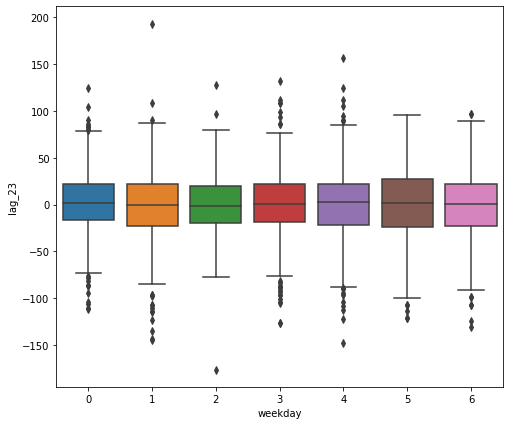

=============== lag_47  by  weekday =============== 



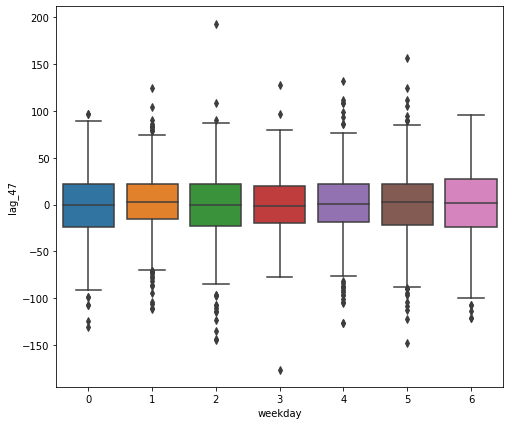

=============== rolling_mean  by  weekday =============== 



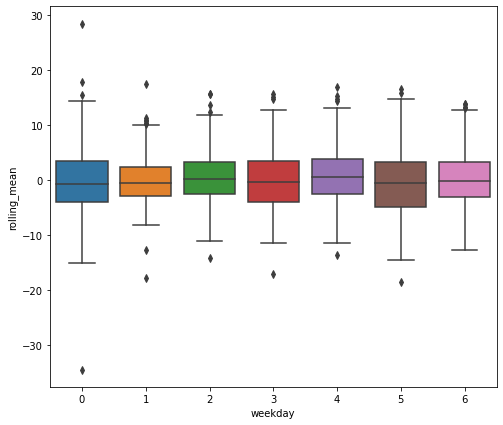

=============== month  by  week_of_month =============== 



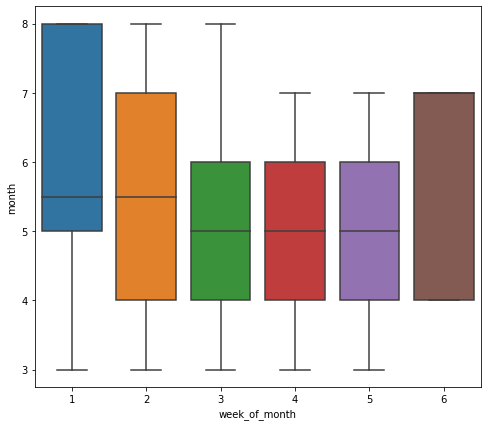

=============== diff  by  week_of_month =============== 



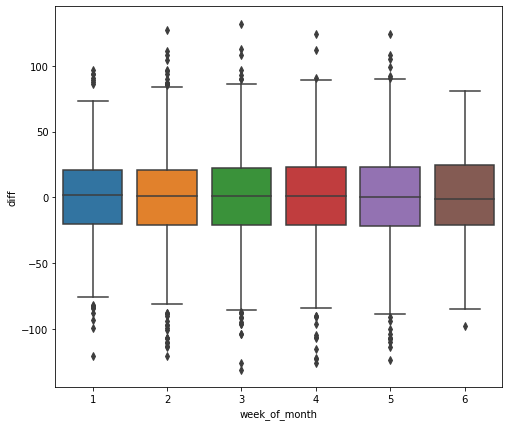

=============== trend_diff  by  week_of_month =============== 



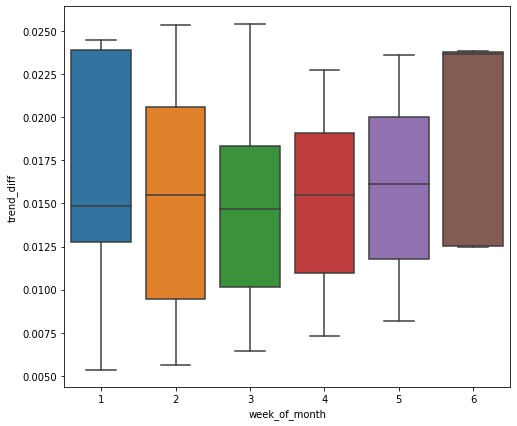

=============== lag_1  by  week_of_month =============== 



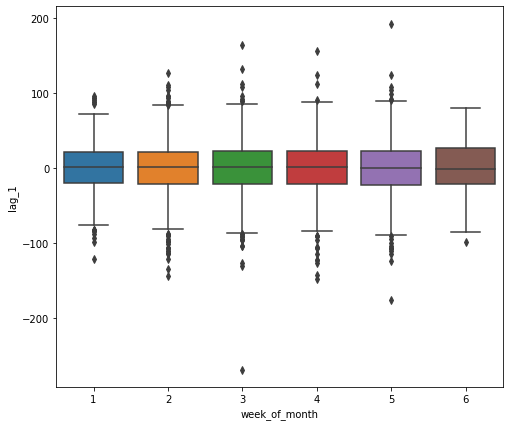

=============== lag_21  by  week_of_month =============== 



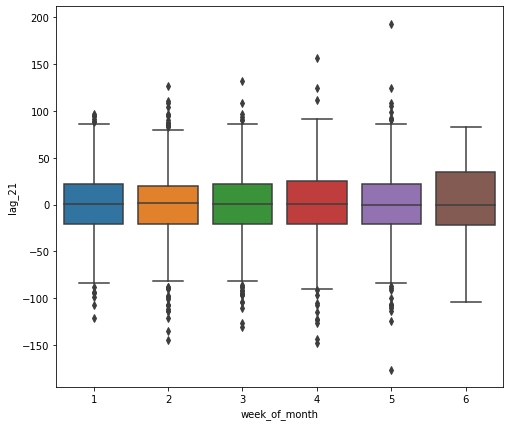

=============== lag_22  by  week_of_month =============== 



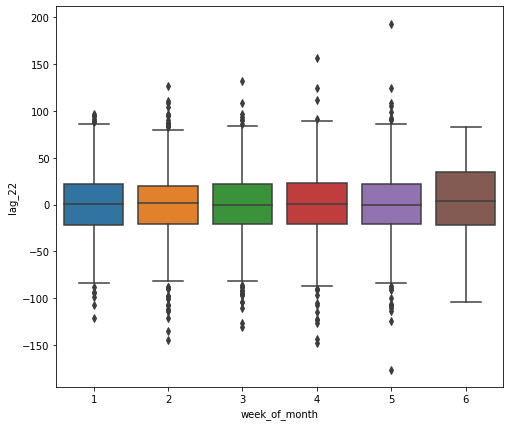

=============== lag_23  by  week_of_month =============== 



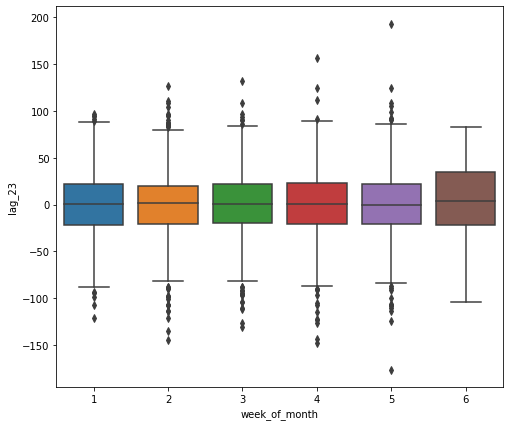

=============== lag_47  by  week_of_month =============== 



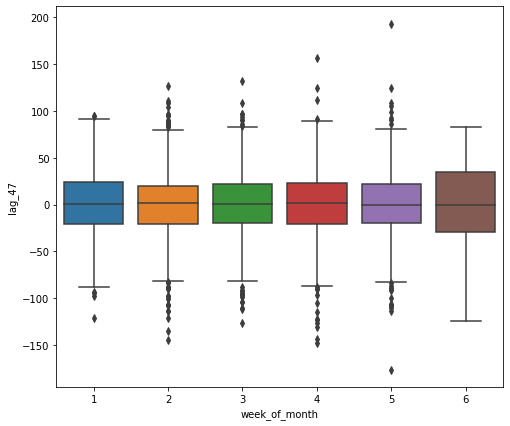

=============== rolling_mean  by  week_of_month =============== 



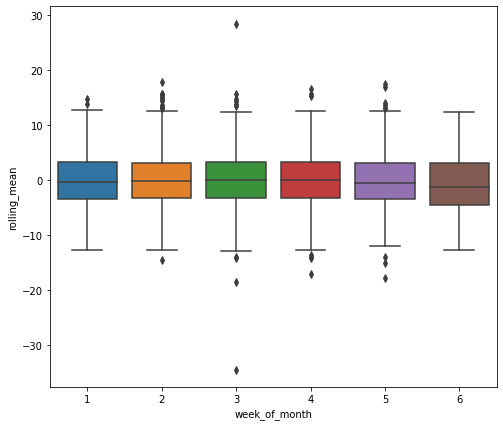

=============== month  by  hour =============== 



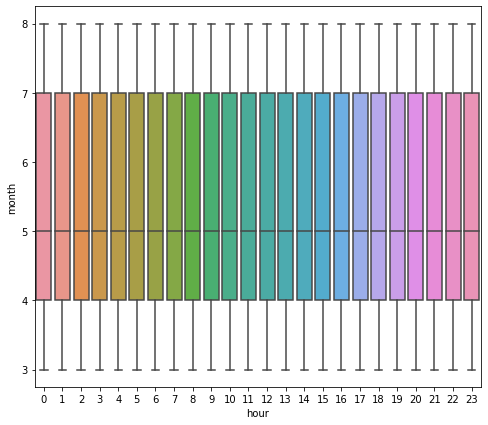

=============== diff  by  hour =============== 



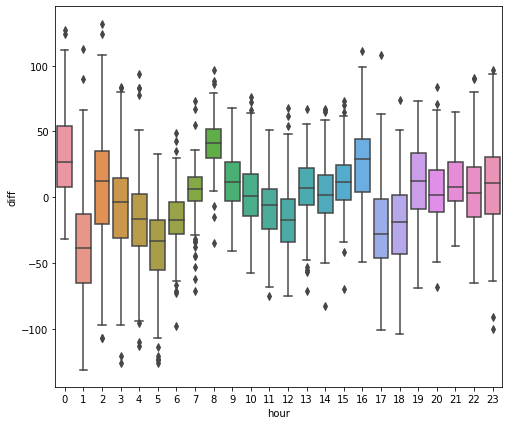

=============== trend_diff  by  hour =============== 



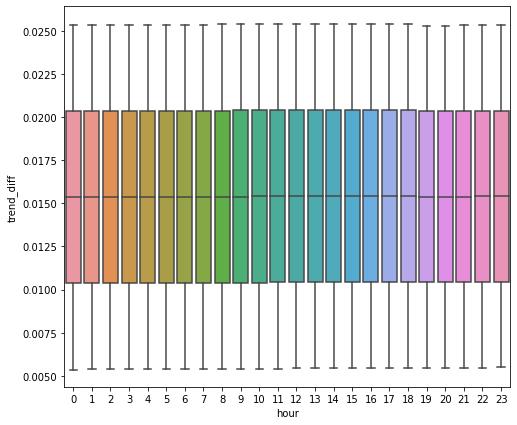

=============== lag_1  by  hour =============== 



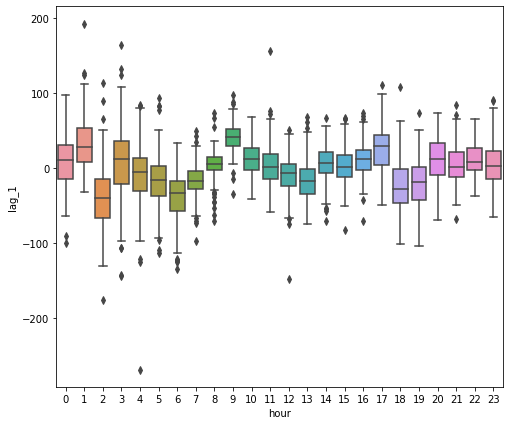

=============== lag_21  by  hour =============== 



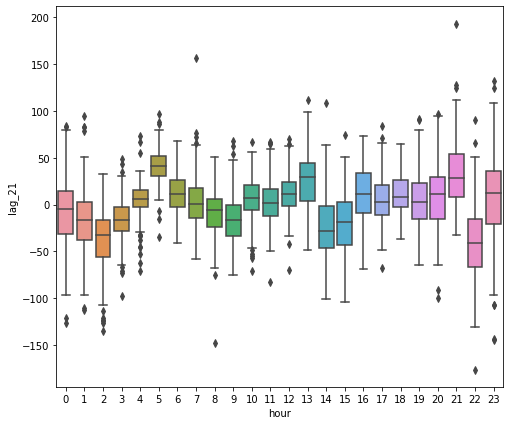

=============== lag_22  by  hour =============== 



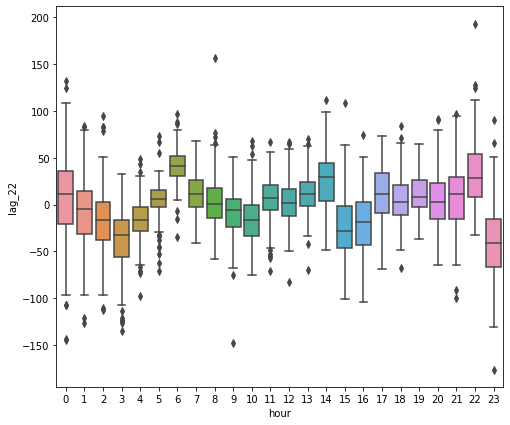

=============== lag_23  by  hour =============== 



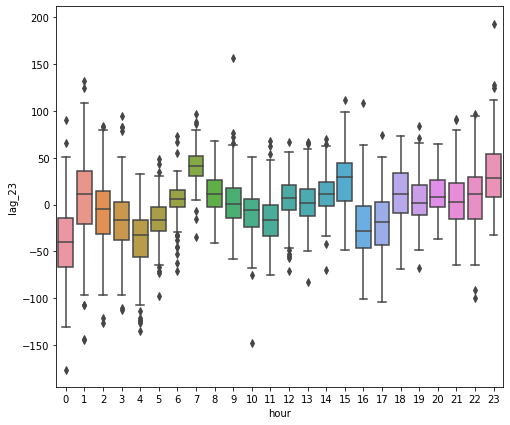

=============== lag_47  by  hour =============== 



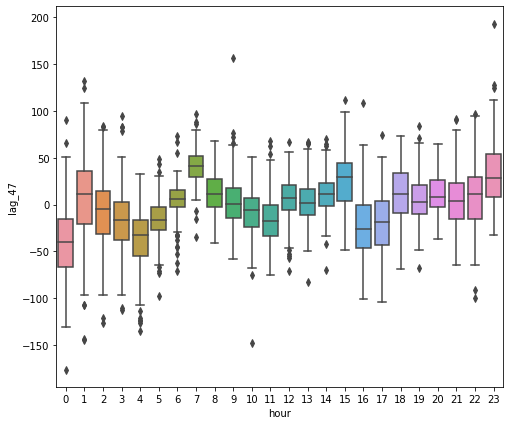

=============== rolling_mean  by  hour =============== 



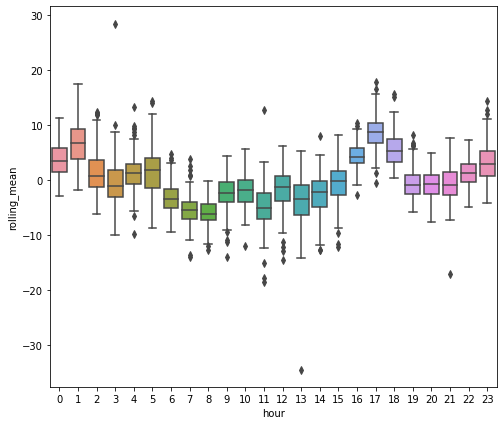

In [108]:
for cat_column in train_.select_dtypes(include='category').columns:
    for num_column in train_.select_dtypes(include='number').columns:
        print('===============',num_column,' by ', cat_column, '===============', '\n')
        fig_int = plt.figure(figsize=(8,7))
        fig_run = sns.boxplot(x=train_[cat_column], y = train_[num_column], data=train_)
        plt.show()

Let's examine which features are more correlated using the correlation matrix:

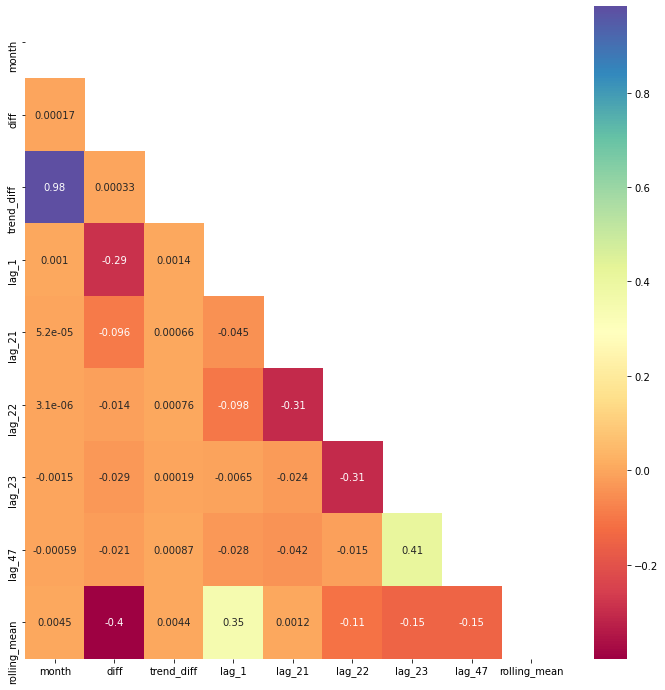

In [109]:
#Prepare mask matrix
corr_mat = train_.corr()
mask_mat = np.tril(np.ones(corr_mat.shape)).astype(bool)
np.fill_diagonal(mask_mat, False)  #remove diagonal to improve plot resolution

#Impose mask on correlation
corr_mat_lt = corr_mat.where(mask_mat)

#Plot matrix
fig1 = plt.figure(figsize=(12, 12))
#corr_mat = df.corr()
heat_map = sns.heatmap(corr_mat_lt, annot=True, cmap="Spectral")
#cntrl0 = plt.xticks(rotation=45)

#https://cmdlinetips.com/2020/02/lower-triangle-correlation-heatmap-python/

**Note that we do not see the contribution of the categorical features in a correlation matrix...**

Let's examine the pairplots:

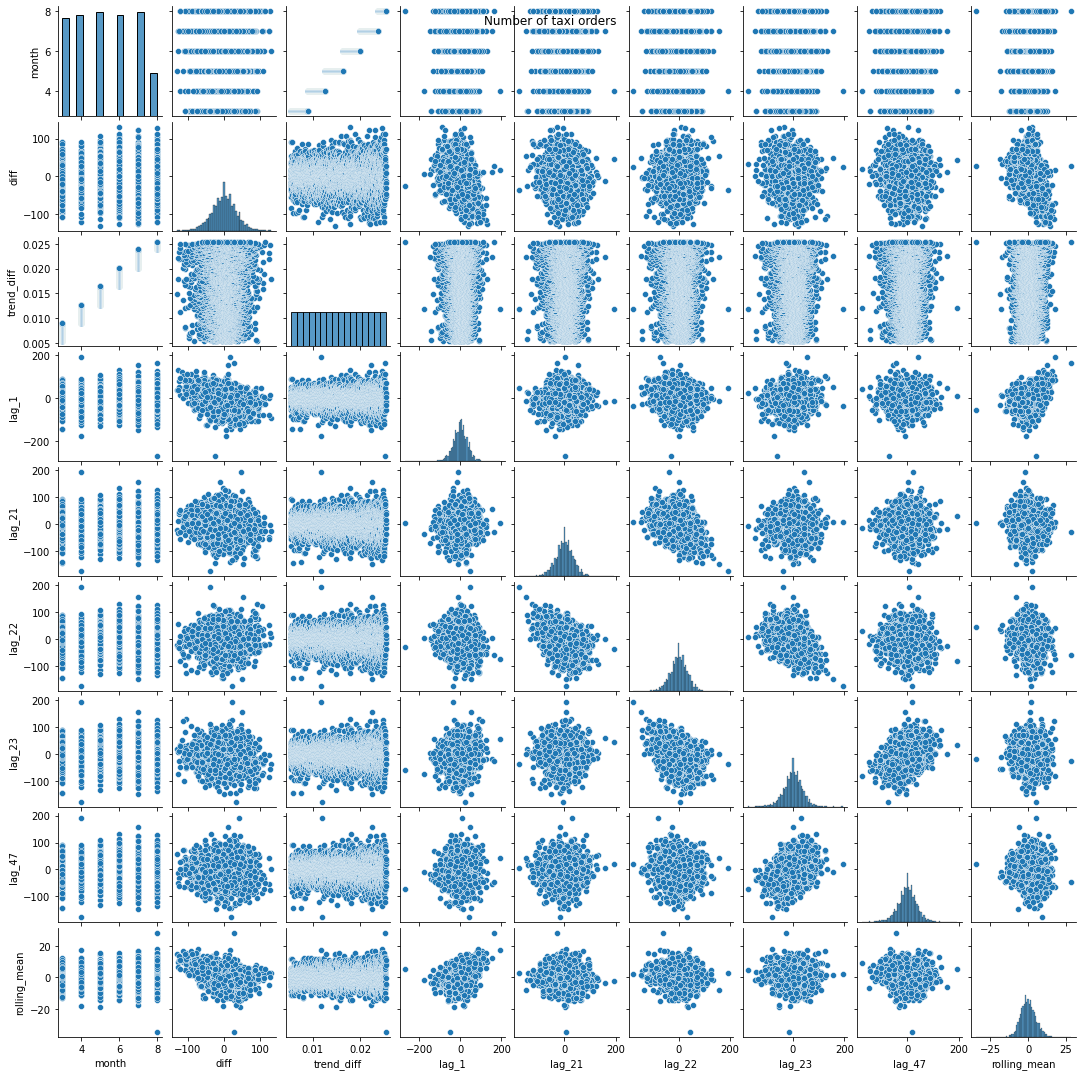

In [110]:
g = sns.pairplot(train_)#, plot_kws=dict(marker=df['Gearbox'].unique()))
fig1 = g.fig.suptitle("Number of taxi orders")
fig2 = g.fig.set_size_inches(15,15)
plt.show()

We can see that:
* The hour of day feature is very important and can attribute to considerable target differences.
* For the differences series, only the first lag provides a strong correlation to the target.  
The more distant lags are less significant.  
However, since we are lacking features as it is, we will leave them. 
* Interestingly, the trend difference is highly correlated with the month (probably since it is constantly growing with time).  
We will remove it.  
The month is a clearer to interpret and more direct feature.  

In [111]:
train_.drop(labels=['trend_diff'], axis=1, inplace=True)
test_.drop(labels=['trend_diff'], axis=1, inplace=True)

Remark:  

The correlation matrix does not cover the correlations between categorical variables.  
To cover this we need the Chi-square test, Cramer’s V or Theil’s U.  
We can also use the dython package.  
I will use the Chi-square test as it is the simplest and most classic:

The test assumptions are:  
H0: Variables are not correlated (independent).  
H1: Variables are correlated (dependent).  
p >= 0.05 -> Accept H0  
p < 0.05 -> Cannot accept H0  

https://stackoverflow.com/questions/48035381/correlation-among-multiple-categorical-variables-pandas  
https://thinkingneuron.com/how-to-measure-the-correlation-between-two-categorical-variables-in-python/  
https://medium.com/@knoldus/how-to-find-correlation-value-of-categorical-variables-23de7e7a9e26  
https://medium.com/@ritesh.110587/correlation-between-categorical-variables-63f6bd9bf2f7    
https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9  
https://www.youtube.com/watch?v=Pjw9dG2ixAk  
https://www.youtube.com/watch?v=HKDqlYSLt68

In [112]:
cats = list(train_.select_dtypes(include='category').columns)
cats

['day', 'weekday', 'week_of_month', 'hour']

In [113]:
for i, cati in enumerate(cats):
    j = i+1
    while j <= len(cats)-1:
        #print(i,j)
        CrosstabResult = pd.crosstab(index=train_[cats[i]], columns=train_[cats[j]])# ,normalize = True)
        #print('5X5 first elements of the cross table:')
        displaytab(CrosstabResult)#.iloc[:5,:5])
        ChiSqResult = chi2_contingency(CrosstabResult)
        #print(ChiSqResult)
        print('The P-Value of the ChiSq Test is:', ChiSqResult[1])
        if ChiSqResult[1] < 0.05:
            print(cats[i],
                  'and',
                  cats[j],
                  'variables could be correlated',
                  '\n\n')        
        else:
            print(cats[i],
                  'and',
                  cats[j],
                  'variables are not correlated',
                  '\n\n')               
        j += 1

#https://thinkingneuron.com/how-to-measure-the-correlation-between-two-categorical-variables-in-python/

weekday,0,1,2,3,4,5,6
day,,,,,,,
1,0,24,24,0,24,0,48
2,48,0,24,24,0,24,0
3,0,48,0,24,24,24,24
4,24,0,48,0,24,24,24
5,24,24,0,48,0,24,24
6,24,24,24,0,48,0,24
7,24,24,24,24,0,48,0
8,0,24,24,24,24,0,48
9,48,0,24,24,24,24,0


The P-Value of the ChiSq Test is: 0.0
day and weekday variables could be correlated 




week_of_month,1,2,3,4,5,6
day,,,,,,
1,120,0,0,0,0,0
2,72,48,0,0,0,0
3,96,48,0,0,0,0
4,72,72,0,0,0,0
5,48,96,0,0,0,0
6,24,120,0,0,0,0
7,0,144,0,0,0,0
8,0,144,0,0,0,0
9,0,96,48,0,0,0


The P-Value of the ChiSq Test is: 0.0
day and week_of_month variables could be correlated 




hour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,,,,
1,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
2,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
3,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
4,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
5,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
7,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
8,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
9,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6


The P-Value of the ChiSq Test is: 1.0
day and hour variables are not correlated 




week_of_month,1,2,3,4,5,6
weekday,,,,,,
0,0,144,139,120,120,48
1,24,144,120,120,120,24
2,48,144,120,120,120,0
3,48,144,120,120,120,0
4,72,144,120,120,96,0
5,96,144,120,120,96,0
6,144,144,120,120,48,0


The P-Value of the ChiSq Test is: 1.3276326365248542e-79
weekday and week_of_month variables could be correlated 




hour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
weekday,,,,,,,,,,,,,,,,,,,,,,,,
0,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,23,23,23,23,23
1,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23
2,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23
3,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23
4,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23
5,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24
6,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24


The P-Value of the ChiSq Test is: 1.0
weekday and hour variables are not correlated 




hour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
week_of_month,,,,,,,,,,,,,,,,,,,,,,,,
1,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18
2,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42
3,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,35,35,35,35,35
4,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35
5,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30
6,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3


The P-Value of the ChiSq Test is: 1.0
week_of_month and hour variables are not correlated 




Let's check our features prevalence:

In [114]:
for cat_column in train_.select_dtypes(include='category').columns:
    print('===============', cat_column, '===============', '\n')
    train_[cat_column].value_counts()

=============== day =============== 



11    144
3     144
4     144
5     144
6     144
7     144
8     144
9     144
10    144
12    144
13    139
27    120
24    120
25    120
26    120
1     120
28    120
29    120
30    120
22    120
23    120
16    120
21    120
20    120
19    120
18    120
17    120
2     120
15    120
14    120
31     72
Name: day, dtype: int64

=============== weekday =============== 



5    576
6    576
0    571
1    552
2    552
3    552
4    552
Name: weekday, dtype: int64

=============== week_of_month =============== 



2    1008
3     859
4     840
5     720
1     432
6      72
Name: week_of_month, dtype: int64

=============== hour =============== 



0     164
10    164
18    164
17    164
16    164
15    164
14    164
13    164
1     164
11    164
12    164
9     164
8     164
7     164
6     164
5     164
4     164
3     164
2     164
19    163
20    163
21    163
22    163
23    163
Name: hour, dtype: int64

Obviously, some of our categorical variables are correlated.  
You cannot have the 10th day of the month on its first week.  

We saw that the day of the month is highly correlated with weekday and week of the month.  
This suggests that we could drop this high cardinality feature (0-31 values).  
Its feature related information is kept through the low cardinality features that we will keep and one hot encode.  
We will target encode it to maintain its effect on the target.  
In this manner we will avoid the curse of dimensionality.  

For the hour of day feature we are not so lucky.  
It is not related to other features (obviously, all hours appear for all days and weeks...).  
We cannot drop it as it is highly correlated with our target (see box plots above).  
We will try to target encode it as well to avoid the curse of dimensionality.  
If performance will not be sufficient, we will one hot encode it.  

The week of the month and the weekday appear correlated.  
But, this could be due to the anomaly of the sixth week having only Mondays and Tuesdays.  
For weeks 2-4 of the month, the Weekday is almost arbitrary.  
I do not trust this result enough to drop any of these features.  

Scaling, imputation and encoding will be performed using the pipeline approach.

## ML model

### Establish pipeline

#### Prepare features and labels

In [115]:
X = train_.drop(labels=['diff'], axis=1).copy(deep=True)
y = train_['diff'].copy(deep=True)

Convert categorical to object type:

In [116]:
cat_columns = [z for z in X.select_dtypes(include='category').columns]
cat_columns

['day', 'weekday', 'week_of_month', 'hour']

In [117]:
for i,cat_colum in enumerate(cat_columns):
    X[cat_colum] = X[cat_colum].astype(str)

In [118]:
X.head()

,month,day,weekday,week_of_month,hour,lag_1,lag_21,lag_22,lag_23,lag_47,rolling_mean
datetime,,,,,,,,,,,
2018-03-03 00:00:00,3,3,5,1,0,-47.0,-11.0,-45.0,30.0,-39.0,2.7
2018-03-03 01:00:00,3,3,5,1,1,91.0,-44.0,-11.0,-45.0,-14.0,11.9
2018-03-03 02:00:00,3,3,5,1,2,-55.0,-9.0,-44.0,-11.0,-5.0,4.9
2018-03-03 03:00:00,3,3,5,1,3,-83.0,0.0,-9.0,-44.0,-23.0,-5.7
2018-03-03 04:00:00,3,3,5,1,4,39.0,-4.0,0.0,-9.0,-37.0,-1.9


In [119]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3931 entries, 2018-03-03 00:00:00 to 2018-08-13 18:00:00
Freq: H
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month          3931 non-null   int64  
 1   day            3931 non-null   object 
 2   weekday        3931 non-null   object 
 3   week_of_month  3931 non-null   object 
 4   hour           3931 non-null   object 
 5   lag_1          3931 non-null   float64
 6   lag_21         3931 non-null   float64
 7   lag_22         3931 non-null   float64
 8   lag_23         3931 non-null   float64
 9   lag_47         3931 non-null   float64
 10  rolling_mean   3931 non-null   float64
dtypes: float64(6), int64(1), object(4)
memory usage: 497.6+ KB


In [120]:
print(X.shape, y.shape)

(3931, 11) (3931,)


Repeat procedure for test data:

In [121]:
X_test = test_.drop(labels=['diff'], axis=1).copy(deep=True)
y_test = test_['diff'].copy(deep=True)
for i,cat_colum in enumerate(cat_columns):
    X_test[cat_colum] = X_test[cat_colum].astype(str)

In [122]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 437 entries, 2018-08-13 19:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month          437 non-null    int64  
 1   day            437 non-null    object 
 2   weekday        437 non-null    object 
 3   week_of_month  437 non-null    object 
 4   hour           437 non-null    object 
 5   lag_1          437 non-null    float64
 6   lag_21         437 non-null    float64
 7   lag_22         437 non-null    float64
 8   lag_23         437 non-null    float64
 9   lag_47         437 non-null    float64
 10  rolling_mean   437 non-null    float64
dtypes: float64(6), int64(1), object(4)
memory usage: 41.0+ KB


#### Preprocess data

Since this is a complicated process, we will test everything on the first 5 rows of the data:

In [123]:
Z=np.array(X.head())
Z

array([[3, '3', '5', '1', '0', -47.0, -11.0, -45.0, 30.0, -39.0, 2.7],
       [3, '3', '5', '1', '1', 91.0, -44.0, -11.0, -45.0, -14.0, 11.9],
       [3, '3', '5', '1', '2', -55.0, -9.0, -44.0, -11.0, -5.0, 4.9],
       [3, '3', '5', '1', '3', -83.0, 0.0, -9.0, -44.0, -23.0, -5.7],
       [3, '3', '5', '1', '4', 39.0, -4.0, 0.0, -9.0, -37.0, -1.9]],
      dtype=object)

##### **One Hot Encoder**

In [124]:
encoder = OneHotEncoder(sparse=False)
# transform data
onehot = encoder.fit_transform(Z[:, 1:5])

https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/  
https://www.analyticsvidhya.com/blog/2021/05/how-to-perform-one-hot-encoding-for-multi-categorical-variables/  

In [125]:
onehot

array([[1., 1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 0., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0., 1., 0., 0.],
       [1., 1., 1., 0., 0., 0., 1., 0.],
       [1., 1., 1., 0., 0., 0., 0., 1.]])

As day, weekday and week_of_month have only 1 value here, they will be encoded a 1 throughout (first 3 columns).  
The hour feature has 5 values. It will be encoded to 5 columns.  
Thus, we get:  
[0, 1, 0, 0, 0] column encoding first entry  
[0, 1, 0, 0, 0] column encoding second entry  
[0, 0, 1, 0, 0] column encoding third entry  
and so forth.

For linear regression, we **drop** the first value to avoid matrix inversion troubles.  
So we define a dedicated encoder:

https://inmachineswetrust.com/posts/drop-first-columns/
    
https://stats.stackexchange.com/questions/231285/dropping-one-of-the-columns-when-using-one-hot-encoding  
    
https://stats.stackexchange.com/questions/390671/random-forest-regression-with-sparse-data-in-python/430127#430127  
    
https://towardsdatascience.com/drop-first-can-hurt-your-ols-regression-models-interpretability-4ca529cfb707

In [126]:
lin_encoder = OneHotEncoder(drop='first', sparse=False)
# transform data
onehot_lin = lin_encoder.fit_transform(Z[:, 1:5])

In [127]:
onehot_lin

array([[0., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

Now  day, weekday and week_of_month have no columns and the hour feature has 5 categories encoded into 4 columns (0, the first is dropped).

##### **Ordinal Encoder**

Use ordinal encoder to encode features if necessary.  
Not label encoder in a loop (see below).  
https://datascience.stackexchange.com/questions/39317/difference-between-ordinalencoder-and-labelencoder  
https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-categorical-features

In [128]:
enc = preprocessing.OrdinalEncoder(categories='auto',
                                   dtype=np.float64,
                                   handle_unknown = 'use_encoded_value',
                                   unknown_value = -1,
                                   encoded_missing_value=np.nan)
Z_trans = enc.fit_transform(Z[:, 5:6])

# OrdinalEncoder is used to convert the features, while LabelEncoder for the target
# This avoids a loop on the features...
# https://www.kaggle.com/questions-and-answers/170936

In [129]:
Z_trans

array([[2.],
       [4.],
       [1.],
       [0.],
       [3.]])

Works as expected.  

**Remark:**  
This column was only chosen as a test case.  
We should ordinal encode only the month feature as it is the only categorical feature with real order.  
The month 3 has no value by itself, only as a first month. The same goes for month 4 that is in fact the second month and so forth. But their order does matter. So month is an ordinal variable.  
However, we do not really have to encode it.  
The scaler will give us the same results as if we first ordinal encoded it and then scaled it or if we just scale it:
* Scaling alone:  
3-8: 3-> (3-3)/(8-3)=0, 5-> (5-3)/(8-3)=2/5 ...
* Ordinal encoding and scaling:  
3-8-> 0-5  
3 -> (0-0)/(5-0)=0, 5-> (2-0)/(5-0)=2/5 ...  

So this encoder is useless for our project.

##### **Target Encoder**

Use target encoder with prior smoothing.  

We call the mean of the target the prior probability p(t = 1) and the encoding can use a parameter α that goes from 0 to 1, to balance this smoothing:
$$
encoding = \alpha \cdot p(t=1|x=c_i)+(1-\alpha) \cdot p(t=1)\\
    \alpha = \frac{1}{1+e^{-\frac{n-k}{f}}}
$$

smoothing_factor  - the f of the smoothing factor equation  
min_samples_leaf - the k of the smoothing factor equation  
n - the number of entries for the specific category  

https://contrib.scikit-learn.org/category_encoders/targetencoder.html  
https://towardsdatascience.com/dealing-with-categorical-variables-by-using-target-encoder-a0f1733a4c69  
https://medium.com/analytics-vidhya/target-encoding-vs-one-hot-encoding-with-simple-examples-276a7e7b3e64

In [130]:
tenc = TargetEncoder(min_samples_leaf=20, smoothing=10)
t_enc = tenc.fit_transform(Z[:, [1, 4]], y[:5])

Where I have taken the new default parameters - see here:  
https://github.com/scikit-learn-contrib/category_encoders/issues/327  

"  
I would suggest k=20 and f=10 as new default parameters. This gives:  
* 95% global mean for n=1
* 75% global mean for n=10
* 50% global mean for n=20
* 75% specific mean for n=30
* almost all specific mean for n>50  
"

In [131]:
t_enc

,0,1
datetime,,
2018-03-03 00:00:00,-5.6,-5.6
2018-03-03 01:00:00,-5.6,-5.6
2018-03-03 02:00:00,-5.6,-5.6
2018-03-03 03:00:00,-5.6,-5.6
2018-03-03 04:00:00,-5.6,-5.6


In our small example:  

The 'day' column has a single value.  
The 'hour' column has 5 different values.  
The total mean of diff (the mean of the target prior probability) is y.head().mean() (see below).  
As we can see, that is the mean of all target values.  
Since the 'hour' column has 5 different values with equal frequency, it yields the same target encoding (see below).

In [132]:
y.head()

datetime
2018-03-03 00:00:00    91.0
2018-03-03 01:00:00   -55.0
2018-03-03 02:00:00   -83.0
2018-03-03 03:00:00    39.0
2018-03-03 04:00:00   -20.0
Freq: H, Name: diff, dtype: float64

In [133]:
y.head().mean()

-5.6

In [134]:
#Alfa calculations:

k = 20
f = 10

for n in np.arange(1,21):
    alfa = 1/(1+math.exp(-(n-k)/f)) #1 sample
    print(n,alfa)

1 0.13010847436299786
2 0.14185106490048777
3 0.1544652650835347
4 0.16798161486607552
5 0.18242552380635635
6 0.19781611144141825
7 0.2141650169574414
8 0.23147521650098238
9 0.24973989440488234
10 0.2689414213699951
11 0.289050497374996
12 0.31002551887238755
13 0.3318122278318339
14 0.35434369377420455
15 0.3775406687981454
16 0.401312339887548
17 0.425557483188341
18 0.45016600268752216
19 0.47502081252106
20 0.5


In [135]:
print('Total data mean:', y.head().mean())
# For hour:
n = 5
alfa5 = 1/(1+math.exp(-(n-k)/f)) #5 samples
alfa5
print('Model=hour encoding:', alfa5*(y.head().sum())/5+(1-alfa5)*y.head().mean())

Total data mean: -5.6


0.18242552380635635

Model=hour encoding: -5.6


**We have no nulls in this dataset (we are removing them), so this section is omitted.**

In [136]:
##########################################################################

##### **Imputation**

Let's fill the nulls using the k-Nearest Neighbor method.  
This approach considers other features during imputation. 

Let's define the imputer:

In [137]:
#Option 1 - KNN  
#imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

#Option 2 - Iterative
#imputer = IterativeImputer(estimator=BayesianRidge(), n_nearest_features=None, imputation_order='ascending')

#Z_imp=imputer.fit_transform(Z_trans)

#https://stackoverflow.com/questions/64900801/implementing-knn-imputation-on-categorical-variables-in-an-sklearn-pipeline
#https://machinelearningmastery.com/knn-imputation-for-missing-values-in-machine-learning/
#https://machinelearningmastery.com/iterative-imputation-for-missing-values-in-machine-learning/
#https://stackoverflow.com/questions/63661866/ordinal-encoder-issues-with-nan-values
# https://towardsdatascience.com/preprocessing-encode-and-knn-impute-all-categorical-features-fast-b05f50b4dfaa
# https://datascience.stackexchange.com/questions/47409/target-encoding-missing-value-imputation-before-or-after-encoding

In [138]:
#Z_imp

As we can see, the nulls are simply the averages of the remaining 4 entries as there are no other entries:  
nan @ [1,3] = (3+2+1)/4=1.5  
And so forth...  

In [139]:
# print missing
#print('Originally Missing: %d' % np.count_nonzero(pd.isna(Z_trans)))
#print('Missing Following Imputation: %d' % np.count_nonzero(pd.isna(Z_imp)))

In [140]:
##########################################################################

##### **Scaling**

In [141]:
MMscaler = MinMaxScaler()

#fit_transform the training set
Z_scaled = MMscaler.fit_transform(Z)
#As data frame if required
#Z_scaled = pd.DataFrame(MMscaler.fit_transform(X), index=X.index, columns = X.columns)

In [142]:
pd.DataFrame(Z_scaled)

,0,1,2,3,4,5,6,7,8,9,10
0,0.0,0.0,0.0,0.0,0.00,0.206897,0.750000,0.000000,1.000000,0.000000,0.477273
1,0.0,0.0,0.0,0.0,0.25,1.000000,0.000000,0.755556,0.000000,0.735294,1.000000
2,0.0,0.0,0.0,0.0,0.50,0.160920,0.795455,0.022222,0.453333,1.000000,0.602273
3,0.0,0.0,0.0,0.0,0.75,0.000000,1.000000,0.800000,0.013333,0.470588,0.000000
4,0.0,0.0,0.0,0.0,1.00,0.701149,0.909091,1.000000,0.480000,0.058824,0.215909


The first 4 columns have only one value - that is receiving the value of zero.  
For instance - the fifth column (hour) is:
[0, 1, 2, 3, 4]
and it is scaled appropriately to:
[0, 0.25, 0.5, 0.75, 1]

The code behind the minMax scaling is much alike:  
minVec = df[var].min()
maxVec = df[var].max()  
df[continuous_vars] = (df[continuous_vars]-minVec)/(maxVec-minVec) 
  
Remark:  
The scaling is needed for linear regression and not decision trees or other advanced models.

##### **ColumnTransformer**

Now that we have validated our transformers, let's define a ColumnTransformer to split the transformations between the appropriate columns.  
The ColumnTransformer is a class that allows to selectively apply data preparation transforms.  
For example, it allows a specific transform or sequence of transforms to just the numerical columns, and a separate sequence of transforms to just the categorical columns and so forth.  
To use the ColumnTransformer, you must specify a list of transformers.  
Each transformer is a three-element tuple that defines the name of the transformer, the transform to apply, and the column indices to apply it to.  
For example:  
(Name, Object, Columns)  
Let's use it for our data:  
https://machinelearningmastery.com/columntransformer-for-numerical-and-categorical-data/  
https://towardsdatascience.com/guide-to-encoding-categorical-features-using-scikit-learn-for-machine-learning-5048997a5c79
https://machinelearningmastery.com/columntransformer-for-numerical-and-categorical-data/

Determine each feature designation for the transformer:  
(numerical for scaling, categorical for OHE or Target Encoding)

In [143]:
X.columns

Index(['month', 'day', 'weekday', 'week_of_month', 'hour', 'lag_1', 'lag_21',
       'lag_22', 'lag_23', 'lag_47', 'rolling_mean'],
      dtype='object')

In [144]:
num_ix = [0] + list(np.arange(5,11))  #X.select_dtypes(include=['float64']).columns     #'int64', 
cat_te_ix = [1, 4]          # ['day', 'hour']
cat_ohe_ix = [2, 3]         # ['weekday', 'week_of_month']
scl_ix = cat_te_ix + num_ix # columns to be scaled

Define data preparation ColumnTransformer for the specific columns:  
(Name, Object, Columns)

In [145]:
#regular cases

t = [('cat_te', TargetEncoder(min_samples_leaf=20, smoothing=10), cat_te_ix),
     ('cat_ohe', OneHotEncoder(sparse=False, handle_unknown = 'infrequent_if_exist'), cat_ohe_ix)]
#generate new category - infrequent if exists in test but not in train

col_transform = ColumnTransformer(transformers=t, remainder='passthrough') #pass any non transformed column ahead

In [146]:
#regular cases ordinal

t_ord = [('cat_te', TargetEncoder(min_samples_leaf=20, smoothing=10), cat_te_ix),
         ('cat_ord', preprocessing.OrdinalEncoder(categories='auto',
                                                  dtype=np.float64,
                                                  handle_unknown = 'use_encoded_value',
                                                  unknown_value = -1,
                                                  encoded_missing_value=np.nan), cat_ohe_ix)]

col_transform_ord = ColumnTransformer(transformers=t_ord, remainder='passthrough') #pass any non transformed column ahead

In [147]:
#linear regression (drop first option)

t_lin = [('cat_te', TargetEncoder(min_samples_leaf=20, smoothing=10), cat_te_ix),
         ('cat_ohe', OneHotEncoder(drop='first', sparse=False, handle_unknown = 'infrequent_if_exist'), cat_ohe_ix)]
#generate new category - infrequent if exists in test but not in train

col_transform_lin = ColumnTransformer(transformers=t_lin, remainder='passthrough') #pass any non transformed column ahead

In [148]:
Z_trans = col_transform_lin.fit_transform(X=Z,y=y.head())

#https://github.com/scikit-learn-contrib/category_encoders/blob/master/examples/column_transformer_example.py
#https://stackoverflow.com/questions/62880686/pipeline-with-and-without-target-based-encoding

Let's check the result:

In [149]:
pd.DataFrame(Z)

,0,1,2,3,4,5,6,7,8,9,10
0,3,3,5,1,0,-47.0,-11.0,-45.0,30.0,-39.0,2.7
1,3,3,5,1,1,91.0,-44.0,-11.0,-45.0,-14.0,11.9
2,3,3,5,1,2,-55.0,-9.0,-44.0,-11.0,-5.0,4.9
3,3,3,5,1,3,-83.0,0.0,-9.0,-44.0,-23.0,-5.7
4,3,3,5,1,4,39.0,-4.0,0.0,-9.0,-37.0,-1.9


In [150]:
pd.DataFrame(Z_trans)
Z_trans.shape

,0,1,2,3,4,5,6,7,8
0,-5.6,-5.6,3,-47.0,-11.0,-45.0,30.0,-39.0,2.7
1,-5.6,-5.6,3,91.0,-44.0,-11.0,-45.0,-14.0,11.9
2,-5.6,-5.6,3,-55.0,-9.0,-44.0,-11.0,-5.0,4.9
3,-5.6,-5.6,3,-83.0,0.0,-9.0,-44.0,-23.0,-5.7
4,-5.6,-5.6,3,39.0,-4.0,0.0,-9.0,-37.0,-1.9


(5, 9)

TE  
* The target encoding works (see results above) and moves the high cardinality columns 'day' (1) and 'hour' (4) to columns 0-1  

OHE  
* columns 2-3 are the 'weekday' and 'week_of_month'. They are single valued here, so they are omitted after ohe due to the drop first option.

* The numerical features are passed on (column 2 representing column 0 - 'month', and so forth)  

Total:  
* We get a total of columns as listed above - just fine.  
In the full dataset we will have more features generated from the ohe (0-6 for weekday and 0-5 for week_of_month)

In [151]:
#imputer = KNNImputer(n_neighbors=3, weights='uniform', metric='nan_euclidean')
mmscl = MinMaxScaler()

# define the data preparation pipeline
pipeline_pre = Pipeline(steps=[
    ('col', col_transform_lin),
    #('imp', imputer),
    ('scl', mmscl)])

In [152]:
Z_pipe1=pipeline_pre.fit_transform(X=Z,y=y.head())
pd.DataFrame(Z_pipe1)
Z_pipe1.shape

,0,1,2,3,4,5,6,7,8
0,0.0,0.0,0.0,0.206897,0.750000,0.000000,1.000000,0.000000,0.477273
1,0.0,0.0,0.0,1.000000,0.000000,0.755556,0.000000,0.735294,1.000000
2,0.0,0.0,0.0,0.160920,0.795455,0.022222,0.453333,1.000000,0.602273
3,0.0,0.0,0.0,0.000000,1.000000,0.800000,0.013333,0.470588,0.000000
4,0.0,0.0,0.0,0.701149,0.909091,1.000000,0.480000,0.058824,0.215909


(5, 9)

For instance, for element (0,5) we get:

In [153]:
(-47-(-83))/(91-(-83))

0.20689655172413793

In [154]:
(Z[0,5]-Z[:,5].min())/(Z[:,5].max()-Z[:,5].min())

0.20689655172413793

The scaling is fine.  

#### **Define models**

In [155]:
#imputer = KNNImputer(n_neighbors=3, weights='uniform', metric='nan_euclidean')
mmscl = MinMaxScaler()
model = LinearRegression() #model

# define the data preparation pipeline
pipeline = Pipeline(steps=[
    ('col', col_transform_lin),
    #('imp', imputer),
    ('scl', mmscl),
    ('m', model)])

In [156]:
Z_pipe2=pipeline.fit(X=Z,y=y.head())
Z_pipe2

Pipeline(steps=[('col',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_te',
                                                  TargetEncoder(min_samples_leaf=20,
                                                                smoothing=10),
                                                  [1, 4]),
                                                 ('cat_ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                sparse=False),
                                                  [2, 3])])),
                ('scl', MinMaxScaler()), ('m', LinearRegression())])

In [157]:
Z_pipe3=pipeline.predict(X=Z)
Z_pipe3

array([ 91., -55., -83.,  39., -20.])

In [158]:
y.head()

datetime
2018-03-03 00:00:00    91.0
2018-03-03 01:00:00   -55.0
2018-03-03 02:00:00   -83.0
2018-03-03 03:00:00    39.0
2018-03-03 04:00:00   -20.0
Freq: H, Name: diff, dtype: float64

In [159]:
Z1=np.array(X.iloc[5:10])
pd.DataFrame(Z1)

,0,1,2,3,4,5,6,7,8,9,10
0,3,3,5,1,5,-20.0,39.0,-4.0,0.0,6.0,-4.5
1,3,3,5,1,6,-29.0,-1.0,39.0,-4.0,3.0,-3.4
2,3,3,5,1,7,-6.0,9.0,-1.0,39.0,19.0,-8.4
3,3,3,5,1,8,8.0,37.0,9.0,-1.0,35.0,-8.4
4,3,3,5,1,9,39.0,-55.0,37.0,9.0,-5.0,-6.3


In [160]:
pipeline.predict(X=Z1)

array([-370.94531174, -243.04097153, -391.00178158, -568.93368642,
        -80.00772972])

In [161]:
y.iloc[5:10]

datetime
2018-03-03 05:00:00   -29.0
2018-03-03 06:00:00    -6.0
2018-03-03 07:00:00     8.0
2018-03-03 08:00:00    39.0
2018-03-03 09:00:00    17.0
Freq: H, Name: diff, dtype: float64

No need to expect reasonable prediction...  
We are just checking the process.

#### **Define RMSE custom wrap scorer for the pipeline**

In [162]:
def root_mean_squared_error(y_true, y_pred):
    root_mean_squared_error = prt(mean_squared_error, squared=False)
    return root_mean_squared_error (y_true, y_pred)

#check function
print(root_mean_squared_error([0, 1, 2],[1, 2, 3]))

#rms_error = make_scorer(root_mean_squared_error)

#https://www.geeksforgeeks.org/partial-functions-python/
#https://stackoverflow.com/questions/66509049/how-can-i-use-rmse-as-my-scoring-metric-for-my-time-series-split-grid-search

1.0


In [163]:
print(X.shape, y.shape)
print(X_test.shape, y_test.shape)

(3931, 11) (3931,)
(437, 11) (437,)


#### **Define Time series cross validation scheme**

In [164]:
#define train window length
train_win=math.floor(X.shape[0]/1.5)
train_win
#define test window length
test_win=math.floor(train_win/10)
test_win

2620

262

Explanation:  
1. I kept the ratio of a 10% test set to train set ratio as requested by the client
2. At this ratio, we have:  
$$len(data)=train_{win}+n_{split} \cdot test_{win}$$  
(see figure below, we need to cover all the train data with the cross-validation train set and n_split times the cross-validation test set).  
We impose a 10% test/train ratio so:  
$$
len(data)=train_{win}+n_{split} \cdot \frac{train_{win}}{10}\\
n_{split} = 5 \rightarrow\\
train_{win} = \frac{len(data)}{1.5}
$$

In [165]:
ts_cv = TimeSeriesSplit(n_splits=5, gap=0, max_train_size=train_win, test_size=test_win) #new version

TRAIN 1 indexes: 1 - 2620 
TEST 1 indexes: 2621 - 2882
TRAIN 1 days: 2018-03-03 - 2018-06-20 
TEST 1 days: 2018-06-20 - 2018-07-01


TRAIN 2 indexes: 263 - 2882 
TEST 2 indexes: 2883 - 3144
TRAIN 2 days: 2018-03-13 - 2018-07-01 
TEST 2 days: 2018-07-01 - 2018-07-12


TRAIN 3 indexes: 525 - 3144 
TEST 3 indexes: 3145 - 3406
TRAIN 3 days: 2018-03-24 - 2018-07-12 
TEST 3 days: 2018-07-12 - 2018-07-22


TRAIN 4 indexes: 787 - 3406 
TEST 4 indexes: 3407 - 3668
TRAIN 4 days: 2018-04-04 - 2018-07-22 
TEST 4 days: 2018-07-22 - 2018-08-02


TRAIN 5 indexes: 1049 - 3668 
TEST 5 indexes: 3669 - 3930
TRAIN 5 days: 2018-04-15 - 2018-08-02 
TEST 5 days: 2018-08-02 - 2018-08-13




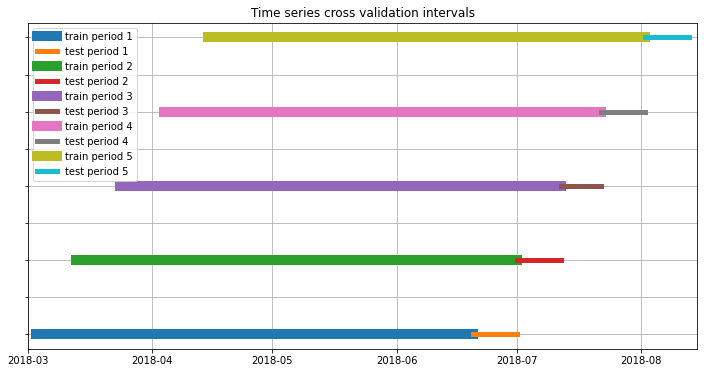

In [166]:
i=1
plt_1 = plt.figure(figsize=(12, 6))
for train_index, test_index in ts_cv.split(X):
    print(f"TRAIN {i} indexes:", train_index[0], '-', train_index[-1],
          f"\nTEST {i} indexes:", test_index[0], '-', test_index[-1])
    print(f"TRAIN {i} days:", 
          X.iloc[[train_index[0]]].index.date[0], 
          '-', 
          X.iloc[[train_index[-1]]].index.date[0],
          f"\nTEST {i} days:", 
           X.iloc[[test_index[0]]].index.date[0], 
          '-', 
          X.iloc[[test_index[-1]]].index.date[0])
    x_=[X.iloc[[train_index[0]]].index.date[0], X.iloc[[train_index[-1]]].index.date[0]]
    y_=[i,i]
    train_line = plt.plot(x_,y_,label=f'train period {i}',linewidth=10)
    x_=[X.iloc[[test_index[0]]].index.date[0], X.iloc[[test_index[-1]]].index.date[0]]
    train_line = plt.plot(x_,y_, label=f'test period {i}', linewidth=5)
    i+=1
    print('\n')
    
rmoveylabels = plt.gca().yaxis.set_ticklabels([])
grd = plt.grid()
tit = plt.title('Time series cross validation intervals')
win = plt.xlim([date(2018, 3, 1), date(2018, 8, 15)])
leg = plt.legend()
plt.show()

Remark  
In the figure above there is no overlap between the test and train periods, check indexes above.  
It is a side effect of choosing the same day...

### Run pipeline

#### Linear regression

Note that I will be running each model once and storing the main results as text so as to save time resources.  
At any given time the code can be exposed again but I in this manner a reviewer has the option to save his/her precious time...

In [167]:
# define the data preparation pipeline
pipeline = Pipeline(steps=[
    ('col', col_transform_lin),
    #('imp', imputer),
    ('scl', mmscl),
    ('m', model)])

#----define the model cross-validation configuration
#cv = KFold(n_splits=5, shuffle=True, random_state=1)    #old version
# new version defined above

#define train window as 4 days = 14*24 hr


# records the time at this instant of the program
start = time.perf_counter()

#----evaluate the pipeline using cross validation and calculate error
#scores = cross_val_score(pipeline, X, y, scoring=rms_error, cv=cv, n_jobs=-1) #old version
scores = cross_val_score(pipeline, X, y, scoring='neg_root_mean_squared_error', cv=ts_cv, n_jobs=-1) #new version

# record the time at the end instant of the program
end = time.perf_counter()
  
# convert scores to positive values
scores = abs(scores)

I established a rolling forecast above.     
https://www.youtube.com/watch?v=3k7qk__5tDY      
https://www.youtube.com/watch?v=sFPA599o1AQ  
https://www.youtube.com/watch?v=QWcyWlZF12Q  
https://www.youtube.com/watch?v=Dusc7smwKGc  
https://www.youtube.com/watch?v=g9iO2AwTXyI  
https://www.youtube.com/watch?v=oGqsyv49Wvo

Procedure:
1. Split the data into 5 series (not parts!).  
There are 5 training sets each with its own following 10% test set.  
The time window is rolling.  
Each validation test set is then added to the next set train set.  
2. Use the column transformer to prepare the training set data
3. Train the regressor.
4. Make predictions on the test set using the trained regressor
5. Evaluate the accuracy of the predictions
6. Repeat steps 1-5 another 4 times (to a total of 5).
7. Average/STD the 5 scores

The pipelines first splits the data and only then applies the procedure.  
Thus ensuring no data leakage.

Summarize model performance

In [168]:
def perf(pipe_model, pipe_scores, run_end, run_start):
    print('Model - ', f'{pipe_model}')
    # printing the execution time by subtracting the time before the function from the time after the function
    print('Run time - ', round((run_end-run_start)/60,2), 'min')
    print('Scores ', pipe_scores)
    print('Scores Mean - %.3f, Scores Std - %.3f' % (np.mean(scores), np.std(scores)))

In [169]:
perf(model, scores, end, start)

Model -  LinearRegression()
Run time -  0.01 min
Scores  [27.99742985 28.30646709 33.17220492 32.90546706 35.10765851]
Scores Mean - 31.498, Scores Std - 2.837


Remarks:  
1. Since the dataset is small, I tests several cross validation folds.  
5 folds yields the best results:  
2. The calculated RMSE is not the requested final RMSE for the number of orders because our target is the orders differences and not the orders themselves.  
After we select the best performing model, we will calculate its final target RMSE by tracing the differences back to the orders themselves.  
There is an assumption here - that the model best prediction the differences is the one best predicting the final target.  
We cannot prove it for now without considerable additional research but if we meet the customer request for RMSE<48 we are fine.

### Find optimal pipeline hyper-parameters

#### Decision Tree

Define function to run pipeline.  
The function uses:
* model name (e.g., 'dt'/'rf'..)
* model type (e.g., DecisionTreeRegressor)
* specific model hyperparameters (e.g., dt__max_depth..)

In [170]:
def run(model_name, model_, params_, column_transformer):
    
    # define pipeline
    
    pipeline = Pipeline(steps=[
        ('col', column_transformer),
        #('imp', imputer),
        ('scl', mmscl),
        (model_name, model_)]) # must be the same name as used above in param_grid
    
    # records the time at this instant of the program
    start = time.perf_counter()
    
    #----define the model cross-validation configuration
    #No need to redefine again., defined above
    
    gs = GridSearchCV(pipeline, 
                      param_grid=params_,
                      #cv=cv,                                #old version
                      cv=ts_cv,                              #new version
                      #scoring=rms_error,                    #old version
                      scoring='neg_root_mean_squared_error', #new version
                      verbose=0,
                      return_train_score = True,
                      refit=True)
    
    #fit
    gs.fit(X, y)
    
    # record the time at the end instant of the program
    end = time.perf_counter()
    
    #Output performance:
    print('Model - ', f'{model}')
    # printing the execution time by subtracting the time before the function from the time after the function
    print('Run time - ', round((end-start)/60,2), 'min')
    print('Best_score -', abs(gs.best_score_))
    print('Best_params -', gs.best_params_)

https://www.youtube.com/watch?v=f_xB7kbZR_g

In [172]:
# define model
model = DecisionTreeRegressor() #name=dt

#define model parameters
params = {'dt__max_depth': [5, 10],
          'dt__min_impurity_decrease': [0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19],
          'dt__min_samples_split': [2, 4, 6, 8, 10]}
# Too long for my machine...

#params = {'dt__max_depth': [10],
#          'dt__min_impurity_decrease': [0.09],
#          'dt__min_samples_split': [6]}

In [173]:
run('dt', model, params, col_transform)

Model -  DecisionTreeRegressor()
Run time -  0.46 min
Best_score - 31.59355295047365
Best_params - {'dt__max_depth': 5, 'dt__min_impurity_decrease': 0.09, 'dt__min_samples_split': 2}


<span class="girk">Remark: model_name must agree with params initials - 'dt' -> dt__ ...</span>

#### Random Forest

In [ ]:
# define model
model = RandomForestRegressor() #name=rf

#define model parameters
params = { 'rf__n_estimators': [10, 35, 60, 85],
          'rf__max_depth': [5, 15, 25, 35, 45],
          'rf__min_impurity_decrease': [0.05, 0.15, 0.25]}

#params = { 'rf__n_estimators': [40],
#          'rf__max_depth': [40],
#          'rf__min_impurity_decrease': [0.15]}

In [ ]:
run('rf', model, params, col_transform)

#### lightGBM

LightGBM splits the tree leaf wise (rather than level wise).  
So it is supposed to be faster as you can target specific ill-performing leaves.  
But it tends to overfit so we need to limit tree depth to avoid it.  

* https://lightgbm.readthedocs.io/en/latest/Parameters.html
* https://github.com/bnsreenu/python_for_microscopists/blob/master/196_lightGBM_feature_selection_breast_cancer.py
* https://neptune.ai/blog/how-to-organize-your-lightgbm-ml-model-development-process-examples-of-best-practices
* DART: Dropouts meet Multiple Additive Regression Trees,  
K. V. Rashmi, Ran Gilad-Bachrach, Computer Science > Machine Learning, 2015  
https://arxiv.org/abs/1505.01866
* https://lightgbm.readthedocs.io/en/latest/    
* https://neptune.ai/blog/lightgbm-parameters-guide
* https://www.youtube.com/watch?v=5CWwwtEM2TA
* https://neptune.ai/blog/lightgbm-parameters-guide
* https://neptune.ai/blog/how-to-organize-your-lightgbm-ml-model-development-process-examples-of-best-practices
* https://towardsdatascience.com/what-makes-lightgbm-lightning-fast-a27cf0d9785e
* https://stackoverflow.com/questions/50686645/grid-search-with-lightgbm-example
* goss algorithm approach focuses on the data largest gradient components and is faster (not good for small datasets). Its key parameters: top_rate: the retain ratio of large gradient, dataother_rate: the retain ratio of small gradient data

In [ ]:
# define model
model = lgbm.LGBMRegressor() #name=ligbm

#define model parameters

params = {'ligbm__objective': ['regression'],
          'ligbm__metric': ['rmse'],
          'ligbm__learning_rate': [0.01, 0.03, 0.05],
          'ligbm__boosting_type': ['gbdt'],
          'ligbm__num_leaves' : [20, 50],
          'ligbm__n_estimators' : [50, 100, 150],
          'ligbm__max_depth': [10, 20, 30],
          'ligbm__num_iterations': [50, 150, 250],
          'ligbm__bagging_fraction': [0.8],
          'ligbm__bagging_freq': [2],         
          'ligbm__reg_alpha': [1],
          'ligbm__reg_lambda': [1]}

# 'ligbm__early_stopping_rounds': [3], #require a fit method - see:
# https://stackoverflow.com/questions/61694081/lightgbm-error-valueerror-for-early-stopping-at-least-one-dataset-and-eval-m

#'ligbm__categorical_feature': [0, 1, 5, 6, 7, 8] - needs to be placed in fit 
# https://stackoverflow.com/questions/50686645/grid-search-with-lightgbm-example

* max_depth - max depth of each trained tree
* num_iterations - number of boosting iterations (trees to build)
* The more trees you build the more accurate your model can be at the cost of longer training time
and higher chance of overfitting
* Good to try boosting_type':'dart' for better accuracy over gbdt
* Good to try regularization parameters Lambda_l1 and lambda_l2

run('ligbm', model, params, col_transform)

**remark  
Suppressed to save time.  
Results below.**

Model -  LGBMRegressor()  
Run time -  2.23 min  
Best_score - 28.936329873480116  
Best_params - {'ligbm__bagging_fraction': 0.8, 'ligbm__bagging_freq': 2, 'ligbm__boosting_type': 'gbdt', 'ligbm__learning_rate': 0.03, 'ligbm__max_depth': 10, 'ligbm__metric': 'rmse', 'ligbm__n_estimators': 50, 'ligbm__num_iterations': 250, 'ligbm__num_leaves': 20, 'ligbm__objective': 'regression', 'ligbm__reg_alpha': 1, 'ligbm__reg_lambda': 1}

Remarks:  

* The warnings are a known issue in lightGBM and result from the use of synonyms of the primary parameter name.  
https://github.com/microsoft/LightGBM/issues/3346
* it is possible to replace the KFOLD cross validation with the native lgbm.cv.  
The syntax will be something along:  

categorical_feature = [0, 2]  
cvm = lgb.cv(param, nfold=4, train_set=train_data, categorical_feature=categorical_feature)  

* The advantage of this approach is that we can direct the regressor to know in advance the categorical features.  
This is a minor advantage in our case as we do not have ordinal encoding and it is not necessary to identify categorical features when using one hot encoding.  
* The disadvantages would be:
  * The need to define a new pipeline flow (see below) which in this case I rather avoid.
  * LightGBM sklearn doesn't work in an ideal manner with sklearn's gridsearch if you want early stopping and a pipleine transformer.  
https://stackoverflow.com/questions/71579403/lightgbm-sklearn-api-doesnt-play-well-with-sklearns-gridsearch-if-you-want-ear  
* In fact, for the fast lighGBM even if we use the one hot encoder the differences would be minute.  
Good reference documenting this:  
https://towardsdatascience.com/how-to-beat-the-heck-out-of-xgboost-with-lightgbm-comprehensive-tutorial-5eba52195997
* A workaround to the warnings and possible parameter errors is to rebuild the dataset after each call to lgb.cv.  
For exmple:  
train_data = lgb.Dataset(X, y)  
param = {...}  
cvm = lgb.cv(param, nfold=4, train_set=train_data, categorical_feature=categorical_feature)  
train_data = lgb.Dataset(X, y)    # rebuild the dataset to forget previous parameters entered  
param['min_data_in_leaf'] = 20  
cvm = lgb.cv(param, nfold=4, train_set=train_data, categorical_feature=categorical_feature)  
https://github.com/microsoft/LightGBM/issues/3346

#### CatBoost 

Catboost needs much less hyperparameter tuning.  
It works quite well out of the box.  
This ease of use is a great advantage.  
Catboost works better with large datasets having many categorical features.  
https://www.youtube.com/watch?v=R5FB1ZUejXM  

Anna Veronika Dorogush - CatBoost - the new generation of Gradient Boosting  
https://www.youtube.com/watch?v=oGRIGdsz7bM  

Anna Veronika Dorogush: Mastering gradient boosting with CatBoost | PyData London 2019  
https://www.youtube.com/watch?v=usdEWSDisS0

In [ ]:
# define model
model = ctbst.CatBoostRegressor() #cat_features=cat_ohe_ix #name=ctbst
                                  #required integers in X!

#define model parameters

params = {}#{'ctbst__iterations': ['None'],
           #'ctbst__max_depth': [30]}

# default iterations number is 1000
# one_hot_max_size=    # to limit the number of different categories per feature.

In [ ]:
run('ctbst', model, params, col_transform)

#### Dummy regressor (mean) 

In [174]:
# define model
model = DummyRegressor() #name=dr

#define model parameters
params = {'dr__strategy': ['mean']}

In [175]:
run('dr', model, params, col_transform)

Model -  DummyRegressor()
Run time -  0.0 min
Best_score - 41.00738552631867
Best_params - {'dr__strategy': 'mean'}


#### Previous value regressor

In [ ]:
# records the time at this instant of the program
start = time.perf_counter()

pred_previous = y.shift()
pred_previous.iloc[0] = y.iloc[-1]

# record the time at the end instant of the program
end = time.perf_counter()

#Output performance:
print('Model - Previous value regressor')
# printing the execution time by subtracting the time before the function from the time after the function    
print('Run time - ', round((end-start)/60,2), 'min')
print('RMSE:', math.sqrt(mean_squared_error(y, pred_previous)))

## Findings and conclusions

### Model comparison

In this project, we compared several models.  
Table 1 below summarizes the results.

NEW:  

<center> Table 1: Model performance and speed*.  <center>  

| Model                     | Run time[min]| Mean RMSE | Remarks                |
|---------------------------|--------------|-----------|------------------------|
| Linear regression         | 0.02         | 31.5      | No encoding            |
| Decision Tree             | 0.36         | 31.6      | Using OHE              |
| Random Forest             | 2.17         | 29.3      | Using OHE              |
| LightGBM                  | 2.23         | 28.94     | Using OHE              |
| CatBoost                  | 0.19         | 28.77     | Using OHE              |
| Mean regression           | t<0.01       | 41        | No encoding            |
| Previous value regression | t<0.01       | 56.77     | No encoding            |

*results represent my machine performance, not the platform  
It does not really matter as it is only a comparative study.

* We receive the best results for the catboost algorithm.  
It is well documented that Catboost is superior to Random Forest.  
Particularly for large datasets with many categorical features.  
https://mljar.com/machine-learning/catboost-vs-random-forest/  
* Linear regression performs quite well and it is very time efficient.  
For large databases, it is a very good compromise between performance and prediction quality and I may recommend it over the other algorithms. It is not surprising that large time series are classically analyzed (ARIMA/SARIMA) using linear regression. 
* It is important to note that the computation time changes with machine load and since this dataset is small these changes could be significant. Furthermore, the comparison is not entirely fair as a different range of hyper-parameters was tested for each algorithm...
* The gridsearch CV can produces very close competing solutions. On occasion, the best hyper-parameter set could be changed. I am quite certain that for a larger dataset with more features the results would have been more stable. We could have gone through a fine tuning process but it is not necessary as our winning model Catboost works out of the box.

### Validate results against test set

#### Establish final test set

In [ ]:
Xf = pd.concat([X, X_test])

In [ ]:
yf = pd.concat([y, y_test])

In [ ]:
Xf.index
Xf.head()
yf.index
yf.head()

In [ ]:
yf_actual = dfr.loc[dfr.index.isin(yf.index), 'num_orders']

In [ ]:
yf_actual.head()
yf_actual.tail()

#### Establish cross validation scheme

Let us define a sliding window prediction:  
1. The horizon is taken as 1 hour.
2. The training window is taken as above to receive as similar performance as possible to the training set above
3. The number of splits is equal to the test set length - len(y_test), as should be for 1 hour chunks

In [ ]:
#define train window length
train_win=math.floor(X.shape[0]/1.5)
train_win
#define test window length
test_win=1
test_win

In [ ]:
ts_cv_test = TimeSeriesSplit(n_splits=len(y_test), gap=0, max_train_size=train_win, test_size=test_win) #new version

In [ ]:
i=1
plt_1 = plt.figure(figsize=(12, 6))
for train_index, test_index in ts_cv_test.split(Xf):
    print(f"TRAIN {i} indexes:", train_index[0], '-', train_index[-1],
          f"\nTEST {i} indexes:", test_index[0], '-', test_index[-1])
    print(f"TRAIN {i} days:", 
          Xf.iloc[[train_index[0]]].index.date[0], 
          '-', 
          Xf.iloc[[train_index[-1]]].index.date[0],
          f"\nTEST {i} days:", 
           Xf.iloc[[test_index[0]]].index.date[0], 
          '-', 
          Xf.iloc[[test_index[-1]]].index.date[0])
    x_=[Xf.iloc[[train_index[0]]].index.date[0], Xf.iloc[[train_index[-1]]].index.date[0]]
    y_=[i,i]
    train_line = plt.plot(x_,y_,label=f'train period {i}',linewidth=2)
    x_=[Xf.iloc[[test_index[0]]].index.date[0], Xf.iloc[[test_index[-1]]].index.date[0]]
    test_line = plt.plot(x_,y_, '.', label=f'test period {i}', linewidth=1)
    i+=1
    print('\n')
    
rmoveylabels = plt.gca().yaxis.set_ticklabels([])
grd = plt.grid()
tit = plt.title('Time series cross validation intervals')
win = plt.xlim([date(2018, 7, 1), date(2018, 8, 31)])
#leg = plt.legend()
plt.show()

Remark:  
Please ignore the artificial series jump in the graph caused by the 1 day resolution.  
The indexes are fine.

#### Establish model and test set

In [ ]:
#define model (suppress output because there are hundreds of iterations and it takes forever)
model = ctbst.CatBoostRegressor(verbose=False) 

# define pipeline

pipeline = Pipeline(steps=[
    ('col', col_transform),
    #('imp', imputer),
    ('scl', mmscl),
    ('ctbst', model)]) # must be the same name as used above in param_grid

In [ ]:
#define the new testing procedure
diff_pred=[] #differences series

for train_index, test_index in ts_cv_test.split(Xf):
    #current train set:
    #print(train_index[0],train_index[-1])
    Xi=Xf.iloc[train_index[0]:train_index[-1]+1] #remove +1 if test window is more than 1 element!
    yi=yf.iloc[train_index[0]:train_index[-1]+1] #remove +1 if test window is more than 1 element!
    
    #explanation - the +1 is required because by default the last element in the list is omitted
    #current train set
    
    #print(test_index[0],test_index[-1])
    Xti=Xf.iloc[test_index[0]:test_index[-1]+1] #remove +1 if test window is more than 1 element!
    yti=yf.iloc[test_index[0]:test_index[-1]+1] #remove +1 if test window is more than 1 element!
    
    #explanation - the +1 is required because by default the last element in the list is omitted
    #current test set
    
    # Fit pipeline:
    pip = pipeline.fit(Xi, yi)
    
    #Predict differences
    delta = pip.predict(Xti).item()   #item() - to convert delta from an array to a scalar
    diff_pred.append(delta)
    
    #Predict function
    #y_pred.append(dfr.loc[yf.index[int(yf.iloc[test_index[0]-1])], 'num_orders'].item() + delta) #add diff to previous actual element
    

In [ ]:
diff_pred = pd.Series(diff_pred, index=y_test.index)

The above prediction refers to the target differences.  
We need to retrace those to the target itself.

In [ ]:
#Establish original series (number of orders)

In [ ]:
y_test_actual = dfr.loc[dfr.index.isin(y_test.index), 'num_orders']

In [ ]:
#Establish predicted series (number of orders)

In [ ]:
y_pred=[]
y_pred.append(train.num_orders[-1] + diff_pred[0])
for i in np.arange(1,len(test)):
    y_pred.append(y_test_actual[i-1] + diff_pred[i])

In [ ]:
y_pred = pd.Series(y_pred, index=y_test.index)

Calculate RMSE

In [ ]:
rmse = mean_squared_error(dfr.loc[dfr.index.isin(y_test.index),'num_orders'], y_pred, squared=False)

In [ ]:
rmse

The RMSE metric on the test set is below 48!

Remark:  
There are no non-integer orders.  
It makes no sense.  
However, I am leaving the predictions as floats so I can achieve improved accuracy during the loop.  
The round number is only necessary for the final value when actual prediction is needed in deployment...

### Exploring our results and prediction caveats

The RMSE is an integrated metric.  
Getting an acceptable RMSE is not enough.  
We need to examine the series itself to see that our behavior is reasonable. 

In [ ]:
plt_1 = plt.figure(figsize=(10, 8))
ax1=sns.lineplot(data=y_test_actual, x=y_test_actual.index,
                 y=y_test_actual, label='original data')
ax2=sns.lineplot(data=y_pred, x=y_pred.index, y=y_pred, label='predicted data')
for mc in mcoords:
    mplt = plt.axvline(x=mc, color='black', linestyle='--')
plt.grid()
tit = plt.title('Number of taxi orders as a function of time')
win = plt.xlim([date(2018, 8, 13), date(2018, 8, 31)])
leg = plt.legend()
plt.show()

### Conclusions

* In this project we were asked to predict future taxi orders at the airport.  
* The client requested RMSE target was 48.  
* Decomposition indicates a clear increase trend for the summer months.  
* We were required to take the series differences to achieve reasonable stationarity.
* We saw that the main autocorrelation components were received for ~24 hour periods.
* Catboost provided the best performance with linear regression presenting a good compromise between prediction quality and machine resources.
* The RMSE of the differences series is lower than that of the prediction itself.  
This is expected as any error in a function derivative (the differences represent the derivative) should reflect a higher error in the function values.
* Our results demonstrate the lack of an integrated metric like rmse to encompass the data trend. It is crucial to visually observe the data as well as calculating error/accuracy metrics.
* The prediction is quite good for the first 12 days, but after that we are getting a considerable deviation from the actual data and our models are not able to provide satisfactory results.
* That is not surprising because we were able to combat the time series median stationarity but not its standard deviation. So our prediction is bound to fail with a period of several days from the start.  
* Using a recursive prediction did not improve / extend our results as the errors mass up with time even for a resonable prediction.
* There are many additional directions to try - several smaller recursive windows, more features and so forth. 
However, the bottom line is obvious, **it is not easy to predict the future :)**.  
Dedicated tools and procedures are required, and even these will only work to a certain extent (forecast window).  